In [2]:
import sys
print(sys.version)

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:21:09) 
[Clang 9.0.1 ]


In [3]:
"""
Created on September 8 2020
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [293]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [294]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [295]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

# 0.34

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Zernike_Module.__version__: 0.34
Zernike_Analysis_Module.__version__: 0.26b


In [7]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

1.18.5
0.17.2
1.5.0
1.0.5


# Unit test 

In [276]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([0.1,0.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=1,npix=1536,explicit_psf_position=[20,20])   

res=model(allparameters_proposal,return_Image=True)


print(res[0])


version of the code is: 0.33b
Science image shape is: (20, 20)
Top left pixel value of the science image is: 1.0
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 1.0
Mask image shape is: (20, 20)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.33b
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 11

Entering lnlike_Neven
allparameters [    0.1       0.09      0.02     -0.1       0.        0.1       0.02
     0.2       0.7       0.1       0.3       0.        0.07      0.
     0.17      0.67      1.        1.        0.       -0.        0.8
     0.01      0.51      1.06      0.28  50000.        2.5       0.027
     0.37      1.85      1.   ]
No extra Zernike (beyond zmax)
 
Entering constructModelImage_PFS_naturalResolution
 
Entering _getOptPsf_naturalResolut

In [277]:
res

(-3824.976629527452,
 array([[ 0.02729729,  0.03256569,  0.03874895,  0.04579138,  0.05359702,
          0.06411064,  0.08653721,  0.10230976,  0.09980287,  0.07952514,
          0.06030487,  0.05130525,  0.04373041,  0.03692723,  0.0309941 ,
          0.02597296,  0.02181356,  0.0183903 ,  0.01556827,  0.01319187],
        [ 0.03274122,  0.04007671,  0.04919477,  0.06025152,  0.07318354,
          0.09067585,  0.12531526,  0.1496022 ,  0.1456811 ,  0.11458562,
          0.08450121,  0.06934486,  0.05695803,  0.04643372,  0.03782108,
          0.03090932,  0.02536528,  0.02093349,  0.01740248,  0.01452749],
        [ 0.03925944,  0.04978671,  0.06342883,  0.08109549,  0.10361946,
          0.13527061,  0.19432315,  0.23649707,  0.22951753,  0.1761244 ,
          0.12429448,  0.09673718,  0.07560958,  0.05913369,  0.04644607,
          0.03668969,  0.02925148,  0.02359331,  0.01925456,  0.01583824],
        [ 0.04635604,  0.06133152,  0.08245457,  0.11213659,  0.15366851,
          0.21

In [271]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

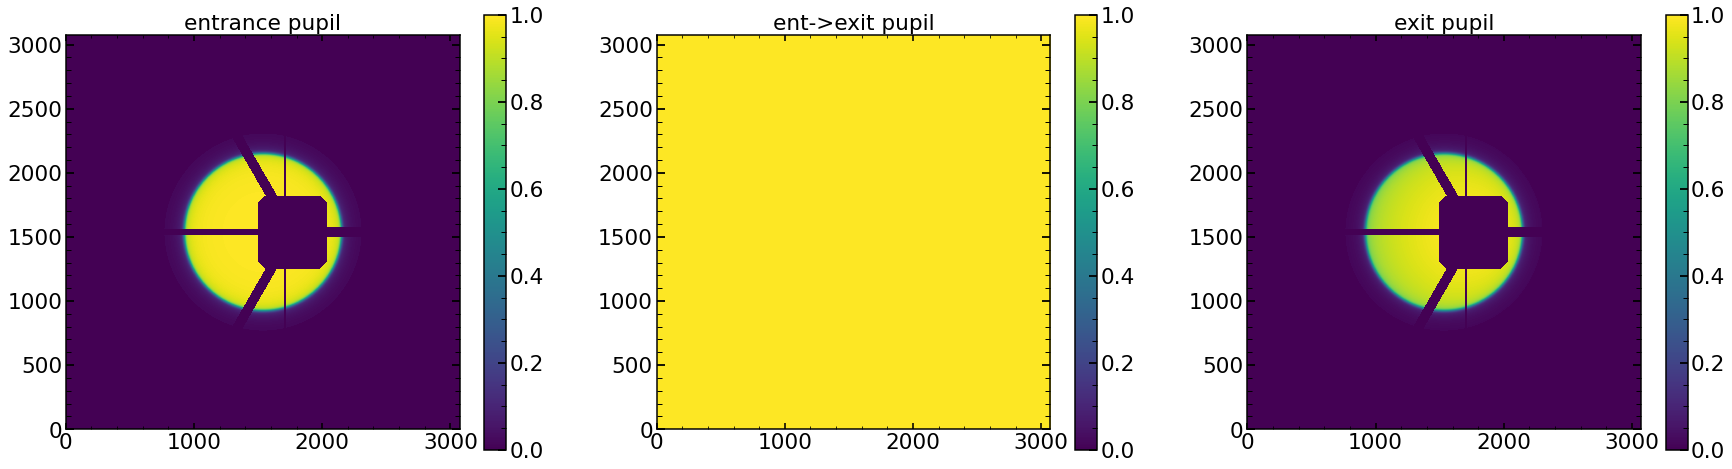

In [272]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

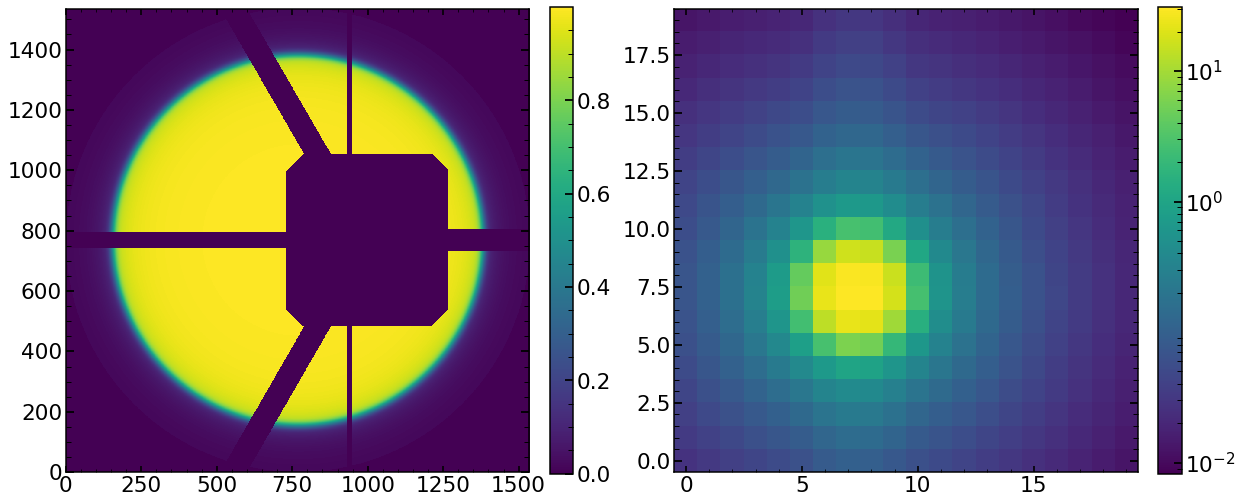

In [273]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,norm=LogNorm(),origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10**-2,1,10,10**2,10**3,10**4,10**5])

# Test run update 

## scripts 

### first test run - test times

In [1130]:
finalHgAr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalHgAr_Feb2020",allow_pickle=True)
finalNe_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalNe_Feb2020",allow_pickle=True)
finalKr_Feb2020_dataset=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_May_28/Dataframes/finalKr_Feb2020",allow_pickle=True)

In [1131]:
list_of_HgAr_to_analyze=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='1'].index
list_of_Ne_to_analyze=finalNe_Feb2020_dataset[finalNe_Feb2020_dataset['close']=='1'].index

In [1132]:
print(len(list_of_Ne_to_analyze))
print(len(list_of_HgAr_to_analyze))
print(list_of_HgAr_to_analyze)
print(list_of_Ne_to_analyze)

def remove(string): 
    return string.replace(" ", "")

40
50
Int64Index([  1,   3,   6,   9,  11,  13,  15,  18,  21,  23,  25,  27,  30,
             33,  35,  37,  39,  42,  45,  47,  49,  51,  54,  57,  59,  61,
             63,  66,  69,  71,  73,  75,  78,  81,  83,  85,  87,  90,  93,
             95,  97,  99, 102, 105, 107, 109, 111, 114, 117, 119],
           dtype='int64')
Int64Index([ 2,  5,  6,  7, 11, 14, 15, 16, 20, 23, 24, 25, 29, 32, 33, 34, 38,
            41, 42, 43, 47, 50, 51, 52, 56, 59, 60, 61, 65, 68, 69, 70, 74, 77,
            78, 79, 83, 86, 87, 88],
           dtype='int64')


In [1695]:
for single_spot in list_of_Ne_to_analyze:
    if str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalNe_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Ne_1_'+str(single_spot)+'Sep25.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=2 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 01:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, m05, 0, p05, p3, p35, p4
    file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 21556 21562 21568 21598 21604 21610 21640 21646 21652 -spot "+str(single_spot)+\
               " -nsteps 65 -eps 6 -dataset 4 -arc Ne -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalNe_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Mar06 -direct_or_interpolation direct -date_of_output Sep25 -analysis_type defocus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Sep25ScriptToSubmitScriptsTiger_Ne_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_Ne_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_Ne_1_'+str(single_spot)+'Sep25.sh \n')

file.close()

In [1696]:

for single_spot in list_of_HgAr_to_analyze:
    if str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0' or str(finalHgAr_Feb2020_dataset.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_HgAr_1_'+str(single_spot)+'Sep25.sh','w') 
    file.write("#!/bin/bash \n")
    file.write("#SBATCH --nodes=2 # node count \n")
    file.write("#SBATCH --ntasks-per-node=40 \n") 
    file.write("#SBATCH --time 01:55:59 \n")
    file.write("#SBATCH --mail-type=begin  \n")
    file.write("#SBATCH --mail-type=end   \n") 
    file.write("#SBATCH --mail-user=ncaplar@princeton.edu \n") 

    file.write("\n")
    file.write("#1. Observation (e.g., 8567) \n") 
    file.write("#2. Threads \n") 
    file.write("#3. Steps \n") 
    file.write("\n")
    # m4, m35, m3, p3, p35, p4
    file.write("mpirun python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 21352 21358 21364 21394 21400 21406 21436 21442 21448 -spot "+str(single_spot)+\
               " -nsteps 65 -eps 6 -dataset 4 -arc HgAr -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalHgAr_Feb2020_dataset.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Mar06 -direct_or_interpolation direct -date_of_output Sep25 -analysis_type defocus \n")
    file.close()    
    
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/Sep25ScriptToSubmitScriptsTiger_HgAr_1_'+'.sh','w')
file.write("#!/bin/bash \n")
file.write("\n")
for single_spot in list_of_HgAr_to_analyze:
    file.write('sbatch /home/ncaplar/Scripts/T_HgAr_1_'+str(single_spot)+'Sep25.sh \n')

file.close()

## which images are avaliable - Sep25

In [52]:
date='Sep2520'
Emcee3_Ne=glob.glob('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*6NeSwarm1.npy', recursive=True)
Emcee3_HgAr=glob.glob('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*6HgArSwarm1.npy', recursive=True)
Emcee3_Kr=glob.glob('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_*6KrSwarm1.npy', recursive=True)

print([len(Emcee3_Ne),len(Emcee3_HgAr),len(Emcee3_Kr)])

[11, 29, 0]


In [64]:
analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][85:len(Emcee3_Ne[i])-13]
    analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:])])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_HgAr_images=[]
for i in range(len(Emcee3_HgAr)):
    single_string=Emcee3_HgAr[i][85:len(Emcee3_HgAr[i])-15]
    analyzed_HgAr_images.append([int(single_string[:5]),int(single_string[5:])])
 

analyzed_HgAr_images=np.array(analyzed_HgAr_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][86:len(Emcee3_Kr[i])-13]
    analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:])])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [66]:
if len(analyzed_HgAr_images)>0:
    arranged_by_defocus_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,0].argsort()]
    arranged_by_spot_number_HgAr=analyzed_HgAr_images[analyzed_HgAr_images[:,1].argsort()]
else:
    arranged_by_defocus_HgAr=[]
    arranged_by_spot_number_HgAr=[]

if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print(len(analyzed_HgAr_images),len(analyzed_Neon_images),len(analyzed_Kr_images))

29 11 0


In [67]:
analyzed_HgAr_images

array([[21448,   102],
       [21448,   105],
       [21448,   107],
       [21448,   109],
       [21448,   114],
       [21448,    13],
       [21448,     1],
       [21448,    21],
       [21448,    30],
       [21448,    33],
       [21448,    35],
       [21448,     3],
       [21448,    37],
       [21448,    39],
       [21448,    42],
       [21448,    45],
       [21448,    47],
       [21448,    54],
       [21448,    57],
       [21448,    59],
       [21448,     6],
       [21448,    69],
       [21448,    81],
       [21448,    83],
       [21448,    87],
       [21448,    90],
       [21448,    93],
       [21448,    95],
       [21448,     9]])

In [157]:
analyzed_Neon_images

array([[21652,    23],
       [21652,    29],
       [21652,    33],
       [21652,    38],
       [21652,    47],
       [21652,    50],
       [21652,    51],
       [21652,    59],
       [21652,    77],
       [21652,    83],
       [21652,    87]])

## single image 

In [304]:
#date='Jul2020'
date='Sep2520'
#obs=21652
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
#obs_int=int(obs)
single_number='3'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

labelInput: 0
self.single_number: 3
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [21352, 21358, 21364, 21394, 21400, 21406, 21436, 21442, 21448]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalHgAr_Feb2020'>
analyzing label: 21400
double_sources_positions_ratios for this spot is: [0 0]


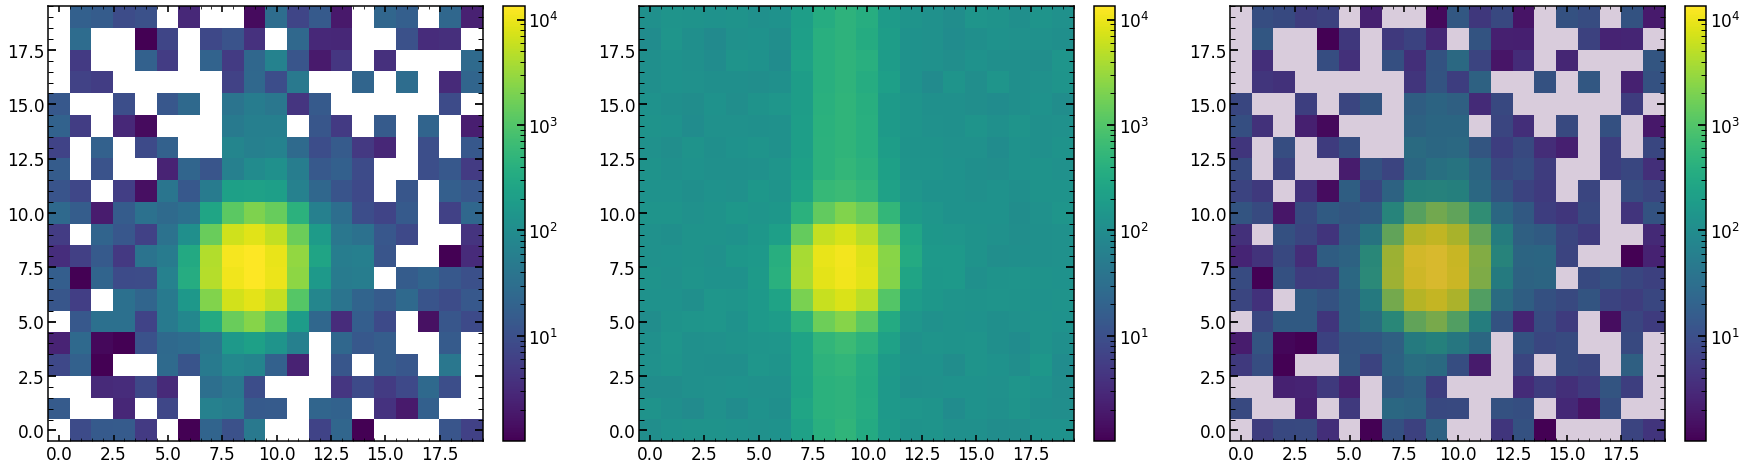

In [305]:
single_analysis=Zernike_Analysis(date=date,obs='0',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [306]:
#single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
#                                 list_of_defocuses=['m4','m35','m3','m05','0','p05','p3','p35','p4'])


double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

(65, 120, 129)
(65, 120, 129)
minimal likelihood is: 3347.3742321199115
minimal chi2 reduced is (makes no sense for multi_var): 9.653381170365183


In [307]:
/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2520/chainSep2520_Single_P_2144896HgArres_gbests_position.npy

NameError: name 'Volumes' is not defined

In [353]:
minchain_parametrization

array([   -7.48584024,     0.73497698,     0.19568978,     0.15682353,
           0.03769565,     0.02577918,    -0.03734586,     0.39183789,
           0.02550665,     0.556507  ,     0.0072312 ,     0.1261021 ,
           0.01097693,    -0.26493479,    -0.01831573,    -0.05247759,
           0.01020252,    -0.15314955,     0.00343817,    -0.10475206,
           0.02711867,    -0.0137685 ,     0.00445374,     0.0372618 ,
           0.01458828,    -0.02237409,    -0.01880653,     0.03841714,
          -0.00188257,     0.02112357,    -0.00910924,     0.01975998,
          -0.00067647,    -0.02366152,     0.00463751,     0.012873  ,
          -0.00621102,     0.02695559,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     0.63182418, 51347.90306188,
      

In [ ]:
#np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2520/chainSep2520_Single_P_21652476Neres_gbests_fitness.npy')
#res_gbests_position=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2520/chainSep2520_Single_P_2144836HgArres_gbests_position.npy')
#res_gbests_fitness=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2520/chainSep2520_Single_P_2144836HgArres_gbests_fitness.npy')

#print(res_gbests_fitness)
#minchain_parametrization=res_gbests_position[-1]
#minchain_parametrization

In [308]:
res_gbests_position

array([[-7.61451082,  1.05603441,  0.20344571, ...,  0.        ,
         0.        ,  0.        ],
       [-7.49479336,  0.71419136,  0.19031615, ...,  0.00593479,
         0.00285012, -0.00220732],
       [-7.49479336,  0.71419136,  0.19031615, ...,  0.00593479,
         0.00285012, -0.00220732],
       ...,
       [-7.48584024,  0.73497698,  0.19568978, ...,  0.0103669 ,
         0.00272563, -0.00187062],
       [-7.48584024,  0.73497698,  0.19568978, ...,  0.0103669 ,
         0.00272563, -0.00187062],
       [-7.48584024,  0.73497698,  0.19568978, ...,  0.0103669 ,
         0.00272563, -0.00187062]])

(0.6395259328200976, 0.8395259328200976)

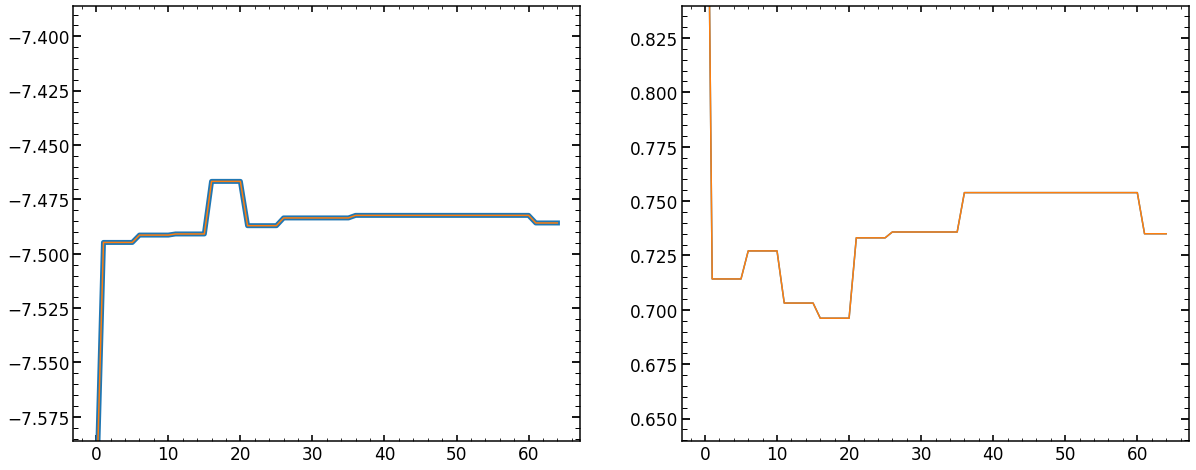

In [309]:
# wavefront paramter
plt.figure(figsize=(20,8))
i=0*2
plt.subplot(121)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,78][:,i],lw=5)
plt.plot(chain0_swarm_1[:,28][:,i])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)


plt.subplot(122)
#  paramter 2 (z5)

mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,2])
plt.ylim(mean_one_what-0.1,mean_one_what+0.1)


Text(0.5, 0, 'nstep')

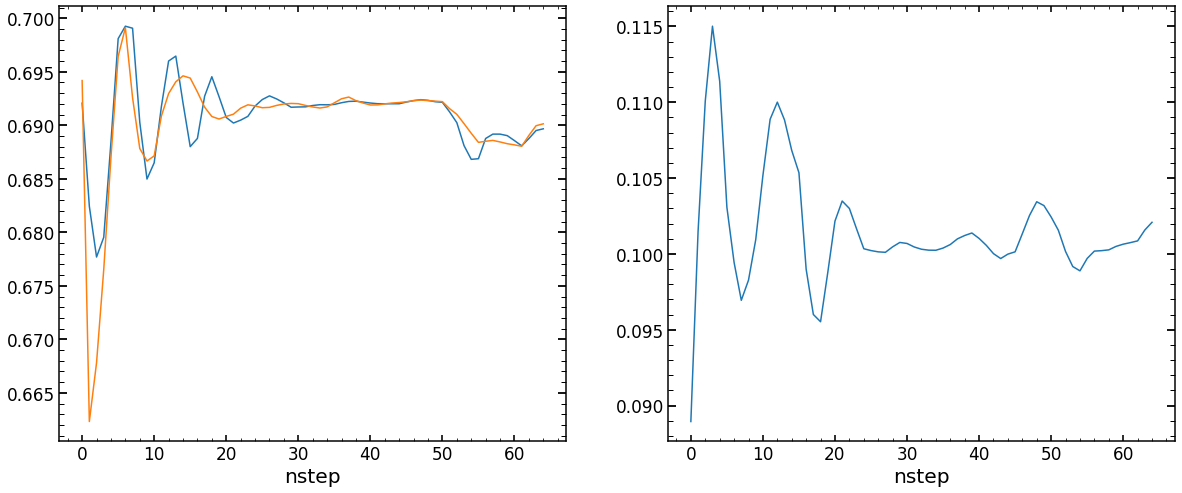

In [310]:
# pupil paramter
plt.figure(figsize=(20,8))
i=19*2
plt.subplot(121)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,78][:,i])
plt.plot(chain0_swarm_1[:,28][:,i])
plt.xlabel('nstep')

plt.subplot(122)
plt.plot(chain0_swarm_1[:,:,i+1][:,2])
plt.xlabel('nstep')

Text(0, 0.5, 'std. devation of a single parameter')

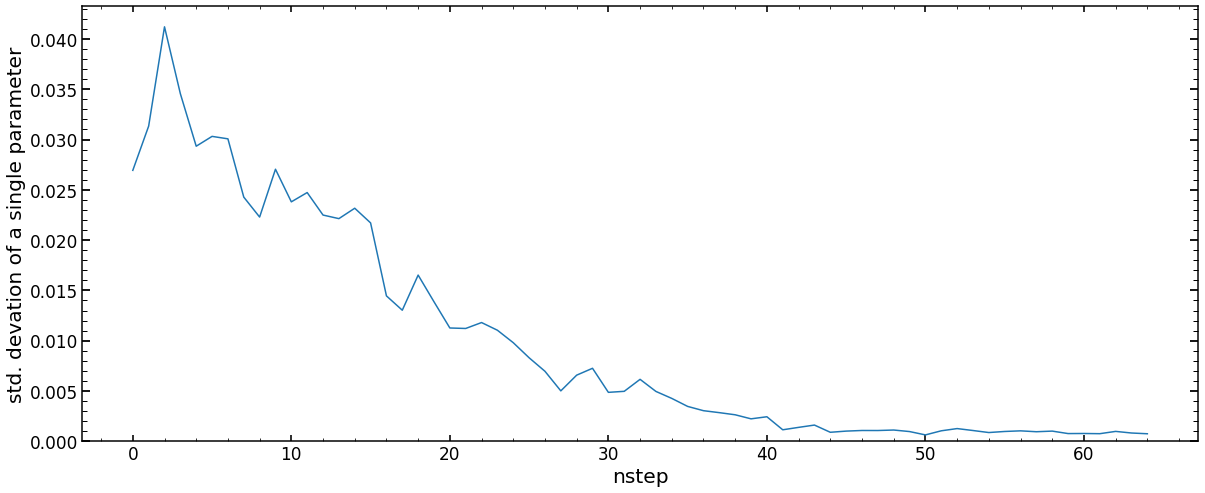

In [311]:
list_of_std=[]
i=19*2+0
for j in range(len(chain0_swarm_1)):
    list_of_std.append(np.std(chain0_swarm_1[:,:,i][j]))

plt.figure(figsize=(20,8))
plt.plot(list_of_std)
plt.ylim(0)
plt.xlabel('nstep')
plt.ylabel('std. devation of a single parameter')

## Image creation and image analysis


In [312]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=56,verbosity=1,\
                      double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   

#list_of_minchain=model_multi.create_list_of_allparameters(t1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
#list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=['m4','p4'],zmax=56)

res_multi=model_multi(list_of_minchain,return_Images=True)


mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results=res_multi

#model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
#                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 3.0530858
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 155.51562
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.33b
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   30.67833792    -0.62593558    -0.12500341     0.54122132
     0.45448039     0.09717731    -0.3088425      0.02078535
    -0.19395961    -0.11850474    -0.12224319     0.01944683
    -0.08072721     0.11364325     0.02865383     0.05619695
    -0.02095563    -0.00567703     0.05179967     0.68904049
     0.10290975    -0.20154677    -0.01441376     0.05355728
     0.05813265     

chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.206806
chi2 within shgo optimization routine (chi_2_almost_multi_values): 180.34076
chi2 within shgo optimization routine (chi_2_almost_multi_values): 57.990814
chi2 within shgo optimization routine (chi_2_almost_multi_values): 29.889803
chi2 within shgo optimization routine (chi_2_almost_multi_values): 22.208511
chi2 within shgo optimization routine (chi_2_almost_multi_values): 19.78021
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.88789
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.51923
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.355467
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.27895
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.242172
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.224234
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.224236
chi

Time for wavefront and wavefront/pupil combining is 0.0003819465637207031
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.3426079750061035
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 2476
optPsf_cut.shape(2477, 2477)
oversampling:9.0
optPsf_cut.shape[0]2477
size_of_optPsf_cut_downsampled: 630.0
optPsf_cut_downsampled.shape: (631, 631)
size_of_optPsf_cut_in_Microns: 1051.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[51347.903061880126, 2.322133018605046, 0.002389913575609706, 0.37175130820462965, 1.7941134513102197]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(631, 631)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source position/ratio is:[0 0]
Time fo

Time to apodize the pupil: 0.1284632682800293
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.27638816833496094
Time for pupil and illumination calculation is 0.2817258834838867

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 23.192497681653254, -0.4302457999486988, -0.08730776309046157, 0.5038754606668618, 0.4799870431462036, 0.10440850715344337, -0.2978655730984511, 0.002469614500946092, -0.18375709394484108, -0.11506656586417814, -0.09512452000489421, 0.023900571666000073, -0.06613892629166873, 0.09483672067316506, 0.02677126820976943, 0.04708771068959432, -0.021632105504801963, -0.0010395178614339279, 0.04558864658724544, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -0.4302457999486988, -0.08730776309046157, 0.50387546

Time to apodize the pupil: 0.12886404991149902
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2766878604888916
Time for pupil and illumination calculation is 0.2823951244354248

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 4.477897094066955, 0.05897863979944455, 0.006931353795226618, 0.4105108169483621, 0.5437536780042803, 0.12248650223453315, -0.27042325708790715, -0.04331972162767973, -0.15825080428545824, -0.10647114191504876, -0.02732783343127223, 0.0350349321125579, -0.02966822878807985, 0.04782040268440413, 0.022064852759360883, 0.02431460212347802, -0.023323284069806213, 0.010554250863725878, 0.03006109602478455, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.05897863979944455, 0.006931353795226618, 0.41051081694

lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767312963839068, 0.9483624833507853, 3.140403347034035e-05, 3.1399178161480356e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.13008999824523926
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2740058898925781
Time for pupil and illumination calculation is 0.2792837619781494

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 0.7349769765496937, 0.15682352774907324, 0.025779177172364255, 0.3918378882046622, 0.5565070049758957, 0.1261021012507511, -0.2649347938857984, -0.052477588853404894, -0.15314954635358166, -0.10475205712522288, -0.01376849611654783, 0.03726180420186946, -0.02237408928736207, 0.03841713908665194,

lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767312963839068, 0.9483624833507853, 3.140403347034035e-05, 3.1399178161480356e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.1262500286102295
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.3254251480102539
Time for pupil and illumination calculation is 0.33125901222229004

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -3.007943140967567, 0.2546684156987019, 0.04462700054950189, 0.3731649594609623, 0.569260331947511, 0.12971770026696908, -0.2594463306836896, -0.061635456079130055, -0.1480482884217051, -0.103032972335397, -0.00020915880182343326, 0.039488676291181024, -0.015079949786644295, 0.029013875488899752

/Users/nevencaplar/anaconda2/envs/idp2_pyfftw/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767312963839068, 0.9483624833507853, 3.140403347034035e-05, 3.1399178161480356e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.1269702911376953
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2775700092315674
Time for pupil and illumination calculation is 0.2827270030975342

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -21.72254372855387, 0.7438928554468454, 0.13886611743519006, 0.27980031574246256, 0.6330269668055877, 0.14779569534805886, -0.2320040146731457, -0.10742479220775589, -0.12254199876232225, -0.09443754838626763, 0.06758752777179855, 0.05062303673773885, 0.02139074771694458, -0.01800244249986118, 0.

Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767312963839068, 0.9483624833507853, 3.140403347034035e-05, 3.1399178161480356e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.12543296813964844
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.26779699325561523
Time for pupil and illumination calculation is 0.27290987968444824

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -25.46546384607113, 0.8417377433964741, 0.1577139408123277, 0.2611273869987626, 0.645780293777203, 0.1514112943642768, -0.2265155514710369, -0.11658265943348105, -0.11744074083044567, -0.09271846359644174, 0.08114686508652295, 0.052849908827050415, 0.02868488721766236, -0.027405706097613364, 0.014534588038707205, -0.01212237158230806, -0.026029

Time to apodize the pupil: 0.15036797523498535
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.33893299102783203
Time for pupil and illumination calculation is 0.34485602378845215

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -29.208383963588393, 0.9395826313461028, 0.17656176418946534, 0.24245445825506268, 0.6585336207488184, 0.15502689338049477, -0.22102708826892814, -0.1257405266592062, -0.1123394828985691, -0.09099937880661588, 0.09470620240124734, 0.05507678091636198, 0.03597902671838014, -0.036808969695365554, 0.013593304948625495, -0.01667699329553132, -0.02636740548681386, 0.03142303456901353, 0.002111505012354929, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.9395826313461028, 0.17656176418946534, 0.24245445825

In [313]:
# likelihood, max likelihood, chi2, max chi2
list_of_single_chi_results

[[65210.613, 8385626.0, 18.11406, 2329.3406],
 [42297.72, 6975762.0, 16.919088, 2790.3047],
 [30545.293, 5814941.5, 19.090809, 3634.3384],
 [1941.0033, 414867.84, 4.852508, 1037.1696],
 [1297.1488, 168417.16, 3.242872, 421.04288],
 [1130.454, 265213.56, 2.826135, 663.03394],
 [32722.873, 5955496.5, 13.089149, 2382.1985],
 [50746.688, 8053991.0, 14.096302, 2237.2197],
 [73249.06, 10400762.0, 20.346962, 2889.1006]]

(65, 120, 129)
minimal likelihood is: 3347.3742321199115
minimal chi2 reduced is (makes no sense for multi_var): 9.653381170365183
(65, 120, 129)


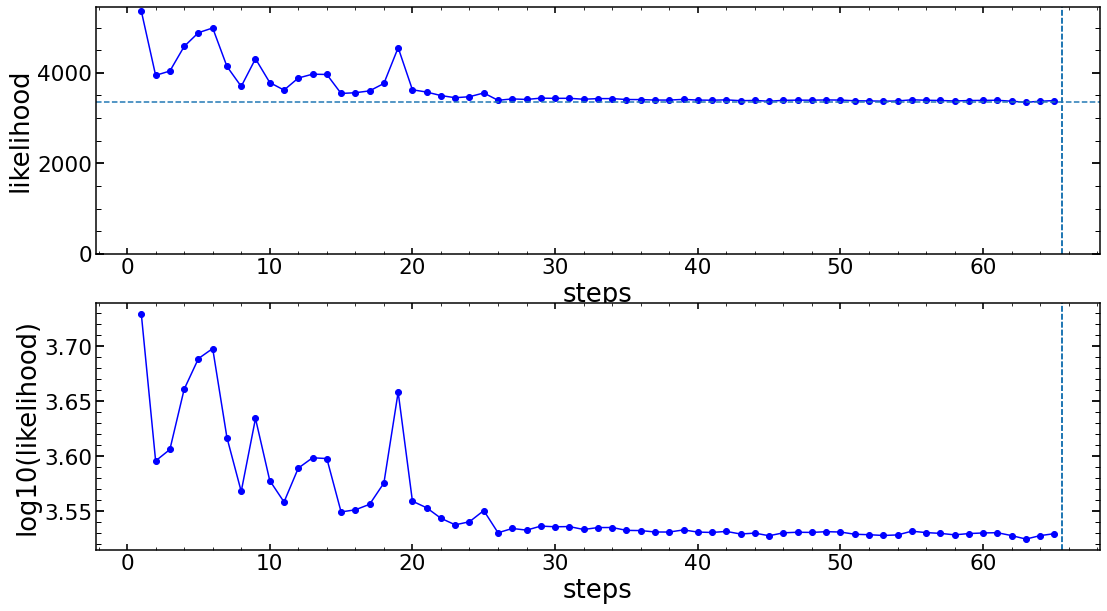

In [314]:
single_analysis.create_fitting_evolution_plot()

In [315]:
minchain=list_of_minchain[0]

print(minchain.shape)

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)

dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])

dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:30]]),columns=columns22[19:30])
print(dfglobal1)

dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][30:41]]),columns=columns22[30:41])
print(dfglobal2)

(76,)
          z4        z5        z6        z7       z8        z9       z10  \
0  30.678338 -0.625936 -0.125003  0.541221  0.45448  0.097177 -0.308842   

        z11  
0  0.020785  
       z12       z13       z14       z15       z16       z17       z18  \
0 -0.19396 -0.118505 -0.122243  0.019447 -0.080727  0.113643  0.028654   

        z19       z20       z21     z22  
0  0.056197 -0.020956 -0.005677  0.0518  

   hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy  \
0  0.68904    0.10291 -0.201547 -0.014414  0.053557     0.058133   

   radiometricEffect  radiometricExponent    x_ilum    y_ilum  x_fiber  
0           0.000031             0.000031  0.976731  0.948362  0.02462  
    y_fiber  effective_radius_illumination  frd_sigma  frd_lorentz_factor  \
0 -0.058351                       0.933935   0.048672            0.499049   

   det_vert  slitHolder_frac_dx  grating_lines  scattering_slope  \
0   1.01173            0.631824   51347.903062          2.322133   

   sca

(-2.8, -1.5)

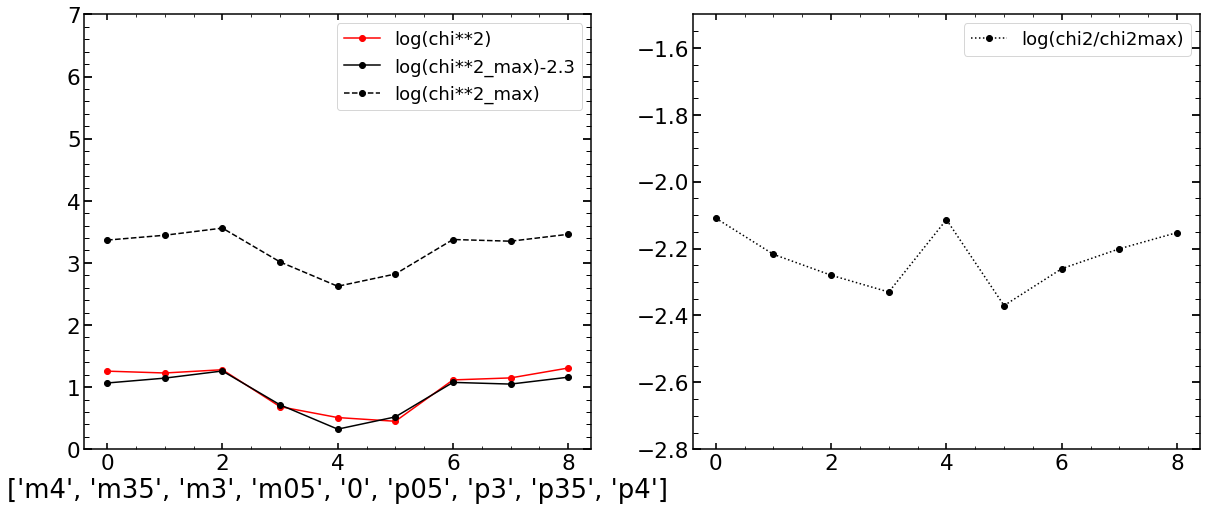

In [316]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi**2)',marker='o')
plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi**2_max)',marker='o',ls='--')
plt.ylim(0,7)
plt.xlabel(list_of_defocuses_input_long)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi2/chi2max)',marker='o',ls=':')
plt.legend()
plt.ylim(-2.8,-1.5)

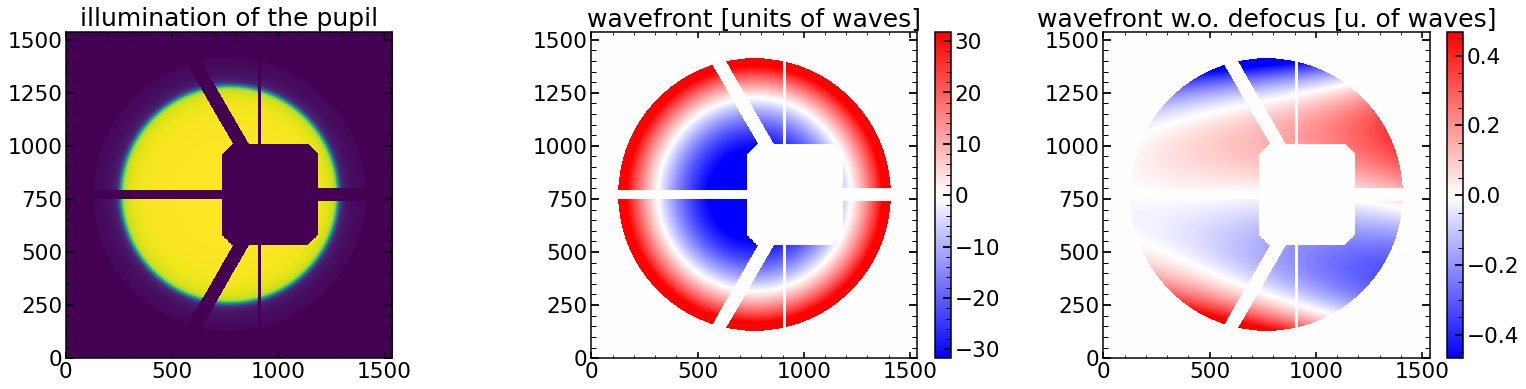

In [317]:
single_analysis.illumination_wavefront_plot()

chi**2 reduced is: 20.346962
Abs of residual divided by total flux is: 0.06684339
Abs of residual divided by largest value of a flux in the image is: 0.14541253


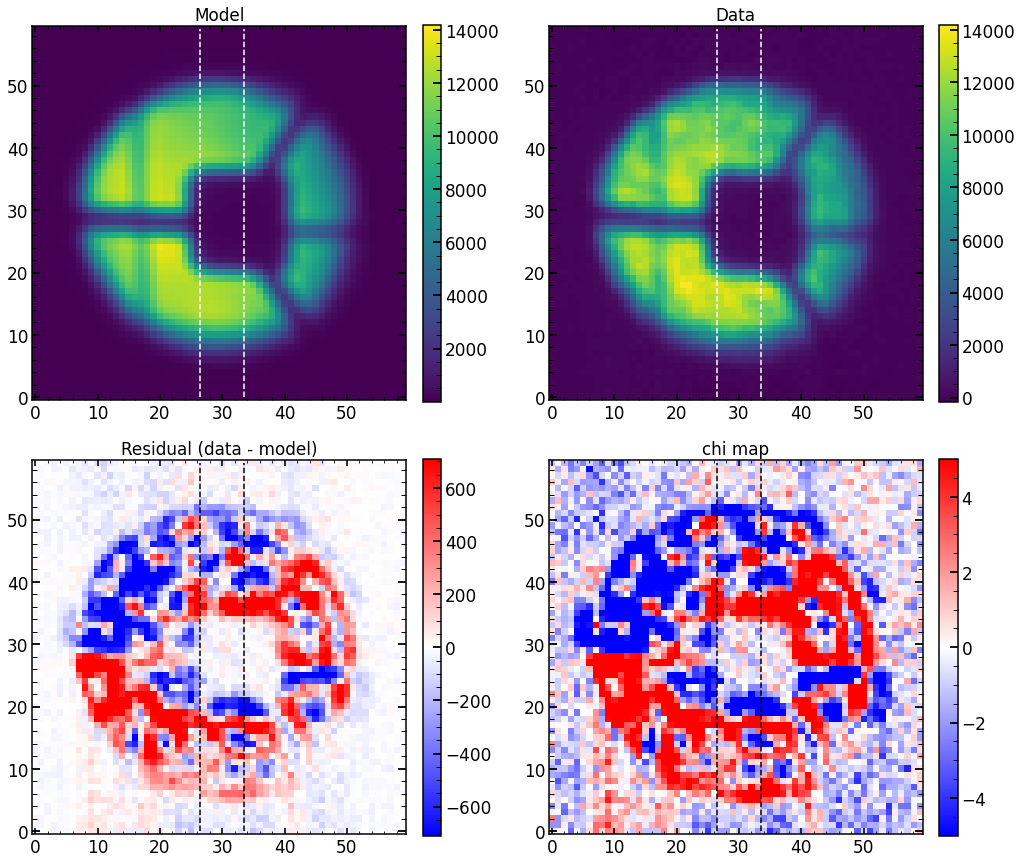

In [345]:
index_of_single_image=8

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False)

chi**2 max reduced is: 2868.7534
chi**2 reduced is: 20.346962
Abs of residual divided by total flux is: 0.06684339
Abs of residual divided by largest value of a flux in the image is: 0.14541253


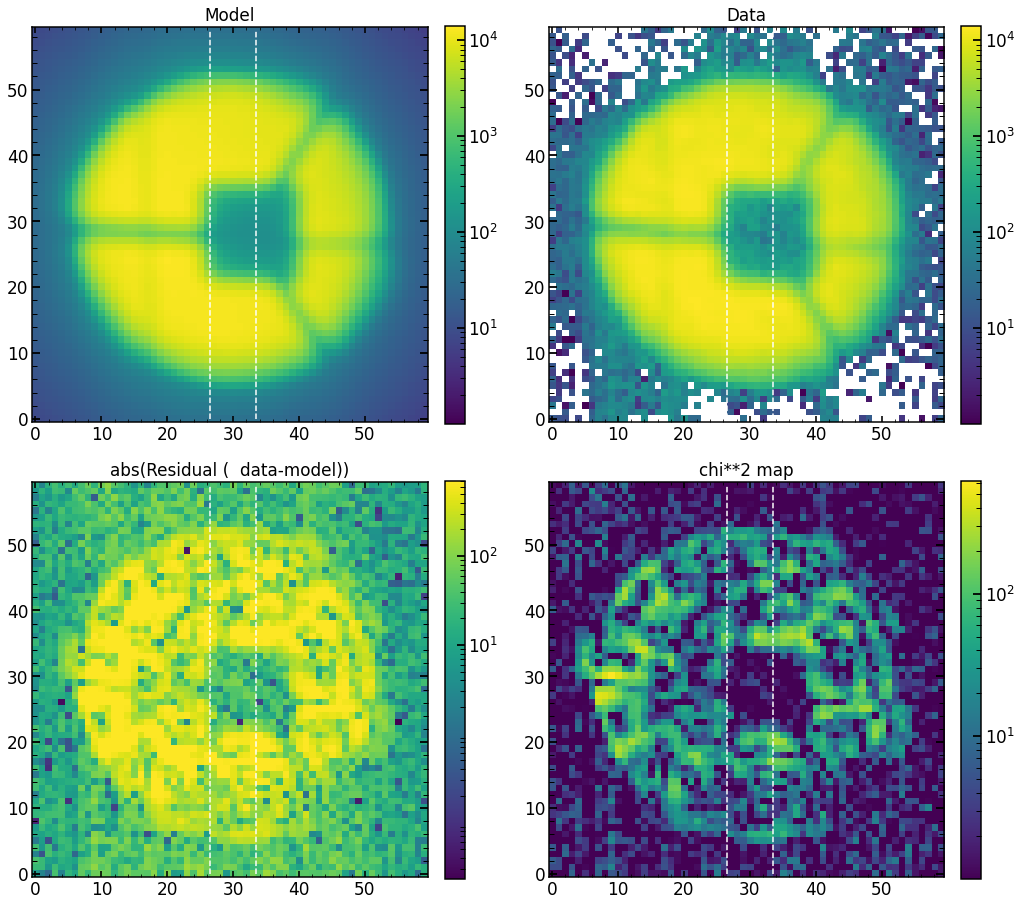

In [346]:
single_analysis.create_basic_comparison_plot_log(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                                show_flux_mask=False)

18.11406
chi**2 reduced is: 18.11406
Abs of residual divided by total flux is: 0.071292356
Abs of residual divided by largest value of a flux in the image is: 0.16060744


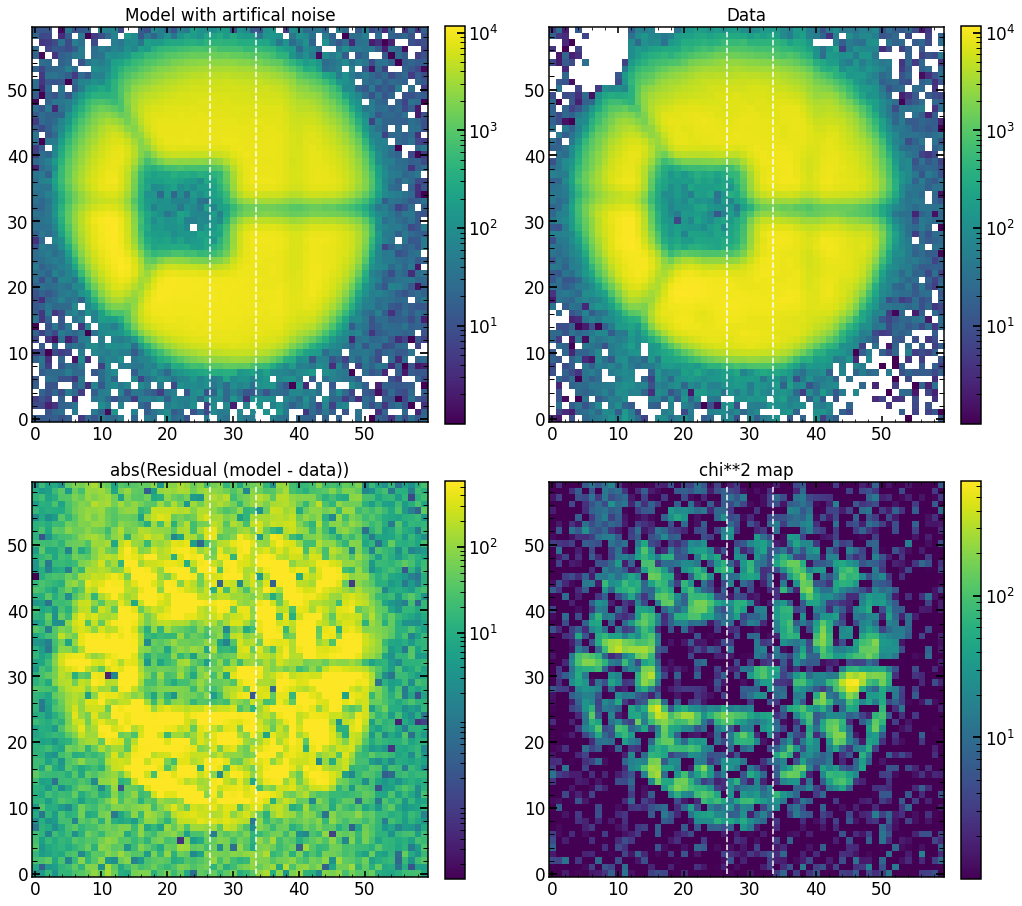

In [320]:
single_analysis.create_basic_comparison_plot_log_artifical(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image])

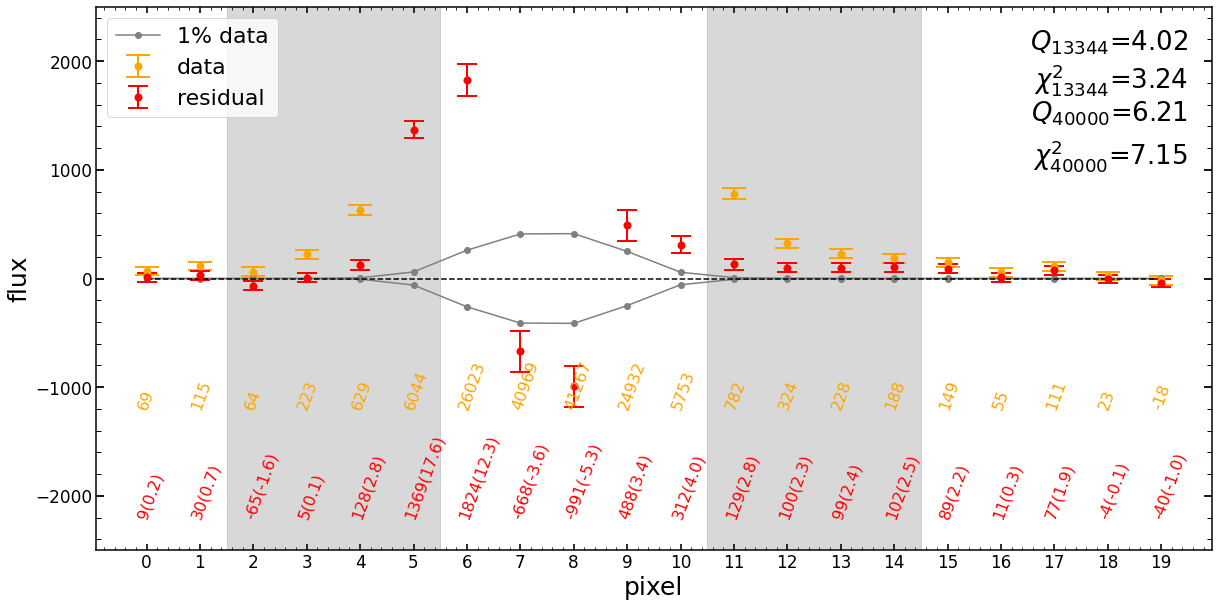

In [321]:
index_of_single_image=4
plot_1D_residual(sci_image=list_of_sci_images[index_of_single_image],var_image=list_of_var_images[index_of_single_image],model_image=list_of_single_model_image[index_of_single_image])

In [328]:
sci_image=list_of_sci_images[index_of_single_image]

mean_value_of_background=np.mean([np.median(sci_image),np.median(sci_image),\
                      np.median(sci_image),np.median(sci_image)])*3

flux_mask=sci_image>(mean_value_of_background)

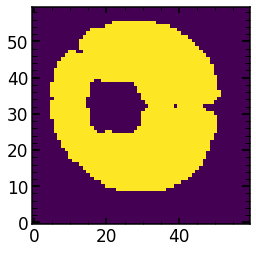

In [330]:
plt.imshow(flux_mask)

In [331]:
flux_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [335]:
from contextlib import suppress

def compare_neighbors(arr):

    comp_arr = np.full(arr.shape, False, dtype=bool)

    for (x, y), item in np.ndenumerate(arr):
        # Check left.
        if x >= 0:
            if arr[x-1, y] != item:
                comp_arr[x, y] = True
                continue

        # Check right.
        with suppress(IndexError):
            if arr[x+1, y] != item:
                comp_arr[x, y] = True
                continue

        # Check top.
        with suppress(IndexError):
            if arr[x, y+1] != item:
                comp_arr[x, y] = True
                continue

        # Check bottom.
        if y >= 0:
            if arr[x, y-1] != item:
                comp_arr[x, y] = True
                continue

    return comp_arr

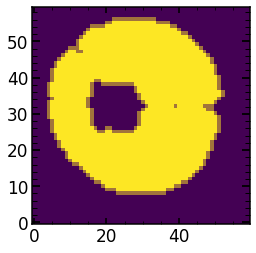

In [343]:
flux_mask_2=compare_neighbors(flux_mask)+flux_mask

plt.imshow(flux_mask_2)
plt.imshow(flux_mask,alpha=0.5)

In [347]:
minchain_parametrization

array([   -7.48584024,     0.73497698,     0.19568978,     0.15682353,
           0.03769565,     0.02577918,    -0.03734586,     0.39183789,
           0.02550665,     0.556507  ,     0.0072312 ,     0.1261021 ,
           0.01097693,    -0.26493479,    -0.01831573,    -0.05247759,
           0.01020252,    -0.15314955,     0.00343817,    -0.10475206,
           0.02711867,    -0.0137685 ,     0.00445374,     0.0372618 ,
           0.01458828,    -0.02237409,    -0.01880653,     0.03841714,
          -0.00188257,     0.02112357,    -0.00910924,     0.01975998,
          -0.00067647,    -0.02366152,     0.00463751,     0.012873  ,
          -0.00621102,     0.02695559,     0.68904049,     0.10290975,
          -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
           0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
           0.02461952,    -0.05835101,     0.93393462,     0.04867201,
           0.49904901,     1.01173008,     0.63182418, 51347.90306188,
      

In [348]:
array_of_delta_global_parametrizations=np.array([0.05285587 , 0.19716556 , 0.00448007, -0.06141872, -0.00420325, -0.11149694,
  0.00535649,  0.07387094,  0.02275813, -0.12825901, -0.00601931,  0.08357383,
 -0.00556161,  0.06639039, -0.0037773 ,  0.13469364,  0.00951384, -0.00236535,
 -0.00245259,  0.00521977,  0.00011709,  0.02412354, -0.00673444, -0.12703039,
 -0.01002632,  0.0550818,  -0.02090455,  0.00392947, -0.01590415, -0.02113437,
 -0.00359054,  0.0205519,  -0.01027336,  0.03458876,  0.01330406, -0.02962423,
  0.01168176, -0.02513047, -0.01537215, -0.01794922,  0.00673101, -0.01629316,
  0.00151441,  0.07865134, -0.00769185, -0.01093359,  0.00651897,  0.07435631,
  0.00090625,  0.03325546,  0.00245636, -0.02224543, -0.00739112,  0.05216291,
 -0.01043112,  0.0797051 , -0.00458659, -0.00468773, -0.0049568 ,  0.00003095,
 -0.00030298,  0.00374463,  0.00441258, -0.04681072, -0.01165275, -0.02323354,
  0.01063934, -0.02480755,  0.00139148, -0.00944701, -0.00291141, -0.04433513,
  0.01197831, -0.03188329,  0.00887828,  0.01126722,  0.0117296 , -0.04778024,
  0.00403519, -0.00970765, -0.0066172 ,  0.00727882, -0.00096792, -0.00559075,
 -0.00828263, -0.00119422, -0.00513805,  0.0226301 ,  0.01619478, -0.00718433,
 -0.00181654,  0.03367307,  0.00131863,  0.02937551, -0.00289554,  0.01044654,
 -0.00189303, -0.01216205,  0.01727525,  0.02669305, -0.00100236, -0.03560146,
 -0.00575046, -0.02420591,  0.00821028, -0.00277234])

In [ ]:
out_images=out_images_1
array_of_delta_z_parametrizations=array_of_delta_z_parametrizations_1
#list_of_single_model_image
#list_of_var_images
#list_of_mask_images

list_of_mean_value_of_background=[]
list_of_flux_mask=[]
list_of_sci_image_std=[]
for i in range(len(list_of_sci_images)):
    sci_image=list_of_sci_images[i]

    mean_value_of_background=np.mean([np.median(sci_image[0]),np.median(sci_image[-1]),\
                                      np.median(sci_image[:,0]),np.median(sci_image[:,-1])])*10
    list_of_mean_value_of_background.append(mean_value_of_background)
    flux_mask=sci_image>(mean_value_of_background)


    # normalized science image
    var_image=list_of_var_images[i]
    sci_image_std=sci_image/np.sqrt(var_image)
    list_of_sci_image_std.append(sci_image_std)
    list_of_flux_mask.append(flux_mask)
    

######################################################################################################### 
# normalized and masked science image
# why do I do this here, I could have done this at stage 0 
list_of_I=[]
list_of_I_std=[]    

for i in range(len(list_of_sci_images)):

    sci_image=list_of_sci_images[i]
    sci_image_std=list_of_sci_image_std[i]
    flux_mask=list_of_flux_mask[i]

    I=((sci_image[flux_mask])/np.sum(sci_image[flux_mask])).ravel()
    I_std=((sci_image_std[flux_mask])/np.sum(sci_image_std[flux_mask])).ravel()

    list_of_I.append(I)
    list_of_I_std.append(I_std)

# join all I,I_std from all individual images into one uber I,I_std  
uber_I=[item for sublist in list_of_I for item in sublist]
uber_I_std=[item for sublist in list_of_I_std for item in sublist]    

uber_I=np.array(uber_I)
uber_I_std=np.array(uber_I_std)

list_of_images_normalized_uber=[]
list_of_images_normalized_std_uber=[]
# go over zmax*2 images
for j in range(len(out_images)):
    # two steps for what could have been achived in one, but to ease up transition from previous code 
    out_images_single_parameter_change=out_images[j]
    optpsf_list=out_images_single_parameter_change
    ### breaking here
    # flux image has to correct per image
    # normalize and mask images that have been created in the fitting procedure
    images_normalized=[]
    for i in range(len(optpsf_list)):

        flux_mask=list_of_flux_mask[i]

        images_normalized.append((optpsf_list[i][flux_mask]/np.sum(optpsf_list[i][flux_mask])).ravel())

    images_normalized_flat=[item for sublist in images_normalized for item in sublist]  
    images_normalized_flat=np.array(images_normalized_flat)/len(optpsf_list)        

    # list of (zmax-3)*2 raveled images
    list_of_images_normalized_uber.append(images_normalized_flat)

    # same but divided by STD
    images_normalized_std=[]
    for i in range(len(optpsf_list)):   
        # seems that I am a bit more verbose here with my definitions
        optpsf_list_i=optpsf_list[i]
        STD=list_of_sci_image_std[i]
        optpsf_list_i_STD=optpsf_list_i/STD    
        flux_mask=list_of_flux_mask[i]
        images_normalized_std.append((optpsf_list_i_STD[flux_mask]/np.sum(optpsf_list_i_STD[flux_mask])).ravel())

    # join all images together
    images_normalized_std_flat=[item for sublist in images_normalized_std for item in sublist]  
    # normalize so that the sum is still one
    images_normalized_std_flat=np.array(images_normalized_std_flat)/len(optpsf_list)

    list_of_images_normalized_std_uber.append(images_normalized_std_flat)

# create uber images_normalized,images_normalized_std    
# images that have zmax*2 rows and very large number of columns (number of non-masked pixels from all N images)
uber_images_normalized=np.array(list_of_images_normalized_uber)    
uber_images_normalized_std=np.array(list_of_images_normalized_std_uber)          

# initial SVD treshold
thresh = 0.02

# set number of extra Zernike
#number_of_extra_zernike=0
#twentytwo_or_extra=22
# numbers that make sense are 11,22,37,56,79,106,137,172,211,254

#if number_of_extra_zernike is None:
#    number_of_extra_zernike=0
#else:
number_of_extra_zernike=twentytwo_or_extra-22


######################################################################################################### 
# divided model images by their standard deviations

list_of_image_0_std=[]
for i in range(len(list_of_image_0)):
    # normalizing by standard deviation image
    STD=np.sqrt(list_of_var_images[i])    
    image_0=list_of_image_0[i]
    list_of_image_0_std.append(image_0/STD)


######################################################################################################### 
# normalized and masked model images before this iteration


list_of_M0=[]
list_of_M0_std=[]
for i in range(len(list_of_image_0_std)):

    image_0=list_of_image_0[i]
    image_0_std=list_of_image_0_std[i]
    flux_mask=list_of_flux_mask[i]
    # what is list_of_mask_images?

    M0=((image_0[flux_mask])/np.sum(image_0[flux_mask])).ravel()
    M0_std=((image_0_std[flux_mask])/np.sum(image_0_std[flux_mask])).ravel()

    list_of_M0.append(M0)
    list_of_M0_std.append(M0_std)

# join all M0,M0_std from invidiual images into one uber M0,M0_std
uber_M0=[item for sublist in list_of_M0 for item in sublist]
uber_M0_std=[item for sublist in list_of_M0_std for item in sublist]    

uber_M0=np.array(uber_M0)
uber_M0_std=np.array(uber_M0_std)

# Figure for Michal summary

In [129]:
import random

In [58]:
per_of_random=[]
for j in range(1000000):
    list_of_random=[]
    for i in range(5):
        
        list_of_random.append(np.ceil(random.uniform(-1,1) ))

    per_of_random.append(np.sum(list_of_random))
    
array_per_of_random=np.array(per_of_random)

In [59]:
len(array_per_of_random[array_per_of_random>=3])

500440

In [55]:
list_of_random

[1.0, -0.0, -0.0, -0.0, -0.0]

In [28]:
np.ceil(+0.5)

1.0

In [535]:
res_iapetus=list_of_single_model_image[index_of_single_image]
sci_image=list_of_sci_images[index_of_single_image]
var_image=list_of_var_images[index_of_single_image]

size=20
if size==20:
    x_center=find_centroid_of_flux(res_iapetus)[0]
else:
    x_center=(size/2)

left_limit=np.round(x_center-3.5)+0.5
right_limit=np.round(x_center+3.5)-0.5  

In [537]:
model_image=res_iapetus

init_lamda,std_init_lamda,init_removal_lamda,std_init_removal_lamda=residual_1D(sci_image,var_image,model_image)


position_of_max_flux=np.where(init_lamda==np.max(init_lamda))[0][0]
difference_from_max=range(20)-position_of_max_flux
pixels_to_test=np.array(range(20))[(np.abs(difference_from_max)>2)&(np.abs(difference_from_max)<=6)]
  

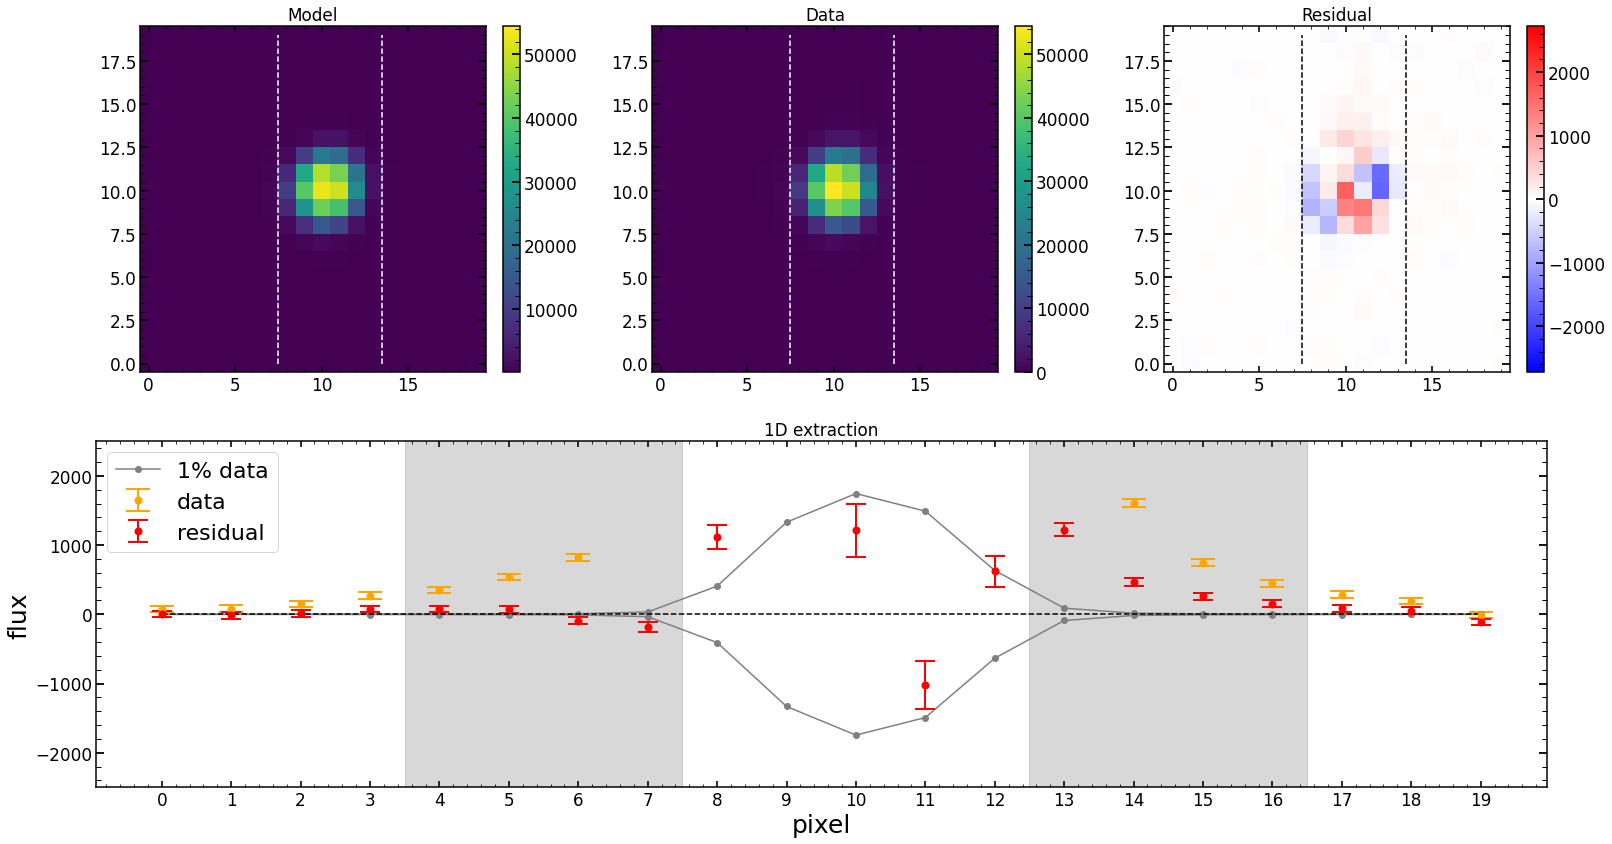

In [550]:
plt.figure(figsize=(26,14))    
plt.subplot(231)
plt.imshow(res_iapetus,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*(left_limit),np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*(right_limit),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Model')
plt.grid(False)
plt.subplot(232)
plt.imshow(sci_image,origin='lower',vmax=np.max(np.abs(sci_image)))
plt.plot(np.ones(len(sci_image))*(left_limit),np.array(range(len(sci_image))),'--',color='white')
plt.plot(np.ones(len(sci_image))*(right_limit),np.array(range(len(sci_image))),'--',color='white')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Data')
plt.grid(False)
plt.subplot(233)
plt.title('Residual')
plt.imshow(sci_image-res_iapetus,origin='lower',cmap='bwr',vmin=-np.max(np.abs(sci_image))/20,vmax=np.max(np.abs(sci_image))/20)
plt.plot(np.ones(len(sci_image))*(left_limit),np.array(range(len(sci_image))),'--',color='black')
plt.plot(np.ones(len(sci_image))*(right_limit),np.array(range(len(sci_image))),'--',color='black')

plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(2,1,2)
plt.title('1D extraction')
plt.errorbar(np.array(range(len(init_lamda))),init_lamda,yerr=std_init_lamda,fmt='o',elinewidth=2,capsize=12,markeredgewidth=2,label='data',color='orange')
plt.plot(np.array(range(len(init_lamda))),init_lamda*0.01,color='gray',label='1% data',marker='o')
plt.plot(np.array(range(len(init_lamda))),-init_lamda*0.01,color='gray',marker='o')    
plt.errorbar(np.array(range(len(init_removal_lamda))),init_removal_lamda,yerr=std_init_removal_lamda,color='red',fmt='o',elinewidth=2,capsize=10,markeredgewidth=2,label='residual')

plt.legend(loc=2, fontsize=22)
plt.plot(np.zeros(20),'--',color='black')
plt.ylim(-2500,2500)
plt.ylabel('flux',size=25)
plt.xlabel('pixel',size=25)
plt.xticks(range(20))

plt.axvspan(pixels_to_test[0]-0.5, pixels_to_test[3]+0.5, alpha=0.3, color='grey')
plt.axvspan(pixels_to_test[4]-0.5, pixels_to_test[7]+0.5, alpha=0.3, color='grey')

# Hexapod experiment  - PIPE2D 584 - September data

In [25]:
Ar_positions_x_1=[474,733,1714,2614,3005]
Ar_positions_y_1=[3420,3406,3387,3388,3396]
Ar_positions_x_2=[477,731,1714,2614,3005]
Ar_positions_y_2=[1679,1668,1652,1654,1660]
Ar_positions_x_3=[477,731,1714,2614,3005]
Ar_positions_y_3=[2589,2576,2559,2561,2567]


In [326]:

list_of_centroids_array=[]
list_of_x_y_z=[]
for i in range(24507,24879+1):
    try:
        if i >=24621:
            hdul=fits.open('/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-09-05/sps/PFSA0'+str(i)+'12.fits')
        else:
            hdul=fits.open('/Volumes/Saturn_USA/PFS/Subaru/raw/pfs/2020-09-04/sps/PFSA0'+str(i)+'12.fits')


        x_y_z=[np.round(hdul[0].header['W_ENFCAX'],4),\
               np.round(hdul[0].header['W_ENFCAY'],4),\
               np.round(hdul[0].header['W_ENFCAZ'],4)]

        scidata=hdul[1].data
        print(i)
        print(x_y_z)

        size=10
        list_of_centroids_same_image=[]
        for Ar_positions_index in [0,1,2]:
            Ar_positions_y=[Ar_positions_y_1,Ar_positions_y_2,Ar_positions_y_3][Ar_positions_index]
            Ar_positions_x=[Ar_positions_x_1,Ar_positions_x_2,Ar_positions_x_3][Ar_positions_index]
            scidata_0=scidata[Ar_positions_y[0]-size:Ar_positions_y[0]+size,Ar_positions_x[0]-size:Ar_positions_x[0]+size]
            scidata_1=np.flip(scidata[Ar_positions_y[1]-size:Ar_positions_y[1]+size,Ar_positions_x[1]-size:Ar_positions_x[1]+size],axis=1)
            scidata_2=np.flip(scidata[Ar_positions_y[2]-size:Ar_positions_y[2]+size,Ar_positions_x[2]-size:Ar_positions_x[2]+size],axis=1)
            scidata_3=scidata[Ar_positions_y[3]-size:Ar_positions_y[3]+size,Ar_positions_x[3]-size:Ar_positions_x[3]+size]
            scidata_4=np.flip(scidata[Ar_positions_y[4]-size:Ar_positions_y[4]+size,Ar_positions_x[4]-size:Ar_positions_x[4]+size],axis=1)

            scidata_0=scidata_0-np.median(scidata_0)
            scidata_1=scidata_1-np.median(scidata_1)
            scidata_2=scidata_2-np.median(scidata_2)
            scidata_3=scidata_3-np.median(scidata_3)
            scidata_4=scidata_4-np.median(scidata_4)

            centroids_array=np.array([find_centroid_of_flux(scidata_0),find_centroid_of_flux(scidata_1),find_centroid_of_flux(scidata_2),find_centroid_of_flux(scidata_3),find_centroid_of_flux(scidata_4)])
            list_of_centroids_same_image.append(centroids_array)
        print(np.concatenate(list_of_centroids_same_image))
        list_of_centroids_array.append(np.concatenate(list_of_centroids_same_image))
        list_of_x_y_z.append(x_y_z)
    except:
        pass



24507
[-0.0, -0.0, -0.0]
[[ 9.73308979  9.81038242]
 [ 9.23549635  9.11026065]
 [10.07073178  9.27633044]
 [ 9.85425104 10.11957968]
 [ 9.36951126  9.19560174]
 [10.21979154  9.95539827]
 [ 9.34644552  9.28276286]
 [ 9.62937316  9.99994749]
 [ 9.2978999   9.50836492]
 [ 8.07647528  9.50080724]
 [10.04129662 16.26329676]
 [ 9.31701889 16.22225583]
 [ 9.96255956 16.24372059]
 [ 9.29516439 16.11452791]
 [ 8.17796226 16.36328605]]
24508
[-0.0, -0.0, -0.0]
[[ 9.7342387   9.80575454]
 [ 9.24095392  9.10325753]
 [10.07654931  9.26966577]
 [ 9.85262027 10.1175148 ]
 [ 9.37160196  9.19340097]
 [10.22488924  9.95164272]
 [ 9.34520683  9.2780028 ]
 [ 9.63214496  9.99832671]
 [ 9.29616755  9.50281086]
 [ 8.07530644  9.49660512]
 [10.04005058 16.24301576]
 [ 9.32592552 16.20586444]
 [ 9.9646364  16.23782581]
 [ 9.29535819 16.1150498 ]
 [ 8.17877039 16.34638351]]
24509
[0.0, -0.0, -0.0]
[[ 9.72950968  9.81518107]
 [ 9.23926889  9.11541357]
 [10.08793542  9.27576409]
 [ 9.79872108 10.12421125]
 [ 9.3

24528
[0.0, 0.05, 0.01]
[[10.01666714 11.3357157 ]
 [ 9.52425446 10.63506022]
 [10.38193351 10.80935577]
 [10.06779904 11.66141542]
 [ 9.66498562 10.74476205]
 [10.52051659 11.43783764]
 [ 9.63940935 10.76683545]
 [ 9.9213105  11.49222372]
 [ 9.58405425 11.00597506]
 [ 8.36769646 11.00162986]
 [10.32387389 14.88785978]
 [ 9.60754943 14.95259912]
 [10.24888101 14.40767914]
 [ 9.5801454  15.18421472]
 [ 8.45212327 14.23799295]]
24529
[0.0, 0.05, 0.0]
[[ 9.72532949 11.34960618]
 [ 9.23849893 10.64292873]
 [10.09265782 10.80813598]
 [ 9.78341596 11.65272979]
 [ 9.37336468 10.72607368]
 [10.22561016 11.44651701]
 [ 9.35243049 10.77356093]
 [ 9.6358381  11.48462376]
 [ 9.29620198 10.99302829]
 [ 8.0776406  10.99744545]
 [10.03840454 14.87318583]
 [ 9.31447315 14.9087978 ]
 [ 9.96279227 14.44730203]
 [ 9.2940666  15.23467066]
 [ 8.16943636 14.2311376 ]]
24530
[0.0, 0.05, 0.0]
[[ 9.72826566 11.3491101 ]
 [ 9.23826957 10.65028229]
 [10.09002497 10.81004296]
 [ 9.77731375 11.65511468]
 [ 9.37380

24548
[-0.0, 0.04, 0.05]
[[11.1825665  10.98231235]
 [10.68429946 10.29807855]
 [11.53783804 10.50914638]
 [11.22517546 11.37852931]
 [10.82414436 10.46901744]
 [11.67498512 11.10425124]
 [10.80103357 10.43951054]
 [11.07329746 11.20194477]
 [10.74113103 10.72610248]
 [ 9.53223757 10.72985554]
 [11.48851308 15.57621833]
 [10.76721297 15.59369834]
 [11.39299278 15.07115059]
 [10.74469385 15.70279197]
 [ 9.62121946 14.85654531]]
24549
[-0.0, 0.04, 0.05]
[[11.17920595 10.98110776]
 [10.6870161  10.29797194]
 [11.53905134 10.51465668]
 [11.21876087 11.37935946]
 [10.82545893 10.47311575]
 [11.66950939 11.10220245]
 [10.79200313 10.44671478]
 [11.07563922 11.20792239]
 [10.61905177 10.54006412]
 [ 9.52872962 10.73854314]
 [11.48423234 15.59854494]
 [10.77269853 15.55338393]
 [11.401525   15.06453877]
 [10.74268407 15.71103046]
 [ 9.62224862 14.86613356]]
24550
[-0.0, 0.04, 0.04]
[[10.88658597 11.00562329]
 [10.39581129 10.31597125]
 [11.24706991 10.52275592]
 [10.93316321 11.38752866]
 [10.

24568
[-0.0, 0.04, -0.02]
[[ 9.14900068 11.07304158]
 [ 8.65720978 10.35934863]
 [ 9.51237608 10.50487478]
 [ 9.20058457 11.33760419]
 [ 8.79437711 10.40957964]
 [ 9.64501918 11.1682023 ]
 [ 8.77173913 10.49729358]
 [ 9.05558831 11.19903891]
 [ 8.71970626 10.69596868]
 [ 7.50306197 10.68576482]
 [ 9.45637476 15.42540787]
 [ 8.74251716 15.46933908]
 [ 9.37880966 15.10335951]
 [ 8.71782552 15.74259159]
 [ 7.59078223 15.02637138]]
24569
[-0.0, 0.04, -0.02]
[[ 9.15096688 11.07082614]
 [ 8.65735807 10.35597337]
 [ 9.51121048 10.5008892 ]
 [ 9.1993685  11.34158128]
 [ 8.79218343 10.41058945]
 [ 9.64912247 11.16828077]
 [ 8.77506119 10.4937921 ]
 [ 9.05867624 11.19214105]
 [ 8.71711971 10.69333792]
 [ 7.5014001  10.68053656]
 [ 9.45618597 15.42032653]
 [ 8.7511459  15.4580235 ]
 [ 9.38396259 15.09381779]
 [ 8.71993454 15.73638164]
 [ 7.59671401 14.99119742]]
24570
[-0.0, 0.04, -0.02]
[[ 9.14712791 11.06811181]
 [ 8.65679519 10.35402828]
 [ 9.50922824 10.50349221]
 [ 9.19747189 11.34665621]
 [

24587
[-0.0, 0.03, 0.03]
[[10.61040744 10.71893241]
 [10.11845909 10.02252567]
 [10.96972719 10.21894639]
 [10.65750541 11.08269177]
 [10.25939272 10.1707342 ]
 [11.10542232 10.84050432]
 [10.22328537 10.17972025]
 [10.50784538 10.92347303]
 [10.18247113 10.43886432]
 [ 8.960776   10.4390382 ]
 [10.9164791  15.94686629]
 [10.20058887 15.94744535]
 [10.83407801 15.58210481]
 [10.14378277 16.04591507]
 [ 9.05775384 15.51125986]]
24588
[-0.0, 0.03, 0.03]
[[10.61338835 10.71785877]
 [10.12284778 10.02701084]
 [10.96917681 10.2227266 ]
 [10.6586592  11.08112944]
 [10.2560739  10.16816897]
 [11.1048332  10.84315345]
 [10.22857572 10.17802702]
 [10.50864336 10.92206495]
 [10.17466837 10.44166531]
 [ 8.95943599 10.44753172]
 [10.92279643 15.96098323]
 [10.19787351 15.94257253]
 [10.83619078 15.58428784]
 [10.17944786 16.04391824]
 [ 9.05578767 15.5049956 ]]
24589
[-0.0, 0.03, 0.02]
[[10.32683232 10.72242992]
 [ 9.8350498  10.0244281 ]
 [10.64042989 10.27806578]
 [10.37043825 11.06772095]
 [ 9.

24606
[-0.0001, 0.03, -0.03]
[[ 8.87639305 10.77530026]
 [ 8.38489587 10.06590935]
 [ 9.23708401 10.19954012]
 [ 8.92056084 11.03420565]
 [ 8.51415214 10.09660546]
 [ 9.36847604 10.88424969]
 [ 8.49587443 10.20386625]
 [ 8.78053946 10.89864671]
 [ 8.44153076 10.39754574]
 [ 7.22180753 10.37361074]
 [ 9.18445363 15.89853704]
 [ 8.46787655 15.93015192]
 [ 9.11455997 15.6214232 ]
 [ 8.44679447 16.0913679 ]
 [ 7.31471245 15.62231614]]
24607
[-0.0, 0.03, -0.04]
[[ 8.58095995 10.79072996]
 [ 8.09148053 10.07000364]
 [ 8.94209596 10.20394369]
 [ 8.62690438 11.02954027]
 [ 8.22465706 10.09917811]
 [ 9.08043067 10.89330714]
 [ 8.20595974 10.21179474]
 [ 8.49664519 10.90061736]
 [ 8.1543123  10.39532817]
 [ 6.92964484 10.38113997]
 [ 8.89866315 15.86293005]
 [ 8.17346136 15.91381508]
 [ 8.81927658 15.62340988]
 [ 8.14897514 16.106361  ]
 [ 7.02956793 15.64631564]]
24608
[-0.0001, 0.03, -0.04]
[[ 8.58277123 10.7926961 ]
 [ 8.09393484 10.07234407]
 [ 8.94477655 10.20641703]
 [ 8.62793449 11.036450

24614
[-0.0001, 0.02, 0.05]
[[11.19705758 10.38909631]
 [10.70446671  9.70049967]
 [11.54862565  9.92091089]
 [11.23795861 10.7894119 ]
 [10.83958635  9.88112803]
 [11.68578287 10.5281417 ]
 [10.80916725  9.86342432]
 [11.09031529 10.62914451]
 [10.75941647 10.15528437]
 [ 9.54030987 10.16281316]
 [11.50597949 16.24097273]
 [10.79024558 16.20045887]
 [11.41408985 15.98230223]
 [10.76399358 16.23859061]
 [ 9.63808029 15.9522193 ]]
24615
[-0.0001, 0.02, 0.05]
[[11.20071242 10.38272781]
 [10.70771329  9.70028403]
 [11.55755216  9.91642311]
 [11.24212214 10.78719338]
 [10.84057388  9.87619419]
 [11.68735134 10.52345726]
 [10.81680334  9.86084392]
 [11.0927863  10.62793041]
 [10.76006652 10.15177937]
 [ 9.54652454 10.15539894]
 [11.5067466  16.24075373]
 [10.78765756 16.21244368]
 [11.41644533 15.98092018]
 [10.76573146 16.24892314]
 [ 9.64641239 15.97567596]]
24616
[-0.0001, 0.02, 0.04]
[[10.99463124 10.19629369]
 [10.41387861  9.71159411]
 [11.27106804  9.91649205]
 [10.94683153 10.780404

24633
[-0.0001, 0.02, -0.01]
[[ 9.46117675 10.45044767]
 [ 8.968308    9.74783117]
 [ 9.81933487  9.90328583]
 [ 9.50198084 10.74337535]
 [ 9.09641288  9.81579835]
 [ 9.95310982 10.57341721]
 [ 9.07967108  9.90175706]
 [ 9.36340082 10.61169425]
 [ 9.02216997 10.11362611]
 [ 7.80590694 10.10360244]
 [ 9.77262163 16.20880587]
 [ 9.0483148  16.17451025]
 [ 9.68679078 15.98711659]
 [ 9.02911969 16.25717151]
 [ 7.90430554 16.02701153]]
24634
[-0.0001, 0.02, -0.02]
[[ 9.17063188 10.46062437]
 [ 8.67475203  9.75413286]
 [ 9.53126945  9.90241773]
 [ 9.21243828 10.73940608]
 [ 8.81118853  9.80969423]
 [ 9.66062559 10.58171047]
 [ 8.78481752  9.91021487]
 [ 9.07337183 10.61037236]
 [ 8.73508731 10.11091675]
 [ 7.51350475 10.10055092]
 [ 9.47990054 16.21402245]
 [ 8.76073036 16.19256915]
 [ 9.39892384 16.00201126]
 [ 8.73055246 16.26324793]
 [ 7.6154681  16.0368006 ]]
24635
[-0.0001, 0.02, -0.02]
[[ 9.17321122 10.45642401]
 [ 8.68037426  9.74718879]
 [ 9.52896643  9.9020835 ]
 [ 9.21581233 10.736

24652
[-0.0001, 0.01, 0.03]
[[10.61943211 10.10241964]
 [10.12941364  9.4129284 ]
 [10.97558301  9.61146967]
 [10.65852892 10.47370022]
 [10.25764364  9.56034554]
 [11.10704527 10.25344965]
 [10.22871606  9.58519729]
 [10.51690926 10.33285354]
 [10.1846947   9.84939182]
 [ 8.96440001  9.85367807]
 [10.9322767  16.32952178]
 [10.21225777 16.28233001]
 [10.838502   16.19023112]
 [10.18670451 16.25712043]
 [ 9.06282556 16.25520647]]
24653
[-0.0001, 0.01, 0.03]
[[10.62233716 10.09897785]
 [10.13206449  9.40624664]
 [10.98058207  9.60742761]
 [10.66027104 10.4691143 ]
 [10.26279617  9.55462843]
 [11.11239396 10.24516627]
 [10.23058633  9.5806259 ]
 [10.52031485 10.32681412]
 [10.18613785  9.85015328]
 [ 8.97407722  9.84596709]
 [10.93582909 16.34184019]
 [10.21038888 16.28138511]
 [10.84988285 16.20747824]
 [10.18521508 16.26207193]
 [ 9.06979616 16.27488602]]
24654
[-0.0001, 0.01, 0.03]
[[10.62509831 10.09973807]
 [10.13212725  9.41115616]
 [10.97849347  9.60720172]
 [10.66104973 10.471533

24671
[-0.0001, 0.01, -0.03]
[[ 8.87830485 10.16937132]
 [ 8.38808781  9.45623785]
 [ 9.23956712  9.59589946]
 [ 8.92585862 10.4280972 ]
 [ 8.51418099  9.49426075]
 [ 9.37150495 10.29453463]
 [ 8.49474379  9.61711995]
 [ 8.78513183 10.31567156]
 [ 8.44784594  9.80755537]
 [ 7.22495755  9.79774426]
 [ 9.18013355 16.31463332]
 [ 8.47519789 16.26469542]
 [ 9.11037249 16.19318985]
 [ 8.4451197  16.24932643]
 [ 7.32724471 16.29803388]]
24672
[-0.0001, 0.01, -0.03]
[[ 8.88288349 10.1623111 ]
 [ 8.38765085  9.45146995]
 [ 9.24106304  9.59136752]
 [ 8.92527289 10.4280616 ]
 [ 8.51792277  9.48496286]
 [ 9.37119822 10.29435656]
 [ 8.49548718  9.61401368]
 [ 8.7820876  10.30899521]
 [ 8.44402971  9.80560863]
 [ 7.22439253  9.79017387]
 [ 9.18520228 16.31484833]
 [ 8.47278468 16.26831817]
 [ 9.11598622 16.19996193]
 [ 8.44103671 16.25866139]
 [ 7.32046527 16.29620794]]
24673
[-0.0001, 0.01, -0.04]
[[ 8.58547156 10.17958261]
 [ 8.09779713  9.46263924]
 [ 8.9468241   9.58794483]
 [ 8.62994983 10.423

24690
[-0.0002, -0.0, 0.02]
[[10.33372408  9.81254028]
 [ 9.83759188  9.11669852]
 [10.69018369  9.30889135]
 [10.3749538  10.16489855]
 [ 9.9680807   9.24544942]
 [10.81626082  9.95707601]
 [ 9.94511084  9.29527877]
 [10.22741321 10.03554628]
 [ 9.89269957  9.54708286]
 [ 8.67059845  9.54818672]
 [10.63843398 16.26713362]
 [ 9.91240366 16.21502105]
 [10.55342527 16.22453381]
 [ 9.89898343 16.15814653]
 [ 8.77156396 16.34659962]]
24691
[-0.0001, -0.0, 0.01]
[[10.04852096  9.81318495]
 [ 9.55053468  9.11498159]
 [10.40200133  9.30123372]
 [10.08565109 10.15168419]
 [ 9.67798971  9.22684436]
 [10.5321751   9.96172091]
 [ 9.66074444  9.29275522]
 [ 9.94257235 10.0255551 ]
 [ 9.60815206  9.53533418]
 [ 8.39109039  9.53064388]
 [10.35673855 16.26349366]
 [ 9.6333223  16.23417696]
 [10.27320001 16.25023146]
 [ 9.61021837 16.13466688]
 [ 8.49035371 16.37089651]]
24692
[-0.0002, -0.0, 0.01]
[[10.04940961  9.81404833]
 [ 9.55180351  9.1149207 ]
 [10.40354879  9.29566453]
 [10.08510565 10.149658

24709
[-0.0002, -0.0, -0.05]
[[ 8.29949327  9.87651147]
 [ 7.80718906  9.16392749]
 [ 8.65775222  9.28245997]
 [ 8.34327214 10.1114206 ]
 [ 7.9374337   9.1682284 ]
 [ 8.78825618 10.0113274 ]
 [ 7.91185602  9.32574697]
 [ 8.20810641 10.00768156]
 [ 7.86177192  9.49735041]
 [ 6.64916711  9.48125489]
 [ 8.60481741 16.28663298]
 [ 7.89372787 16.22376697]
 [ 8.53218379 16.22205082]
 [ 7.86897605 16.11068249]
 [ 6.74084378 16.35511064]]
24710
[-0.0002, -0.0, -0.05]
[[ 8.35605672  9.8788587 ]
 [ 7.80691591  9.16452568]
 [ 8.65621699  9.28564857]
 [ 8.34068256 10.11487201]
 [ 7.93873583  9.17216628]
 [ 8.78667206 10.01979055]
 [ 7.91469819  9.33390356]
 [ 8.20445107 10.01217811]
 [ 7.8635579   9.50147026]
 [ 6.6485568   9.48210492]
 [ 8.6068836  16.2798247 ]
 [ 7.89283411 16.23747436]
 [ 8.52811049 16.25181517]
 [ 7.86292315 16.11616958]
 [ 6.74180523 16.34286459]]
24711
[-0.0002, -0.0, -0.05]
[[ 8.30067372  9.88035178]
 [ 7.80957953  9.16013062]
 [ 8.65936339  9.2825308 ]
 [ 8.34699534 10.110

24728
[-0.0002, -0.01, 0.0]
[[ 9.7605275   9.51927719]
 [ 9.26496339  8.81349485]
 [10.11141747  8.99218359]
 [ 9.7923539   9.83810053]
 [ 9.39132536  8.9148722 ]
 [10.24325907  9.67483216]
 [ 9.37271379  9.00419646]
 [ 9.65676859  9.73131697]
 [ 9.31741559  9.23503486]
 [ 8.10246653  9.22981977]
 [10.05355244 16.10326262]
 [ 9.34825561 16.07828817]
 [ 9.98254289 16.14637709]
 [ 9.31907239 15.92973043]
 [ 8.19594823 16.26837372]]
24729
[-0.0002, -0.01, 0.0]
[[ 9.75663243  9.52191183]
 [ 9.26566715  8.81973282]
 [10.11337143  8.99242222]
 [ 9.79549371  9.8371415 ]
 [ 9.38748337  8.91043862]
 [10.24504216  9.678254  ]
 [ 9.3647483   9.00290831]
 [ 9.65271726  9.72789626]
 [ 9.31649167  9.23549062]
 [ 8.09806404  9.22779649]
 [10.06159696 16.10479863]
 [ 9.34014294 16.06714817]
 [ 9.98380063 16.14237863]
 [ 9.31865094 15.936954  ]
 [ 8.19286131 16.26233752]]
24730
[-0.0002, -0.01, -0.01]
[[ 9.4709563   9.52652774]
 [ 8.97846396  8.82160857]
 [ 9.82706813  8.98232533]
 [ 9.50855002  9.8271

24747
[-0.0002, -0.02, 0.05]
[[11.21377767  9.15752954]
 [10.71449904  8.47422239]
 [11.56406329  8.69680123]
 [11.24517509  9.56545254]
 [10.84861034  8.65876937]
 [11.69466378  9.3358487 ]
 [10.81954741  8.67679724]
 [11.10048539  9.4440323 ]
 [10.77158595  8.96371937]
 [ 9.54879785  8.97791596]
 [11.50959175 15.8520768 ]
 [10.79415041 15.83261307]
 [11.43457573 15.96696495]
 [10.77101344 15.70970098]
 [ 9.64350012 16.10959061]]
24748
[-0.0002, -0.02, 0.04]
[[10.92363896  9.17543981]
 [10.43150616  8.49088754]
 [11.2779038   8.70109569]
 [10.95315381  9.56453117]
 [10.50260344  8.61740084]
 [11.40178478  9.34983383]
 [10.52607731  8.6839832 ]
 [10.80999134  9.4491574 ]
 [10.48149387  8.97058569]
 [ 9.26227722  8.97518416]
 [11.23420402 15.85722862]
 [10.51456561 15.85333216]
 [11.14305607 15.97685944]
 [10.48250656 15.71291107]
 [ 9.35768202 16.10739927]]
24749
[-0.0003, -0.02, 0.04]
[[10.91917249  9.17546809]
 [10.42610143  8.48724861]
 [11.27447064  8.69911155]
 [10.95233425  9.565

24766
[-0.0003, -0.02, -0.02]
[[ 9.17752749  9.23138494]
 [ 8.68473642  8.52238627]
 [ 9.53207878  8.68342275]
 [ 9.21834416  9.52007718]
 [ 8.81256579  8.58592413]
 [ 9.66570122  9.39337652]
 [ 8.788318    8.7168672 ]
 [ 9.07479002  9.42082038]
 [ 8.73790156  8.92390593]
 [ 7.52739111  8.91613783]
 [ 9.47942463 15.89886846]
 [ 8.76509317 15.85075939]
 [ 9.40635536 15.96796537]
 [ 8.73998256 15.6732882 ]
 [ 7.61330796 16.07197407]]
24767
[-0.0003, -0.02, -0.02]
[[ 9.18955796  9.23005233]
 [ 8.69165386  8.52165198]
 [ 9.53698548  8.67402959]
 [ 9.22305234  9.51487285]
 [ 8.81534083  8.57922605]
 [ 9.66353643  9.38944991]
 [ 8.79308152  8.71881571]
 [ 9.08344506  9.41866382]
 [ 8.74351737  8.92019544]
 [ 7.52761537  8.9106019 ]
 [ 9.48420151 15.89796138]
 [ 8.76502226 15.87600517]
 [ 9.41141243 15.95056151]
 [ 8.7407832  15.67140335]
 [ 7.61597272 16.06561295]]
24768
[-0.0003, -0.02, -0.02]
[[ 9.18389413  9.23369494]
 [ 8.68481761  8.52368847]
 [ 9.53487667  8.67846297]
 [ 9.21959237  9.

24785
[-0.0003, -0.03, 0.03]
[[10.63719876  8.88013227]
 [10.13640837  8.19194838]
 [10.98444294  8.39409164]
 [10.66195822  9.2595116 ]
 [10.26543812  8.33902028]
 [11.11018223  9.065159  ]
 [10.23961762  8.39428755]
 [10.51778188  9.15438487]
 [10.18928473  8.66676094]
 [ 8.97303815  8.66856012]
 [10.93855513 15.6191391 ]
 [10.21376765 15.59554966]
 [10.85131921 15.74572759]
 [10.192242   15.44072695]
 [ 9.06606334 15.86923054]]
24786
[-0.0003, -0.03, 0.03]
[[10.63702135  8.87431889]
 [10.14294206  8.19073177]
 [10.98655456  8.39135823]
 [10.67069782  9.2544405 ]
 [10.27140344  8.33888413]
 [11.115376    9.0577744 ]
 [10.24036766  8.3949917 ]
 [10.52202472  9.14789402]
 [10.19541275  8.66421425]
 [ 8.97571029  8.66499777]
 [10.93474929 15.61309417]
 [10.21985189 15.58669321]
 [10.85256054 15.7300101 ]
 [10.19683963 15.43537441]
 [ 9.06537477 15.87839249]]
24787
[-0.0003, -0.03, 0.02]
[[10.34854897  8.88112837]
 [ 9.85148223  8.19300957]
 [10.69522363  8.3877224 ]
 [10.38071929  9.243

24804
[-0.0003, -0.03, -0.03]
[[ 8.89001409  8.94042018]
 [ 8.40011792  8.22829953]
 [ 9.24142912  8.37215471]
 [ 8.93258177  9.20830453]
 [ 8.52024044  8.27316187]
 [ 9.37027546  9.10465657]
 [ 8.50133399  8.42027794]
 [ 8.78842828  9.12796751]
 [ 8.44924027  8.62319043]
 [ 7.23454058  8.60801211]
 [ 9.18892249 15.65140594]
 [ 8.47679097 15.60394735]
 [ 9.1144044  15.73425522]
 [ 8.45213355 15.40347475]
 [ 7.32403871 15.81535222]]
24805
[-0.0003, -0.03, -0.04]
[[ 8.60595767  8.94495009]
 [ 8.10955955  8.23278777]
 [ 8.95864698  8.36728067]
 [ 8.64167128  9.19664669]
 [ 8.23304733  8.25459479]
 [ 9.07942166  9.10921297]
 [ 8.21639971  8.42966071]
 [ 8.50176446  9.11918482]
 [ 8.16306608  8.61006334]
 [ 6.94967051  8.5955789 ]
 [ 8.89979832 15.66253621]
 [ 8.18575231 15.62354794]
 [ 8.83176239 15.73237238]
 [ 8.16288721 15.39275357]
 [ 7.04386735 15.78742402]]
24806
[-0.0004, -0.03, -0.04]
[[ 8.59561716  8.94675566]
 [ 8.10486398  8.23476428]
 [ 8.95170957  8.36633229]
 [ 8.63512649  9.

24823
[-0.0004, -0.04, 0.01]
[[10.06448582  8.58714689]
 [ 9.56200914  7.88936915]
 [10.41042681  8.07619014]
 [10.09481693  8.93096786]
 [ 9.68800035  8.00847064]
 [10.53787846  8.77091939]
 [ 9.66468318  8.1091718 ]
 [ 9.94544162  8.83819549]
 [ 9.6182179   8.34707758]
 [ 8.4023873   8.34279904]
 [10.36121224 15.3423916 ]
 [ 9.64908982 15.30983653]
 [10.28464541 15.46638324]
 [ 9.61761891 15.15325458]
 [ 8.49422254 15.57782199]]
24824
[-0.0004, -0.04, 0.01]
[[10.06072556  8.58990065]
 [ 9.56742125  7.89003713]
 [10.4128453   8.07806197]
 [10.09416178  8.92967587]
 [ 9.69010712  8.00839768]
 [10.53537622  8.77515552]
 [ 9.66808015  8.10794999]
 [ 9.95478258  8.84438702]
 [ 9.61801348  8.34994839]
 [ 8.39747461  8.3429269 ]
 [10.35385236 15.33638228]
 [ 9.63834176 15.32293454]
 [10.28043312 15.47524275]
 [ 9.614444   15.15143377]
 [ 8.49144917 15.57461263]]
24825
[-0.0004, -0.04, 0.01]
[[10.06012612  8.58949128]
 [ 9.56258995  7.89284811]
 [10.40887035  8.0787116 ]
 [10.09027575  8.933

24842
[-0.0004, -0.04, -0.05]
[[ 8.30938036  8.6537917 ]
 [ 7.81937355  7.93975021]
 [ 8.65897946  8.06605067]
 [ 8.34472267  8.89528455]
 [ 7.94174033  7.95058154]
 [ 8.78617927  8.82768327]
 [ 7.91454837  8.13784174]
 [ 8.21145458  8.82934311]
 [ 7.87194987  8.31420866]
 [ 6.66016379  8.29622417]
 [ 8.59679619 15.41178085]
 [ 7.89427284 15.36373581]
 [ 8.53109619 15.47645015]
 [ 7.86660151 15.11748484]
 [ 6.74227666 15.53877031]]
24843
[-0.0004, -0.04, -0.05]
[[ 8.3139364   8.65409896]
 [ 7.82210399  7.93744027]
 [ 8.66424941  8.0628227 ]
 [ 8.34988374  8.88857161]
 [ 7.94153031  7.94397281]
 [ 8.79004419  8.82239252]
 [ 7.92153856  8.1363627 ]
 [ 8.21133021  8.82358797]
 [ 7.87732028  8.31384809]
 [ 6.66043503  8.29632727]
 [ 8.60444554 15.40388828]
 [ 7.89069712 15.34760757]
 [ 8.53604572 15.47075885]
 [ 7.86663841 15.10977652]
 [ 6.74504184 15.51821883]]
24844
[-0.0004, -0.05, 0.05]
[[11.22697118  8.24129683]
 [10.72550812  7.56133804]
 [11.57244247  7.78330341]
 [11.25811866  8.6

24861
[-0.0004, -0.05, -0.0]
[[ 9.7722137   8.29378774]
 [ 9.27607709  7.59261587]
 [10.12130322  7.77218233]
 [ 9.80523059  8.62177421]
 [ 9.40126358  7.69182591]
 [10.25176462  8.4834257 ]
 [ 9.37586742  7.81284247]
 [ 9.65809194  8.54533283]
 [ 9.32566828  8.04989999]
 [ 8.11284177  8.04413973]
 [10.06132509 15.07879247]
 [ 9.35966357 15.04915746]
 [ 9.99550595 15.20521105]
 [ 9.32489047 14.85423365]
 [ 8.20354391 15.28613475]]
24862
[-0.0004, -0.05, -0.01]
[[ 9.48849076  8.2993719 ]
 [ 8.99514525  7.59690087]
 [ 9.83732337  7.76650029]
 [ 9.51944905  8.60629249]
 [ 9.11625514  7.67622529]
 [ 9.96202489  8.48494476]
 [ 9.0828927   7.81835196]
 [ 9.3788844   8.53501934]
 [ 9.04032908  8.04508426]
 [ 7.83171796  8.03436322]
 [ 9.78605168 15.08431032]
 [ 9.06514733 15.049351  ]
 [ 9.70351526 15.18590365]
 [ 9.04424854 14.84471884]
 [ 7.92106531 15.2894824 ]]
24863
[-0.0004, -0.05, -0.01]
[[ 9.48065425  8.30252063]
 [ 8.98716796  7.60777263]
 [ 9.82888054  7.7733701 ]
 [ 9.51269921  8.6

In [327]:
array_of_x_y_z=np.array(list_of_x_y_z)
array_of_x_y_z[:,1]=np.round(array_of_x_y_z[:,1],3)

index_of_0=np.arange(len(array_of_x_y_z))[(array_of_x_y_z[:,1]==0)&(array_of_x_y_z[:,2]==0)]
list_of_centroids_array_0=[]
for i in index_of_0:
    list_of_centroids_array_0.append(list_of_centroids_array[i])
    
array_of_centroids_array_0=np.array(list_of_centroids_array_0)

array_of_centroids_array_0_median=np.median(array_of_centroids_array_0,axis=0)

list_of_centroids_differences=[]
for i in range(len(list_of_centroids_array)):
    centroids_differences=list_of_centroids_array[i]-array_of_centroids_array_0_median
    list_of_centroids_differences.append([ i,   np.median(centroids_differences[:,0]),    np.median(centroids_differences[:,1])])

array_of_centroid_differences=np.array(list_of_centroids_differences)

x_unique_positions=np.unique(array_of_x_y_z[:,1])
y_unique_positions=np.unique(array_of_x_y_z[:,2])

# y changes y
y_mean_values=[]
for i in range(len(x_unique_positions)):
    y_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,1]==x_unique_positions[i]]][:,2]))
    
    

# z changes x
x_mean_values=[]
for i in range(len(y_unique_positions)):
    x_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,2]==y_unique_positions[i]]][:,1]))

In [328]:
array_of_centroids_array_0_median

array([[ 9.74296766,  9.81725722],
       [ 9.25070894,  9.11780636],
       [10.09940838,  9.28714008],
       [ 9.79903537, 10.13306551],
       [ 9.37754602,  9.20696992],
       [10.23189223,  9.96373703],
       [ 9.35454558,  9.292566  ],
       [ 9.64129333, 10.01183172],
       [ 9.30483227,  9.51820582],
       [ 8.08715579,  9.51332281],
       [10.04635688, 16.26368156],
       [ 9.33069304, 16.22407613],
       [ 9.97121948, 16.24345201],
       [ 9.30333974, 16.12347041],
       [ 8.19391244, 16.35094391]])

In [329]:
list_of_centroids_array[7]-array_of_centroids_array_0_median

array([[ 1.43572008,  1.46938531],
       [ 1.42802096,  1.48300127],
       [ 1.43447558,  1.52456018],
       [ 1.42250321,  1.54657794],
       [ 1.440272  ,  1.56548996],
       [ 1.43766582,  1.43539195],
       [ 1.43078044,  1.44552715],
       [ 1.43038657,  1.48164193],
       [ 1.43322098,  1.50517095],
       [ 1.43411214,  1.51488904],
       [ 1.42950603, -1.25915384],
       [ 1.4398623 , -1.21916779],
       [ 1.42668873, -1.82350522],
       [ 1.43316299, -0.95988723],
       [ 1.41753374, -2.22297885]])

In [330]:
# W_ENFCAX, W_ENFCAY, W_ENFCAZ
array_of_x_y_z[6]

array([0.  , 0.05, 0.05])

In [331]:
array_of_centroid_differences[7]

array([7.        , 1.43316299, 1.46938531])

In [332]:
array_of_centroid_differences[40]

array([40.        ,  1.43842966,  1.16505513])

In [333]:
# negative W_ENFCAY gives negative y offset

In [334]:
x_mean_values

[-1.4415828071347256,
 -1.1520519296118208,
 -0.8621857665766895,
 -0.5715450489807564,
 -0.280403309885477,
 0.007182138779608324,
 0.29909756250749764,
 0.5885254561338893,
 0.8788159648982982,
 1.1686124465517698,
 1.4566458619318703]

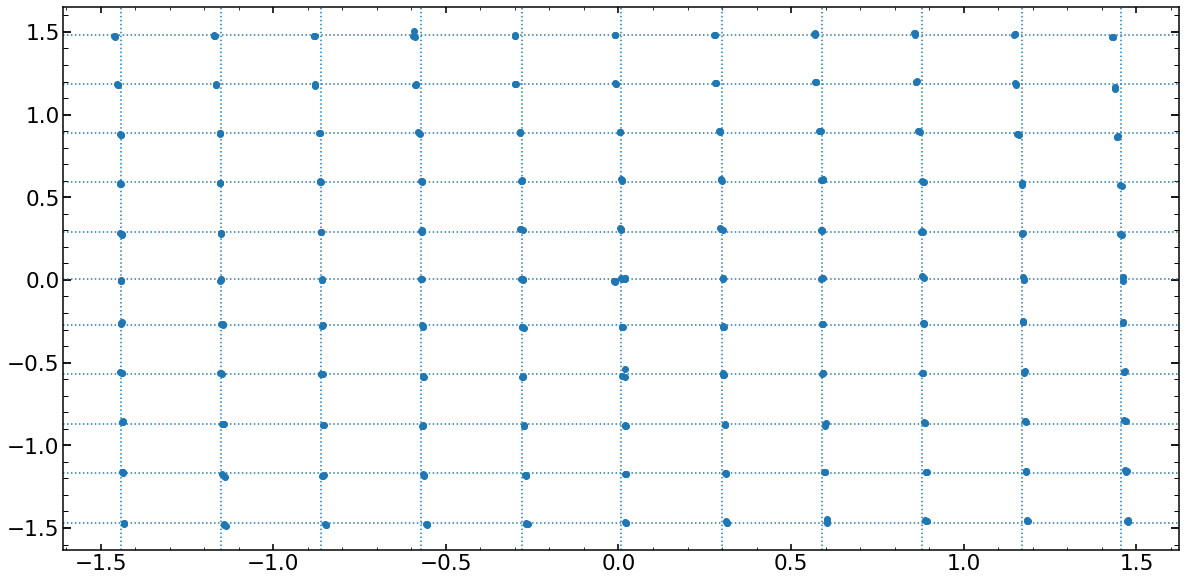

In [335]:
plt.figure(figsize=(20,10))
plt.scatter(array_of_centroid_differences[:,1],array_of_centroid_differences[:,2])
for i in range(len(y_mean_values)):
    plt.axhline(y_mean_values[i],ls=':')
    
for i in range(len(x_mean_values)):
    plt.axvline(x_mean_values[i],ls=':') 

In [336]:
dif_y=[]
for i in [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05]:
    
    array_of_centroid_differences_i=array_of_centroid_differences[(array_of_x_y_z[:,1]<i+0.001) & (array_of_x_y_z[:,1]>(i-0.001))][:,2]
    
    dif_y.append([i,np.mean(array_of_centroid_differences_i),\
    0.74*(-np.quantile(array_of_centroid_differences_i,0.25)+\
                 np.quantile(array_of_centroid_differences_i,0.75))/np.sqrt(len(array_of_centroid_differences_i)-1)])
    
dif_x=[]
for i in [-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05]:
    
    array_of_centroid_differences_i=array_of_centroid_differences[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))][:,1]
    
    dif_x.append([i,np.mean(array_of_centroid_differences_i),\
    0.74*(-np.quantile(array_of_centroid_differences_i,0.25)+
                 np.quantile(array_of_centroid_differences_i,0.75))/np.sqrt(len(array_of_centroid_differences_i)-1)])
    
dif_x=np.array(dif_x)
difx_mean=dif_x[dif_x[:,0]==0][0][1]
dif_x[:,1]=dif_x[:,1]-dif_x[dif_x[:,0]==0][0][1]
#dif_x[:,2]=np.sqrt(dif_x[:,2]**2+dif_x[dif_x[:,0]==0][0][2])

dif_y=np.array(dif_y)
dify_mean=dif_y[dif_y[:,0]==0][0][1]
dif_y[:,1]=dif_y[:,1]-dif_y[dif_y[:,0]==0][0][1]
#dif_y[:,2]=np.sqrt(dif_y[:,2]**2+dif_y[dif_y[:,0]==0][0][2])

In [337]:
difx_mean=dif_x[dif_x[:,0]==0][0][1]
dify_mean=dif_y[dif_y[:,0]==0][0][1]

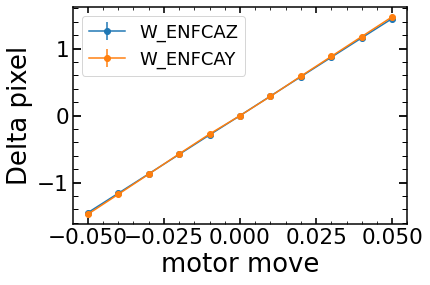

In [338]:
plt.errorbar(dif_x[:,0],dif_x[:,1],yerr=dif_x[:,2],marker='o',label='W_ENFCAZ')
plt.errorbar(dif_y[:,0],dif_y[:,1],yerr=dif_y[:,2],marker='o',label= 'W_ENFCAY')
plt.xlabel('motor move')
plt.ylabel('Delta pixel')
plt.legend()

In [339]:
y_mean_values=[]
for i in range(len(x_unique_positions)):
    y_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,1]==x_unique_positions[i]]][:,2]))
    
x_mean_values=[]
for i in range(len(y_unique_positions)):
    x_mean_values.append(np.mean(array_of_centroid_differences[np.array(range(len(array_of_x_y_z)))[array_of_x_y_z[:,2]==y_unique_positions[i]]][:,1]))

In [340]:
p1_x=np.polyfit(dif_x[:,0],dif_x[:,1],deg=1,w=dif_x[:,2]**1)
p1_y=np.polyfit(dif_y[:,0],dif_y[:,1],deg=1,w=dif_y[:,2]**1)

p1_x_grid=polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_x))
p1_y_grid=polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_y))

print(p1_x)
print(p1_y)

p1_x_to_0=np.polyfit(dif_x[:,0],dif_x[:,1]-p1_x[1],deg=1,w=dif_x[:,2]**1)
p1_y_to_0=np.polyfit(dif_y[:,0],dif_y[:,1]-p1_y[1],deg=1,w=dif_y[:,2]**1)

print(p1_x_to_0)
print(p1_y_to_0)

p1_y=np.polyfit(dif_y[:,0][2:9],dif_y[:,1][2:9],deg=1,w=dif_y[:,2][2:9]**1)
p1_y

[28.98995435  0.00084844]
[29.35282965  0.00500261]
[28.98995435  0.        ]
[29.35282965 -0.        ]


array([29.11030035,  0.00617583])

In [341]:
dif_y[:,0][2:9]

array([-0.03, -0.02, -0.01,  0.  ,  0.01,  0.02,  0.03])

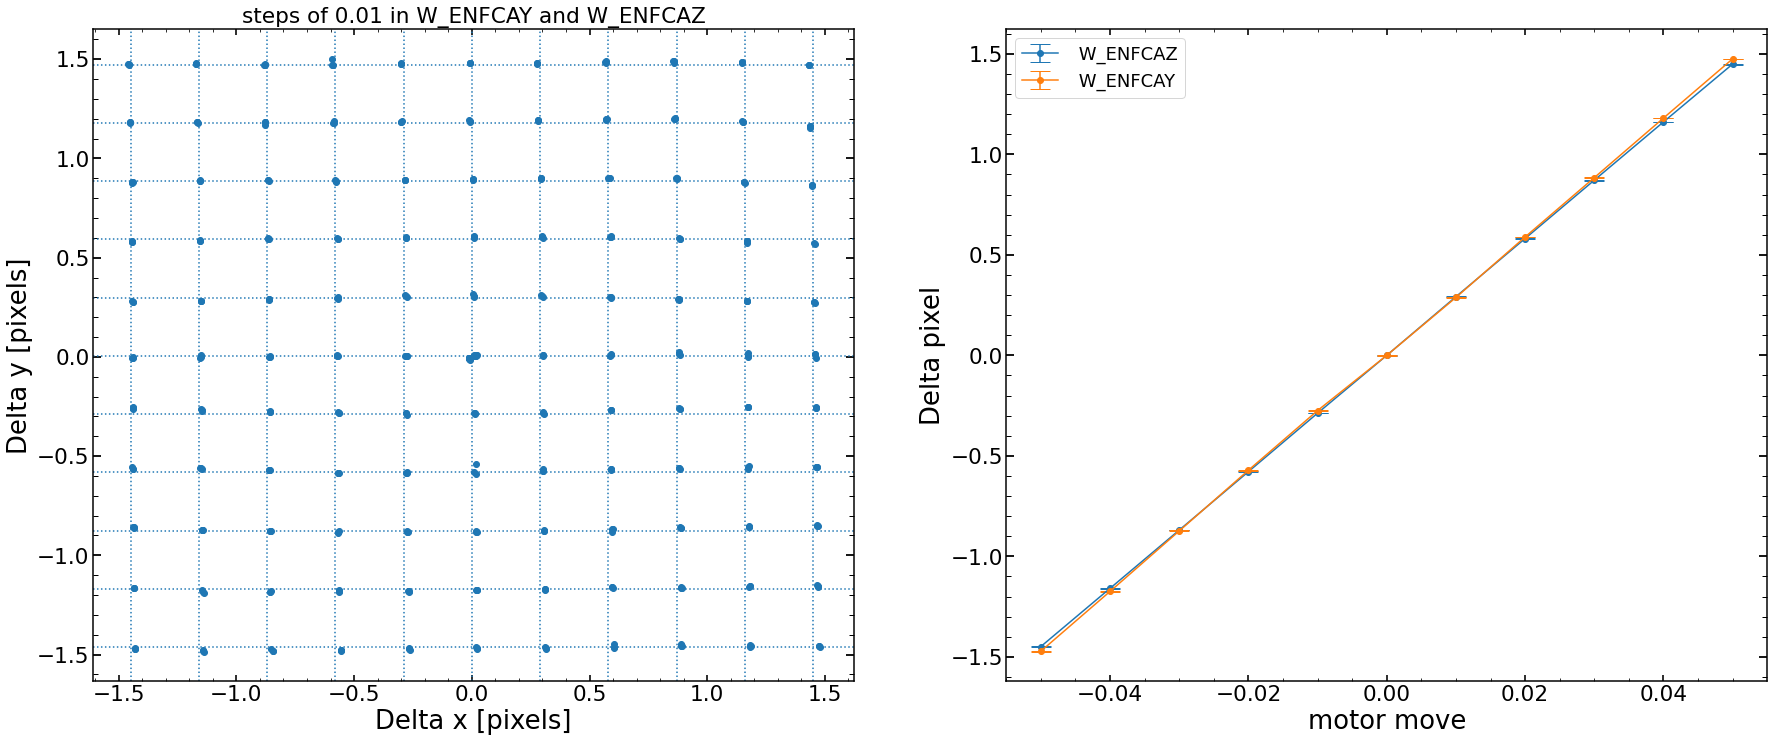

In [342]:
plt.figure(figsize=(30,12))

plt.subplot(121)
plt.title('steps of 0.01 in W_ENFCAY and W_ENFCAZ')
plt.scatter(array_of_centroid_differences[:,1]+dify_mean,array_of_centroid_differences[:,2]+difx_mean)

for i in range(len(y_mean_values)):
    plt.axhline(p1_y_grid[i],ls=':')
    
for i in range(len(x_mean_values)):
    plt.axvline(p1_x_grid[i],ls=':')    
    
    
plt.xlabel('Delta x [pixels]')
plt.ylabel('Delta y [pixels]')


plt.subplot(122)
plt.errorbar(dif_x[:,0],dif_x[:,1],yerr=dif_x[:,2],marker='o',label=' W_ENFCAZ',capsize=10)
plt.errorbar(dif_y[:,0],dif_y[:,1],yerr=dif_y[:,2],marker='o',label=' W_ENFCAY',capsize=10)
plt.xlabel('motor move')
plt.ylabel('Delta pixel')
plt.legend()


In [343]:
i=0.05
array_of_centroid_differences_i_y=array_of_centroid_differences[(array_of_x_y_z[:,1]<i+0.001) & (array_of_x_y_z[:,1]>(i-0.001))][:,2]
array_of_centroid_differences_i_x=array_of_centroid_differences[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))][:,1]

In [344]:
array_of_x_y_z[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))]

array([[ 0.    ,  0.05  ,  0.05  ],
       [ 0.    ,  0.05  ,  0.05  ],
       [ 0.    ,  0.05  ,  0.05  ],
       [-0.    ,  0.04  ,  0.05  ],
       [-0.    ,  0.04  ,  0.05  ],
       [-0.    ,  0.04  ,  0.05  ],
       [-0.    ,  0.03  ,  0.05  ],
       [-0.    ,  0.03  ,  0.05  ],
       [-0.    ,  0.03  ,  0.05  ],
       [-0.0001,  0.02  ,  0.05  ],
       [-0.0001,  0.02  ,  0.05  ],
       [-0.0001,  0.01  ,  0.05  ],
       [-0.0001,  0.01  ,  0.05  ],
       [-0.0001,  0.01  ,  0.05  ],
       [-0.0001, -0.    ,  0.05  ],
       [-0.0001, -0.    ,  0.05  ],
       [-0.0001, -0.    ,  0.05  ],
       [-0.0002, -0.01  ,  0.05  ],
       [-0.0002, -0.01  ,  0.05  ],
       [-0.0002, -0.01  ,  0.05  ],
       [-0.0002, -0.02  ,  0.05  ],
       [-0.0002, -0.02  ,  0.05  ],
       [-0.0002, -0.02  ,  0.05  ],
       [-0.0003, -0.03  ,  0.05  ],
       [-0.0003, -0.03  ,  0.05  ],
       [-0.0003, -0.03  ,  0.05  ],
       [-0.0004, -0.04  ,  0.05  ],
       [-0.0004, -0.04  ,  0

Text(0.5, 1.0, 'W_ENFCAZ=0.05')

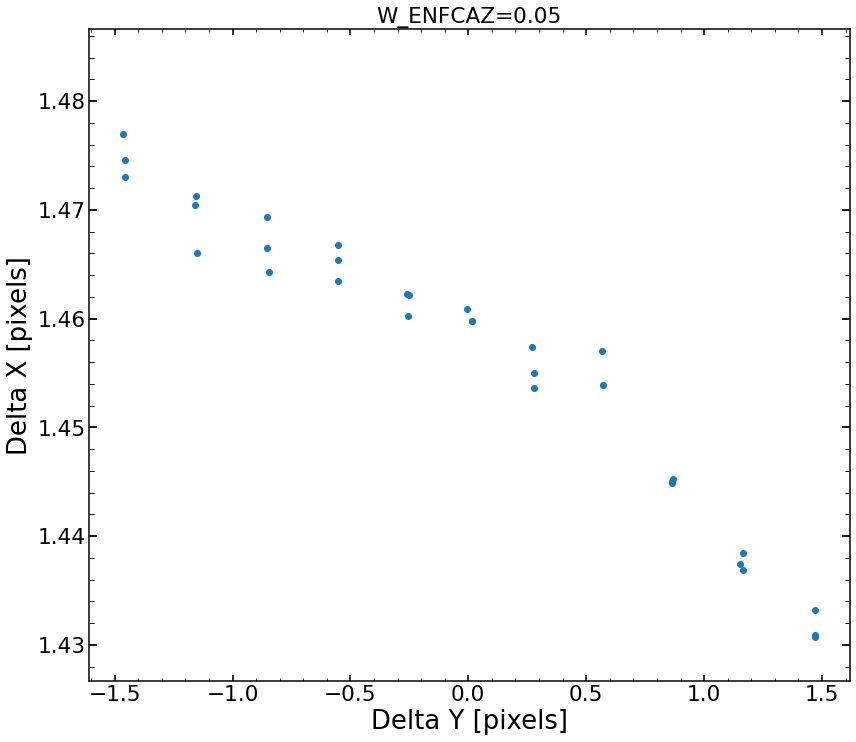

In [345]:
plt.figure(figsize=(30,12))
plt.subplot(121)
plt.plot(array_of_centroid_differences[(array_of_x_y_z[:,2]<i+0.001) & (array_of_x_y_z[:,2]>(i-0.001))][:,2],array_of_centroid_differences_i_x,marker='o',ls='')
plt.ylim(np.mean(array_of_centroid_differences_i_x)-0.03,np.mean(array_of_centroid_differences_i_x)+0.03)
plt.xlabel('Delta Y [pixels]')
plt.ylabel('Delta X [pixels]')
plt.title('W_ENFCAZ=0.05')


In [346]:
from numpy.polynomial.polynomial import polyval

In [355]:
np.sum((polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_x))-dif_x[:,1])**2/(dif_x[:,2])**2)/(len([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])-2)

0.37949775889465526

In [356]:
np.sum((polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_y))-dif_y[:,1])**2/(dif_y[:,2])**2)/(len([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05])-2)

46.39423702239933

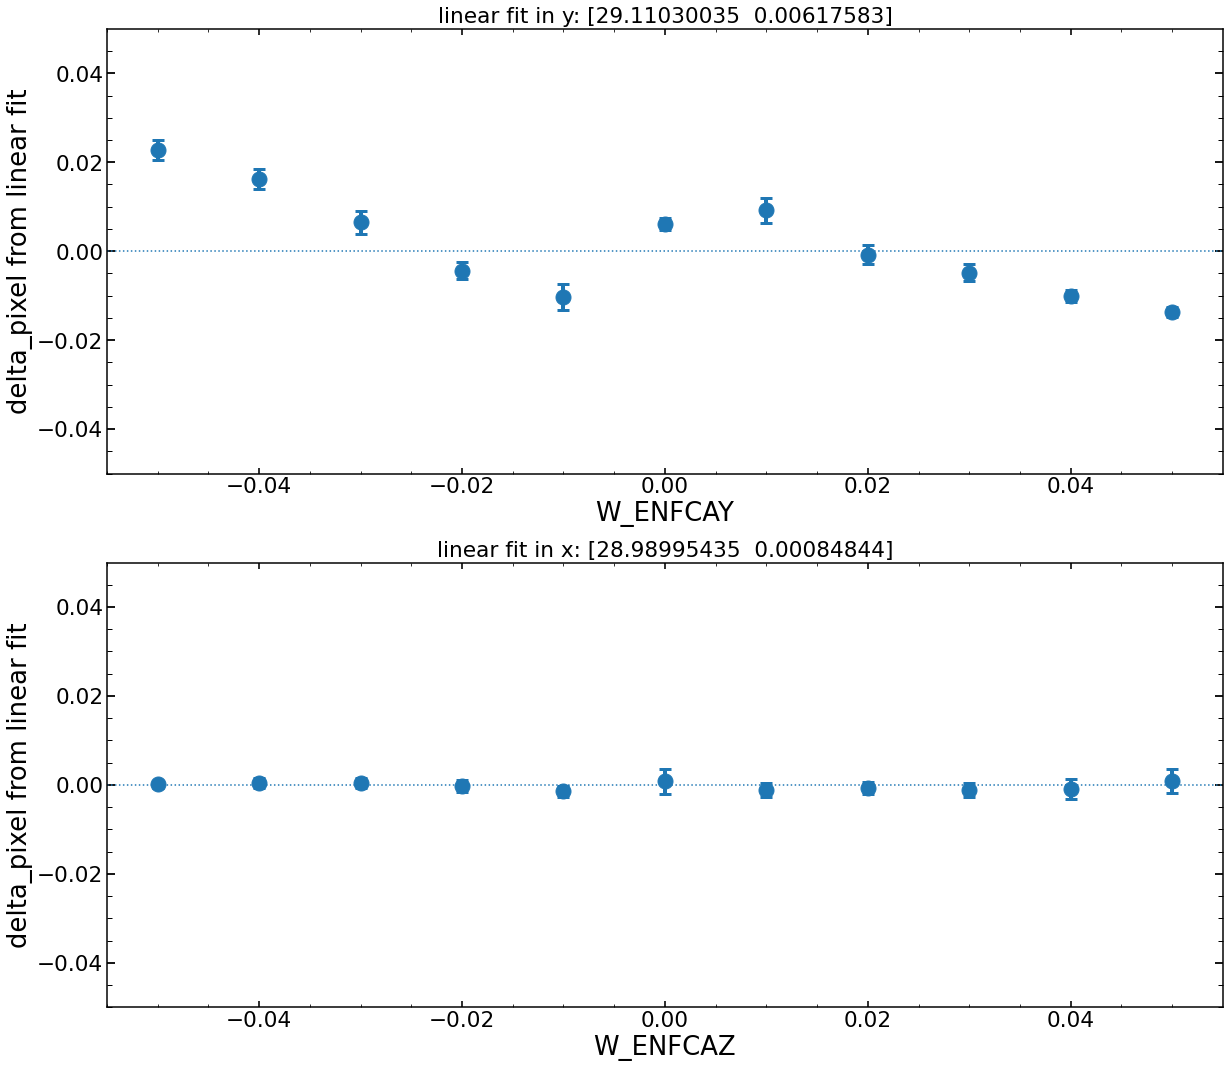

In [354]:
plt.figure(figsize=(20,18))

plt.subplot(211)
plt.errorbar([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],\
             polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_y))-dif_y[:,1],
            yerr=dif_y[:,2],capsize=6,capthick=3,fmt='o',elinewidth=4,ms=15)

plt.xlabel("W_ENFCAY")
plt.ylabel("delta_pixel from linear fit")
plt.title('linear fit in y: '+str(p1_y))
plt.ylim(-0.05,0.05)
plt.axhline(0,ls=':')

plt.subplot(212)

plt.errorbar([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],\
             polyval([-0.05,-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04,0.05],np.flip(p1_x))-dif_x[:,1],
            yerr=dif_x[:,2],capsize=6,capthick=3,fmt='o',elinewidth=4,ms=15)

plt.xlabel("W_ENFCAZ")
plt.ylabel("delta_pixel from linear fit")
plt.title('linear fit in x: '+str(p1_x))
plt.ylim(-0.05,0.05)
plt.axhline(0,ls=':')

# 7x7 wavefront 

In [ ]:
wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  

In [162]:
finalHgAr_Feb2020_dataset

fiber    xc    yc wavelength close  lamp xc_effective second_offset  \
0       2    69   808   690.9346     0  HgAr           69        -19.25   
1       2    69   875   696.7261     1  HgAr           69             0   
2       2    70   992   706.8989     0  HgAr           70         16.93   
3       2    71  1229  727.47876     1  HgAr           71             0   
4       2    72  1358   738.6248     0  HgAr           72        -13.14   
..    ...   ...   ...        ...   ...   ...          ...           ...   
115   650  4002  2379   826.6699   0.5  HgAr         4071         18.83   
116   650  4003  2681   852.4029   0.5  HgAr         4072        -14.26   
117   650  4008  3393   912.5693     1  HgAr         4077             0   
118   650  4009  3515   922.7301     0  HgAr         4078         22.44   
119   650  4016  4044   966.0642     1  HgAr         4085             0   

    second_ratio second2_offset second2_ratio  
0         0.0034          -40.7         0.006  
1              0              0             0  
2          0.268          28.33         0.088  
3              0              0             0  
4          0.011              0             0  
..           ...            ...           ...  
115       0.0043              0             0  
116        0.015              0             0  
117            0              0             0  
118        0.022         -13.14         0.011  
119            0              0             0  

[120 rows x 11 columns]

In [156]:
with open('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-625 (frd)/Parameters_21.pkl', 'rb') as f:
    Parameters_21=pickle.load(f)
    
with open('/Users/nevencaplar/Documents/PFS/Tickets/PIPE2D-625 (frd)/Parameters_24.pkl', 'rb') as f:
    Parameters_24=pickle.load(f)

In [157]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
                          'z12','z13','z14','z15','z16','z17','z18','z19','z20','z21','z22', 
              'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
              'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
              'x_fiber','y_fiber','effective_ilum_radius','frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
              'grating_lines','scattering_slope','scattering_amplitude',
              'pixel_effect','fiber_r','flux']    

In [158]:
for i in range(len(Parameters_21)):
    Parameters_21[i][-2]=1.8
    Parameters_21[i][-3]=0.37   
    Parameters_21[i][-6]=100000  
    Parameters_21[i][-5]=2.45
    Parameters_21[i][-4]=0.00266
    
    Parameters_24[i][-2]=1.8
    Parameters_24[i][-3]=0.37   
    Parameters_24[i][-6]=100000  
    Parameters_24[i][-5]=2.45
    Parameters_24[i][-4]=0.00266

In [159]:
model = LN_PFS_single(np.ones((20,20)),np.ones((20,20)),mask_image=np.ones((20,20)),dithering=1,save=1,zmax=22,verbosity=0,\
                     double_sources=None,double_sources_positions_ratios=[0,0],fit_for_flux=True,npix=1536,simulation_00=True)  

In [446]:
# 13 min
list_of_dif_residuals_24_21=[]
list_of_21=[]
list_of_24=[]

wavefront_values_HgAr=[]
list_of_wf_grid_HgAr=[]
list_of_wf_grid_HgAr_0=[]

for i in tqdm(range(120)):
    res_with_Image_21=model(Parameters_21[i],return_Image=True)[1]
    optPsf_cut_grating_convolved_21=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy')  
    list_of_wf_grid_HgAr.append(wf_grid)
    
    wavefront_values_HgAr.append([single_number,np.max(wf_grid[np.abs(wf_grid)>0]),np.min(wf_grid[np.abs(wf_grid)>0]),\
                                  np.mean(wf_grid[np.abs(wf_grid)>0]),np.median(wf_grid[np.abs(wf_grid)>0]),np.std(wf_grid[np.abs(wf_grid)>0])])
    
    minchain_0=np.copy(Parameters_21[i])
    minchain_0[19]=0
    minchain_0[20]=0
    minchain_0[23]=0
    model(minchain_0,return_Image=True)
    wf_grid=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_grid.npy') 
    list_of_wf_grid_HgAr_0.append(wf_grid)
 
 
    
    
    
    """
    res_with_Image_24=model(Parameters_24[i],return_Image=True)[1]
    optPsf_cut_grating_convolved_24=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')


    single_Psf_position=Psf_position(optPsf_cut_grating_convolved_21, int(round(9)),20 ,
                                     double_sources=False,double_sources_positions_ratios=[0,0],
                                                                           verbosity=1)    
    
    optPsf_cut_grating_convolved_21_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_21,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)
    optPsf_cut_grating_convolved_24_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_24,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)

    print(find_centroid_of_flux(optPsf_cut_grating_convolved_24_cut))
    print(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))


    shift_array=np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_24_cut))-np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))
    print(shift_array)

    optPsf_cut_grating_convolved_24_shifted=scipy.ndimage.interpolation.shift(optPsf_cut_grating_convolved_24,-np.flip(shift_array),mode='nearest')
    
    optPsf_cut_grating_convolved_21_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_21,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)
    optPsf_cut_grating_convolved_24_shifted_cut=Psf_position.cut_Centroid_of_natural_resolution_image(image=optPsf_cut_grating_convolved_24_shifted,size_natural_resolution=9*20,oversampling=1,dx=0,dy=0)

    optPsf_cut_grating_convolved_21_cut.shape
    print(find_centroid_of_flux(optPsf_cut_grating_convolved_24_shifted_cut))
    print(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))


    shift_array_after_first_attempt=np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_24_shifted_cut))-np.array(find_centroid_of_flux(optPsf_cut_grating_convolved_21_cut))
    print(shift_array_after_first_attempt)
    
    optPsf_cut_grating_convolved_24_shifted_cut_20_20=resize(optPsf_cut_grating_convolved_24_shifted_cut,(20,20))
    optPsf_cut_grating_convolved_21_cut_20_20=resize(optPsf_cut_grating_convolved_21_cut,(20,20))

    optPsf_cut_grating_convolved_24_shifted_cut_20_20=optPsf_cut_grating_convolved_24_shifted_cut_20_20*50000/np.max(optPsf_cut_grating_convolved_24_shifted_cut_20_20)
    optPsf_cut_grating_convolved_21_cut_20_20=optPsf_cut_grating_convolved_21_cut_20_20*np.sum(optPsf_cut_grating_convolved_24_shifted_cut_20_20)/np.sum(optPsf_cut_grating_convolved_21_cut_20_20)
    list_of_21.append(optPsf_cut_grating_convolved_21_cut_20_20)
    list_of_24.append(optPsf_cut_grating_convolved_24_shifted_cut_20_20)
    list_of_dif_residuals_24_21.append(optPsf_cut_grating_convolved_21_cut_20_20-optPsf_cut_grating_convolved_24_shifted_cut_20_20)
    """
    
wavefront_values_HgAr=np.array(wavefront_values_HgAr)

  0%|                                                                                                                | 0/120 [00:00<?, ?it/s]/Users/nevencaplar/anaconda2/envs/idp2_pyfftw/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [06:42<00:00,  3.36s/it]


In [173]:
finalHgAr=finalHgAr_Feb2020_dataset

In [327]:
finalHgAr_7_7=[]
for i in range(len(finalHgAr)):

    if finalHgAr['fiber'][i] in [2,192,255,401,464,587,650]:
        if finalHgAr['wavelength'][i] in ['690.9346','738.6248','763.74286','795.0522','852.4029','912.5693','966.0642']:
            finalHgAr_7_7.append(i)
        
finalHgAr_7_7

[0,
 4,
 5,
 6,
 8,
 9,
 11,
 24,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 40,
 41,
 42,
 44,
 45,
 47,
 60,
 64,
 65,
 66,
 68,
 69,
 71,
 72,
 76,
 77,
 78,
 80,
 81,
 83,
 96,
 100,
 101,
 102,
 104,
 105,
 107,
 108,
 112,
 113,
 114,
 116,
 117,
 119]

In [332]:
finalHgAr.loc[2]

fiber                    2
xc                      70
yc                     992
wavelength        706.8989
close                    0
lamp                  HgAr
xc_effective            70
second_offset        16.93
second_ratio         0.268
second2_offset       28.33
second2_ratio        0.088
Name: 2, dtype: object

In [251]:
finalHgAr_sorted=finalHgAr.sort_values(by=['wavelength','fiber' ], ascending=[False,True])

In [361]:
len(finalHgAr_sorted)

120

In [341]:
finalHgAr_7_7

[0,
 4,
 5,
 6,
 8,
 9,
 11,
 24,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 40,
 41,
 42,
 44,
 45,
 47,
 60,
 64,
 65,
 66,
 68,
 69,
 71,
 72,
 76,
 77,
 78,
 80,
 81,
 83,
 96,
 100,
 101,
 102,
 104,
 105,
 107,
 108,
 112,
 113,
 114,
 116,
 117,
 119]

In [345]:
list_of_HgAr_sorted2

[11,
 59,
 71,
 83,
 107,
 119,
 22,
 57,
 105,
 117,
 8,
 32,
 44,
 68,
 80,
 7,
 19,
 31,
 55,
 67,
 91,
 5,
 53,
 65,
 77,
 101,
 113,
 16,
 28,
 76,
 88,
 100,
 3,
 15,
 39,
 74,
 1,
 13,
 25,
 49,
 61,
 85,
 97,
 24,
 36,
 48,
 72,
 84,
 108]

In [288]:
list_of_HgAr_sorted=[]
for i in range(len(finalHgAr_7_7)):
    list_of_HgAr_sorted.append(np.where(np.array((finalHgAr_sorted.index))==finalHgAr_7_7[i])[0][0])

In [362]:
list_of_HgAr_sorted2=[]
for i in range(len(finalHgAr_sorted)):
    if finalHgAr_sorted.index[i] in finalHgAr_7_7:
        print(i)
        list_of_HgAr_sorted2.append(finalHgAr_sorted.index[i])

0
2
3
5
6
8
9
20
22
23
25
26
28
29
30
32
33
35
36
38
39
50
52
53
55
56
58
59
60
62
63
65
66
68
69
70
72
73
75
76
78
79
110
112
113
115
116
118
119


In [365]:
list_of_HgAr_sorted2

[11,
 35,
 47,
 71,
 83,
 107,
 119,
 9,
 33,
 45,
 69,
 81,
 105,
 117,
 8,
 32,
 44,
 68,
 80,
 104,
 116,
 6,
 30,
 42,
 66,
 78,
 102,
 114,
 5,
 29,
 41,
 65,
 77,
 101,
 113,
 4,
 28,
 40,
 64,
 76,
 100,
 112,
 0,
 24,
 36,
 60,
 72,
 96,
 108]

In [354]:
if finalHgAr_sorted.index[0] in finalHgAr_7_7:
    print(True)

True


In [352]:
finalHgAr_7_7

[0,
 4,
 5,
 6,
 8,
 9,
 11,
 24,
 28,
 29,
 30,
 32,
 33,
 35,
 36,
 40,
 41,
 42,
 44,
 45,
 47,
 60,
 64,
 65,
 66,
 68,
 69,
 71,
 72,
 76,
 77,
 78,
 80,
 81,
 83,
 96,
 100,
 101,
 102,
 104,
 105,
 107,
 108,
 112,
 113,
 114,
 116,
 117,
 119]

In [242]:
# plot the results of the interpolation
zMax=22
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
date='Dec17'


# take values for HgAr
x_HgAr=finalHgAr['xc_effective'].values[list_of_HgAr_sorted2]
y_HgAr=finalHgAr['yc'].values[list_of_HgAr_sorted2]
values_HgAr_RMS=wavefront_values_HgAr[:,5][list_of_HgAr_sorted2]
values_HgAr_max_min=wavefront_values_HgAr[:,1].astype(float)[list_of_HgAr_sorted2]-wavefront_values_HgAr[:,2].astype(float)[list_of_HgAr_sorted2]
values_HgAr_mean=wavefront_values_HgAr[:,4][list_of_HgAr_sorted2]

In [243]:
finalHgAr.loc[finalHgAr_7_7].shape

(49, 11)

In [244]:

# join these values
#x=np.concatenate((x_HgAr,x_Ne,x_Kr))
#y=np.concatenate((y_HgAr,y_Ne,y_Kr))    
#colors_RMS= np.concatenate((values_HgAr_RMS,values_Ne_RMS,values_Kr_RMS))
#colors_max_min= np.concatenate((values_HgAr_max_min,values_Ne_max_min,values_Kr_max_min))
#colors_mean= np.concatenate((values_HgAr_mean,values_Ne_mean,values_Kr_mean))


x=x_HgAr
y=y_HgAr
colors_RMS= values_HgAr_RMS.astype(float)
colors_max_min= values_HgAr_max_min.astype(float)
colors_mean= values_HgAr_mean.astype(float)


min_colors_RMS=np.quantile(colors_RMS,0.1)
max_colors_RMS=np.quantile(colors_RMS,0.9)
min_colors_max_min=np.quantile(colors_max_min,0.1)
max_colors_max_min=np.quantile(colors_max_min,0.9)
min_colors_mean=np.quantile(colors_mean,0.1)
max_colors_mean=np.quantile(colors_mean,0.9)
abs_colors_mean=np.max([np.abs(min_colors_mean),np.abs(max_colors_mean)])

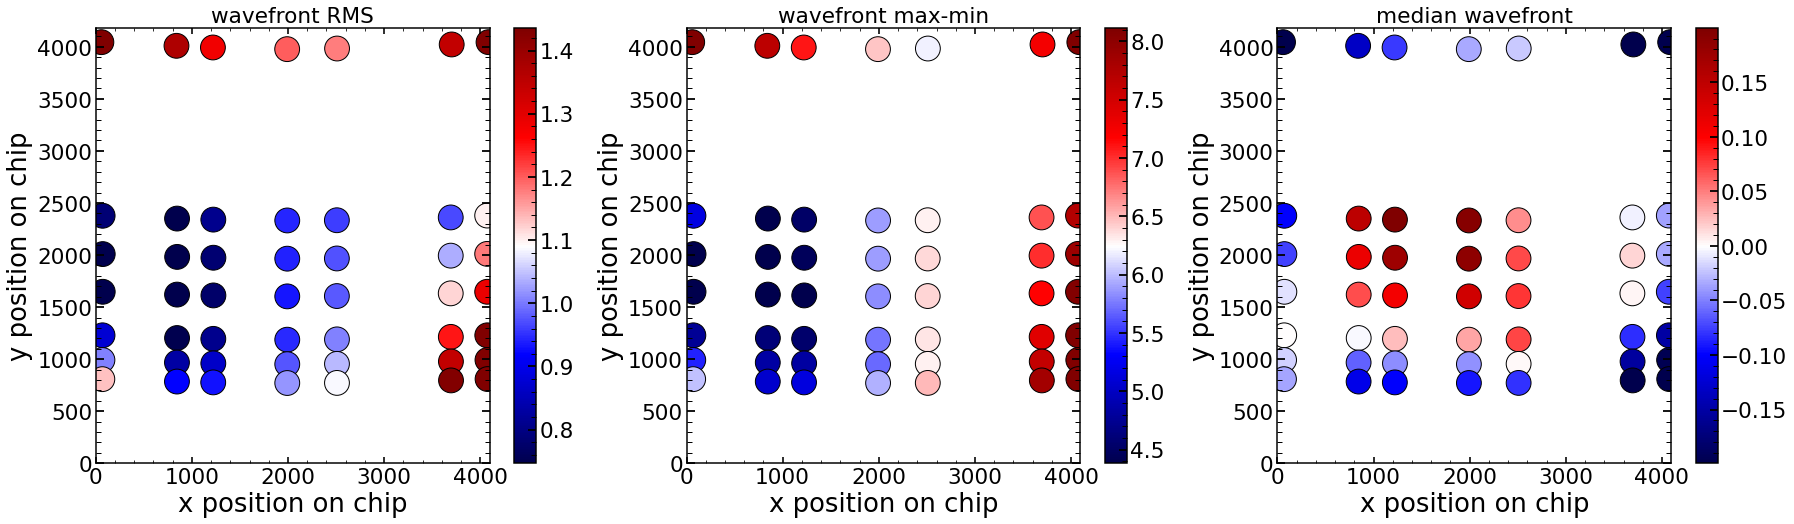

In [245]:
matplotlib.rcParams.update({'font.size': 18})


plt.figure(figsize=(30,8))

plt.subplot(131)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=colors_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='o')
#plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='s')
#plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_RMS, cmap='seismic', alpha=1,vmin=min_colors_RMS, vmax=max_colors_RMS,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront RMS')
plt.colorbar()


plt.subplot(132)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=colors_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='o')
#plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='s')
#plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_max_min, cmap='seismic', alpha=1,vmin=min_colors_max_min, vmax=max_colors_max_min,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('wavefront max-min')
plt.colorbar()

plt.subplot(133)

plt.scatter(x_HgAr, y_HgAr, s=np.pi * (14 * 1)**2, c=colors_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='o')
#plt.scatter(x_Ne, y_Ne, s=np.pi * (10 * 1)**2, c=values_Ne_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='s')
#plt.scatter(x_Kr, y_Kr, s=np.pi * (14 * 1)**2, c=values_Kr_mean, cmap='seismic', alpha=1,vmin=-abs_colors_mean, vmax=abs_colors_mean,edgecolor='black',marker='p')
plt.ylim(0,4176)
plt.xlim(0,4096)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('median wavefront')
plt.colorbar()

In [322]:
finalHgAr.iloc[11]

fiber                    2
xc                      59
yc                    4044
wavelength        966.0642
close                    1
lamp                  HgAr
xc_effective            59
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 11, dtype: object

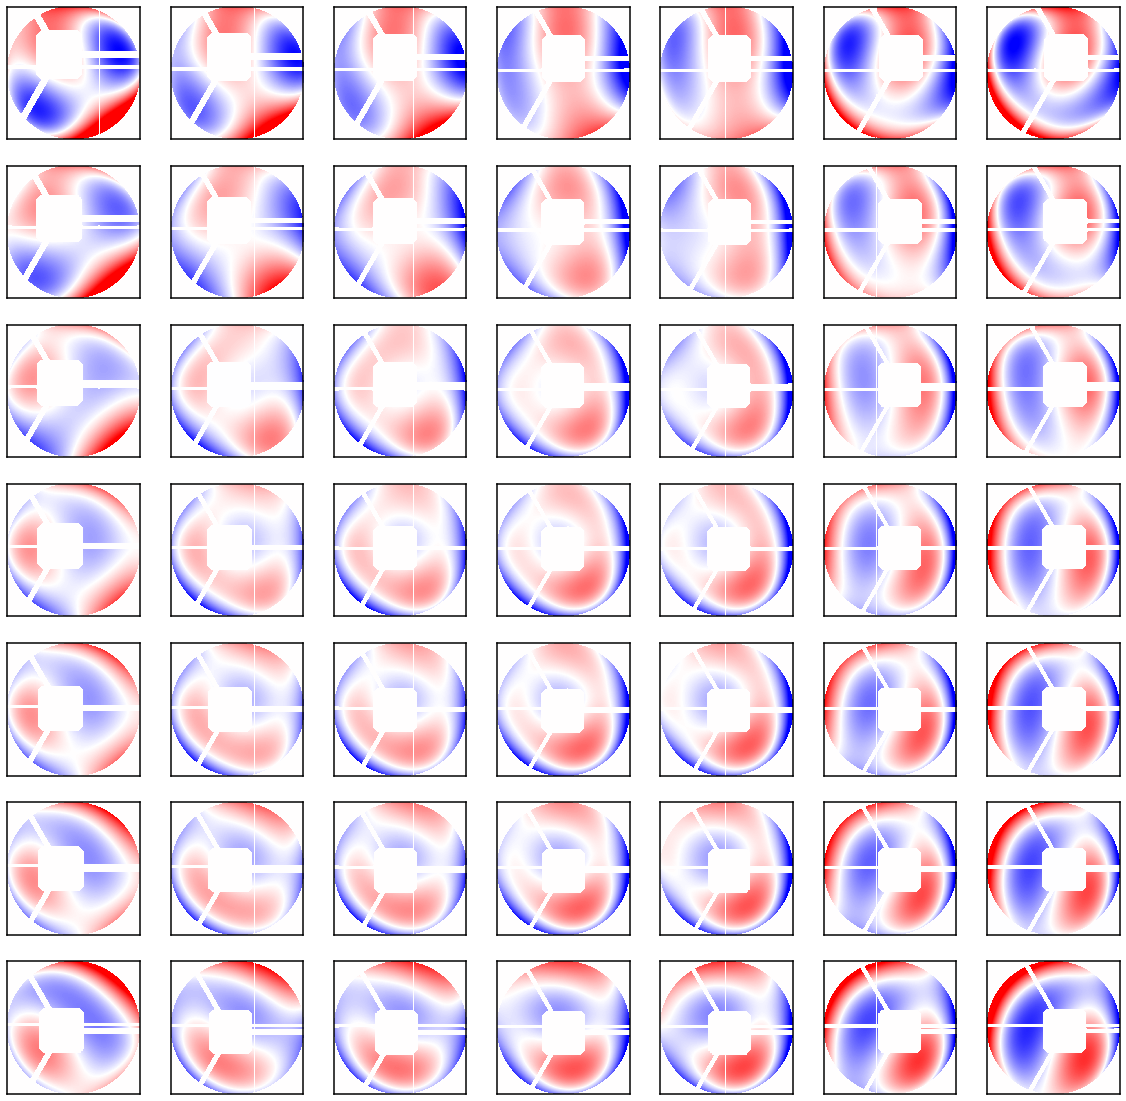

In [447]:
plt.figure(figsize=(20,20))
for x_i in range(7):
    for y_i in range(7):      
        plt.subplot(7,7,x_i*7+y_i+1)
        wavefront=list_of_wf_grid_HgAr[list_of_HgAr_sorted2[x_i*7+y_i]][768:2304,768:2304]
        plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')


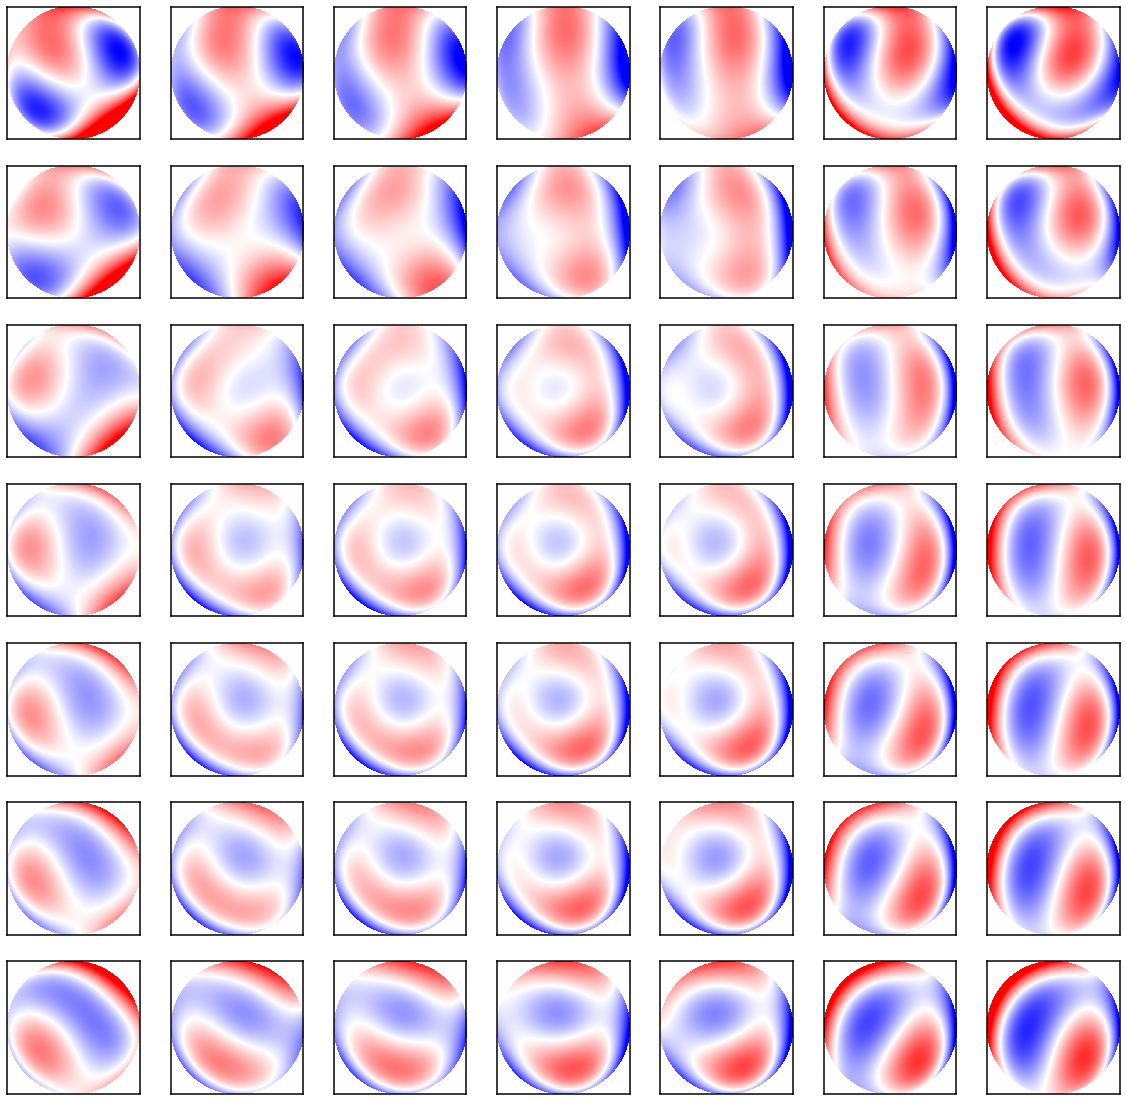

In [412]:
plt.figure(figsize=(20,20))
for x_i in range(7):
    for y_i in range(7):      
        plt.subplot(7,7,x_i*7+y_i+1)
        wavefront=list_of_wf_grid_HgAr_0[list_of_HgAr_sorted2[x_i*7+y_i]][768:2304,768:2304]
        plt.imshow(wavefront,cmap=plt.get_cmap('bwr'),vmax=3,vmin=-3)
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='minor')
        plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False,which='major')



In [212]:
int(1536-1536/2)

768

# Fake spot 

## Creation 

In [552]:
#date='Jul2020'
date='Sep1320'
obs=21400
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
obs_int=int(obs)
single_number='37'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

### fake dataset

In [596]:
finalHgAr_Feb2020_dataset.loc[120]=finalHgAr_Feb2020_dataset.loc[37].values

In [592]:
finalHgAr_Feb2020_dataset

fiber    xc    yc wavelength close  lamp xc_effective second_offset  \
0       2    69   808   690.9346     0  HgAr           69        -19.25   
1       2    69   875   696.7261     1  HgAr           69             0   
2       2    70   992   706.8989     0  HgAr           70         16.93   
3       2    71  1229  727.47876     1  HgAr           71             0   
4       2    72  1358   738.6248     0  HgAr           72        -13.14   
..    ...   ...   ...        ...   ...   ...          ...           ...   
116   650  4003  2681   852.4029   0.5  HgAr         4072        -14.26   
117   650  4008  3393   912.5693     1  HgAr         4077             0   
118   650  4009  3515   922.7301     0  HgAr         4078         22.44   
119   650  4016  4044   966.0642     1  HgAr         4085             0   
120   255  1223   843   696.7261     1  HgAr         1223             0   

    second_ratio second2_offset second2_ratio  
0         0.0034          -40.7         0.006  
1              0              0             0  
2          0.268          28.33         0.088  
3              0              0             0  
4          0.011              0             0  
..           ...            ...           ...  
116        0.015              0             0  
117            0              0             0  
118        0.022         -13.14         0.011  
119            0              0             0  
120            0              0             0  

[121 rows x 11 columns]

In [597]:
finalHgAr_Feb2020_dataset.to_pickle("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/finalHgAr_Feb2020_dataset.pkl")

In [598]:
finalHgAr_Feb2020_dataset_test=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/finalHgAr_Feb2020_dataset.pkl",allow_pickle=True)

### fake sci_var_mask data

In [56]:
for i in range(9):
    if i==0:
        obs_name=21352
    if i==1:
        obs_name=21358
    if i==2:
        obs_name=21364
        
    if i==3:
        obs_name=21394
    if i==4:
        obs_name=21400
    if i==5:
        obs_name=21406
        
    if i==6:
        obs_name=21436
    if i==7:
        obs_name=21442
    if i==8:
        obs_name=21448
    
    sci_name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned_fake/sci'+str(obs_name)+'120HgAr_Stacked'
    var_name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned_fake/var'+str(obs_name)+'120HgAr_Stacked'
    mask_name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned_fake/mask'+str(obs_name)+'120HgAr_Stacked'
    
    np.save(sci_name,list_of_single_model_image[i])
    np.save(var_name,list_of_var_images[i])
    np.save(mask_name,list_of_mask_images[i])

In [188]:
len(list_of_mask_images)

9

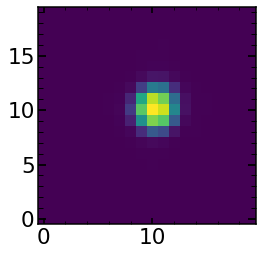

In [55]:
plt.imshow(np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Stamps_cleaned/sci2140037HgAr_Stacked.npy'))

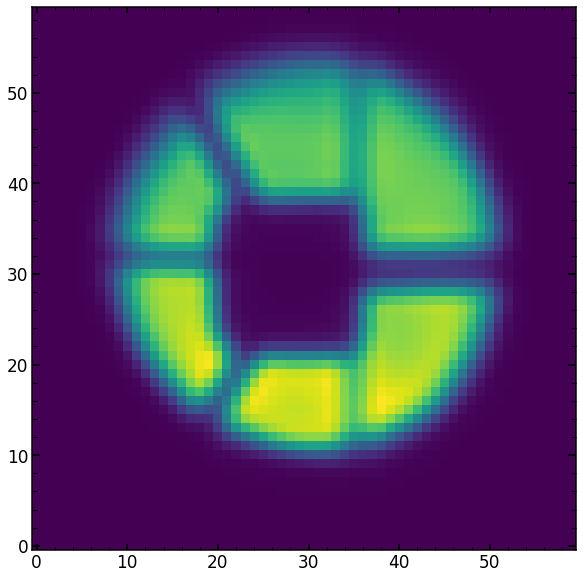

In [568]:
plt.imshow(list_of_single_model_image[0])

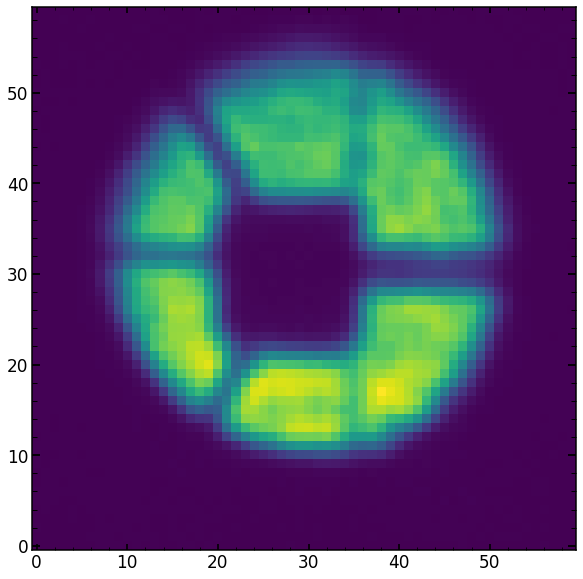

In [569]:
plt.imshow(list_of_sci_images[0])

### fake proposals

In [19]:
# proposal number 1 - fake proposal which is acctually the starrting point from zmax==22, Mar 06 data
twentytwo_or_extra=56
results_of_fit_input=np.load('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/results_of_fit_many_interpolation_HgAr_from_Mar06.pkl',allow_pickle=True)


list_of_allparameters=[]
list_of_defocuses=[]
for label in ['m4','m35','m3','m05','0','p05','p3','p35','p4']:
    try:
        list_of_allparameters.append(results_of_fit_input[label].loc[int(single_number)].values)
        list_of_defocuses.append(label)
    except:
        pass
    
array_of_allparameters=np.array(list_of_allparameters)

print('array_of_allparameters.shape: '+str(array_of_allparameters.shape))
print('twentytwo_or_extra: '+str(twentytwo_or_extra))
array_of_polyfit_1_parameterizations_proposal=model_multi.create_resonable_allparameters_parametrizations(array_of_allparameters=array_of_allparameters,\
                                                            list_of_defocuses_input=list_of_defocuses,zmax=twentytwo_or_extra,remove_last_n=2)

# lets be explicit that the shape of the array is 2d
array_of_polyfit_1_parameterizations_proposal_shape_2d=array_of_polyfit_1_parameterizations_proposal

array_of_allparameters.shape: (5, 44)
twentytwo_or_extra: 56


In [22]:
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_1',array_of_polyfit_1_parameterizations_proposal_shape_2d)

In [ ]:
# proposal number 2 - same as number 1 but one of parameters (z5) large offset 

In [26]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2=np.copy(array_of_polyfit_1_parameterizations_proposal_shape_2d)

In [27]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2[1][0]=-0.1
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2[1][1]=-0.8747

In [29]:
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2',array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_2)

In [ ]:
# proposal number 3 - small offsets from Zernike 56 result that is ``correct result''

In [ ]:
array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_3

In [40]:
np.random.seed(420)
random_array=(np.random.rand(len(minchain_parametrization))/5+1)

array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_3=minchain_parametrization*(np.random.rand(len(minchain_parametrization))/5+1)

In [75]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3=\
model_multi.move_parametrizations_from_1d_to_2d(array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_3)
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3[41][1]=1
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3',\
        array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3)

In [ ]:
# proposal number 4 -  one of parameters (z5) large offset 

In [76]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4=np.copy(array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_3)

In [77]:
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4[1][0]=-0.1
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4[1][1]=-0.8747
array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4[41][1]=1

In [78]:

np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4',\
        array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_4)

In [ ]:
## proposal 5 - like proposal 3, but only change wavefront 

In [682]:
np.random.seed(420)
random_array=(np.random.rand(len(minchain_parametrization))/5+1)

array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_5=minchain_parametrization*(np.random.rand(len(minchain_parametrization))/5+1)

In [692]:
array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_5[19*2:19*2+23]=minchain_parametrization[19*2:19*2+23]

array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_5=\
model_multi.move_parametrizations_from_1d_to_2d(array_of_polyfit_1_parameterizations_proposal_shape_1d_proposal_5)

In [693]:
np.save('/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes_fake/array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_5',\
        array_of_polyfit_1_parameterizations_proposal_shape_2d_proposal_5)

## Analysis 

### proposal 1 

In [171]:
chain0_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1620/chainSep1620_Single_P_214481216HgArSwarm1.npy')
likechain_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1620/likechainSep1620_Single_P_214481216HgArSwarm1.npy')

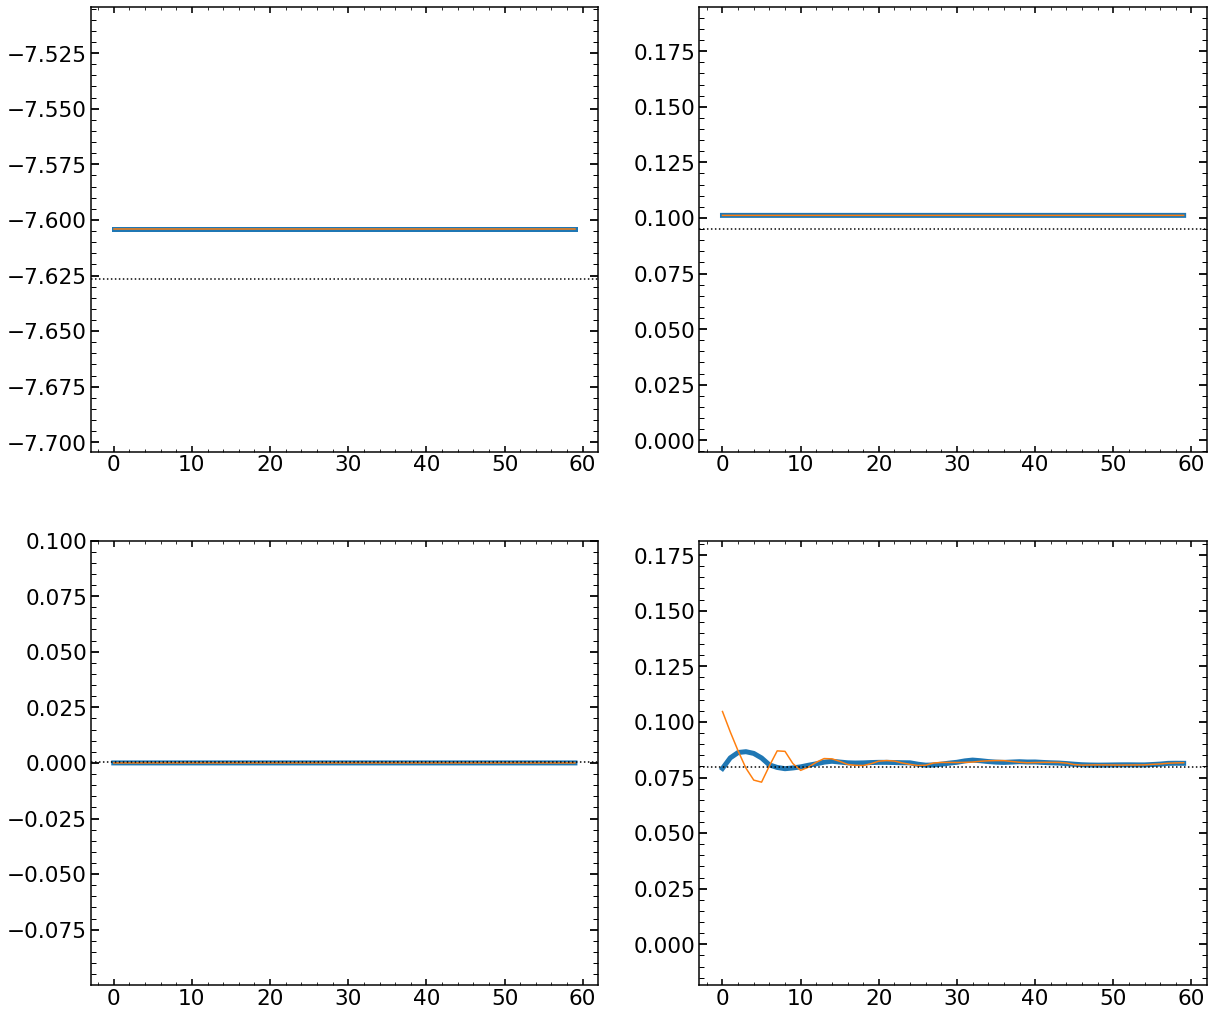

In [172]:
# wavefront paramter
plt.figure(figsize=(20,18))
i=0*2
plt.subplot(221)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,78][:,i],lw=5)
plt.plot(chain0_swarm_1[:,28][:,i])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[0],ls=':',color='black')

plt.subplot(222)
#  paramter 2 (z5)

#mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,78][:,2],lw=5)
plt.plot(chain0_swarm_1[:,28][:,2])

plt.ylim(minchain_parametrization[2]-0.1,minchain_parametrization[2]+0.1)
plt.axhline(minchain_parametrization[2],ls=':',color='black')

plt.subplot(223)
# two different walkers, parameter 89
plt.plot(chain0_swarm_1[:,78][:,89],lw=5)
plt.plot(chain0_swarm_1[:,28][:,89])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,89])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[89],ls=':',color='black')

plt.subplot(224)
# two different walkers, parameter 89
plt.plot(chain0_swarm_1[:,78][:,19*2+1],lw=5)
plt.plot(chain0_swarm_1[:,28][:,19*2+1])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,19*2+1])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[19*2+1],ls=':',color='black')

### proposal 2 

In [126]:
chain0_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1620/chainSep1620_Single_P_214481226HgArSwarm1.npy')
likechain_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1620/likechainSep1620_Single_P_214481226HgArSwarm1.npy')

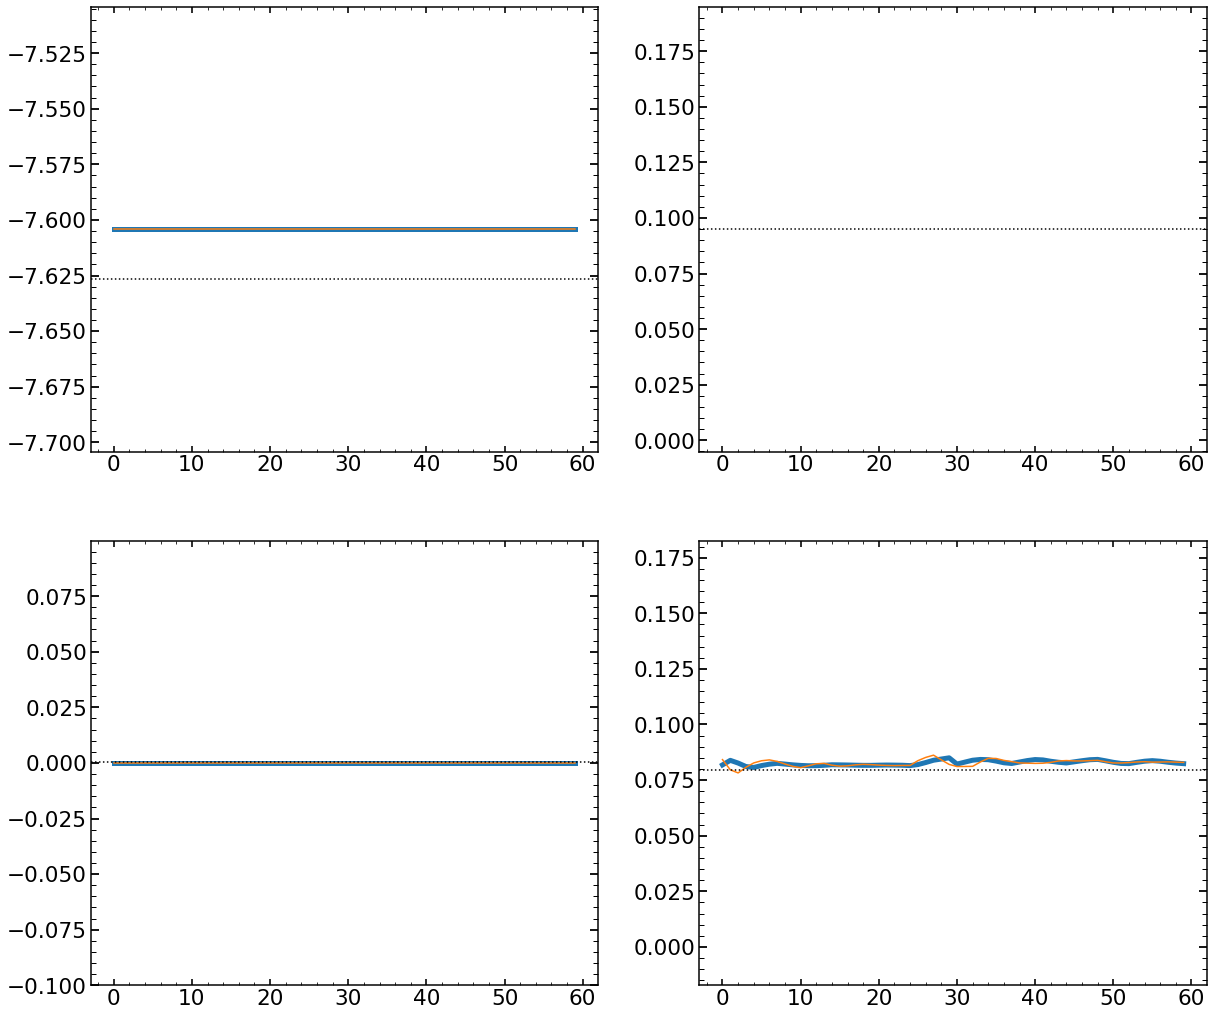

In [127]:
# wavefront paramter
plt.figure(figsize=(20,18))
i=0*2
plt.subplot(221)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,78][:,i],lw=5)
plt.plot(chain0_swarm_1[:,28][:,i])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[0],ls=':',color='black')

plt.subplot(222)
#  paramter 2 (z5)

#mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,78][:,2],lw=5)
plt.plot(chain0_swarm_1[:,28][:,2])

plt.ylim(minchain_parametrization[2]-0.1,minchain_parametrization[2]+0.1)
plt.axhline(minchain_parametrization[2],ls=':',color='black')

plt.subplot(223)
# two different walkers, parameter 89
plt.plot(chain0_swarm_1[:,78][:,89],lw=5)
plt.plot(chain0_swarm_1[:,28][:,89])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,89])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[89],ls=':',color='black')

plt.subplot(224)
# two different walkers, parameter 89
plt.plot(chain0_swarm_1[:,78][:,19*2+1],lw=5)
plt.plot(chain0_swarm_1[:,28][:,19*2+1])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,19*2+1])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[19*2+1],ls=':',color='black')

In [128]:
# Initial run: 
"""
################################
Likelihoods returned per individual images are: [-43454.5078125  -32397.52929688 -24454.15625     -2161.14697266
  -1645.0378418   -1857.3404541  -33437.3671875  -47186.5859375
 -58806.8046875 ]
Mean likelihood is -27266.719604492188
################################
Renormalized likelihoods returned per individual images are: [-3568.40913747 -3770.52184893 -4310.99933026 -1983.2083398
 -1645.0378418  -1728.33339421 -4073.0238627  -4042.91092359
 -4756.55427912]
Renormalization factors are: [12.1775576   8.59231974  5.67250291  1.08972261  1.          1.07464246
  8.20946999 11.67143843 12.36332043]
Mean renormalized likelihood is -3319.8887730956367
Ending LN_PFS_multi_same_spot at time 1600355641.3020623 in thread 47234280197824
"""

array([-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1,
       -0.1, -0.1, -0.1, -0.1, -0.1])

## proposal 3 

In [577]:
def svd_invert(matrix,threshold):
    '''
    :param matrix:
    :param threshold:
    :return:SCD-inverted matrix
    '''
    # print 'MATRIX:',matrix
    u,ws,v = svd(matrix,full_matrices=True)

    #invw = inv(np.identity(len(ws))*ws)
    #return ws

    ww = np.max(ws)
    n = len(ws)
    invw = np.identity(n)
    ncount = 0

    for i in range(n):
        if ws[i] < ww*threshold:
            print('SVD_INVERT: Value %i=%.2e rejected (threshold=%.2e).'%(i,ws[i],ww*threshold))
            invw[i][i]= 0.
            ncount+=1
        else:
            print('WS[%4i] %15.9f'%(i,ws[i]))
            invw[i][i] = 1./ws[i]

    print('%i singular values rejected in inversion'%ncount)

    inv_matrix = np.dot(u , np.dot( np.transpose(invw), v))

    return inv_matrix

In [544]:
chain0_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/chainSep1920_Single_P_214481236HgArSwarm1.npy')
likechain_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/likechainSep1920_Single_P_214481236HgArSwarm1.npy')

In [545]:
# the goal of the optimization
minchain_parametrization[:5]

array([-7.62654872,  0.16056239,  0.09493409,  0.37560671,  0.04743266])

In [549]:
# the original start
chain0_swarm_1[:,0][0][:5]

array([-7.85361627,  0.1890123 ,  0.10613834,  0.42690293,  0.04838818])

In [550]:
chain0_swarm_1[:,78]

array([[-7.85361627,  0.1890123 ,  0.10613834, ...,  0.00507344,
         0.00145858,  0.00076247],
       [-7.85361624,  0.18903847,  0.10613814, ...,  0.00506615,
         0.001474  ,  0.00076107],
       [-7.85361624,  0.18903847,  0.10613814, ...,  0.00506615,
         0.001474  ,  0.00076107],
       ...,
       [-7.85361614,  0.1890387 ,  0.10613599, ...,  0.00519864,
         0.00146735,  0.0007566 ],
       [-7.85361614,  0.1890387 ,  0.10613599, ...,  0.00519864,
         0.00146735,  0.0007566 ],
       [-7.85361614,  0.1890387 ,  0.10613599, ...,  0.00519864,
         0.00146735,  0.0007566 ]])

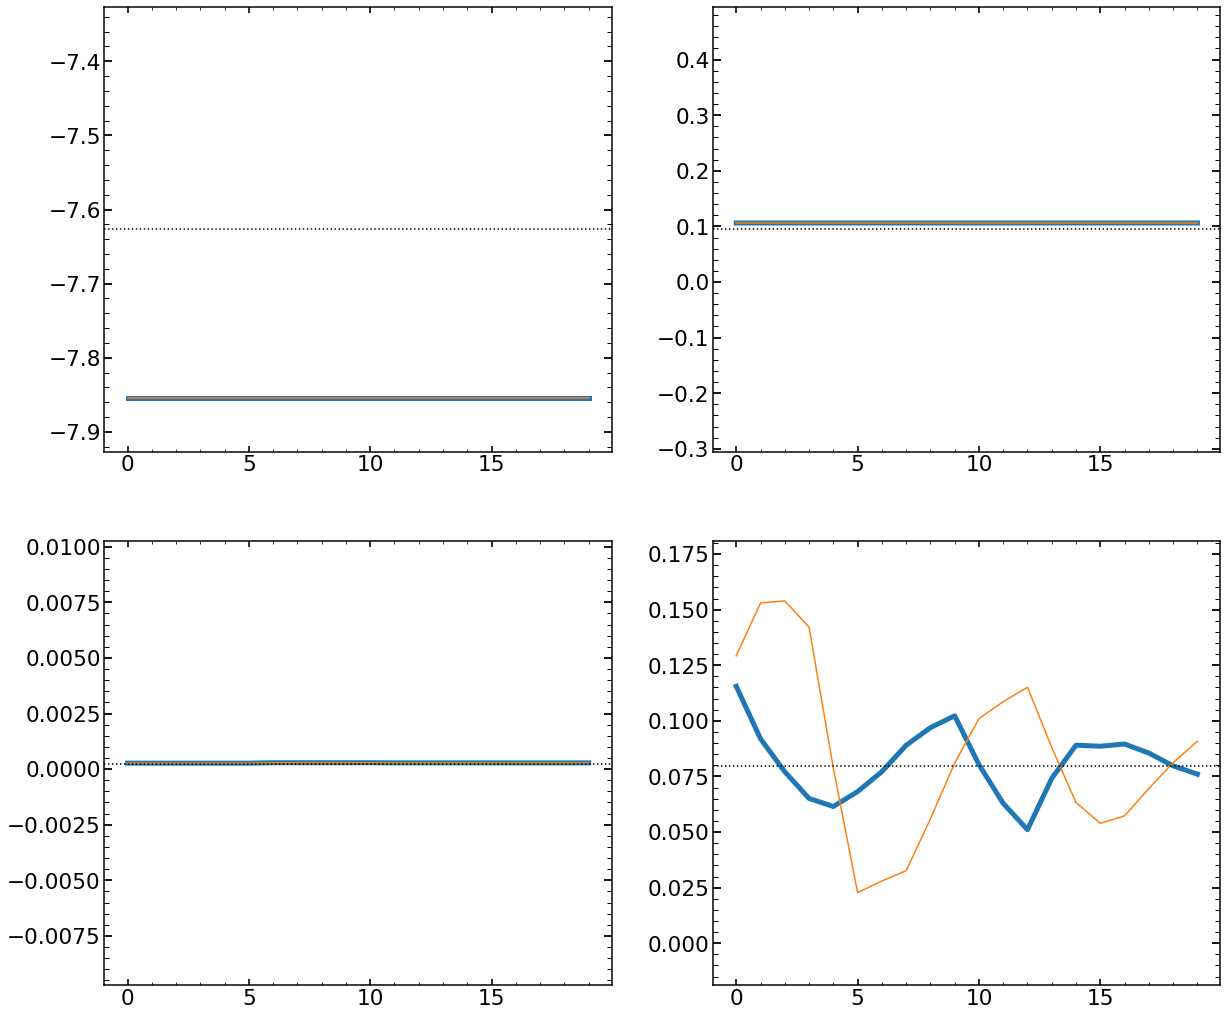

In [551]:
# wavefront paramter
plt.figure(figsize=(20,18))
i=0*2
plt.subplot(221)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,78][:,i],lw=5)
plt.plot(chain0_swarm_1[:,28][:,i])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,i])
plt.ylim(minchain_parametrization[0]-0.3,minchain_parametrization[0]+0.3)
plt.axhline(minchain_parametrization[0],ls=':',color='black')

plt.subplot(222)
#  paramter 2 (z5)

#mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,78][:,2],lw=5)
plt.plot(chain0_swarm_1[:,28][:,2])

plt.ylim(minchain_parametrization[2]-0.4,minchain_parametrization[2]+0.4)
plt.axhline(minchain_parametrization[2],ls=':',color='black')

plt.subplot(223)
# two different walkers, parameter 89
plt.plot(chain0_swarm_1[:,78][:,89],lw=5)
plt.plot(chain0_swarm_1[:,28][:,89])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,89])
plt.ylim(mean_one_walker-0.01,mean_one_walker+0.01)
plt.axhline(minchain_parametrization[89],ls=':',color='black')

plt.subplot(224)
# two different walkers, parameter 89
plt.plot(chain0_swarm_1[:,78][:,19*2+1],lw=5)
plt.plot(chain0_swarm_1[:,28][:,19*2+1])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,19*2+1])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[19*2+1],ls=':',color='black')

In [676]:

list_of_image_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/list_of_image_0_1_1.npy',allow_pickle=True)
#uber_list_of_input_parameters_1_0
#uber_M0_std_1_0
#list_of_pre_chi2_1_0
#list_of_initial_model_result_1_0
#list_of_initial_input_parameters_1_0
#list_of_image_0_1_0
#pre_input_parameters.npy
#list_of_var_images.npy
#list_of_sci_images.npy
#list_of_sci_image_std.npy
#list_of_mask_images.npy
list_of_sci_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/list_of_sci_images.npy',allow_pickle=True)


# parametrization before the run
#initial_input_parameterization=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1620/initial_input_parameterization_1.npy')
#list_of_initial_model_result=
#list_of_image_0=
#list_of_initial_input_parameters=
#list_of_pre_chi2=
allparameters_parametrization_proposal=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/allparameters_parametrization_proposal.npy')
initial_input_parameterization_1_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/initial_input_parameterization_1_1.npy')
list_of_initial_model_result=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/list_of_initial_model_result_1_1.npy')


uber_list_of_input_parameters_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/uber_list_of_input_parameters_1_1.npy')
out_images_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/out_images_1_1.npy',allow_pickle=True)
out_parameters_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/out_parameters_1_1.npy',allow_pickle=True)
allparameters_parametrization_proposal_after_iteration_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/allparameters_parametrization_proposal_after_iteration_1_1.npy')

list_of_initial_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/list_of_initial_input_parameters_1_1.npy')
array_of_delta_z_parametrizations=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/array_of_delta_z_parametrizations_1_1.npy')
initial_input_parameterization=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/initial_input_parameterization_1_1.npy')


# science images
uber_I_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/uber_I_std_1.npy')
#initial model
uber_M0_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/uber_M_final_1_1.npy')

# modified images, moved one parameter
uber_images_normalized_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/uber_images_normalized_std1_1.npy')

In [579]:
array_of_delta_z_parametrizations_1_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/array_of_delta_z_parametrizations_1_1.npy')
array_of_delta_z_parametrizations_1_2=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/array_of_delta_z_parametrizations_1_2.npy')
array_of_delta_z_parametrizations_6_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/array_of_delta_z_parametrizations_6_0.npy')
array_of_delta_z_parametrizations_6_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/array_of_delta_z_parametrizations_6_1.npy')
array_of_delta_z_parametrizations_6_2=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/array_of_delta_z_parametrizations_6_2.npy')
array_of_delta_z_parametrizations_6_3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1920/array_of_delta_z_parametrizations_6_3.npy')

In [667]:
array_of_delta_z_parametrizations_1_1

array([-0.00056325,  0.01481816,  0.43503643,  0.07146956,  0.16469709,
       -0.11886909,  0.23383009, -0.10987763, -0.14070913,  0.08164802,
        0.27034844,  0.32733705,  0.14465464, -0.17241019,  0.07634569,
       -0.16219259,  0.17076966,  0.05700939, -0.06837213, -0.12163868,
       -0.11222059, -0.04959648,  0.01647917,  0.00640893, -0.16429308,
        0.00342109, -0.12684632, -0.01825888,  0.21660216, -0.06922968,
        0.03099142, -0.03652706, -0.00327409, -0.03986118, -0.05942387,
        0.04369059,  0.06280213,  0.07244274, -0.05967149, -0.001899  ,
        0.12916184, -0.06535052,  0.14788499, -0.02238635,  0.10275929,
        0.01487916, -0.11477648,  0.02466705, -0.05941665, -0.00418883,
       -0.02584746,  0.02519314, -0.08072487,  0.01621545, -0.06379658,
        0.02513867,  0.01149109, -0.05327774, -0.01010747,  0.01802123,
       -0.0166349 ,  0.01692602, -0.02755715, -0.04794694,  0.03250462,
       -0.06286333, -0.03552863,  0.04637576,  0.01382173, -0.00

In [591]:
        list_of_delta_z_parametrizations=[]
        for z_par in range(0,19*2+2*number_of_extra_zernike):
            list_of_delta_z_parametrizations.append(0.5/((np.sqrt(8.*(z_par+1.)-6.)-1.)/2.))        
            

        # array, randomized delta extra zernike
        #array_of_delta_randomize=np.random.standard_normal(len(list_of_delta_z))*1.2+1
        array_of_delta_parametrizations_randomize=np.random.standard_normal(len(list_of_delta_z_parametrizations))*1
        array_of_delta_z_parametrizations_test=+np.array(list_of_delta_z_parametrizations)*array_of_delta_parametrizations_randomize
        
        array_of_delta_z_parametrizations_test

array([ 0.53831421,  0.54948993,  0.17293616,  0.01207754, -0.00389296,
        0.09561848,  0.19892597, -0.24043336, -0.25024994, -0.02462097,
        0.08133818,  0.03498321,  0.21634231, -0.01026898,  0.01109967,
       -0.01164335,  0.1099099 ,  0.08636231,  0.06869822, -0.03063727,
        0.00313686,  0.12314814,  0.13681987,  0.04867494, -0.12386684,
       -0.07983583,  0.0666875 , -0.14170812, -0.00634125, -0.10108653,
       -0.01068612,  0.05023376,  0.01476172,  0.08263382,  0.0552083 ,
       -0.07521163,  0.05265702, -0.09997957,  0.01730736, -0.00216126,
       -0.03487702,  0.06116504, -0.00099374, -0.05437225,  0.01782675,
        0.02402259,  0.04072969, -0.00691854, -0.04523558, -0.05630421,
       -0.04444468, -0.04047227, -0.01405158,  0.03799892, -0.02248242,
       -0.01700156, -0.07097292, -0.03474616, -0.03221233,  0.02424873,
        0.08622488,  0.00333207, -0.08965435,  0.016992  ,  0.01882439,
        0.05922741,  0.04899072,  0.06756755, -0.05547797, -0.01

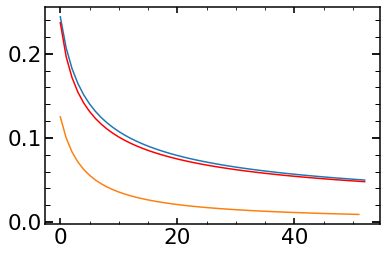

In [663]:
z_par=4
list_1=[]
list_2=[]

for z_par in range(4,56):
    list_2.append(0.5/(z_par))
    
for z_par in range(0,53):
    list_1.append(0.5/((np.sqrt(8.*(z_par+4)-6.)-1.)/2.))

list_of_delta_z_parametrizations_linear=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations_linear.append(0.25*0.25/np.sqrt(z_par_i))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations_linear.append(0.25/np.sqrt(z_par_i))
        
array_of_delta_z_parametrizations_linear=np.array(list_of_delta_z_parametrizations_linear)[np.arange(0,53*2,2)]*4+np.array(list_of_delta_z_parametrizations_linear)[np.arange(1,53*2+1,2)]   
    
    
plt.plot(list_1)
plt.plot(list_2)
plt.plot(array_of_delta_z_parametrizations_linear,color='red')

In [649]:
list_of_delta_z_parametrizations_linear=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations_linear.append(0.25*0.5/((np.sqrt(8.*(z_par_i)-6.)-1.)/2.))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations_linear.append(0.5/((np.sqrt(8.*(z_par_i)-6.)-1.)/2.))
        
array_of_delta_z_parametrizations_linear=np.array(list_of_delta_z_parametrizations_linear)[np.arange(0,53*2,2)]*4+np.array(list_of_delta_z_parametrizations_linear)[np.arange(1,53*2+1,2)]        

In [644]:
len(list_of_delta_z_parametrizations_linear)

106

In [648]:
np.array(list_of_delta_z_parametrizations_linear)[np.arange(0,53*2,2)]*4+np.array(list_of_delta_z_parametrizations_linear)[np.arange(1,53*2+1,2)]

array([0.45095932, 0.34717276, 0.29152374, 0.25567926, 0.23019551,
       0.21091441, 0.19568607, 0.18327418, 0.17291152, 0.16409383,
       0.15647447, 0.14980635, 0.14390805, 0.138643  , 0.13390619,
       0.1296154 , 0.12570519, 0.12212281, 0.11882514, 0.11577661,
       0.11294754, 0.11031295, 0.10785167, 0.1055456 , 0.10337919,
       0.10133896, 0.09941319, 0.09759163, 0.09586524, 0.09422608,
       0.09266706, 0.0911819 , 0.08976498, 0.08841125, 0.08711618,
       0.08587566, 0.084686  , 0.08354383, 0.08244608, 0.08138996,
       0.08037292, 0.07939262, 0.0784469 , 0.0775338 , 0.07665148,
       0.07579826, 0.07497259, 0.07417302, 0.07339821, 0.07264691,
       0.07191796, 0.07121029, 0.07052287])

In [646]:
list_of_delta_z_parametrizations_linear

[0.060990195135927856,
 0.2069985422680394,
 0.04561427255126744,
 0.16471566962990766,
 0.03778847853449083,
 0.140369821609784,
 0.03288467557206379,
 0.12414055726095576,
 0.02945739601265488,
 0.11236592718156356,
 0.026894357478540475,
 0.10333697568169302,
 0.0248871095396431,
 0.09613762985264636,
 0.023261569570202065,
 0.09022790326616946,
 0.021911231447697476,
 0.08526659665439662,
 0.02076687102130961,
 0.08102635064478154,
 0.019781326617548455,
 0.07734916205794881,
 0.018921231845213802,
 0.07412141983822698,
 0.018162238548655993,
 0.0712590950149907,
 0.017486114314139864,
 0.06869854434068069,
 0.01687890391650793,
 0.0663905774482841,
 0.016329723047452917,
 0.06429650314009835,
 0.015829942725753263,
 0.06238541995130242,
 0.015372623317872113,
 0.060632313719789846,
 0.014952112736956352,
 0.059016692974848475,
 0.014563755413818352,
 0.0575215914268553,
 0.014203677708505995,
 0.05613282640857445,
 0.013868627140194217,
 0.05483843919152127,
 0.013555850195771605,

In [597]:
array_of_delta_z_parametrizations_6_3

array([-1.09085103, -0.17557156, -0.02946418,  0.54583773, -0.02232753,
       -0.04682955, -0.07984075, -0.08296032,  0.08230718,  0.01204023,
       -0.02500448,  0.09450784, -0.10923628,  0.08743754, -0.05141671,
       -0.0340721 , -0.19002516,  0.19741021,  0.03119826, -0.10865929,
       -0.01656293,  0.10046749, -0.03366351, -0.0393263 , -0.00069891,
       -0.11519875,  0.0897298 , -0.11927851,  0.01993879, -0.0631466 ,
        0.04105114,  0.11047798, -0.06641188, -0.11693332,  0.11354482,
        0.02639958, -0.02220971, -0.1083411 ,  0.04308877,  0.06767713,
       -0.00745251,  0.00715567, -0.03382082,  0.04624732, -0.05224791,
        0.03556716, -0.02401697, -0.00345363,  0.06217319, -0.06232244,
       -0.00027784, -0.00956122, -0.02900263, -0.15030716,  0.03322037,
       -0.0087219 ,  0.00958127, -0.01047833, -0.07135787,  0.04307475,
       -0.00510455,  0.00636038, -0.02962926,  0.02593568,  0.06357264,
        0.04201357,  0.06501281,  0.05433906,  0.01868   ,  0.01

In [553]:
# shapes look fine and the normalizations are fine
print(uber_I_std.shape)
print(uber_M0_std.shape)
print(uber_images_normalized_std.shape)

(9521,)
(9521,)
(106, 9521)


In [475]:
out_parameters_1[0]

array([[   21.632905  ,     0.00234957,    -0.73686124,     0.68239345,
            0.0482061 ,    -0.07714643,    -0.46257843,    -0.48365609,
            0.00780241,    -0.09226808,    -0.04919495,    -0.00152062,
           -0.01220658,     0.01215675,     0.03261509,     0.00952929,
           -0.03487949,     0.02525915,     0.02099311,     0.61130947,
            0.10866051,    -0.07913022,    -0.01075732,     0.05810305,
            0.08266617,     0.00001729,     0.00001952,     1.0755059 ,
            1.01383914,     0.05283191,     0.07162677,     0.88843802,
            0.05476751,     0.86549584,     1.11590286,     0.10168118,
        16243.86703633,     2.10208714,     0.00018931,     0.36573423,
            1.89571628,     1.        ,    -0.00384726,    -0.00080563,
           -0.00211594,    -0.0127458 ,    -0.00883014,     0.01208438,
            0.00105795,     0.00880716,     0.00448567,    -0.00573166,
           -0.00123286,     0.01018481,    -0.0004959 ,    -0.00

In [472]:
out_parameters_1[i]

array([[   21.632905  ,     0.00234957,    -0.73686124,     0.68239345,
            0.0482061 ,    -0.07714643,    -0.46257843,    -0.48365609,
            0.00780241,    -0.09226808,    -0.04919495,    -0.00152062,
           -0.01220658,     0.01215675,     0.03261509,     0.00952929,
           -0.03487949,     0.02525915,     0.02099311,     0.61130947,
            0.10866051,    -0.07913022,    -0.01075732,     0.05810305,
            0.08266617,     0.00001729,     0.00001952,     1.0755059 ,
            1.01383914,     0.05283191,     0.07162677,     0.88843802,
            0.05476751,     0.86549584,     1.11590286,     0.10168118,
        16243.86703633,     2.10208714,     0.00018931,     0.36573423,
            1.89571628,     1.        ,    -0.00384726,    -0.00080563,
           -0.00211594,    -0.0127458 ,    -0.00883014,     0.01208438,
            0.00105795,     0.00880716,     0.00448567,    -0.00573166,
           -0.00123286,     0.01018481,    -0.0004959 ,    -0.00

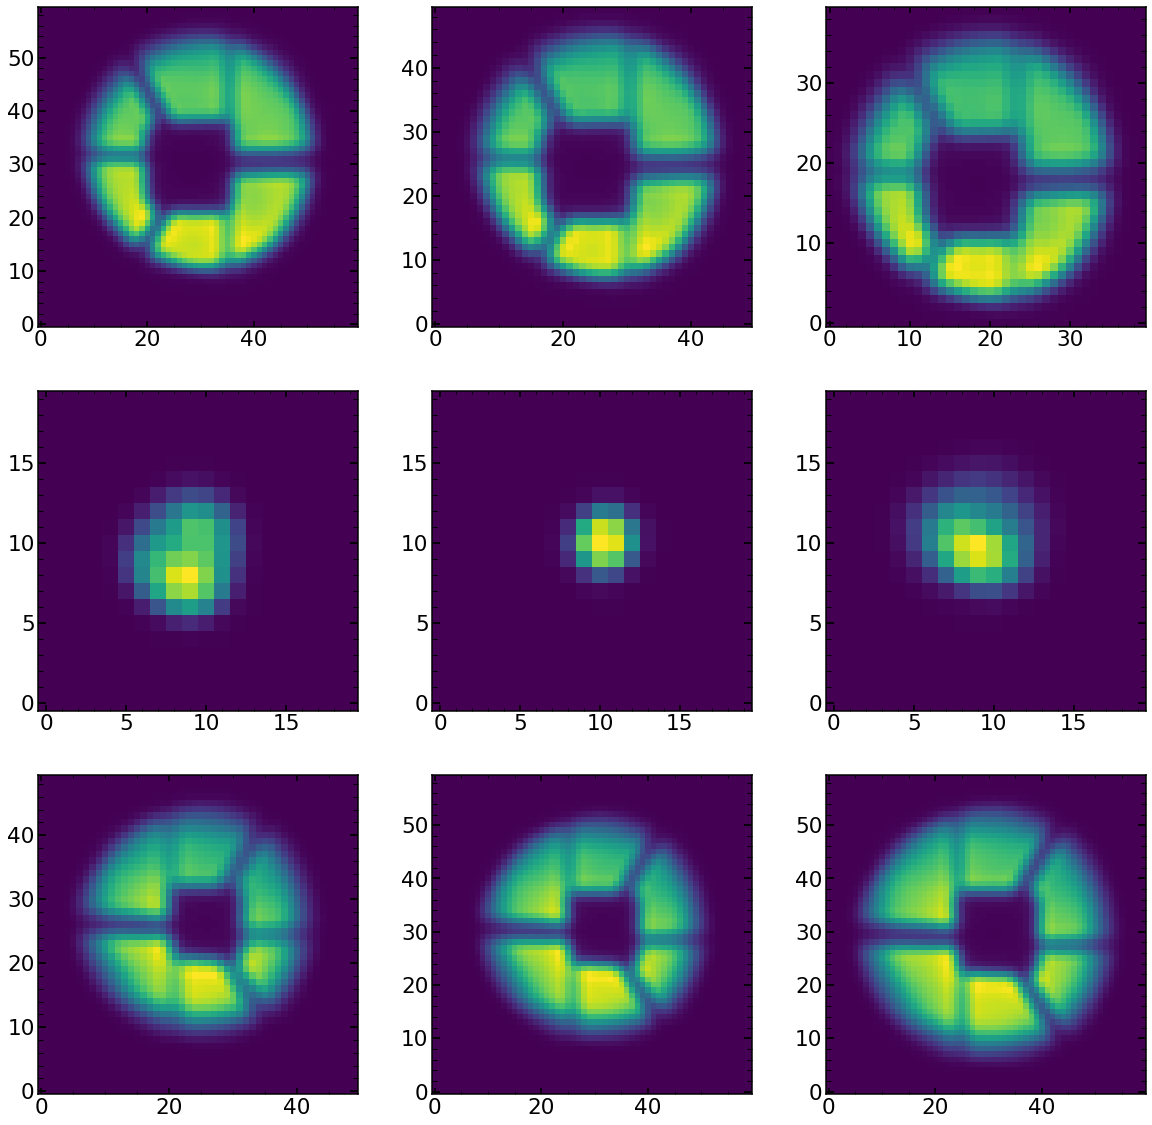

In [668]:
i=0
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(list_of_sci_images[0])

plt.subplot(332)
plt.imshow(list_of_sci_images[1])

plt.subplot(333)
plt.imshow(list_of_sci_images[2])

plt.subplot(334)
plt.imshow(list_of_sci_images[3])

plt.subplot(335)
plt.imshow(list_of_sci_images[4])

plt.subplot(336)
plt.imshow(list_of_sci_images[5])

plt.subplot(337)
plt.imshow(list_of_sci_images[6])

plt.subplot(338)
plt.imshow(list_of_sci_images[7])

plt.subplot(339)
plt.imshow(list_of_sci_images[8])

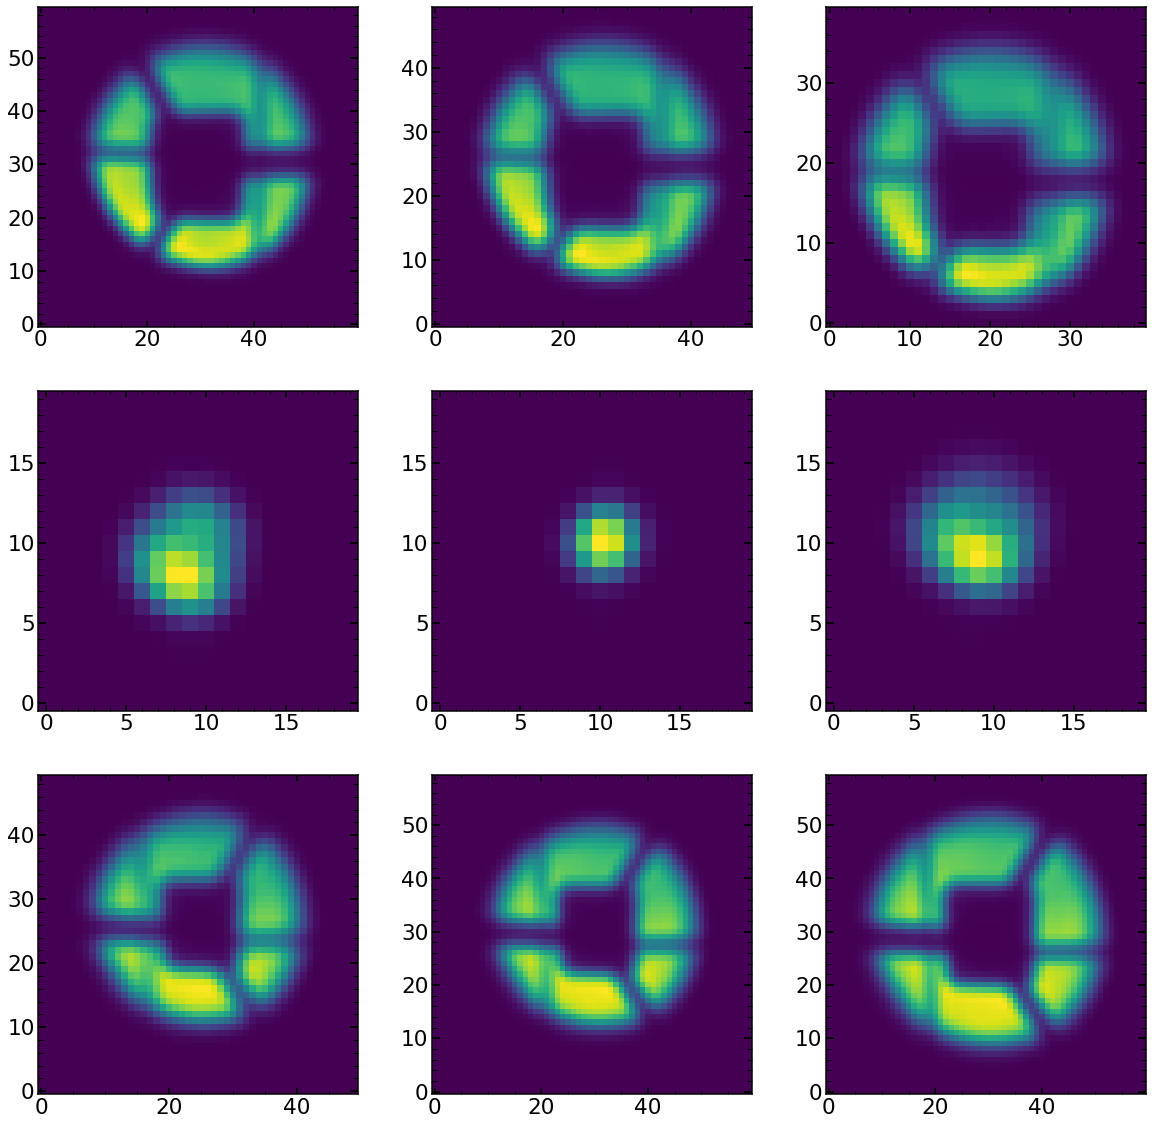

In [669]:
i=0
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(list_of_image_0[0])

plt.subplot(332)
plt.imshow(list_of_image_0[1])

plt.subplot(333)
plt.imshow(list_of_image_0[2])

plt.subplot(334)
plt.imshow(list_of_image_0[3])

plt.subplot(335)
plt.imshow(list_of_image_0[4])

plt.subplot(336)
plt.imshow(list_of_image_0[5])

plt.subplot(337)
plt.imshow(list_of_image_0[6])

plt.subplot(338)
plt.imshow(list_of_image_0[7])

plt.subplot(339)
plt.imshow(list_of_image_0[8])

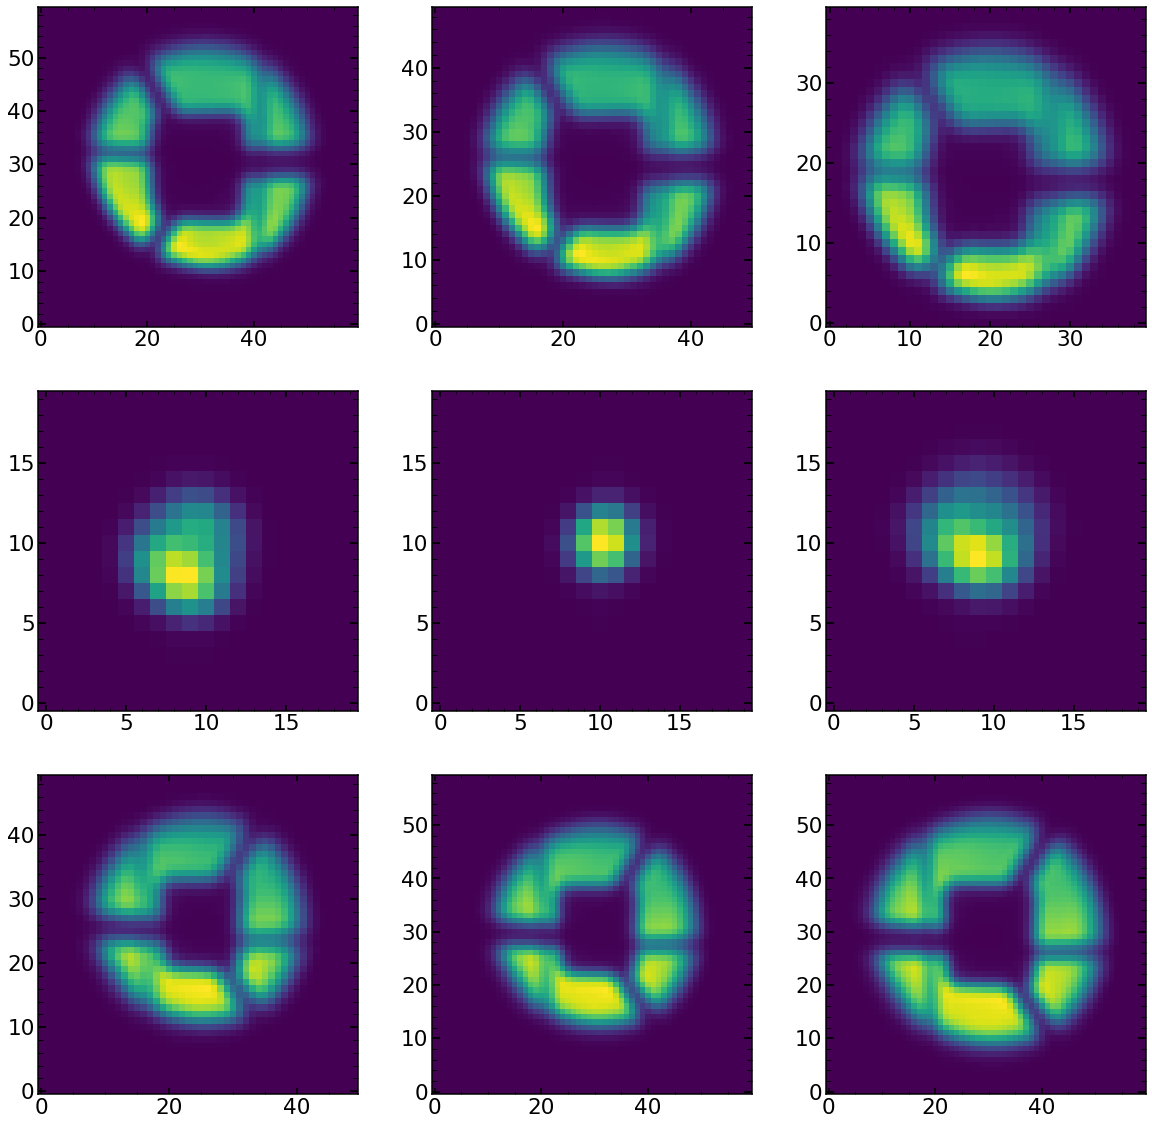

In [670]:
i=0
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(out_images_1[i][0])

plt.subplot(332)
plt.imshow(out_images_1[i][1])

plt.subplot(333)
plt.imshow(out_images_1[i][2])

plt.subplot(334)
plt.imshow(out_images_1[i][3])

plt.subplot(335)
plt.imshow(out_images_1[i][4])

plt.subplot(336)
plt.imshow(out_images_1[i][5])

plt.subplot(337)
plt.imshow(out_images_1[i][6])

plt.subplot(338)
plt.imshow(out_images_1[i][7])

plt.subplot(339)
plt.imshow(out_images_1[i][8])


In [558]:
initial_input_parameterization[:5]

array([-7.85361627,  0.1890123 ,  0.10613834,  0.42690293,  0.04838818])

In [559]:
array_of_delta_z_parametrizations[:5]

array([-2.75783918, -0.00192894,  0.25461146,  0.19231711, -0.29094674])

In [672]:
list_of_minchain[0]

array([   30.66675729,    -0.00412966,    -0.65067649,     0.58428509,
           0.04980397,    -0.072949  ,    -0.44855507,    -0.46224749,
           0.00747463,    -0.07924748,    -0.04913092,    -0.00359824,
          -0.01078687,     0.01274981,     0.02885293,     0.0082431 ,
          -0.03059624,     0.02289192,     0.02050776,     0.64763255,
           0.07972058,    -0.07504414,    -0.06657529,     0.05511363,
           0.02942104,     0.00001627,     0.00001627,     0.97483602,
           0.94833824,     0.02253383,    -0.03586997,     0.9313411 ,
           0.06865397,     0.42454705,     1.0291687 ,     0.27632026,
       87381.13193628,     2.38689243,     0.00235943,     0.35323491,
           1.82265232,     1.00000022,    -0.00397035,    -0.00080248,
          -0.00182131,    -0.01142717,    -0.00744409,     0.0103055 ,
           0.00142023,     0.00751632,     0.00443184,    -0.00551814,
          -0.00063624,     0.00890376,    -0.00049597,    -0.00793521,
      

In [563]:
list_of_initial_input_parameters[0]

array([   31.60347737,     0.00234957,    -0.73686124,     0.68239345,
           0.0482061 ,    -0.07714643,    -0.46257843,    -0.48365609,
           0.00780241,    -0.09226808,    -0.04919495,    -0.00152062,
          -0.01220658,     0.01215675,     0.03261509,     0.00952929,
          -0.03487949,     0.02525915,     0.02099311,     0.69456007,
           0.12679269,    -0.08785157,    -0.09674288,     0.07401942,
           0.01767817,     0.00001729,     0.00001952,     1.0755059 ,
           1.01383914,    -0.08223893,    -0.09631443,     0.87397212,
           0.05104596,     0.09138628,     1.12904778,     0.47139823,
       44019.99410224,     2.84016055,     0.00189296,     0.57977749,
           1.8416556 ,     1.        ,    -0.00384726,    -0.00080563,
          -0.00211594,    -0.0127458 ,    -0.00883014,     0.01208438,
           0.00105795,     0.00880716,     0.00448567,    -0.00573166,
          -0.00123286,     0.01018481,    -0.0004959 ,    -0.00910544,
      

In [537]:
np.abs(np.array(uber_I_std)-np.array(uber_M0_std))

array([0.00000272, 0.00000301, 0.00000351, ..., 0.00000526, 0.00000464,
       0.0000041 ], dtype=float32)

In [565]:
uber_images_normalized_std.shape

(106, 9521)

In [566]:
array_of_delta_z_parametrizations

array([-2.75783918, -0.00192894,  0.25461146,  0.19231711, -0.29094674,
       -0.34044482,  0.06483892,  0.15123892,  0.05117881,  0.20868344,
        0.03908836,  0.13771489,  0.00612058,  0.13324744,  0.00082828,
        0.10229003, -0.15841947, -0.14995662, -0.03853073, -0.08579372,
       -0.09573448, -0.0168563 , -0.10011848, -0.03418271,  0.03026471,
        0.02317475, -0.08117245, -0.00413765,  0.03700303, -0.1113045 ,
        0.14456168,  0.05671627, -0.07887823,  0.0179298 , -0.09841078,
        0.00797348, -0.04655173, -0.0236459 ,  0.01620385, -0.03742172,
       -0.12103923,  0.02919714,  0.06191965,  0.00721288,  0.03778829,
       -0.00174543,  0.01500827, -0.06745282,  0.0018853 , -0.03372644,
       -0.01615984, -0.01140057, -0.00061866, -0.02248223, -0.01260088,
        0.03785708,  0.01099115,  0.01257796,  0.00888604,  0.04800337,
        0.00116018, -0.07586716,  0.00777495, -0.05914463,  0.02767346,
        0.07358407,  0.07049208,  0.08692705, -0.03069026, -0.02

In [678]:
array_of_delta_z_parametrizations[:,None]

array([[-0.00056325],
       [ 0.01481816],
       [ 0.43503643],
       [ 0.07146956],
       [ 0.16469709],
       [-0.11886909],
       [ 0.23383009],
       [-0.10987763],
       [-0.14070913],
       [ 0.08164802],
       [ 0.27034844],
       [ 0.32733705],
       [ 0.14465464],
       [-0.17241019],
       [ 0.07634569],
       [-0.16219259],
       [ 0.17076966],
       [ 0.05700939],
       [-0.06837213],
       [-0.12163868],
       [-0.11222059],
       [-0.04959648],
       [ 0.01647917],
       [ 0.00640893],
       [-0.16429308],
       [ 0.00342109],
       [-0.12684632],
       [-0.01825888],
       [ 0.21660216],
       [-0.06922968],
       [ 0.03099142],
       [-0.03652706],
       [-0.00327409],
       [-0.03986118],
       [-0.05942387],
       [ 0.04369059],
       [ 0.06280213],
       [ 0.07244274],
       [-0.05967149],
       [-0.001899  ],
       [ 0.12916184],
       [-0.06535052],
       [ 0.14788499],
       [-0.02238635],
       [ 0.10275929],
       [ 0

In [679]:
H_std=np.transpose(np.array((uber_images_normalized_std-uber_M0_std))/array_of_delta_z_parametrizations[:,None]) 

In [569]:
H_std.shape

(9521, 106)

In [680]:
#HHt=np.matmul(np.transpose(H),H)
HHt_std=np.matmul(np.transpose(H_std),H_std) 
print('svd thresh is '+str(thresh))
#invHHt=svd_invert(HHt,thresh)
invHHt_std=svd_invert(HHt_std,thresh)

#invHHtHt=np.matmul(invHHt,np.transpose(H))
invHHtHt_std=np.matmul(invHHt_std,np.transpose(H_std))


# I is uber_I now (science images)
# M0 is uber_M0 now (set of models before the iteration)
#first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,uber_I_std-uber_M0_std)

svd thresh is 0.05
WS[   0]  1309.970989588
SVD_INVERT: Value 1=1.50e-03 rejected (threshold=6.55e+01).
SVD_INVERT: Value 2=1.28e-03 rejected (threshold=6.55e+01).
SVD_INVERT: Value 3=1.12e-03 rejected (threshold=6.55e+01).
SVD_INVERT: Value 4=1.12e-03 rejected (threshold=6.55e+01).
SVD_INVERT: Value 5=1.00e-03 rejected (threshold=6.55e+01).
SVD_INVERT: Value 6=9.24e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 7=8.67e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 8=8.23e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 9=7.63e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 10=7.55e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 11=7.40e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 12=6.81e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 13=6.42e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 14=6.26e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 15=5.83e-04 rejected (threshold=6.55e+01).
SVD_INVERT: Value 16=5.55e-04 rejected (threshold=

In [573]:
Tokovnin_proposal=0.7*first_proposal_Tokovnin_std
Tokovnin_proposal

array([-0.00000002, -0.00002478,  0.00000019,  0.00000025, -0.00000016,
       -0.00000014,  0.00000074,  0.00000033,  0.00000094,  0.00000023,
        0.00000122,  0.00000035,  0.00000781,  0.00000036,  0.00005771,
        0.00000046, -0.0000003 , -0.00000032, -0.00000124, -0.00000056,
       -0.0000005 , -0.00000284, -0.00000048, -0.0000014 ,  0.00000158,
        0.00000207, -0.00000058, -0.00001154,  0.00000129, -0.00000043,
        0.00000033,  0.00000084, -0.00000061,  0.00000267, -0.00000049,
        0.000006  , -0.00000102, -0.00000203,  0.00000295, -0.00000128,
       -0.0000004 ,  0.00000164,  0.00000077,  0.00000663,  0.00000127,
       -0.00002739,  0.00000319, -0.00000071,  0.00002535, -0.00000142,
       -0.00000296, -0.00000419, -0.00007726, -0.00000213, -0.00000379,
        0.00000126,  0.00000435,  0.0000038 ,  0.00000538,  0.000001  ,
        0.0000412 , -0.00000064,  0.00000615, -0.00000081,  0.00000173,
        0.00000066,  0.00000068,  0.00000056, -0.00000156, -0.00

In [240]:
out_images=out_images_1
array_of_delta_z_parametrizations=array_of_delta_z_parametrizations_1
#list_of_single_model_image
#list_of_var_images
#list_of_mask_images

list_of_mean_value_of_background=[]
list_of_flux_mask=[]
list_of_sci_image_std=[]
for i in range(len(list_of_sci_images)):
    sci_image=list_of_sci_images[i]

    mean_value_of_background=np.mean([np.median(sci_image[0]),np.median(sci_image[-1]),\
                                      np.median(sci_image[:,0]),np.median(sci_image[:,-1])])*10
    list_of_mean_value_of_background.append(mean_value_of_background)
    flux_mask=sci_image>(mean_value_of_background)


    # normalized science image
    var_image=list_of_var_images[i]
    sci_image_std=sci_image/np.sqrt(var_image)
    list_of_sci_image_std.append(sci_image_std)
    list_of_flux_mask.append(flux_mask)
    

######################################################################################################### 
# normalized and masked science image
# why do I do this here, I could have done this at stage 0 
list_of_I=[]
list_of_I_std=[]    

for i in range(len(list_of_sci_images)):

    sci_image=list_of_sci_images[i]
    sci_image_std=list_of_sci_image_std[i]
    flux_mask=list_of_flux_mask[i]

    I=((sci_image[flux_mask])/np.sum(sci_image[flux_mask])).ravel()
    I_std=((sci_image_std[flux_mask])/np.sum(sci_image_std[flux_mask])).ravel()

    list_of_I.append(I)
    list_of_I_std.append(I_std)

# join all I,I_std from all individual images into one uber I,I_std  
uber_I=[item for sublist in list_of_I for item in sublist]
uber_I_std=[item for sublist in list_of_I_std for item in sublist]    

uber_I=np.array(uber_I)
uber_I_std=np.array(uber_I_std)

list_of_images_normalized_uber=[]
list_of_images_normalized_std_uber=[]
# go over zmax*2 images
for j in range(len(out_images)):
    # two steps for what could have been achived in one, but to ease up transition from previous code 
    out_images_single_parameter_change=out_images[j]
    optpsf_list=out_images_single_parameter_change
    ### breaking here
    # flux image has to correct per image
    # normalize and mask images that have been created in the fitting procedure
    images_normalized=[]
    for i in range(len(optpsf_list)):

        flux_mask=list_of_flux_mask[i]

        images_normalized.append((optpsf_list[i][flux_mask]/np.sum(optpsf_list[i][flux_mask])).ravel())

    images_normalized_flat=[item for sublist in images_normalized for item in sublist]  
    images_normalized_flat=np.array(images_normalized_flat)/len(optpsf_list)        

    # list of (zmax-3)*2 raveled images
    list_of_images_normalized_uber.append(images_normalized_flat)

    # same but divided by STD
    images_normalized_std=[]
    for i in range(len(optpsf_list)):   
        # seems that I am a bit more verbose here with my definitions
        optpsf_list_i=optpsf_list[i]
        STD=list_of_sci_image_std[i]
        optpsf_list_i_STD=optpsf_list_i/STD    
        flux_mask=list_of_flux_mask[i]
        images_normalized_std.append((optpsf_list_i_STD[flux_mask]/np.sum(optpsf_list_i_STD[flux_mask])).ravel())

    # join all images together
    images_normalized_std_flat=[item for sublist in images_normalized_std for item in sublist]  
    # normalize so that the sum is still one
    images_normalized_std_flat=np.array(images_normalized_std_flat)/len(optpsf_list)

    list_of_images_normalized_std_uber.append(images_normalized_std_flat)

# create uber images_normalized,images_normalized_std    
# images that have zmax*2 rows and very large number of columns (number of non-masked pixels from all N images)
uber_images_normalized=np.array(list_of_images_normalized_uber)    
uber_images_normalized_std=np.array(list_of_images_normalized_std_uber)          

# initial SVD treshold
thresh = 0.02

# set number of extra Zernike
#number_of_extra_zernike=0
#twentytwo_or_extra=22
# numbers that make sense are 11,22,37,56,79,106,137,172,211,254

#if number_of_extra_zernike is None:
#    number_of_extra_zernike=0
#else:
number_of_extra_zernike=twentytwo_or_extra-22


######################################################################################################### 
# divided model images by their standard deviations

list_of_image_0_std=[]
for i in range(len(list_of_image_0)):
    # normalizing by standard deviation image
    STD=np.sqrt(list_of_var_images[i])    
    image_0=list_of_image_0[i]
    list_of_image_0_std.append(image_0/STD)


######################################################################################################### 
# normalized and masked model images before this iteration


list_of_M0=[]
list_of_M0_std=[]
for i in range(len(list_of_image_0_std)):

    image_0=list_of_image_0[i]
    image_0_std=list_of_image_0_std[i]
    flux_mask=list_of_flux_mask[i]
    # what is list_of_mask_images?

    M0=((image_0[flux_mask])/np.sum(image_0[flux_mask])).ravel()
    M0_std=((image_0_std[flux_mask])/np.sum(image_0_std[flux_mask])).ravel()

    list_of_M0.append(M0)
    list_of_M0_std.append(M0_std)

# join all M0,M0_std from invidiual images into one uber M0,M0_std
uber_M0=[item for sublist in list_of_M0 for item in sublist]
uber_M0_std=[item for sublist in list_of_M0_std for item in sublist]    

uber_M0=np.array(uber_M0)
uber_M0_std=np.array(uber_M0_std)


In [464]:
    matrix=HHt
    u,ws,v = svd(matrix,full_matrices=True)

    #invw = inv(np.identity(len(ws))*ws)
    #return ws

    ww = np.max(ws)
    n = len(ws)
    invw = np.identity(n)
    ncount = 0

In [466]:
ws

array([185534.21447229,      0.00603174,      0.00089862,      0.00085632,
            0.00080708,      0.00076802,      0.00073074,      0.0007135 ,
            0.00065564,      0.00064184,      0.00061075,      0.00057717,
            0.00055342,      0.00049817,      0.00047676,      0.00047126,
            0.00046412,      0.00043508,      0.00040416,      0.00039434,
            0.00037076,      0.00032058,      0.00029315,      0.00027734,
            0.00023744,      0.00021673,      0.00020629,      0.00019552,
            0.00017318,      0.00015396,      0.00014609,      0.00012205,
            0.00011782,      0.00010397,      0.00009816,      0.00009124,
            0.0000888 ,      0.00008523,      0.00008001,      0.00007523,
            0.00007459,      0.00007182,      0.00006933,      0.00006773,
            0.00006674,      0.00006325,      0.00006146,      0.00005826,
            0.00005717,      0.00005518,      0.00005471,      0.00005021,
            0.00004777,  

In [452]:
print('images_normalized (uber).shape: '+str(uber_images_normalized.shape))
# equation A1 from Tokovinin 2006
H=np.transpose(np.array((uber_images_normalized-uber_M0))/array_of_delta_z_parametrizations[:,None])    
H_std=np.transpose(np.array((uber_images_normalized_std-uber_M0_std))/array_of_delta_z_parametrizations[:,None]) 


thresh=0.05

HHt=np.matmul(np.transpose(H),H)
HHt_std=np.matmul(np.transpose(H_std),H_std) 
print('svd thresh is '+str(thresh))
invHHt=svd_invert(HHt,thresh)
invHHt_std=svd_invert(HHt_std,thresh)

#invHHt=np.linalg.inv(HHt) 
#invHHt_std=np.linalg.inv(HHt_std)

invHHtHt=np.matmul(invHHt,np.transpose(H))
invHHtHt_std=np.matmul(invHHt_std,np.transpose(H_std))

images_normalized (uber).shape: (106, 11059)
svd thresh is 0.05
SVD_INVERT: Value 1=6.03e-03 rejected (threshold=9.28e+03).
SVD_INVERT: Value 2=8.99e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 3=8.56e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 4=8.07e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 5=7.68e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 6=7.31e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 7=7.14e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 8=6.56e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 9=6.42e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 10=6.11e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 11=5.77e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 12=5.53e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 13=4.98e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 14=4.77e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 15=4.71e-04 rejected (threshold=9.28e+03).
SVD_INVERT: Value 16=4.64e-04 

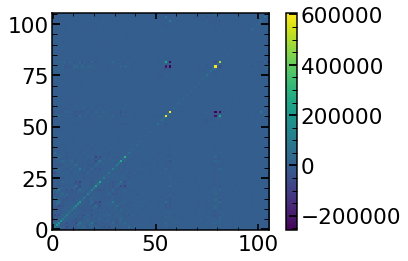

In [453]:
plt.imshow(np.linalg.inv(HHt))
plt.colorbar()

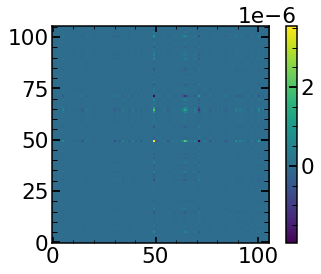

In [454]:
plt.imshow(invHHt_std)
plt.colorbar()

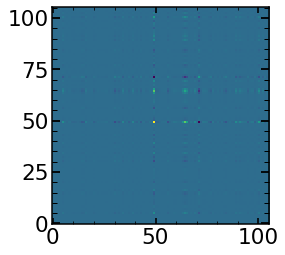

In [455]:
plt.imshow(invHHtHt@H)

In [456]:
invHHtHt@H

array([[ 0.00000007,  0.00000025, -0.00000022, ...,  0.00001005,
        -0.00000822,  0.00000629],
       [ 0.00000025,  0.00000094, -0.00000082, ...,  0.00003759,
        -0.00003074,  0.00002355],
       [-0.00000022, -0.00000082,  0.00000071, ..., -0.00003285,
         0.00002686, -0.00002057],
       ...,
       [ 0.00001005,  0.00003759, -0.00003285, ...,  0.001511  ,
        -0.00123557,  0.00094644],
       [-0.00000822, -0.00003074,  0.00002686, ..., -0.00123557,
         0.00101034, -0.00077392],
       [ 0.00000629,  0.00002355, -0.00002057, ...,  0.00094644,
        -0.00077392,  0.00059282]])

In [457]:
first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,uber_I_std-uber_M0_std)

In [458]:
correct_proposal=np.concatenate(((minchain_parametrization-initial_input_parameterization_1)[0:38],(minchain_parametrization-initial_input_parameterization_1)[38+23:]))

In [459]:
first_proposal_Tokovnin_std

array([-0.        , -0.00000001,  0.00000001,  0.00000003, -0.00000007,
        0.00000178,  0.00000016, -0.00000014,  0.0000002 , -0.00000023,
       -0.0000003 , -0.00000018, -0.00000005, -0.00000019, -0.00000096,
       -0.00000075,  0.00000084,  0.00000005,  0.00000008,  0.00000018,
       -0.00000054, -0.00000012,  0.00000017,  0.00000006,  0.00000012,
        0.00000011,  0.00000022, -0.0000001 ,  0.00000009, -0.00000007,
       -0.0000016 , -0.0000002 , -0.00000077, -0.00000023,  0.00000126,
       -0.00000014,  0.00000018, -0.00000059, -0.00000006,  0.00000118,
       -0.00000013, -0.00000037,  0.00000018, -0.00000083,  0.00000023,
       -0.0000002 , -0.00000016,  0.00000026,  0.00000012,  0.00000839,
       -0.00000063, -0.00000043, -0.00000009,  0.00000012,  0.00000017,
        0.00000016, -0.00000143, -0.00000018,  0.00000014,  0.00000046,
        0.00000037,  0.00000016,  0.00000017,  0.00000206,  0.00000511,
        0.00000281, -0.00000012,  0.00000047,  0.00000014,  0.00

In [460]:
correct_proposal

array([ 0.22706755, -0.02844991, -0.01120425, -0.05129622, -0.00095552,
        0.08236266,  0.00022273, -0.09721743, -0.00040342, -0.00001581,
       -0.00100697,  0.00016956, -0.0027278 ,  0.00311216, -0.00448   ,
        0.00348862,  0.00001572, -0.00026489,  0.00024068,  0.01398332,
       -0.00060573, -0.00235889, -0.00065101, -0.00468167,  0.00012004,
        0.00189985,  0.00029118,  0.00175777,  0.000868  , -0.00029016,
        0.00044976,  0.00051286, -0.00041889,  0.00260771,  0.00036587,
       -0.00090375, -0.00026185, -0.00153276,  0.00004007,  0.00003718,
       -0.00000644, -0.00002262, -0.00005747,  0.00006474, -0.00000179,
        0.00131145, -0.00005863,  0.00115153,  0.00028439, -0.00064133,
       -0.00016265, -0.00028834,  0.0002462 , -0.00030606,  0.00006533,
        0.0002075 , -0.00000954,  0.00017536, -0.00021807, -0.00027565,
        0.00007809, -0.00096871, -0.0000278 , -0.00011126, -0.00002031,
        0.00108899, -0.00004279, -0.00060032, -0.00003413,  0.00

(-1000.0, 1000.0)

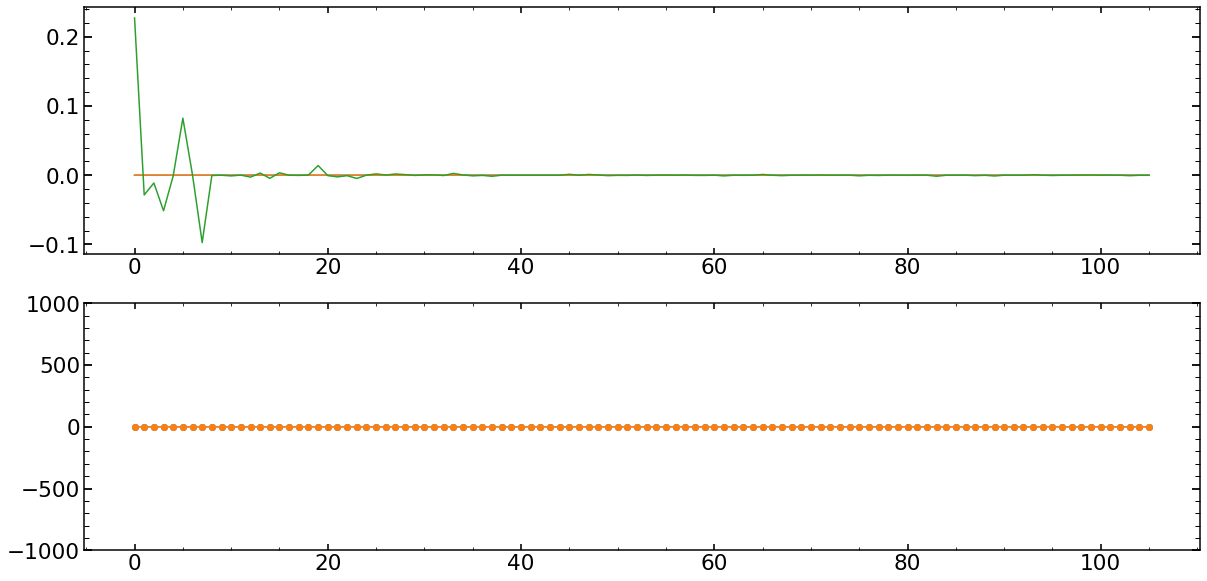

In [461]:
plt.figure(figsize=(20,10))

plt.subplot(211)
plt.plot(first_proposal_Tokovnin)
plt.plot(first_proposal_Tokovnin_std)
plt.plot(correct_proposal)

plt.subplot(212)
plt.plot(first_proposal_Tokovnin/correct_proposal,marker='o')
plt.plot(first_proposal_Tokovnin_std/correct_proposal,marker='o')
plt.ylim(-1000,1000)


In [423]:
np.sum((first_proposal_Tokovnin_std/correct_proposal)>0)

65

In [424]:
np.sum(-(first_proposal_Tokovnin_std/correct_proposal)>0)

41

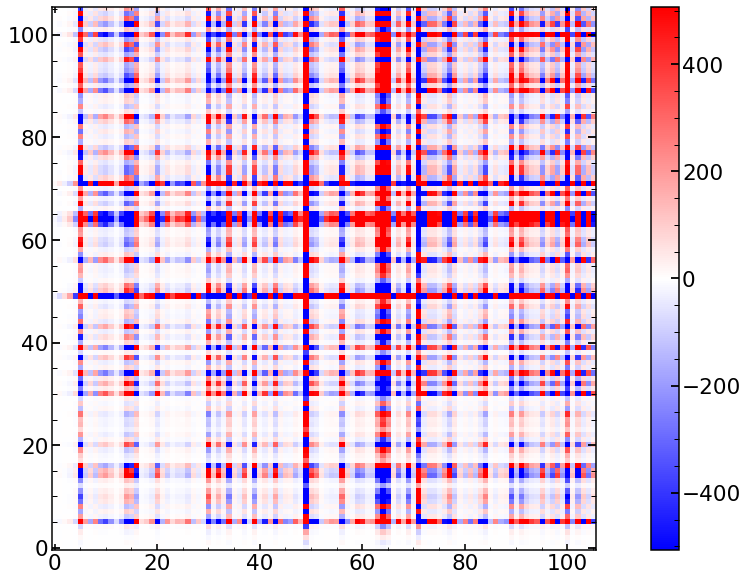

In [371]:
plt.figure(figsize=(20,10))
plt.imshow(HHt_std,vmax=np.quantile(HHt_std,0.95),vmin=-np.quantile(HHt_std,0.95),cmap='bwr')
plt.colorbar()

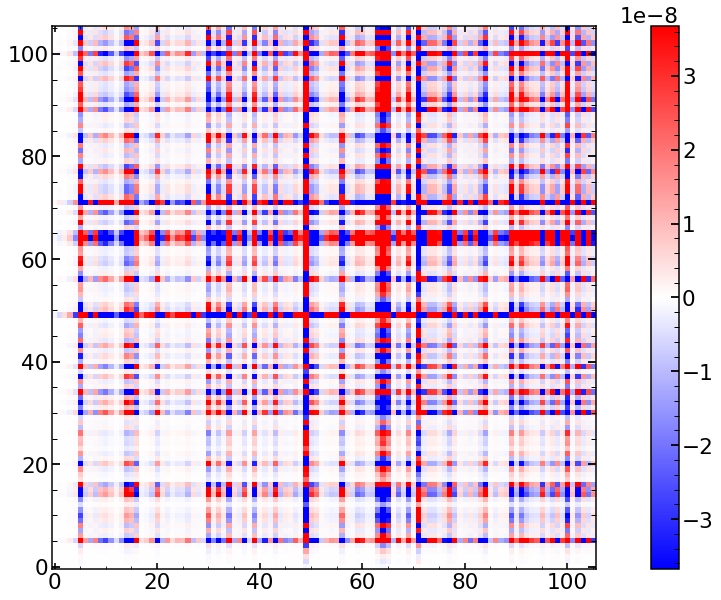

In [271]:
invHHt_std=svd_invert(HHt_std,thresh)
plt.figure(figsize=(20,10))
plt.imshow(invHHt_std,vmax=np.quantile(invHHt_std,0.95),vmin=-np.quantile(invHHt_std,0.95),cmap='bwr')
plt.colorbar()

In [361]:
from scipy.linalg import svd

a=np.array([[1,2],[3,4]])
a_inv=np.linalg.inv(a)
a_pinv=np.linalg.pinv(a)
a_svd_invert=svd_invert(a,0.00001)

print(np.matmul(a_inv,a))

print(np.matmul(a_pinv,a))

print(np.matmul(a_svd_invert,a))


a@(a_svd_invert@a)

[[1. 0.]
 [0. 1.]]
[[ 1.  0.]
 [-0.  1.]]
[[ 6.22222334  9.68648823]
 [-3.12792849 -4.70870956]]


array([[-0.03363364,  0.26906912],
       [ 6.15495607, 10.22462647]])

In [355]:
a_svd_invert_wiki_def_left=(np.linalg.inv(np.transpose(a)@a))@np.transpose(a)

In [354]:
a_svd_invert_wiki_def_right=np.transpose(a)@(np.linalg.inv(a@np.transpose(a)))

In [365]:
a_svd_invert_wiki_def_right

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

In [356]:
a_svd_invert_wiki_def_left@a

array([[ 1., -0.],
       [ 0.,  1.]])

In [357]:
u

array([[-0.40455358, -0.9145143 ],
       [-0.9145143 ,  0.40455358]])

In [358]:
v

array([[-0.57604844, -0.81741556],
       [ 0.81741556, -0.57604844]])

In [301]:
thresh=0.02
HHt_invert=svd_invert(HHt,thresh)
np.matmul(HHt_invert,np.transpose(HHt))

array([[ 0.00000007,  0.00000025, -0.00000022, ...,  0.00001005,
        -0.00000822,  0.00000629],
       [ 0.00000025,  0.00000094, -0.00000082, ...,  0.00003759,
        -0.00003074,  0.00002355],
       [-0.00000022, -0.00000082,  0.00000071, ..., -0.00003285,
         0.00002686, -0.00002057],
       ...,
       [ 0.00001005,  0.00003759, -0.00003285, ...,  0.001511  ,
        -0.00123557,  0.00094644],
       [-0.00000822, -0.00003074,  0.00002686, ..., -0.00123557,
         0.00101034, -0.00077392],
       [ 0.00000629,  0.00002355, -0.00002057, ...,  0.00094644,
        -0.00077392,  0.00059282]])

In [306]:
HHt_small=HHt[0:3,0:3]
HHt_small_invert=svd_invert(HHt_small,thresh)
np.matmul(HHt_small_invert,np.transpose(HHt_small))

array([[ 0.03892199,  0.14565612, -0.12724527],
       [ 0.14565612,  0.54508283, -0.47618466],
       [-0.12724527, -0.47618466,  0.41599519]])

In [304]:
HHt_small

array([[ 0.01241873,  0.0463762 , -0.04052088],
       [ 0.0463762 ,  0.17358966, -0.15162611],
       [-0.04052088, -0.15162611,  0.13248372]])

In [313]:
np.linalg.det(a)

-7.854000199999999

In [325]:
u,ws,v = svd(a,full_matrices=True)

In [326]:
u

array([[-0.40455358, -0.9145143 ],
       [-0.9145143 ,  0.40455358]])

In [327]:
ws

array([5.4649857 , 0.36596619])

In [328]:
v

array([[-0.57604844, -0.81741556],
       [ 0.81741556, -0.57604844]])

In [329]:
    ww = np.max(ws)
    n = len(ws)
    invw = np.identity(n)
    ncount = 0

In [334]:
print(ww)
print( ww*threshold)

5.464985704219043
0.27324928521095215


In [331]:
invw

array([[1., 0.],
       [0., 1.]])

In [333]:
threshold=0.05
for i in range(n):
    if ws[i] < ww*threshold:
        # log.info('SVD_INVERT: Value %i=%.2e rejected (threshold=%.2e).'%(i,ws[i],ww*threshold))
        invw[i][i]= 0.
        ncount+=1
    else:
        # print 'WS[%4i] %15.9f'%(i,ws[i])
        invw[i][i] = 1./ws[i]


In [362]:
invw

array([[0.1829831 , 0.        ],
       [0.        , 2.73249285]])

In [367]:
    inv_matrix = np.dot(u , np.dot( np.transpose(invw), v))
    inv_matrix

array([[-2. ,  1.5],
       [ 1. , -0.5]])

In [366]:
a_svd_invert_wiki_def_right

array([[-2. ,  1. ],
       [ 1.5, -0.5]])

In [339]:
a@np.transpose(a)

array([[ 5, 11],
       [11, 25]])

## proposal 5 

In [1117]:
chain0_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/chainSep2220_Single_P_214481256HgArSwarm1.npy')
likechain_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/likechainSep2220_Single_P_214481256HgArSwarm1.npy')

In [1118]:
# the goal of the optimization
minchain_parametrization[:5]

array([-7.62654872,  0.16056239,  0.09493409,  0.37560671,  0.04743266])

In [1120]:
# the original start
chain0_swarm_1[:,0][0][:5]

array([-7.85361627,  0.1890123 ,  0.10613834,  0.42690293,  0.04838818])

In [1124]:
minchain_parametrization-chain0_swarm_1[-1][0]

array([ 0.00045659,  0.00011544, -0.00003189,  0.00004841,  0.00004556,
        0.00080707,  0.00003892, -0.00007544, -0.0000799 , -0.00039439,
        0.00013698,  0.00001071,  0.00003505,  0.00009516,  0.00005204,
        0.00001828,  0.0000356 , -0.00005416,  0.00002707,  0.0000803 ,
        0.00009571, -0.00066941, -0.00000343,  0.00005615,  0.00004573,
        0.00007321,  0.00001504, -0.00016096, -0.0000094 , -0.00005039,
       -0.00006267,  0.00006157,  0.0000111 ,  0.00004063,  0.00010964,
       -0.00005893,  0.00005737, -0.00012023,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.0000066 ,  0.00007824, -0.00000292,  0.00000276,
       -0.00000279, -0.00002047,  0.00001441, -0.00002371,  0.00

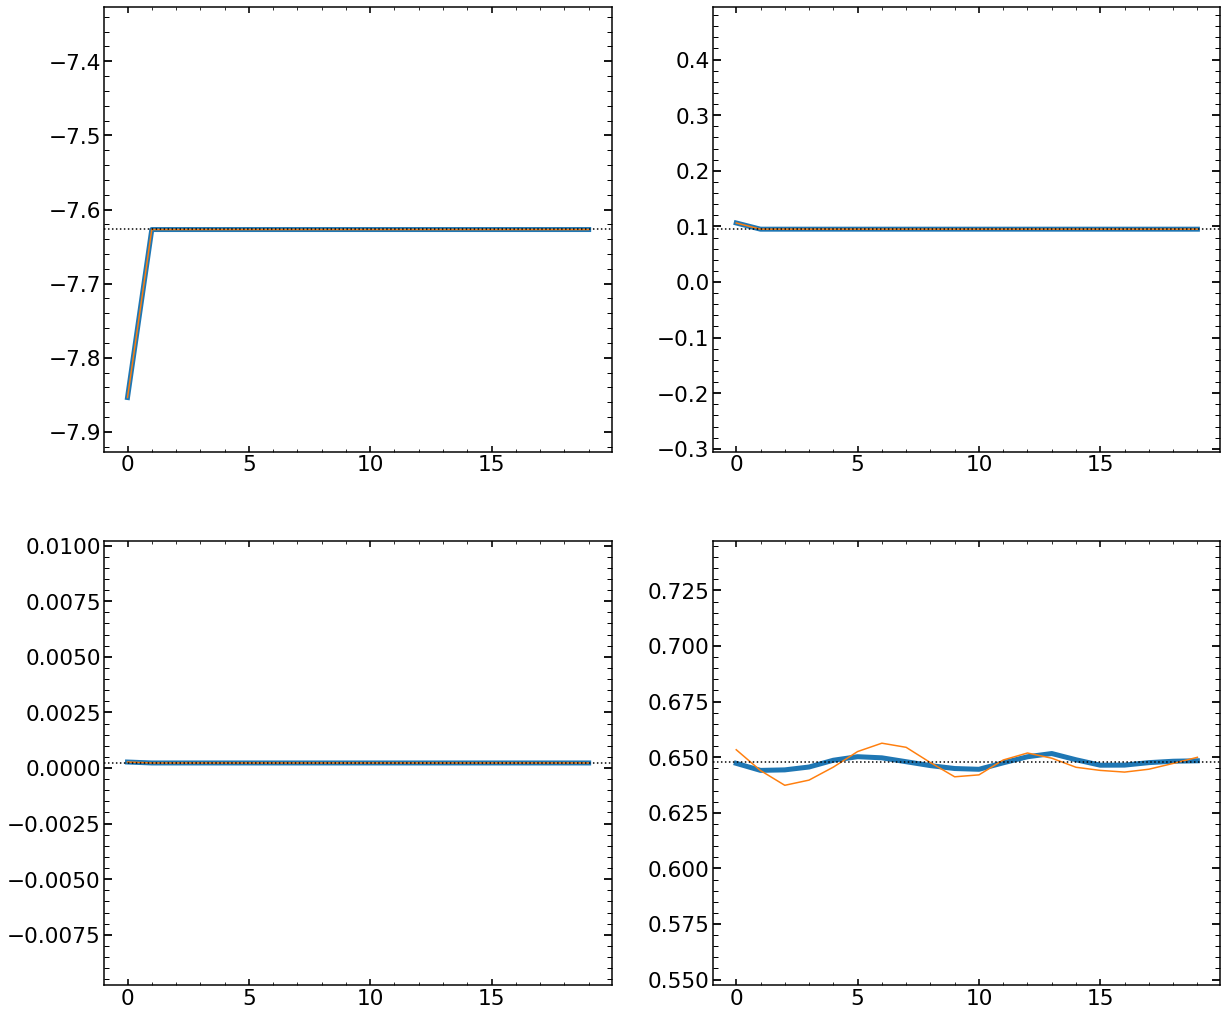

In [1122]:
# wavefront paramter
plt.figure(figsize=(20,18))
i=0*2
plt.subplot(221)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,78][:,i],lw=5)
plt.plot(chain0_swarm_1[:,28][:,i])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,i])
plt.ylim(minchain_parametrization[0]-0.3,minchain_parametrization[0]+0.3)
plt.axhline(minchain_parametrization[0],ls=':',color='black')

plt.subplot(222)
#  paramter 2 (z5)

#mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,78][:,2],lw=5)
plt.plot(chain0_swarm_1[:,28][:,2])

plt.ylim(minchain_parametrization[2]-0.4,minchain_parametrization[2]+0.4)
plt.axhline(minchain_parametrization[2],ls=':',color='black')

plt.subplot(223)
# two different walkers, parameter 89
plt.plot(chain0_swarm_1[:,78][:,89],lw=5)
plt.plot(chain0_swarm_1[:,28][:,89])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,89])
plt.ylim(mean_one_walker-0.01,mean_one_walker+0.01)
plt.axhline(minchain_parametrization[89],ls=':',color='black')

plt.subplot(224)
# two different walkers, parameter hsc_frac
plt.plot(chain0_swarm_1[:,78][:,19*2],lw=5)
plt.plot(chain0_swarm_1[:,28][:,19*2])

mean_one_walker=np.mean(chain0_swarm_1[:,78][:,19*2])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.axhline(minchain_parametrization[19*2],ls=':',color='black')

In [1360]:

list_of_image_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_image_0_1_0.npy',allow_pickle=True)
#uber_list_of_input_parameters_1_0
#uber_M0_std_1_0
#list_of_pre_chi2_1_0
#list_of_initial_model_result_1_0
#list_of_initial_input_parameters_1_0
#list_of_image_0_1_0
#pre_input_parameters.npy
#list_of_var_images.npy
#list_of_sci_images.npy
#list_of_sci_image_std.npy
#list_of_mask_images.npy
list_of_sci_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_sci_images.npy',allow_pickle=True)
list_of_var_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_var_images.npy',allow_pickle=True)
uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_std.npy',allow_pickle=True)
# parametrization before the run
#initial_input_parameterization=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1620/initial_input_parameterization_1.npy')
#list_of_initial_model_result=
#list_of_image_0=
#list_of_initial_input_parameters=
#list_of_pre_chi2=
allparameters_parametrization_proposal=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/allparameters_parametrization_proposal.npy')
initial_input_parameterization_1_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/initial_input_parameterization_1_0.npy')
list_of_initial_model_result=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_initial_model_result_1_0.npy')
uber_images_normalized=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_images_normalized_1_0.npy')

uber_list_of_input_parameters_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_list_of_input_parameters_1_0.npy')
out_images_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/out_images_1_0.npy',allow_pickle=True)
out_parameters_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/out_parameters_1_0.npy',allow_pickle=True)
allparameters_parametrization_proposal_after_iteration_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/allparameters_parametrization_proposal_after_iteration_1_0.npy')

list_of_initial_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_initial_input_parameters_1_0.npy')
array_of_delta_z_parametrizations=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/array_of_delta_z_parametrizations_1_0.npy')

uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_std.npy')

uber_images_normalized=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_images_normalized_1_0.npy')
# science images
uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_I.npy')
#initial model
uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_M0_1_0.npy')

first_proposal_Tokovnin_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/first_proposal_Tokovnin_std1_0.npy')


uber_M_final=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_M_final_1_0.npy')

# modified images, moved one parameter
#uber_images_normalized_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2120/uber_images_normalized_std_1_0.npy')

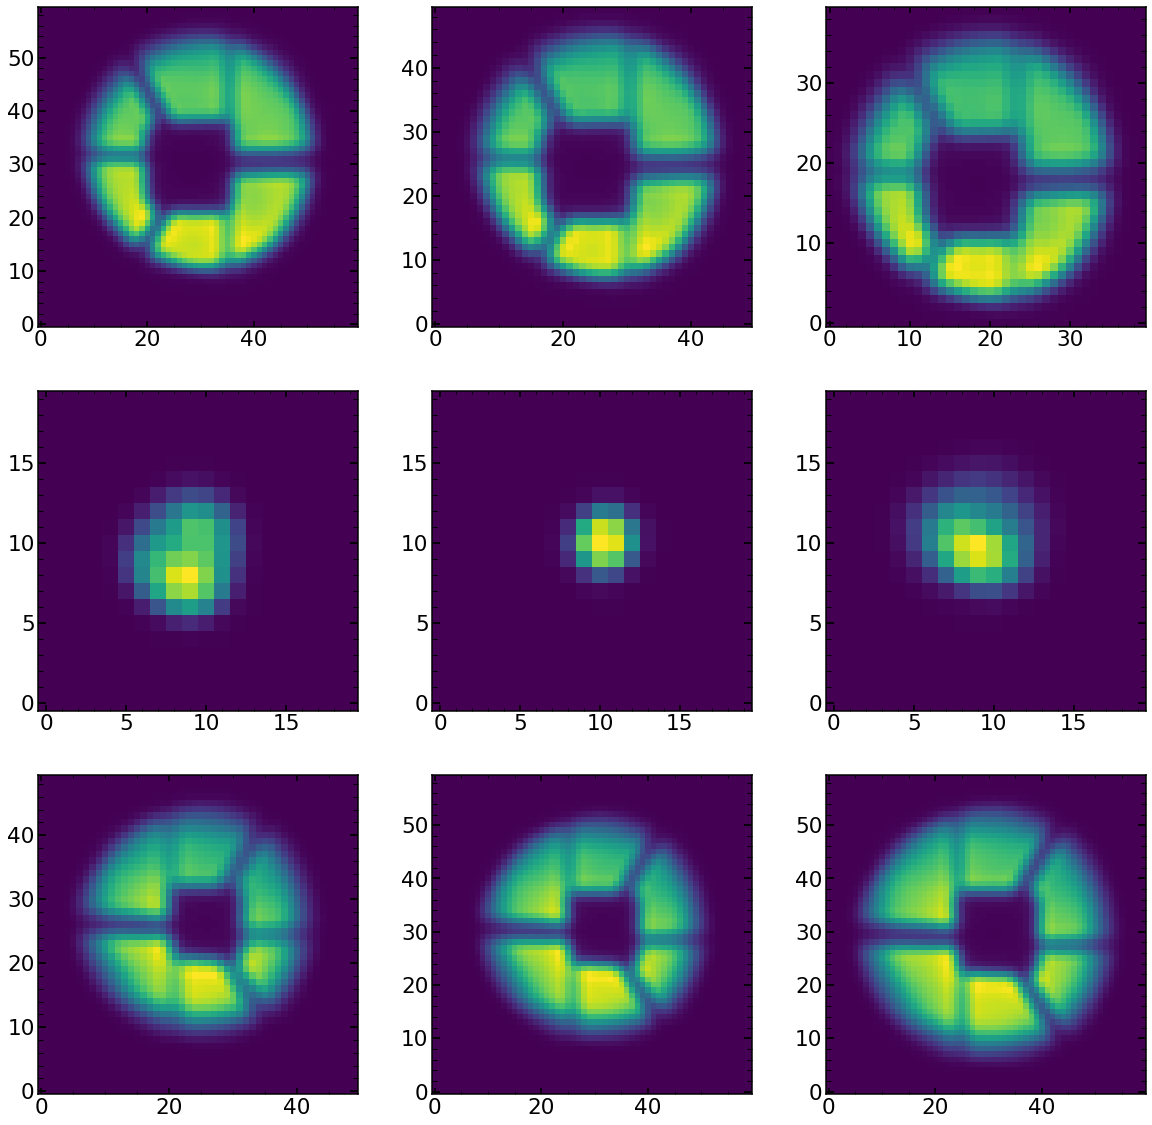

In [1101]:
i=0
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(list_of_sci_images[0])

plt.subplot(332)
plt.imshow(list_of_sci_images[1])

plt.subplot(333)
plt.imshow(list_of_sci_images[2])

plt.subplot(334)
plt.imshow(list_of_sci_images[3])

plt.subplot(335)
plt.imshow(list_of_sci_images[4])

plt.subplot(336)
plt.imshow(list_of_sci_images[5])

plt.subplot(337)
plt.imshow(list_of_sci_images[6])

plt.subplot(338)
plt.imshow(list_of_sci_images[7])

plt.subplot(339)
plt.imshow(list_of_sci_images[8])

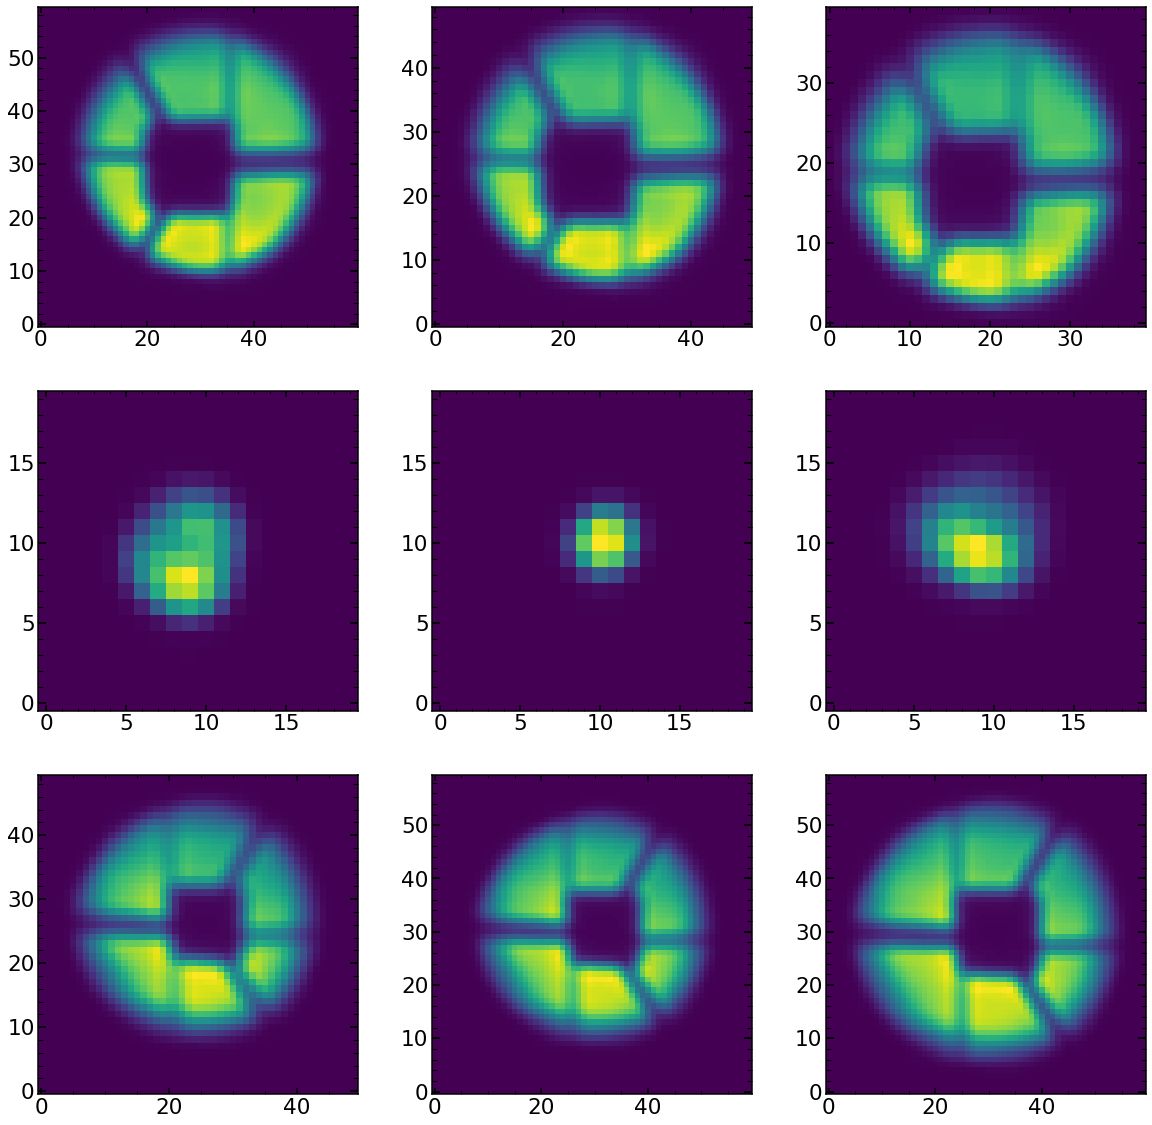

In [1102]:
i=0
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(list_of_image_0[0])

plt.subplot(332)
plt.imshow(list_of_image_0[1])

plt.subplot(333)
plt.imshow(list_of_image_0[2])

plt.subplot(334)
plt.imshow(list_of_image_0[3])

plt.subplot(335)
plt.imshow(list_of_image_0[4])

plt.subplot(336)
plt.imshow(list_of_image_0[5])

plt.subplot(337)
plt.imshow(list_of_image_0[6])

plt.subplot(338)
plt.imshow(list_of_image_0[7])

plt.subplot(339)
plt.imshow(list_of_image_0[8])

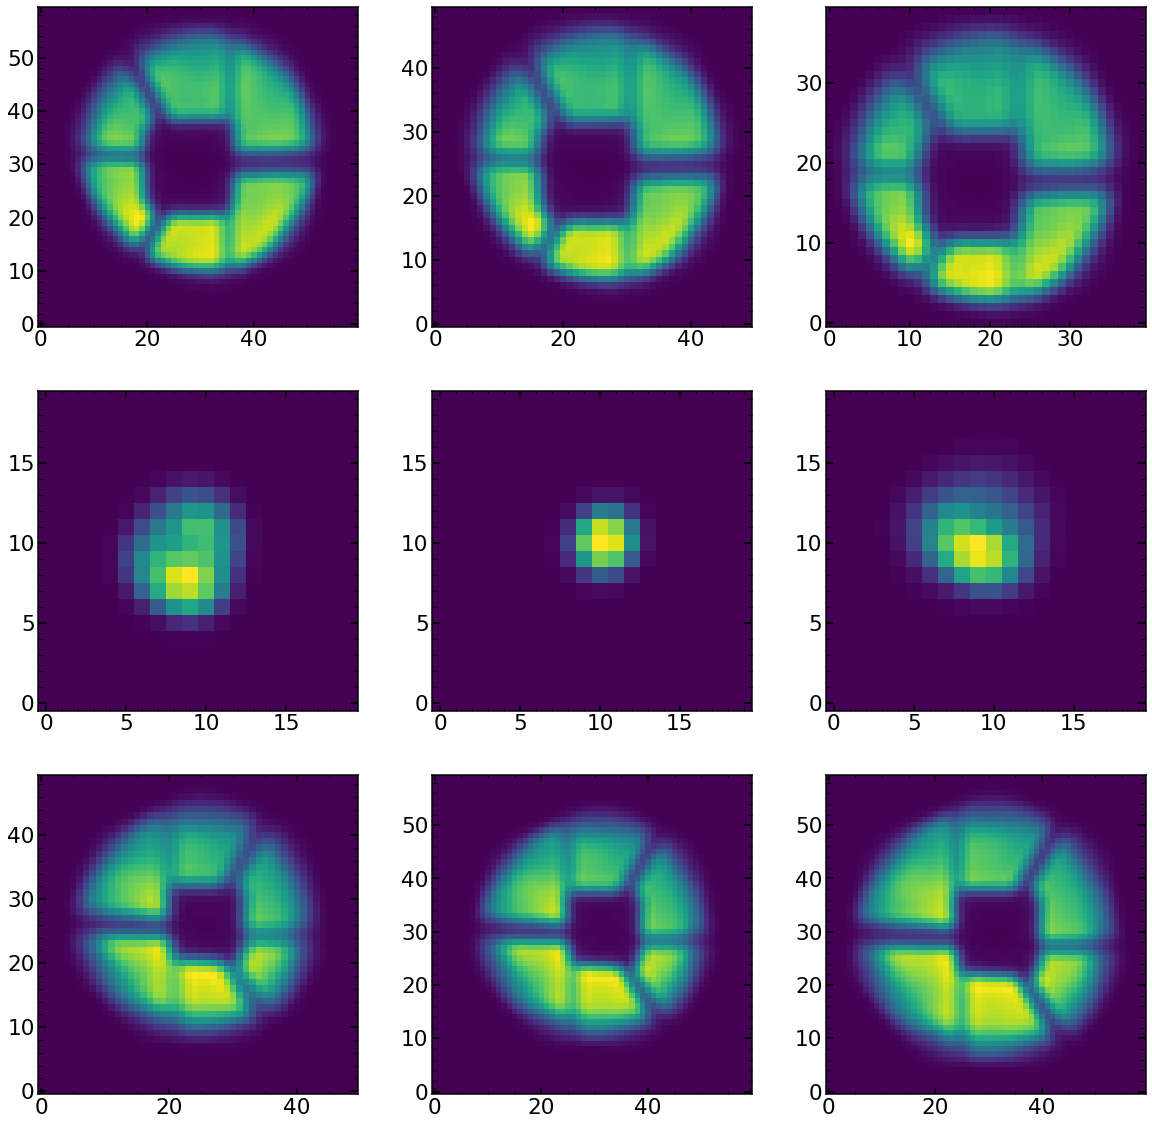

In [1103]:
i=70
plt.figure(figsize=(20,20))

plt.subplot(331)
plt.imshow(out_images_1[i][0])

plt.subplot(332)
plt.imshow(out_images_1[i][1])

plt.subplot(333)
plt.imshow(out_images_1[i][2])

plt.subplot(334)
plt.imshow(out_images_1[i][3])

plt.subplot(335)
plt.imshow(out_images_1[i][4])

plt.subplot(336)
plt.imshow(out_images_1[i][5])

plt.subplot(337)
plt.imshow(out_images_1[i][6])

plt.subplot(338)
plt.imshow(out_images_1[i][7])

plt.subplot(339)
plt.imshow(out_images_1[i][8])


In [1088]:
# input parametrization
allparameters_parametrization_proposal[0:5]

array([-7.85361627,  0.1890123 ,  0.10613834,  0.42690293,  0.04838818])

In [1089]:
# input still
initial_input_parameterization_1_0[:5]

array([-7.85361627,  0.1890123 ,  0.10613834,  0.42690293,  0.04838818])

In [1090]:
# deltas
array_of_delta_z_parametrizations[:5]

array([-0.00960682,  0.03603808,  0.00870969, -0.08112363,  0.04305407])

In [1091]:
allparameters_parametrization_proposal_after_iteration_1

array([   -7.696     ,     0.17115856,     0.09714411,     0.4046593 ,
           0.04929193,    -0.48986096,    -0.00505   ,     0.59930101,
           0.00353728,     0.06152943,     0.0078904 ,    -0.04038938,
           0.03347934,    -0.31248126,     0.0189109 ,    -0.37428655,
          -0.00155417,     0.00416335,    -0.00383127,    -0.10535744,
           0.01587231,     0.01436654,     0.00713199,     0.02605137,
          -0.0015016 ,    -0.01957269,    -0.00591173,    -0.00798497,
          -0.00638005,     0.00037533,    -0.00346483,    -0.00447738,
           0.00158178,    -0.02263747,    -0.00442931,     0.01185021,
          -0.00202657,     0.03191387,     0.64763255,     0.07972058,
          -0.07504414,    -0.06657529,     0.05511363,     0.02942104,
           0.00001627,     0.00001627,     0.97483602,     0.94833824,
           0.02253383,    -0.03586997,     0.9313411 ,     0.06865397,
           0.42454705,     1.0291687 ,     0.27632026, 87381.13193628,
      

In [1092]:
first_proposal_Tokovnin_std

array([ 0.2251661 , -0.02550534, -0.0128489 , -0.03177662,  0.00129107,
        0.07635365, -0.00255499, -0.10006629,  0.00039343,  0.00039403,
       -0.00204775, -0.0007689 , -0.00312084,  0.01063066, -0.01163393,
        0.00164418, -0.00140546, -0.00193954,  0.00009023,  0.00355481,
       -0.00068305, -0.00262903, -0.00046891, -0.00324132,  0.00049399,
        0.0000335 ,  0.00139055,  0.01056963,  0.0017802 , -0.00247858,
        0.00133021,  0.00511037, -0.00137082,  0.00296657, -0.00273119,
       -0.00477004, -0.00557113,  0.00489692, -0.00007062, -0.00131154,
        0.00000455, -0.00049703, -0.00025255, -0.0007124 , -0.00033792,
        0.00282876, -0.00014002,  0.00094185,  0.00042557,  0.00112377,
       -0.00028968,  0.00041283,  0.00009064, -0.00065414, -0.00011037,
        0.00008427, -0.00034411,  0.0029459 ,  0.00005496,  0.00112936,
       -0.00020929, -0.00312246,  0.00026622,  0.001352  ,  0.00045452,
        0.00224512, -0.00011131, -0.0002332 , -0.00009004, -0.00

In [1098]:
IM_final=np.sum(np.abs(np.array(uber_I)-np.array(uber_M_final)))
IM_final

IM_start=np.sum(np.abs(np.array(uber_I)-np.array(uber_M0)))  

print(IM_start)
print(IM_final)

18779502.0
193781500.0


In [977]:
list_of_initial_input_parameters[0]

array([   31.60347737,     0.00234957,    -0.73686124,     0.68239345,
           0.0482061 ,    -0.07714643,    -0.46257843,    -0.48365609,
           0.00780241,    -0.09226808,    -0.04919495,    -0.00152062,
          -0.01220658,     0.01215675,     0.03261509,     0.00952929,
          -0.03487949,     0.02525915,     0.02099311,     0.64763255,
           0.07972058,    -0.07504414,    -0.06657529,     0.05511363,
           0.02942104,     0.00001627,     0.00001627,     0.97483602,
           0.94833824,     0.02253383,    -0.03586997,     0.9313411 ,
           0.06865397,     0.42454705,     1.0291687 ,     0.27632026,
       87381.13193628,     2.38689243,     0.00235943,     0.35323491,
           1.82265232,     1.        ,    -0.00384726,    -0.00080563,
          -0.00211594,    -0.0127458 ,    -0.00883014,     0.01208438,
           0.00105795,     0.00880716,     0.00448567,    -0.00573166,
          -0.00123286,     0.01018481,    -0.0004959 ,    -0.00910544,
      

In [978]:
list_of_minchain[0]

array([   30.66675729,    -0.00412966,    -0.65067649,     0.58428509,
           0.04980397,    -0.072949  ,    -0.44855507,    -0.46224749,
           0.00747463,    -0.07924748,    -0.04913092,    -0.00359824,
          -0.01078687,     0.01274981,     0.02885293,     0.0082431 ,
          -0.03059624,     0.02289192,     0.02050776,     0.64763255,
           0.07972058,    -0.07504414,    -0.06657529,     0.05511363,
           0.02942104,     0.00001627,     0.00001627,     0.97483602,
           0.94833824,     0.02253383,    -0.03586997,     0.9313411 ,
           0.06865397,     0.42454705,     1.0291687 ,     0.27632026,
       87381.13193628,     2.38689243,     0.00235943,     0.35323491,
           1.82265232,     1.00000022,    -0.00397035,    -0.00080248,
          -0.00182131,    -0.01142717,    -0.00744409,     0.0103055 ,
           0.00142023,     0.00751632,     0.00443184,    -0.00551814,
          -0.00063624,     0.00890376,    -0.00049597,    -0.00793521,
      

In [956]:
array_of_delta_z_parametrizations

array([-0.01279227, -0.08878525,  0.00992161,  0.03342648,  0.02113212,
        0.06467836, -0.0067607 , -0.17849823,  0.01981397, -0.02053596,
        0.00506664,  0.05370749, -0.02895834, -0.04864826, -0.02150963,
       -0.06676284, -0.00141488, -0.01093652, -0.00657964, -0.04329191,
       -0.00480913,  0.00285908,  0.00158413,  0.03932109, -0.0049412 ,
       -0.08802754,  0.00743671,  0.05708732,  0.00378041,  0.01199105,
        0.00064708,  0.08505965,  0.00010693, -0.06825925,  0.00677211,
        0.05651812,  0.00131906, -0.03740536, -0.0012857 ,  0.00348546,
       -0.01124107, -0.01322502,  0.00738952, -0.03175367, -0.00244605,
        0.00301422, -0.00083436, -0.05069519, -0.00585278, -0.06612665,
       -0.00582187,  0.02504635,  0.0059894 , -0.01494621, -0.00050327,
        0.01793705,  0.00423263,  0.02753005, -0.00450338, -0.01887094,
        0.00294612,  0.0057435 , -0.01895073, -0.04275837,  0.00815797,
        0.01899452, -0.00439188,  0.020004  , -0.00428577, -0.06

In [1077]:
H_std=np.transpose(np.array((uber_images_normalized-uber_M0))/array_of_delta_z_parametrizations[:,None])/uber_std.ravel()[:,None] 

In [1078]:
#HHt=np.matmul(np.transpose(H),H)
HHt_std=np.matmul(np.transpose(H_std),H_std) 
print('svd thresh is '+str(thresh))
#invHHt=svd_invert(HHt,thresh)
thresh=0.01
invHHt_std=np.linalg.inv(HHt_std)
#invHHt_std=svd_invert(HHt_std,thresh)

#invHHtHt=np.matmul(invHHt,np.transpose(H))
invHHtHt_std=np.matmul(invHHt_std,np.transpose(H_std))


# I is uber_I now (science images)
# M0 is uber_M0 now (set of models before the iteration)
#first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,(uber_I-uber_M0)/uber_std.ravel()) 

svd thresh is 6


In [1079]:
invHHt_std.shape

(106, 106)

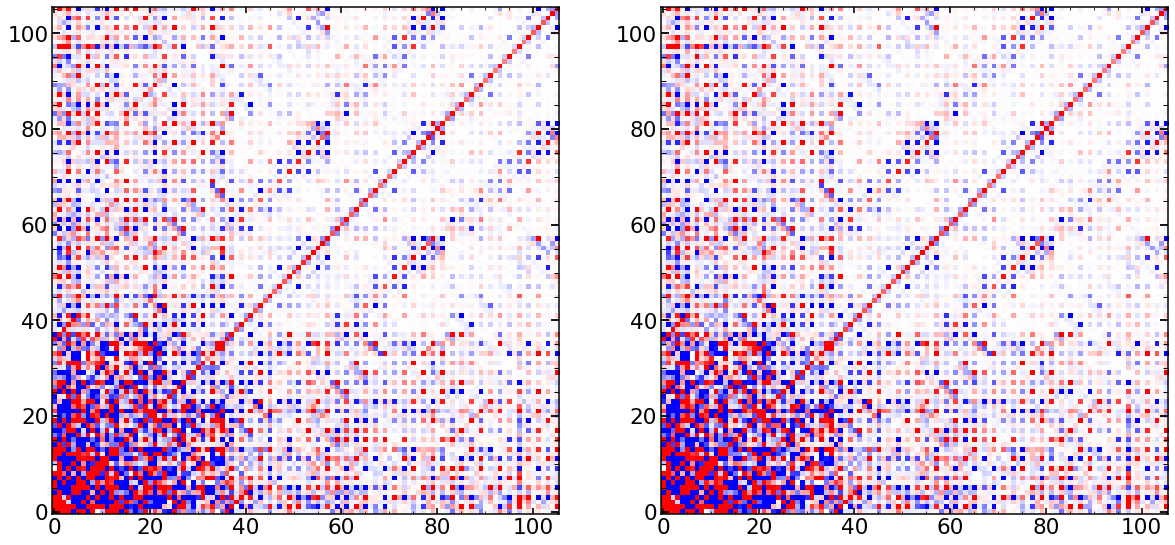

In [1080]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.imshow(invHHt_std,cmap='bwr',vmin=-np.quantile(invHHt_std,0.95),vmax=np.quantile(invHHt_std,0.95))

plt.subplot(122)
plt.imshow(np.linalg.inv(HHt_std),cmap='bwr',vmin=-np.quantile(invHHt_std,0.95),vmax=np.quantile(invHHt_std,0.95))

In [1081]:
first_proposal_Tokovnin_std

array([ 0.22597218, -0.01966227, -0.00704067, -0.03806191,  0.0085686 ,
        0.0842239 ,  0.00285495, -0.06497307,  0.00086626,  0.01190155,
        0.00070073, -0.01109396, -0.00321597,  0.00234889, -0.01560559,
        0.00405681, -0.0013918 , -0.00776699, -0.00150923,  0.01003644,
        0.00081955,  0.02040834,  0.00340486, -0.00178261, -0.00008547,
       -0.00418762,  0.00020558,  0.00006506,  0.00103013,  0.00043174,
        0.00049277,  0.00377988, -0.0008348 , -0.00231724,  0.00086666,
        0.00062243, -0.00291437,  0.00323462,  0.00010056,  0.00148263,
       -0.00073583, -0.00083945,  0.00046266, -0.00124155, -0.00031712,
        0.00334019,  0.00011385, -0.00019844,  0.00032355, -0.00239057,
       -0.00031915,  0.00056943,  0.00063376, -0.00001782,  0.00017549,
        0.0012401 ,  0.00030932,  0.00110201,  0.00005301,  0.00088339,
        0.00012173, -0.00282953, -0.00044914, -0.0010831 ,  0.00000569,
        0.00130851, -0.0001108 ,  0.00058136, -0.00013702, -0.00

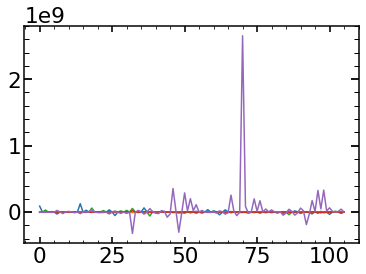

In [965]:
plt.plot(HHt_std[:,0])

plt.plot(HHt_std[:,1])

plt.plot(HHt_std[:,2])
plt.plot(HHt_std[:,3])

plt.plot(HHt_std[:,70])

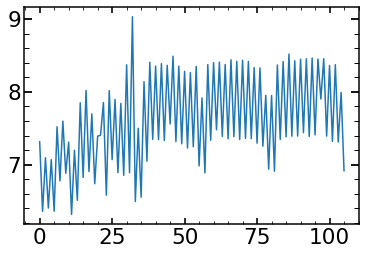

In [966]:
list_of_std=[]
for i in range(106):
    list_of_std.append(np.std(HHt_std[:,i]))
    
plt.plot(np.log10(list_of_std))

In [738]:
invHHt_std

array([[ 0.00000005, -0.        ,  0.00000006, ...,  0.        ,
         0.0000002 ,  0.00000002],
       [-0.        ,  0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [ 0.00000006, -0.        ,  0.00000006, ...,  0.        ,
         0.00000022,  0.00000003],
       ...,
       [ 0.        , -0.        ,  0.        , ...,  0.        ,
         0.00000001,  0.        ],
       [ 0.0000002 , -0.        ,  0.00000022, ...,  0.00000001,
         0.00000079,  0.0000001 ],
       [ 0.00000002, -0.        ,  0.00000003, ...,  0.        ,
         0.0000001 ,  0.00000001]])

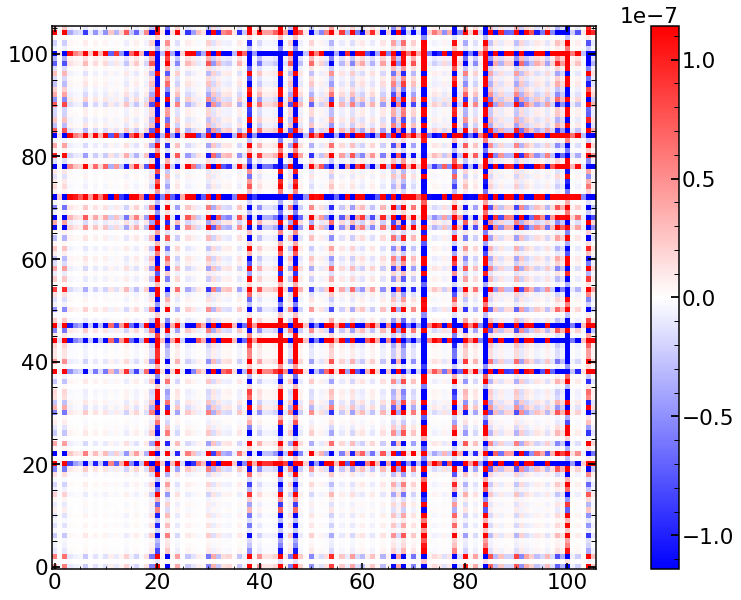

In [739]:
plt.figure(figsize=(20,10))
plt.imshow(invHHt_std,vmax=np.quantile(invHHt_std,0.95),vmin=-np.quantile(invHHt_std,0.95),cmap='bwr')
plt.colorbar()

array([[40639.35973775,  6267.60336019, -7945.25919137, ...,
          843.64253654,   473.90781797,  -198.2871668 ],
       [ 6267.60335966, 32213.82435608,  2972.29170591, ...,
          306.37567024,  -244.942471  ,   605.23301979],
       [-7945.2591974 ,  2972.29170577, 74012.7947618 , ...,
         -359.84445161,   413.36267462,   483.31265067],
       ...,
       [  843.64253691,   306.37567022,  -359.8444528 , ...,
        14545.20991961,   -21.71312435,  -138.34171718],
       [  473.90781772,  -244.94247098,   413.36267807, ...,
          -21.71312434,  1597.00497109,   199.49151558],
       [ -198.28716638,   605.23301963,   483.3126548 , ...,
         -138.3417172 ,   199.49151614, 21302.4253281 ]])

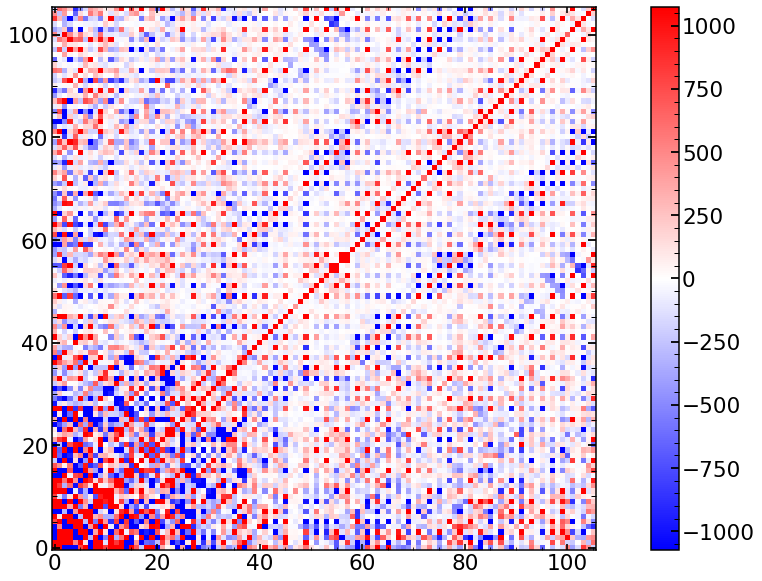

In [741]:
plt.figure(figsize=(20,10))
plt.imshow(np.linalg.inv(HHt_std),vmax=np.quantile(np.linalg.inv(HHt_std),0.95),vmin=-np.quantile(np.linalg.inv(HHt_std),0.95),cmap='bwr')
plt.colorbar()

In [742]:
np.linalg.inv(HHt_std)

array([[40639.35973775,  6267.60336019, -7945.25919137, ...,
          843.64253654,   473.90781797,  -198.2871668 ],
       [ 6267.60335966, 32213.82435608,  2972.29170591, ...,
          306.37567024,  -244.942471  ,   605.23301979],
       [-7945.2591974 ,  2972.29170577, 74012.7947618 , ...,
         -359.84445161,   413.36267462,   483.31265067],
       ...,
       [  843.64253691,   306.37567022,  -359.8444528 , ...,
        14545.20991961,   -21.71312435,  -138.34171718],
       [  473.90781772,  -244.94247098,   413.36267807, ...,
          -21.71312434,  1597.00497109,   199.49151558],
       [ -198.28716638,   605.23301963,   483.3126548 , ...,
         -138.3417172 ,   199.49151614, 21302.4253281 ]])

In [1028]:
#invHHtHt=np.matmul(invHHt,np.transpose(H))
invHHtHt_std=np.matmul(np.linalg.inv(HHt_std),np.transpose(H_std))


# I is uber_I now (science images)
# M0 is uber_M0 now (set of models before the iteration)
#first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,uber_I_std-uber_M0_std)
first_proposal_Tokovnin_std

array([-0.00000002,  0.00000001, -0.00000001,  0.00000018, -0.00000004,
       -0.00000004, -0.00000001, -0.00000001, -0.00000001,  0.00000003,
       -0.00000001,  0.00000004, -0.00000003, -0.00000012, -0.00000004,
       -0.00000008,  0.        ,  0.00000002,  0.        , -0.00000005,
       -0.00000001, -0.00000002,  0.        , -0.        ,  0.00000001,
       -0.00000002,  0.00000001, -0.00000001,  0.00000001,  0.00000002,
       -0.        ,  0.00000001,  0.        , -0.00000002, -0.        ,
        0.00000001,  0.00000002,  0.00000003,  0.        ,  0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        , -0.00000001,
       -0.        , -0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.00

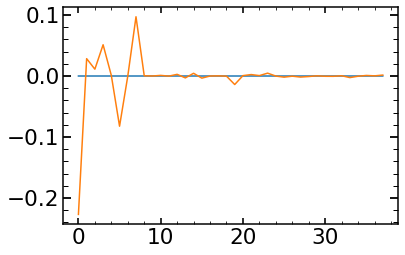

In [1029]:
plt.plot(-first_proposal_Tokovnin_std[0:38])
plt.plot(initial_input_parameterization[0:38]-minchain_parametrization[0:38])


In [1099]:
minchain_parametrization[0:38]

array([-7.62654872,  0.16056239,  0.09493409,  0.37560671,  0.04743266,
       -0.46094586, -0.00303878,  0.57212998,  0.00285846,  0.0612378 ,
        0.00831685, -0.03968159,  0.03293613, -0.31681056,  0.02257466,
       -0.37194885, -0.00055462,  0.00525614, -0.00365375, -0.09386249,
        0.01574472,  0.01384797,  0.00680921,  0.02363862, -0.00172736,
       -0.01769629, -0.00659394, -0.01362594, -0.00675819,  0.00182017,
       -0.00394622, -0.00754178,  0.00212247, -0.02210636, -0.00215161,
        0.01428548,  0.00161138,  0.02695326])

In [1027]:
initial_input_parameterization[0:38]+first_proposal_Tokovnin_std[0:38]

array([-7.62764409,  0.16935003,  0.09909767,  0.38884102,  0.05695678,
       -0.45908461, -0.00040656,  0.60437435,  0.00412814,  0.07315516,
        0.01002455, -0.05094512,  0.03244796, -0.31757383,  0.01144907,
       -0.37138066, -0.00196214, -0.00224596, -0.00540366, -0.09780936,
        0.01717001,  0.03661521,  0.01086509,  0.02653767, -0.00193287,
       -0.02378376, -0.00667953, -0.01531865, -0.00659606,  0.00254207,
       -0.00390321, -0.00427476,  0.00170656, -0.0270313 , -0.00165082,
        0.01581166, -0.00104115,  0.03172064])

In [751]:
sci_image_test=np.array([[1.1*a1+2.1*a2+3.1*a3,1.1*a1+2.1*a2+3.1*a3,1.1*a1+2.1*a2+3.1*a3],\
          [0.1*a1+2.1*a2+3.1*a3,1.1*a1+0.1*a2+3.1*a3,1.1*a1+2.1*a2+0.1*a3],\
          [1.1*a1-2.1*a2+3.1*a3,1.1*a1+2.1*a2-3.1*a3,1.1*a1-2.1*a2-3.1*a3]])

## completly fake 

### simples 

In [758]:
z1=np.array([[1,0,0],[0,2,0],[0,0,1]])
z2=np.array([[0,0,1],[0,2,0],[1,0,0]])
z3=np.array([[0,1,1],[2,2,2],[1,-1,0]])

In [816]:
a1=1
a2=1.1
a3=1.2

I=a1*z1+a2*z2+a3*z3
print(I)
I=I.ravel()

[[ 1.   1.2  2.3]
 [ 2.4  6.6  2.4]
 [ 2.3 -1.2  1. ]]


In [817]:
a0_v=[1,1,1]
a1_v=[1.1,1.1,1.1]

M_0=a0_v[0]*z1+a0_v[1]*z2+a0_v[2]*z3
M_1=a1_v[0]*z1+a1_v[1]*z2+a1_v[2]*z3

print(M_0)
print(M_1)

M_0=M_0.ravel()
M_1=M_1.ravel()

print(M_0)
print(M_1)


print(M_0)
print(M_1)

[[ 1  1  2]
 [ 2  6  2]
 [ 2 -1  1]]
[[ 1.1  1.1  2.2]
 [ 2.2  6.6  2.2]
 [ 2.2 -1.1  1.1]]
[ 1  1  2  2  6  2  2 -1  1]
[ 1.1  1.1  2.2  2.2  6.6  2.2  2.2 -1.1  1.1]
[ 1  1  2  2  6  2  2 -1  1]
[ 1.1  1.1  2.2  2.2  6.6  2.2  2.2 -1.1  1.1]


In [818]:
H=np.zeros((9,3))

M_1=a1_v[0]*z1+a0_v[1]*z2+a0_v[2]*z3
M_1=M_1.ravel()

H[:,0]=(M_1-M_0)/0.1

M_1=a0_v[0]*z1+a1_v[1]*z2+a0_v[2]*z3
M_1=M_1.ravel()
H[:,1]=(M_1-M_0)/0.1

M_1=a0_v[0]*z1+a0_v[1]*z2+a1_v[2]*z3
M_1=M_1.ravel()

H[:,2]=(M_1-M_0)/0.1

H

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  1.],
       [ 0.,  0.,  2.],
       [ 2.,  2.,  2.],
       [ 0.,  0.,  2.],
       [ 0.,  1.,  1.],
       [ 0.,  0., -1.],
       [ 1.,  0.,  0.]])

In [819]:
HHt=np.matmul(np.transpose(H),H)

print('svd thresh is '+str(thresh))
invHHt=svd_invert(HHt,thresh)

invHHt=np.linalg.inv(HHt)
invHHtHt=np.matmul(invHHt,np.transpose(H))



# I is uber_I now (science images)
# M0 is uber_M0 now (set of models before the iteration)
first_proposal_Tokovnin=np.matmul(invHHtHt,I-M_0)
first_proposal_Tokovnin

svd thresh is 0.05
WS[   0]    20.755444176
WS[   1]     5.489058900
WS[   2]     1.755496924
0 singular values rejected in inversion


array([0. , 0.1, 0.2])

In [820]:
I-M_0

array([ 0. ,  0.2,  0.3,  0.4,  0.6,  0.4,  0.3, -0.2,  0. ])

### std 

In [1034]:
z1=np.array([[10000,10000,10000],[10000,20000,10000],[10000,10000,10000]])
z2=np.array([[10000,20000,30000],[10000,20000,10000],[30000,20000,10000]])
z3=np.array([[0,10000,10000],[20000,20000,20000],[10000,-10000,0]])

In [1035]:
a1=1
a2=1.1
a3=1.2

I=a1*z1+a2*z2+a3*z3
std=np.sqrt(I+40)

print(I)
print(I_std)
I=I.ravel()
I_std=I_std.ravel()

[[21000. 44000. 55000.]
 [45000. 66000. 45000.]
 [55000. 20000. 21000.]]
[144.7759512  209.66648833 234.43555419 212.03781626 256.82683705
 212.03781626 234.43555419 141.28014666 144.7759512 ]


In [1036]:
std

array([[145.05171492, 209.85709423, 234.60605278],
       [212.22629432, 256.98248968, 212.22629432],
       [234.60605278, 141.56270695, 145.05171492]])

In [1037]:
a0_v=[1,1,1]
a1_v=[1.1,1.1,1.1]

M_0=a0_v[0]*z1+a0_v[1]*z2+a0_v[2]*z3
M_1=a1_v[0]*z1+a1_v[1]*z2+a1_v[2]*z3

M_0_std=M_0/std

print(M_0)
print(M_1)

M_0=M_0.ravel()
M_1=M_1.ravel()

print(M_0)
print(M_1)


print(M_0)
print(M_1)

[[20000 40000 50000]
 [40000 60000 40000]
 [50000 20000 20000]]
[[22000. 44000. 55000.]
 [44000. 66000. 44000.]
 [55000. 22000. 22000.]]
[20000 40000 50000 40000 60000 40000 50000 20000 20000]
[22000. 44000. 55000. 44000. 66000. 44000. 55000. 22000. 22000.]
[20000 40000 50000 40000 60000 40000 50000 20000 20000]
[22000. 44000. 55000. 44000. 66000. 44000. 55000. 22000. 22000.]


In [1038]:
uber_images_fake=[]

H=np.zeros((9,3))

M_1=a1_v[0]*z1+a0_v[1]*z2+a0_v[2]*z3
M_1=M_1.ravel()
uber_images_fake.append(M_1)
H[:,0]=(M_1-M_0)/(0.1*std.ravel())

M_1=a0_v[0]*z1+a1_v[1]*z2+a0_v[2]*z3
M_1=M_1.ravel()
uber_images_fake.append(M_1)
H[:,1]=(M_1-M_0)/(0.1*std.ravel())

M_1=a0_v[0]*z1+a0_v[1]*z2+a1_v[2]*z3
M_1=M_1.ravel()
uber_images_fake.append(M_1)
H[:,2]=(M_1-M_0)/(0.1*std.ravel())

H

uber_images_fake=np.array(uber_images_fake)

In [1039]:
# 11059, 106
H.shape

(9, 3)

In [1040]:
H

array([[ 68.94092914,  68.94092914,   0.        ],
       [ 47.65147462,  95.30294924,  47.65147462],
       [ 42.62464622, 127.87393865,  42.62464622],
       [ 47.11951472,  47.11951472,  94.23902945],
       [ 77.82631426,  77.82631426,  77.82631426],
       [ 47.11951472,  47.11951472,  94.23902945],
       [ 42.62464622, 127.87393865,  42.62464622],
       [ 70.64007333, 141.28014666, -70.64007333],
       [ 68.94092914,  68.94092914,   0.        ]])

In [1041]:
std

array([[145.05171492, 209.85709423, 234.60605278],
       [212.22629432, 256.98248968, 212.22629432],
       [234.60605278, 141.56270695, 145.05171492]])

In [1042]:
std.ravel()[:,None]

array([[145.05171492],
       [209.85709423],
       [234.60605278],
       [212.22629432],
       [256.98248968],
       [212.22629432],
       [234.60605278],
       [141.56270695],
       [145.05171492]])

In [1043]:
np.transpose((uber_images_fake-M_0)/(np.array([0.1,0.1,0.1])[:,None]))/std.ravel()[:,None]

array([[ 68.94092914,  68.94092914,   0.        ],
       [ 47.65147462,  95.30294924,  47.65147462],
       [ 42.62464622, 127.87393865,  42.62464622],
       [ 47.11951472,  47.11951472,  94.23902945],
       [ 77.82631426,  77.82631426,  77.82631426],
       [ 47.11951472,  47.11951472,  94.23902945],
       [ 42.62464622, 127.87393865,  42.62464622],
       [ 70.64007333, 141.28014666, -70.64007333],
       [ 68.94092914,  68.94092914,   0.        ]])

In [1044]:
uber_images_normalized.shape

(106, 9521)

In [1045]:
uber_M0.shape

(9521,)

In [1046]:
np.transpose(((uber_images_normalized-uber_M0)/array_of_delta_z_parametrizations[:,None])).shape

(9521, 106)

In [1047]:
uber_images_fake.shape

(3, 9)

In [1070]:
def svd_invert(matrix,threshold):
    '''
    :param matrix:
    :param threshold:
    :return:SCD-inverted matrix
    '''
    # print 'MATRIX:',matrix
    u,ws,v = svd(matrix,full_matrices=True)

    #invw = inv(np.identity(len(ws))*ws)
    #return ws

    ww = np.max(ws)
    n = len(ws)
    invw = np.identity(n)
    ncount = 0

    for i in range(n):
        if ws[i] < ww*threshold:
            print('SVD_INVERT: Value %i=%.2e rejected (threshold=%.2e).'%(i,ws[i],ww*threshold))
            invw[i][i]= 0.
            ncount+=1
        else:
            print('WS[%4i] %15.9f'%(i,ws[i]))
            invw[i][i] = 1./ws[i]

    print('%i singular values rejected in inversion'%ncount)

    inv_matrix = np.dot(u , np.dot( np.transpose(invw), v))

    return inv_matrix

In [1069]:
HHt=np.matmul(np.transpose(H),H)
thresh=6
print('svd thresh is '+str(thresh))
invHHt=svd_invert(HHt,thresh)

#invHHt=np.linalg.inv(HHt)


invHHtHt=np.matmul(invHHt,np.transpose(H))



# I is uber_I now (science images)
# M0 is uber_M0 now (set of models before the iteration)
first_proposal_Tokovnin=np.matmul(invHHtHt,(I-M_0)/std.ravel())
first_proposal_Tokovnin

svd thresh is 6
SVD_INVERT: Value 0=1.16e+05 rejected (threshold=2.29e+04).
SVD_INVERT: Value 1=2.71e+04 rejected (threshold=2.29e+04).
WS[   2]  3808.333929101
2 singular values rejected in inversion


array([-0.06465889,  0.03506143,  0.01002185])

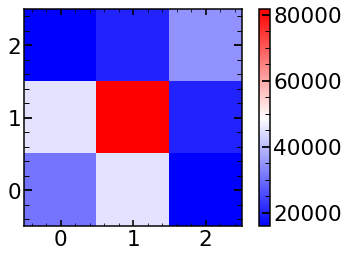

In [934]:
plt.imshow(HHt,cmap='bwr')
plt.colorbar()

In [862]:
(I-M_0)/std.ravel()

array([ 6.89409291, 19.06058985, 21.31232311, 23.55975736, 23.34789428,
       23.55975736, 21.31232311,  0.        ,  6.89409291])

In [846]:
np.sqrt(10000)

100.0

In [ ]:
I

In [1237]:
test_parametrization=np.array([   -7.652245 ,      0.38477876 ,    0.0518243 ,    -0.07178474,
     0.01520354  ,  -0.75695496  ,  -0.02474257 ,    0.73216007,
    -0.02328352,    -0.13555128 ,   -0.00083666,    -0.07407379,
     0.03450489 ,   -0.24333246,    -0.00052507 ,   -0.28378585,
     0.00452045,     0.05650787,    -0.00380985 ,   -0.01786846,
     0.02028833,     0.02242765,     0.00210499 ,    0.02845843,
    -0.00763072,    -0.02551726 ,   -0.00725833,     0.01597586,
    -0.00751358,     0.00406483 ,   -0.00169485 ,   -0.00430332,
     0.00338613,    -0.02214848 ,   -0.00035036,     0.03263369,
     0.00725385,     0.02476122 ,    0.55972211 ,    0.05661647,
     0.00263237,    -0.04980624 ,    0.04930434 ,   -0.08691375,
     0.0000143,      0.0000143  ,    0.97357764,     0.94833826,
    -0.08123967,    -0.02398006 ,    0.98752221,    -0.07377341,
     0.82147053,     1.05985395,     0.05022292, 46237.84826501,
     2.5563085 ,     0.00471053 ,    0.38978407,     1.76394154,
     0.99335083 ])

In [1307]:
res_gbests_position=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/chainSep2420_Single_P_21652476Neres_gbests_position.npy')
res_gbests_fitness=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/chainSep2420_Single_P_21652476Neres_gbests_fitness.npy')


In [1289]:
res_gbests_fitness

array([-68684.63936984, -68684.63936984, -39438.0875943 , -39438.0875943 ,
       -39438.0875943 , -39438.0875943 ])

In [1298]:
likechain_swarm_1[5]

array([  -44027.4398638 ,              -inf, -1146893.37682744,
        -241001.05920029,  -671593.3643217 ,  -816576.5129072 ,
                    -inf,              -inf,              -inf,
        -309709.93406129,  -428250.33049019,              -inf,
                    -inf,  -251019.81559366,              -inf,
        -107221.62646514,              -inf, -1440204.3723635 ,
       -1343739.02494619,              -inf,              -inf,
                    -inf,  -420429.2357915 ,  -763009.53454114,
        -443730.87058097,              -inf, -1508945.39336545,
                    -inf,  -916818.91963307,  -179193.81786258,
                    -inf,  -588110.60167166, -2965945.34413351,
       -1963848.31832943,              -inf,              -inf,
        -332109.10052205, -8455960.61478042, -1146050.60212827,
                    -inf,  -429425.30522048,  -336772.3442824 ,
                    -inf,              -inf,   -92391.80569734,
        -475624.04017491,  -285095.57835

In [1308]:
chain0_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/chainSep2420_Single_P_21652476NeSwarm1.npy')
likechain_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/likechainSep2420_Single_P_21652476NeSwarm1.npy')
chain0_velocity_swarm_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/chainSep2420_Single_P_21652476Nevelocity_Swarm1.npy')

list_of_swarms_time_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/chainSep2420_Single_P_21652476Ne_list_of_swarms_time_1.npy')

parInit1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/chainSep2420_Single_P_21652476NeparInit1.npy')


In [1309]:
list_of_swarms_time_1

array([[  1.        ,  88.84531379],
       [  2.        , 428.54645181],
       [  3.        , 438.45349264],
       [  4.        , 448.15192366],
       [  5.        , 460.05902505],
       [  6.        , 483.7400291 ],
       [  7.        , 721.75833178]])

In [1310]:
res_gbests_position[:,0]

array([-7.63051221, -7.65015323, -7.65015323, -7.65015323, -7.65015323,
       -7.65015323, -7.64999918])

In [1311]:
res_gbests_position[:,2]

array([0.0570173 , 0.04932286, 0.04932286, 0.04932286, 0.04932286,
       0.04932286, 0.04948264])

In [1312]:
chain0_velocity_swarm_1[0][1]

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,    -0.03114878,     0.00730173,
          -0.00423964,     0.12452011,    -0.00055414,     0.00527562,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.16488754,     0.10908089,     0.02355821,     0.04346307,
           0.1416821 ,    -0.00292332,     0.45010503, 19722.74947894,
      

In [1271]:
chain0_swarm_1[0][:,59]

array([1.79574275, 1.8780347 , 1.81201637, 1.79575611, 1.79325242,
       1.87970056, 1.89030879, 1.79607834, 1.84475381, 1.81291037,
       1.79517968, 1.79575628, 1.89469552, 1.79699861, 1.87220186,
       1.80858901, 1.8213734 , 1.77836004, 1.79950945, 1.81693312,
       1.80549893, 1.79364881, 1.81712557, 1.80324199, 1.86262302,
       1.81451151, 1.81096623, 1.92094462, 1.79366055, 1.87781616,
       1.7961161 , 1.8967172 , 1.80382359, 1.7964256 , 1.83704557,
       1.81717887, 1.83307193, 1.93908259, 1.78238765, 1.79672597,
       1.7937992 , 1.80103155, 1.7960624 , 1.95844874, 1.81243426,
       1.79295964, 1.84165076, 1.78841927, 1.79621946, 1.85916757,
       1.79574064, 1.8123174 , 1.84190782, 1.80856874, 1.81963913,
       1.78477198, 1.79169034, 1.85671712, 1.82183967, 1.79431454,
       1.78123863, 1.78507899, 1.79639146, 1.82109548, 1.81084236,
       1.82656621, 1.81006094, 1.7874851 , 1.82139025, 1.76700216,
       1.77196926, 1.81132474, 1.92153628, 1.80431756, 1.79178

### chain0_swarm_1[1][0]-chain0_swarm_1[1][1]

In [1263]:
    num_iter = 0
    random_seed=42
    for swarm in range(11):
        num_iter += 1
        print(num_iter)

1
2
3
4
5
6
7
8
9
10
11


In [1355]:

H_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/H_1_0.npy')

In [1356]:
H

array([[ 0.24170456,  0.08133189, -1.47911907, ..., -0.01445653,
        -2.95689032, 14.61825553],
       [ 0.23177032,  0.08677693, -1.48997335, ...,  0.01179141,
        -3.08029624, 14.75368452],
       [ 0.2282251 ,  0.10001607, -1.58672691, ...,  0.07326133,
        -3.31066115, 15.74074795],
       ...,
       [-1.0823977 , -0.11483462, -1.25491802, ...,  0.9839735 ,
         1.55927332,  0.02621072],
       [-0.97786256, -0.10314375, -1.16858859, ...,  0.94186159,
         1.47042222,  0.13626464],
       [-0.87659627, -0.09115881, -1.07862221, ...,  0.86357231,
         1.39702737,  0.14976846]])

In [1357]:
HHt_std=np.matmul(np.transpose(H_std),H_std) 

In [1358]:
invHHt_std=np.linalg.inv(HHt_std)

LinAlgError: Singular matrix

In [1368]:

list_of_image_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_image_0_1_0.npy',allow_pickle=True)
#uber_list_of_input_parameters_1_0
#uber_M0_std_1_0
#list_of_pre_chi2_1_0
#list_of_initial_model_result_1_0
#list_of_initial_input_parameters_1_0
#list_of_image_0_1_0
#pre_input_parameters.npy
#list_of_var_images.npy
#list_of_sci_images.npy
#list_of_sci_image_std.npy
#list_of_mask_images.npy
list_of_sci_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_sci_images.npy',allow_pickle=True)
list_of_var_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_var_images.npy',allow_pickle=True)
uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_std.npy',allow_pickle=True)
# parametrization before the run
#initial_input_parameterization=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep1620/initial_input_parameterization_1.npy')
#list_of_initial_model_result=
#list_of_image_0=
#list_of_initial_input_parameters=
#list_of_pre_chi2=
allparameters_parametrization_proposal=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/allparameters_parametrization_proposal.npy')
initial_input_parameterization_1_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/initial_input_parameterization_1_0.npy')
list_of_initial_model_result=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_initial_model_result_1_0.npy')
uber_images_normalized=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_images_normalized_1_0.npy')

uber_list_of_input_parameters_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_list_of_input_parameters_1_0.npy')
out_images_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/out_images_1_0.npy',allow_pickle=True)
out_parameters_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/out_parameters_1_0.npy',allow_pickle=True)
allparameters_parametrization_proposal_after_iteration_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/allparameters_parametrization_proposal_after_iteration_1_0.npy')

list_of_initial_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/list_of_initial_input_parameters_1_0.npy')
array_of_delta_z_parametrizations=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/array_of_delta_z_parametrizations_1_0.npy')

uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_std.npy')

uber_images_normalized=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_images_normalized_1_0.npy')
# science images
uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_I.npy')
#initial model
uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_M0_1_0.npy')

first_proposal_Tokovnin_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/first_proposal_Tokovnin_std1_0.npy')


uber_M_final=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2220/uber_M_final_1_0.npy')

# modified images, moved one parameter
#uber_images_normalized_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2120/uber_images_normalized_std_1_0.npy')

In [1424]:
initial_input_parameterization_1_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/initial_input_parameterization_1_0.npy')

In [1400]:
uber_images_normalized=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/uber_images_normalized_1_0.npy')
array_of_delta_all_parametrizations=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/array_of_delta_all_parametrizations_1_0.npy')

uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/uber_M0_1_0.npy')

In [1405]:
array_of_delta_all_parametrizations

array([  -0.01344036,   -0.1530908 ,    0.05573549,   -0.1134112 ,
         -0.01606049,   -0.05972818,   -0.01744121,    0.06699213,
          0.00425508,    0.05971022,   -0.03176949,    0.0981151 ,
          0.00159641,   -0.02829054,   -0.00989371,   -0.0962628 ,
          0.00433113,   -0.03259264,    0.00590194,   -0.03385648,
          0.0097394 ,   -0.03785924,   -0.00398388,   -0.01488963,
          0.0095645 ,   -0.0248135 ,    0.0024462 ,   -0.00803774,
         -0.01086117,    0.02580996,   -0.00543435,    0.00619318,
          0.005789  ,    0.03829969,    0.00000425,    0.03500249,
         -0.00596833,    0.05986717,    0.01      ,    0.002     ,
          0.01      ,    0.01      ,    0.01      ,    0.01      ,
          0.03      ,    0.1       ,    0.01      ,    0.01      ,
          0.015     ,    0.015     ,    0.01      ,    0.007     ,
          0.02      ,    0.005     ,    0.04      , 3000.        ,
          0.05      ,    0.001     ,    0.01      ,    0.005  

In [1420]:
np.transpose(np.vstack((np.array(columns[8:]),H[0][19*2:19*2+23])))

array([['hscFrac', '-18.15338134765625'],
       ['strutFrac', '-56.99920654296875'],
       ['dxFocal', '-275.5950927734375'],
       ['dyFocal', '-89.251708984375'],
       ['slitFrac', '1.94091796875'],
       ['slitFrac_dy', '10.614013671875'],
       ['radiometricEffect', '0.0'],
       ['radiometricExponent', '0.0'],
       ['x_ilum', '0.0'],
       ['y_ilum', '0.0'],
       ['x_fiber', '12.992350260416668'],
       ['y_fiber', '-63.503011067708336'],
       ['effective_ilum_radius', '-9.228515625'],
       ['frd_sigma', '8.904593331473214'],
       ['det_vert', '9.110260009765625'],
       ['slitHolder_frac_dx', '26.3336181640625'],
       ['grating_lines', '-5.7346343994140625'],
       ['scattering_radius', '2.4810791015625e-05'],
       ['scattering_slope', '-783.9190673828125'],
       ['scattering_amplitude', '56138.85498046875'],
       ['pixel_effect', '11.944580078125'],
       ['fiber_r', '20.391845703125'],
       ['flux', '0.0']], dtype='<U32')

In [1421]:
        array_of_delta_global_parametrizations=np.array([0.1,0.02,0.1,0.1,0.1,0.1,
                                        0.3,1,0.1,0.1,
                                        0.15,0.15,0.1,
                                        0.07,0.2,0.05,0.4,
                                        30000,0.5,0.01,
                                        0.1,0.05,0.01])

In [1425]:
initial_input_parameterization_1_0

array([   -7.63051221,     0.40067882,     0.0570173 ,    -0.09070046,
           0.02713586,    -0.73326209,    -0.02432425,     0.74592006,
          -0.02205615,    -0.1223992 ,     0.00172935,    -0.10662018,
           0.03497378,    -0.2659458 ,     0.00241866,    -0.24429138,
           0.00732305,     0.06279368,    -0.00703923,    -0.03282193,
           0.02012486,     0.04923064,     0.0004853 ,     0.02679579,
          -0.00786009,    -0.04685405,    -0.01092033,     0.01699505,
          -0.00782769,     0.00487602,    -0.00236347,    -0.00269946,
           0.00462978,    -0.02871976,    -0.00042593,     0.03914289,
           0.00508294,     0.02461571,     0.65152258,     0.08405567,
           0.00490092,    -0.10412992,     0.05493518,     0.02464992,
           0.0000143 ,     0.0000143 ,     0.97357764,     0.94833826,
          -0.03797886,    -0.0501683 ,     0.92687267,     0.05800496,
           0.80146693,     1.04787138,     0.03676151, 58135.11161106,
      

In [1423]:
np.transpose(np.vstack((np.array(columns[8:]),array_of_delta_global_parametrizations,H[0][19*2:19*2+23])))

array([['hscFrac', '0.1', '-18.15338134765625'],
       ['strutFrac', '0.02', '-56.99920654296875'],
       ['dxFocal', '0.1', '-275.5950927734375'],
       ['dyFocal', '0.1', '-89.251708984375'],
       ['slitFrac', '0.1', '1.94091796875'],
       ['slitFrac_dy', '0.1', '10.614013671875'],
       ['radiometricEffect', '0.3', '0.0'],
       ['radiometricExponent', '1.0', '0.0'],
       ['x_ilum', '0.1', '0.0'],
       ['y_ilum', '0.1', '0.0'],
       ['x_fiber', '0.15', '12.992350260416668'],
       ['y_fiber', '0.15', '-63.503011067708336'],
       ['effective_ilum_radius', '0.1', '-9.228515625'],
       ['frd_sigma', '0.07', '8.904593331473214'],
       ['det_vert', '0.2', '9.110260009765625'],
       ['slitHolder_frac_dx', '0.05', '26.3336181640625'],
       ['grating_lines', '0.4', '-5.7346343994140625'],
       ['scattering_radius', '30000.0', '2.4810791015625e-05'],
       ['scattering_slope', '0.5', '-783.9190673828125'],
       ['scattering_amplitude', '0.01', '56138.8549804687

In [1525]:
columns22[19:19+23]

['hscFrac',
 'strutFrac',
 'dxFocal',
 'dyFocal',
 'slitFrac',
 'slitFrac_dy',
 'radiometricEffect',
 'radiometricExponent',
 'x_ilum',
 'y_ilum',
 'x_fiber',
 'y_fiber',
 'effective_radius_illumination',
 'frd_sigma',
 'frd_lorentz_factor',
 'det_vert',
 'slitHolder_frac_dx',
 'grating_lines',
 'scattering_slope',
 'scattering_amplitude',
 'pixel_effect',
 'fiber_r',
 'flux']

In [1455]:
uber_images_normalized=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/uber_images_normalized_1_0.npy')
# science images
uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/uber_I.npy')
#initial model
uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/uber_M0_1_0.npy')


In [1468]:
H=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/H_1_0.npy')
H_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/H_std_1_0.npy')

In [1456]:
uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/uber_std.npy')

In [1469]:
#H=np.transpose(np.array((uber_images_normalized-uber_M0))/array_of_delta_all_parametrizations[:,None])  
#H_std=np.transpose(np.array((uber_images_normalized-uber_M0))/array_of_delta_all_parametrizations[:,None])/uber_std.ravel()[:,None]        

singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))<0.01]
non_singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))>0.01]
H=H[:,non_singlular_parameters]
H_std=H_std[:,non_singlular_parameters]
HHt=np.matmul(np.transpose(H),H)
HHt_std=np.matmul(np.transpose(H_std),H_std) 


invHHt=np.linalg.inv(HHt)        
invHHt_std=np.linalg.inv(HHt_std)

invHHtHt=np.matmul(invHHt,np.transpose(H))
invHHtHt_std=np.matmul(invHHt_std,np.transpose(H_std))


# I is uber_I now (science images)
# M0 is uber_M0 now (set of models before the iteration)
first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
#first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,uber_I_std-uber_M0_std)
first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,(uber_I-uber_M0)/uber_std.ravel())    


#Tokovnin_proposal=0.7*first_proposal_Tokovnin
Tokovnin_proposal=0.7*first_proposal_Tokovnin_std
Tokovnin_proposal_final=np.zeros((129,))
Tokovnin_proposal_final[non_singlular_parameters]=Tokovnin_proposal


In [1467]:
Tokovnin_proposal_final

array([ 0.03572615, -0.08171069, -0.00750794,  0.00237443,  0.00343977,
       -0.00880453,  0.00968731, -0.0361568 , -0.00244782, -0.03955909,
       -0.00169185,  0.01350882, -0.00035215,  0.01836069,  0.00892165,
       -0.07117253, -0.00065385, -0.00863422,  0.00184692,  0.01164073,
       -0.00081107, -0.01232844, -0.00006815,  0.00143447,  0.00013502,
        0.02183297, -0.00437919, -0.01555822,  0.00079681,  0.00619384,
        0.00058549, -0.01029222,  0.0001438 ,  0.00256498,  0.00002349,
       -0.01431646, -0.01172553,  0.00032326, -0.0079735 , -0.00096857,
        0.00202579, -0.0021178 , -0.00026617, -0.00080278,  0.        ,
        0.        ,  0.        ,  0.        ,  0.00484807, -0.00132112,
        0.01538958, -0.0048528 ,  0.1567565 , -0.00810386,  0.01093812,
        0.        , -0.08858387, -0.00088609, -0.05219579, -0.00195294,
        0.        ,  0.00121629,  0.00009338, -0.00026308, -0.00108119,
       -0.0000058 ,  0.00136946, -0.00005864,  0.00220709, -0.00

In [1471]:
allparameters_parametrization_proposal_after_iteration=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2420/allparameters_parametrization_proposal_after_iteration_1_0.npy')

In [1475]:
allparameters_parametrization_proposal_after_iteration

array([   -7.59433991,     0.29924042,     0.04975247,    -0.08349869,
           0.03237742,    -0.7404168 ,    -0.01707282,     0.69907317,
          -0.02775451,    -0.15854207,     0.00081428,    -0.09461286,
           0.03082348,    -0.25660238,     0.00702983,    -0.29832036,
           0.00793834,     0.05196833,    -0.00526043,    -0.02038621,
           0.01896697,     0.03859188,    -0.00023629,     0.02771394,
          -0.00745621,    -0.02494954,    -0.01594415,     0.0113057 ,
          -0.00660728,     0.01197854,    -0.00145655,    -0.01252123,
           0.0046858 ,    -0.02799852,    -0.00047403,     0.02602226,
          -0.00700814,     0.02217797,     0.64506748,     0.08352993,
           0.00719062,    -0.10596926,     0.05472065,     0.02417281,
           0.0000143 ,     0.0000143 ,     0.97357764,     0.94833826,
          -0.03330874,    -0.05069292,     0.94108082,     0.04919742,
           1.03498915,     1.03926605,     0.04833875, 58135.11161106,
      

In [1474]:
initial_input_parameterization_1_0

array([   -7.63051221,     0.40067882,     0.0570173 ,    -0.09070046,
           0.02713586,    -0.73326209,    -0.02432425,     0.74592006,
          -0.02205615,    -0.1223992 ,     0.00172935,    -0.10662018,
           0.03497378,    -0.2659458 ,     0.00241866,    -0.24429138,
           0.00732305,     0.06279368,    -0.00703923,    -0.03282193,
           0.02012486,     0.04923064,     0.0004853 ,     0.02679579,
          -0.00786009,    -0.04685405,    -0.01092033,     0.01699505,
          -0.00782769,     0.00487602,    -0.00236347,    -0.00269946,
           0.00462978,    -0.02871976,    -0.00042593,     0.03914289,
           0.00508294,     0.02461571,     0.65152258,     0.08405567,
           0.00490092,    -0.10412992,     0.05493518,     0.02464992,
           0.0000143 ,     0.0000143 ,     0.97357764,     0.94833826,
          -0.03797886,    -0.0501683 ,     0.92687267,     0.05800496,
           0.80146693,     1.04787138,     0.03676151, 58135.11161106,
      

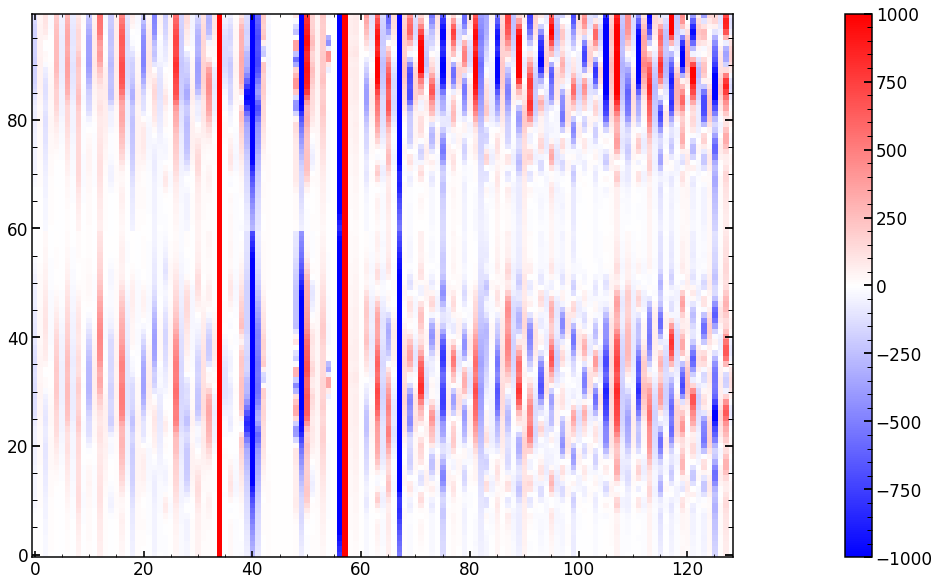

In [1403]:
plt.figure(figsize=(40,10))
plt.imshow(H[:100],cmap='bwr',vmax=1000,vmin=-1000)
plt.colorbar()

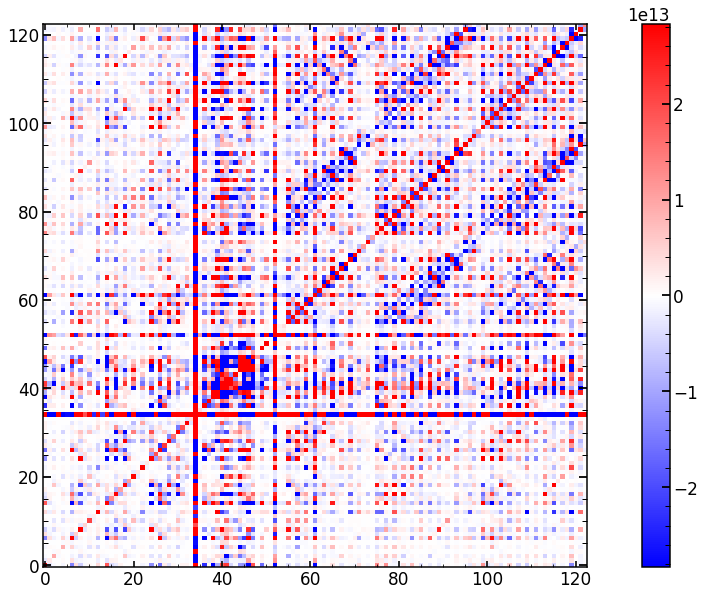

In [1445]:
plt.figure(figsize=(20,10))
plt.imshow(HHt,vmax=np.quantile(HHt,0.95),vmin=-np.quantile(HHt,0.95),cmap='bwr')
plt.colorbar()

In [1377]:
array_of_delta_all_parametrizations

array([   0.00876687,    0.11271   ,    0.00497209,    0.13470093,
         -0.00482555,    0.03382332,   -0.00754625,   -0.03714183,
          0.00544167,   -0.08139082,    0.0160095 ,    0.07698062,
         -0.02035552,    0.0307811 ,    0.00662387,   -0.08609707,
         -0.01440427,   -0.0156884 ,    0.01682997,   -0.04007306,
          0.00085637,   -0.01615791,    0.0085357 ,    0.08825107,
          0.00022352,   -0.01524871,    0.01200958,   -0.00012211,
          0.00324444,    0.03874747,    0.00629205,    0.00491703,
          0.0029674 ,    0.06381679,   -0.00767556,    0.04321031,
          0.01415871,    0.02098475,    0.01      ,    0.002     ,
          0.01      ,    0.01      ,    0.01      ,    0.01      ,
          0.03      ,    0.1       ,    0.01      ,    0.01      ,
          0.015     ,    0.015     ,    0.01      ,    0.007     ,
          0.02      ,    0.005     ,    0.04      , 3000.        ,
          0.05      ,    0.001     ,    0.01      ,    0.005  

In [1447]:
invHHt=np.linalg.inv(HHt)

In [1515]:
def check_global_parameters(globalparameters,test_print=None,fit_for_flux=None):
    #When running big fits these are limits which ensure that the code does not wander off in totally non physical region


    globalparameters_output=np.copy(globalparameters)
    # hsc frac
    if globalparameters[0]<0.6 or globalparameters[0]>0.8:
        print('globalparameters[0] outside limits; value: '+str(globalparameters[0])) if test_print == 1 else False 
    if globalparameters[0]<=0.6:
        globalparameters_output=0.6
    if globalparameters[0]>0.8:
        globalparameters_output=0.8

     #strut frac
    if globalparameters[1]<0.07 or globalparameters[1]>0.13:
        print('globalparameters[1] outside limits') if test_print == 1 else False 
    if globalparameters[1]<=0.07:
        globalparameters_output=0.07
    if globalparameters[1]>0.13:
        globalparameters_output=0.13

    #slit_frac < strut frac 
    #if globalparameters[4]<globalparameters[1]:
        #print('globalparameters[1] not smaller than 4 outside limits')
        #return -np.inf

     #dx Focal
    if globalparameters[2]<-0.4 or globalparameters[2]>0.4:
        print('globalparameters[2] outside limits') if test_print == 1 else False 
    if globalparameters[2]<-0.4:
        globalparameters_output[2]=-0.4
    if globalparameters[2]>0.4:
        globalparameters_output[2]=0.4

    # dy Focal
    if globalparameters[3]>0.4:
        print('globalparameters[3] outside limits') if test_print == 1 else False 
        globalparameters_output[3]=0.4
    if globalparameters[3]<-0.4:
        print('globalparameters[3] outside limits') if test_print == 1 else False 
        globalparameters_output[3]=-0.4

    # slitFrac
    if globalparameters[4]<0.05:
        print('globalparameters[4] outside limits') if test_print == 1 else False 
        globalparameters_output[4]=0.05
    if globalparameters[4]>0.09:
        print('globalparameters[4] outside limits') if test_print == 1 else False 
        globalparameters_output[4]=0.09

    # slitFrac_dy
    if globalparameters[5]<-0.5:
        print('globalparameters[5] outside limits') if test_print == 1 else False 
        globalparameters_output[5]=-0.5
    if globalparameters[5]>0.5:
        print('globalparameters[5] outside limits') if test_print == 1 else False 
        globalparameters_output[5]=+0.5

    # radiometricEffect
    if globalparameters[6]<0:
        print('globalparameters[6] outside limits') if test_print == 1 else False 
        globalparameters_output[6]=0
    if globalparameters[6]>1:
        print('globalparameters[6] outside limits') if test_print == 1 else False 
        globalparameters_output[6]=1

    # radiometricExponent
    if globalparameters[7]<0:
        print('globalparameters[7] outside limits') if test_print == 1 else False 
        globalparameters_output[7]=0
    if globalparameters[7]>2:
        print('globalparameters[7] outside limits') if test_print == 1 else False 
        globalparameters_output[7]=2

    # x_ilum
    if globalparameters[8]<0.5:
        print('globalparameters[8] outside limits') if test_print == 1 else False 
        globalparameters_output[8]=0.5
    if globalparameters[8]>1.5:
        print('globalparameters[8] outside limits') if test_print == 1 else False 
        globalparameters_output[8]=1.5

    # y_ilum
    if globalparameters[9]<0.5:
        print('globalparameters[9] outside limits') if test_print == 1 else False 
        globalparameters_output[9]=0.5
    if globalparameters[9]>1.5:
        print('globalparameters[9] outside limits') if test_print == 1 else False 
        globalparameters_output[9]=1.5

    # x_fiber
    if globalparameters[10]<-0.4:
        print('globalparameters[10] outside limits') if test_print == 1 else False 
        globalparameters_output[10]=-0.4
    if globalparameters[10]>0.4:
        print('globalparameters[10] outside limits') if test_print == 1 else False 
        globalparameters_output[10]=0.4

    # y_fiber
    if globalparameters[11]<-0.4:
        print('globalparameters[11] outside limits') if test_print == 1 else False 
        globalparameters_output[11]=-0.4
    if globalparameters[11]>0.4:
        print('globalparameters[11] outside limits') if test_print == 1 else False 
        globalparameters_output[11]=0.4      

    # effective_radius_illumination
    if globalparameters[12]<0.7:
        print('globalparameters[12] outside limits') if test_print == 1 else False 
        globalparameters_output[12]=0.7
    if globalparameters[12]>1.0:
        print('globalparameters[12] outside limits') if test_print == 1 else False 
        globalparameters_output[12]=1

    # frd_sigma
    if globalparameters[13]<0.01:
        print('globalparameters[13] outside limits') if test_print == 1 else False 
        globalparameters_output[13]=0.01
    if globalparameters[13]>.4:
        print('globalparameters[13] outside limits') if test_print == 1 else False 
        globalparameters_output[13]=0.4 

    #frd_lorentz_factor
    if globalparameters[14]<0.01:
        print('globalparameters[14] outside limits') if test_print == 1 else False 
        globalparameters_output[14]=0.01
    if globalparameters[14]>1:
        print('globalparameters[14] outside limits') if test_print == 1 else False 
        globalparameters_output[14]=1 

    # det_vert
    if globalparameters[15]<0.85:
        print('globalparameters[15] outside limits') if test_print == 1 else False 
        globalparameters_output[15]=0.85
    if globalparameters[15]>1.15:
        print('globalparameters[15] outside limits') if test_print == 1 else False 
        globalparameters_output[15]=1.15

    # slitHolder_frac_dx
    if globalparameters[16]<-0.8:
        print('globalparameters[16] outside limits') if test_print == 1 else False 
        globalparameters_output[16]=-0.8
    if globalparameters[16]>0.8:
        print('globalparameters[16] outside limits') if test_print == 1 else False 
        globalparameters_output[16]=0.8 

    # grating_lines
    if globalparameters[17]<1200:
        print('globalparameters[17] outside limits') if test_print == 1 else False 
        globalparameters[17]=1200
    if globalparameters[17]>120000:
        print('globalparameters[17] outside limits') if test_print == 1 else False 
        globalparameters_output[17]=120000 

    # scattering_slope
    if globalparameters[18]<1.5:
        print('globalparameters[18] outside limits') if test_print == 1 else False 
        globalparameters_output[18]=1.5
    if globalparameters[18]>+3.0:
        print('globalparameters[18] outside limits') if test_print == 1 else False 
        globalparameters_output[18]=3 

    # scattering_amplitude
    if globalparameters[19]<0:
        print('globalparameters[19] outside limits') if test_print == 1 else False 
        globalparameters_output[19]=0
    if globalparameters[19]>+0.4:
        print('globalparameters[19] outside limits') if test_print == 1 else False 
        globalparameters_output[19]=0.4          

    # pixel_effect
    if globalparameters[20]<0.35:
        print('globalparameters[20] outside limits') if test_print == 1 else False 
        globalparameters_output[20]=0.35
    if globalparameters[20]>+0.8:
        print('globalparameters[20] outside limits') if test_print == 1 else False 
        globalparameters_output[20]=0.8

    # fiber_r
    if globalparameters[21]<1.78:
        print('globalparameters[21] outside limits') if test_print == 1 else False 
        globalparameters_output[21]=1.78
    if globalparameters[21]>+1.98:
        print('globalparameters[21] outside limits') if test_print == 1 else False 
        globalparameters_output[21] =1.98

    # flux
    if fit_for_flux==True:
        globalparameters_output[22]=1
    else:          
        if globalparameters[22]<0.98:
            print('globalparameters[22] outside limits') if test_print == 1 else False 
            globalparameters_output[22] =0.98
        if globalparameters[22]>1.02:
            print('globalparameters[22] outside limits') if test_print == 1 else False 
            globalparameters_output[22] =1.02

                
    return globalparameters_output
    
    

In [1527]:
test_globalparameters=np.array([0.64593503,     0.08554319,
    -0.0064738  ,   -0.12324326 ,    0.05554828,     0.0105675,
     0.0000143 ,     0.0000143 ,     0.97357764,     0.94833826,
    -0.33231716,    -0.0522788 ,     0.99471615,    -0.00221675,
     0.73056804 ,    1.06466447 ,    0.21381587, 49206.98044255,
     2.3329214,      0.00263885 ,    0.26433069,     1.6936191,
     0.99635363])
test_globalparameters[14]

0.73056804

In [1528]:
checked_global_parameters=check_global_parameters(test_globalparameters,test_print=1)
test_globalparameters-checked_global_parameters

globalparameters[13] outside limits
globalparameters[20] outside limits
globalparameters[21] outside limits


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.01221675,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.08566931, -0.0863809 ,  0.        ])

In [1519]:
test_globalparameters-(test_globalparameters-checked_global_parameters)

array([    0.64759203,     0.08351017,     0.0060166 ,    -0.10483085,
           0.05470414,     0.02501642,     0.0000143 ,     0.0000143 ,
           0.97357764,     0.94833826,    -0.0347454 ,    -0.05009654,
           0.93974678,     0.05156687,     1.        ,     1.03731307,
           0.04589634, 58135.11161106,     2.21657834,     0.00291976,
           0.35      ,     1.78      ,     0.99352463])

In [1520]:
checked_global_parameters

array([    0.64759203,     0.08351017,     0.0060166 ,    -0.10483085,
           0.05470414,     0.02501642,     0.0000143 ,     0.0000143 ,
           0.97357764,     0.94833826,    -0.0347454 ,    -0.05009654,
           0.93974678,     0.05156687,     1.        ,     1.03731307,
           0.04589634, 58135.11161106,     2.21657834,     0.00291976,
           0.35      ,     1.78      ,     0.99352463])

In [1508]:
test_globalparameters[14]

1.0

In [1526]:
0.64593503     0.08554319
    -0.0064738     -0.12324326     0.05554828     0.0105675
     0.0000143      0.0000143      0.97357764     0.94833826
    -0.33231716    -0.0522788      0.99471615    -0.00221675
     0.73056804     1.06466447     0.21381587 49206.98044255
     2.3329214      0.00263885     0.26433069     1.6936191
     0.99635363

SyntaxError: invalid syntax (<ipython-input-1526-e67ffac5e405>, line 1)

In [1678]:
t1=np.array([   -7.35811615,     0.31395709 ,    0.04304126,    -0.08370031,
     0.01876857,    -0.71513378,    -0.00384881 ,    0.65443779,
    -0.02389148,    -0.16238548,     0.0013032,     -0.07307503,
     0.02829609,    -0.22124205,     0.01096126,    -0.31108906,
     0.00590656,     0.04366443,    -0.00626158 ,   -0.01615417,
     0.01783764,     0.02928197,     0.000851 ,      0.02421841,
    -0.00628124,    -0.02272868,    -0.01770603,     0.00641802,
    -0.00547282,     0.00910826,    -0.00227791,    -0.01196383,
     0.00598027,    -0.02762942,     0.00024416 ,    0.01808659,
    -0.01851094,     0.00963272,     0.6532935 ,     0.08650672,
     0.00686963,    -0.10194628 ,    0.05645285 ,    0.03429985,
     0.0000143 ,     0.0000143 ,     0.97357764,     0.94833826,
    -0.04113252,    -0.04857056 ,    0.98958281,     0.05404461,
     0.81508494,     1.04453668 ,    0.05035502, 58135.11161106,
     2.34071885,     0.00409406,     0.35845817 ,    1.78,
     0.99649511,     0.00071924,    -0.00256411 ,   -0.00055658,
     0.00413968,    -0.00101282 ,    0.00349249 ,    0.00101287,
     0.00221677 ,    0.00001241 ,   -0.0025917 ,    -0.00020483,
     0.00141627 ,    0.00042049 ,   -0.00544709,     0.00001627,
    -0.00361219,    -0.00124036  ,  -0.00387979,     0.0014634,
     0.00473729 ,   -0.00415738 ,    0.02339669,   -0.00134138,
     0.00287046 ,    0.00230357 ,   -0.013907 ,      0.00029148,
    -0.00589045 ,   -0.00075331 ,    0.00388647 ,   -0.00118222,
     0.00398219 ,    0.00031621 ,   -0.00224412 ,    0.00105146,
    -0.00425876,     0.00078771 ,   -0.00104246 ,    0.00039858,
     0.00467885,    -0.00068762 ,    0.00237984 ,    0.00102747,
    -0.00176591,     0.00009497 ,    0.005426 ,     -0.00156894,
     0.00056573,     0.00105482 ,   -0.00146249,    0.00037497,
    -0.00346162,    -0.00069603 ,    0.00527046 ,   -0.00086261,
    -0.0027395 ,     0.00148559 ,   -0.00343169 ,    0.0008624,
     0.00544298,    -0.00074633 ,    0.00544543 ,   -0.00109973,
     0.00106589,     0.00104131 ,    0.00003949  ,   0.0004645,
    -0.00139388])

In [351]:
    def move_parametrizations_from_1d_to_2d(allparameters_parametrizations_1d,zmax=None):
        
        # 22 parameters has len of 61
        if zmax is None:
            zmax=int((len(allparameters_parametrizations_1d)-61)/2+22)
        
        assert len(allparameters_parametrizations_1d.shape)==1
        

        z_parametrizations=allparameters_parametrizations_1d[:19*2].reshape(19,2)
        g_parametrizations=np.transpose(np.vstack((np.zeros(len(allparameters_parametrizations_1d[19*2:19*2+23])),\
                                                   allparameters_parametrizations_1d[19*2:19*2+23])))
            
            
        if zmax>22:
            extra_Zernike_parameters_number=zmax-22
            z_extra_parametrizations=allparameters_parametrizations_1d[19*2+23:].reshape(extra_Zernike_parameters_number,2)    
        
        if zmax<=22:
            allparameters_parametrizations_2d=np.vstack((z_parametrizations,g_parametrizations))   
        if zmax>22:
            allparameters_parametrizations_2d=np.vstack((z_parametrizations,g_parametrizations,z_extra_parametrizations))   
        
        
        #print('allparameters_parametrizations_2d[41]: '+ str(allparameters_parametrizations_2d[41]))
        #assert allparameters_parametrizations_2d[41][1] >= 0.98
        #assert allparameters_parametrizations_2d[41][1] <= 1.02        
        
        return allparameters_parametrizations_2d

In [354]:
move_parametrizations_from_1d_to_2d(minchain_parametrization)

array([[   -7.48584024,     0.73497698],
       [    0.19568978,     0.15682353],
       [    0.03769565,     0.02577918],
       [   -0.03734586,     0.39183789],
       [    0.02550665,     0.556507  ],
       [    0.0072312 ,     0.1261021 ],
       [    0.01097693,    -0.26493479],
       [   -0.01831573,    -0.05247759],
       [    0.01020252,    -0.15314955],
       [    0.00343817,    -0.10475206],
       [    0.02711867,    -0.0137685 ],
       [    0.00445374,     0.0372618 ],
       [    0.01458828,    -0.02237409],
       [   -0.01880653,     0.03841714],
       [   -0.00188257,     0.02112357],
       [   -0.00910924,     0.01975998],
       [   -0.00067647,    -0.02366152],
       [    0.00463751,     0.012873  ],
       [   -0.00621102,     0.02695559],
       [    0.        ,     0.68904049],
       [    0.        ,     0.10290975],
       [    0.        ,    -0.20154677],
       [    0.        ,    -0.01441376],
       [    0.        ,     0.05355728],
       [    0.  

In [349]:
array_of_polyfit_1_parameterizations_proposal_shape_2d

NameError: name 'array_of_polyfit_1_parameterizations_proposal_shape_2d' is not defined

# Sep28 

## init 

In [289]:
list_of_initial_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_initial_input_parameters_1_0.npy')
list_of_sci_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_sci_images.npy',allow_pickle=True)
list_of_var_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_var_images.npy',allow_pickle=True)
uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_M0_1_0.npy',allow_pickle=True)
uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_std.npy',allow_pickle=True)
uber_M0_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_M0_std_1_0.npy',allow_pickle=True)
uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_I.npy',allow_pickle=True)

list_of_image_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_image_0_1_0.npy',allow_pickle=True)


In [9]:
array_of_delta_z_parametrizations=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/array_of_delta_z_parametrizations_1_0.npy',allow_pickle=True)
out_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/out_images_1_0.npy',allow_pickle=True)
out_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/out_parameters_1_0.npy',allow_pickle=True)


In [10]:
list_of_mean_value_of_background=[]
list_of_flux_mask=[]
list_of_sci_image_std=[]
for i in range(len(list_of_sci_images)):
    sci_image=list_of_sci_images[i]

    mean_value_of_background=np.mean([np.median(sci_image[0]),np.median(sci_image[-1]),\
                                      np.median(sci_image[:,0]),np.median(sci_image[:,-1])])*5


    print(mean_value_of_background)
    list_of_mean_value_of_background.append(mean_value_of_background)
    flux_mask=sci_image>(mean_value_of_background)


    # normalized science image
    var_image=list_of_var_images[i]
    sci_image_std=sci_image/np.sqrt(var_image)
    list_of_sci_image_std.append(sci_image_std)
    list_of_flux_mask.append(flux_mask)

101.27429008483887
104.02891159057617
307.4923896789551
35.056164264678955
26.743249893188477
36.064863204956055
33.24357032775879
23.781204223632812
25.616350173950195


In [11]:
        ######################################################################################################### 
        # Normalize created images
        
        #We created (zmax*2) x N images, where N is the number of defocused images
        # loop over all of (zmax*2) combinations and double-normalize and ravel N images
        # double-normalize = set sum of each image to 1 and then set the sum of all raveled images to 1
        
        list_of_images_normalized_uber=[]
        list_of_images_normalized_std_uber=[]
        # go over zmax*2 images
        for j in range(len(out_images)):
            # two steps for what could have been achived in one, but to ease up transition from previous code 
            out_images_single_parameter_change=out_images[j]
            optpsf_list=out_images_single_parameter_change
            ### breaking here
            # flux image has to correct per image
            # normalize and mask images that have been created in the fitting procedure
            images_normalized=[]
            for i in range(len(optpsf_list)):
                
                flux_mask=list_of_flux_mask[i]
                images_normalized.append((optpsf_list[i][flux_mask]).ravel())                
                #images_normalized.append((optpsf_list[i][flux_mask]/np.sum(optpsf_list[i][flux_mask])).ravel())
                
            images_normalized_flat=[item for sublist in images_normalized for item in sublist]  
            images_normalized_flat=np.array(images_normalized_flat)
            #images_normalized_flat=np.array(images_normalized_flat)/len(optpsf_list)        
            
            # list of (zmax-3)*2 raveled images
            list_of_images_normalized_uber.append(images_normalized_flat)
            
            # same but divided by STD
            images_normalized_std=[]
            for i in range(len(optpsf_list)):   
                # seems that I am a bit more verbose here with my definitions
                optpsf_list_i=optpsf_list[i]
                STD=list_of_sci_image_std[i]
                optpsf_list_i_STD=optpsf_list_i/STD    
                flux_mask=list_of_flux_mask[i]
                #images_normalized_std.append((optpsf_list_i_STD[flux_mask]/np.sum(optpsf_list_i_STD[flux_mask])).ravel())
            
            # join all images together
            #images_normalized_std_flat=[item for sublist in images_normalized_std for item in sublist]  
            # normalize so that the sum is still one
            #images_normalized_std_flat=np.array(images_normalized_std_flat)/len(optpsf_list)
            
            #list_of_images_normalized_std_uber.append(images_normalized_std_flat)
            
        # create uber images_normalized,images_normalized_std    
        # images that have zmax*2 rows and very large number of columns (number of non-masked pixels from all N images)
        uber_images_normalized=np.array(list_of_images_normalized_uber)    

In [12]:
            H=np.transpose(np.array((uber_images_normalized-uber_M0))/array_of_delta_z_parametrizations[:,None])    
            #H_std=np.transpose(np.array((uber_images_normalized_std-uber_M0_std))/array_of_delta_z_parametrizations[:,None]) 
            H_std=np.transpose(np.array((uber_images_normalized-uber_M0))/array_of_delta_z_parametrizations[:,None])/uber_std.ravel()[:,None]   

In [13]:
print(uber_M0.shape)
print(uber_M0[:5])

print(uber_images_normalized[7].shape)
print(uber_images_normalized[7][:5])

print(uber_std.shape)
print(uber_std[:5])

(11972,)
[11.808972 14.076307 27.091398 20.390734 15.417142]
(11972,)
[11.808926 14.0764   27.093174 20.392166 15.417128]
(11972,)
[38.31785  45.956146 55.238773 46.486553 45.933334]


In [14]:
uber_images_normalized.shape

(106, 11972)

In [15]:
uber_images_normalized[0]

array([11.700334, 13.971752, 26.868893, ..., 17.378922, 12.456182,
       11.383123], dtype=float32)

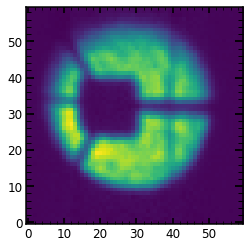

In [16]:
plt.imshow(list_of_sci_images[0])

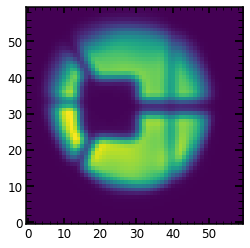

In [17]:
plt.imshow(out_images[0][0])

In [18]:
i=0
flux_mask=list_of_flux_mask[i]
std_image=np.sqrt(list_of_var_images[i][flux_mask])
print(list_of_var_images[i][flux_mask])

print(std_image[:5])

print(list_of_sci_images[i][flux_mask][:5])
sci2=np.copy(list_of_sci_images[i])
sci2[flux_mask][:5]=[-999,-999,-999,-999,-999]


print(list_of_image_0[i][flux_mask])

print(uber_M0[:5])

print(out_images[7][i][flux_mask][:5])

print(sci2[flux_mask][:5])


[1468.2574 2111.9673 3051.322  ... 2806.1428 2462.5945 2152.2717]
[38.31785  45.956146 55.238773 46.486553 45.933334]
[115.02214 168.97546 125.08939 127.40631 159.6454 ]
[11.808972 14.076307 27.091398 ... 43.90447  37.42533  24.704473]
[11.808972 14.076307 27.091398 20.390734 15.417142]
[11.808926 14.0764   27.093174 20.392166 15.417128]
[115.02214 168.97546 125.08939 127.40631 159.6454 ]


In [19]:
i, j = np.where(sci2 == sci2[flux_mask][0]) 
print([i,j])

[array([0]), array([9])]


In [23]:
np.sum(list_of_sci_images[i])

array([[  3.0530858 ,   1.9664111 ,  -9.02464   , ..., -16.009895  ,
        -20.548195  ,  13.729042  ],
       [ -2.017994  ,   7.157636  ,   3.2865026 , ...,   6.590905  ,
         12.248104  ,   0.13143176],
       [-17.636013  ,  34.247284  , -33.299717  , ...,  10.265026  ,
        -14.27724   , -27.027517  ],
       ...,
       [ -5.817641  , -13.89697   ,   2.9061925 , ...,   8.384144  ,
         -4.3532386 ,  30.28671   ],
       [ 17.529081  ,   4.5292444 ,   3.2745986 , ...,   6.722054  ,
        -13.424155  ,  18.898132  ],
       [  4.8484035 ,  28.58174   ,   2.062496  , ...,   4.5281262 ,
         -4.9031157 , -20.073551  ]], dtype=float32)

In [24]:
uber_M0

array([11.808972, 14.076307, 27.091398, ..., 17.51636 , 12.570322,
       11.482035], dtype=float32)

In [25]:
uber_images_normalized.shape

(106, 11972)

In [26]:
IM_start=np.sum(np.abs(np.array(uber_I/uber_std)-np.array(uber_M0/uber_std)))  
IM_start

41826.594

In [27]:
IM_start=np.sum(np.abs(np.array(uber_I/uber_std)-np.array((uber_images_normalized[0])/uber_std)))  
IM_start

43495.367

In [29]:
uber_differences_wavefront=np.array((uber_images_normalized-uber_M0)).astype('float32')

In [30]:
uber_I_std=np.array(uber_I/uber_std)
array_of_prefactors=np.zeros(106)

bounds=[]
for i in range(106):
    bounds.append((-5,5))

In [31]:
def calculate_res_from_combination_of_differences(array_of_prefactors):
    single_combination_of_differences=np.matmul(array_of_prefactors[:10].astype('float32'),uber_differences_wavefront[:10])
    uber_M0_and_combination_of_differences=uber_M0+single_combination_of_differences
    uber_M0_and_combination_of_differences=uber_M0_and_combination_of_differences*np.sum(uber_I)/np.sum(uber_M0_and_combination_of_differences)
    IM_iteration=np.sum(np.abs(uber_I_std-np.array(uber_M0_and_combination_of_differences/uber_std)))  
    
    #IM_iteration=np.abs(uber_I_std-np.array((uber_M0+single_combination_of_differences)/uber_std))

    return IM_iteration

In [33]:
calculate_res_from_combination_of_differences(array_of_prefactors)

41915.44

In [34]:
from scipy.optimize import shgo

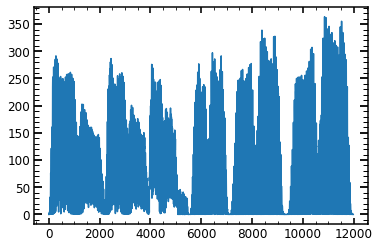

In [35]:
plt.plot(np.std(uber_differences_wavefront,axis=0))

In [155]:
result =scipy.optimize.minimize(calculate_res_from_combination_of_differences, np.zeros(106), method='Nelder-Mead',options={'xatol': 0.1,'fatol': 0.1})

In [156]:
result

 final_simplex: (array([[ 0.00362532, -0.05592552,  0.22747101, ..., -0.02633412,
         0.00842167,  0.01196944],
       [ 0.00346156, -0.05152241,  0.23103375, ..., -0.02588611,
         0.00839656,  0.01072582],
       [ 0.00241345, -0.04782486,  0.22292277, ..., -0.02437277,
         0.0059809 ,  0.01022584],
       ...,
       [ 0.00165983, -0.03825688,  0.22667939, ..., -0.02441831,
         0.00800558,  0.00948334],
       [ 0.00256997, -0.04816345,  0.22465273, ..., -0.02492762,
         0.0060234 ,  0.01018778],
       [ 0.00184014, -0.05479071,  0.22241617, ..., -0.02585884,
         0.00932839,  0.01331429]]), array([41281.65185201, 41282.38945564, 41282.44193735, 41282.45833513,
       41282.53879514, 41282.54022013, 41282.61972914, 41282.76465997,
       41282.77218635, 41282.80807595, 41282.938108  , 41282.97816091,
       41283.05009962, 41283.17599493, 41283.3479513 , 41283.3508237 ,
       41283.45379044, 41283.51472421, 41283.64778285, 41283.67852068,
       41283.7

In [109]:
%timeit single_combination_of_differences=np.matmul(array_of_prefactors[:106].astype('float32'),uber_differences_wavefront[:106])

190 µs ± 28.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [121]:
%timeit single_combination_of_differences=np.matmul(uber_differences_wavefront[:106].T,array_of_prefactors[:106].astype('float32').T)

210 µs ± 22.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [111]:
scipy.linalg.blas.sgemm(array_of_prefactors[:106].astype('float32'),uber_differences_wavefront[:106])

TypeError: _fblas.sgemm() missing required argument 'b' (pos 3)

In [179]:
>>> from scipy.linalg import blas as FB
>>> vx = FB.sgemv(alpha=1, a=uber_differences_wavefront[:106].T, x=array_of_prefactors[:106].astype('float32').T)

In [180]:
vx

array([-0.40470886, -0.14044762,  6.1610947 , ...,  1.0723114 ,
       -0.20098686, -0.19517803], dtype=float32)

In [181]:
%timeit  vx = FB.sgemv(alpha=1., a=uber_differences_wavefront[:106].T, x=array_of_prefactors[:106].astype('float32').T)

209 µs ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [167]:
array_of_prefactors=np.ones(106).astype('float32')

In [168]:
np.matmul(uber_differences_wavefront[:106].T,array_of_prefactors[:106].astype('float32').T)

array([-0.40470886, -0.14044762,  6.1610947 , ...,  1.0723114 ,
       -0.20098686, -0.19517803], dtype=float32)

In [189]:
np.matmul(array_of_prefactors[:106].astype('float32'),uber_differences_wavefront)

array([-0.40470886, -0.14044762,  6.1610947 , ...,  1.0723114 ,
       -0.20098686, -0.19517803], dtype=float32)

In [170]:
%timeit single_combination_of_differences=np.matmul(array_of_prefactors,uber_differences_wavefront)

235 µs ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [171]:
np.sum(np.matmul(array_of_prefactors,uber_differences_wavefront))

-2803942.0

In [172]:
x=array_of_prefactors

In [124]:
U, s, V = np.linalg.svd(uber_differences_wavefront)

In [186]:
rank = int(106)   # Compression by a factor of 3
y = np.matmul(x,V[:rank,:rank])
y *= s[:rank]
y = np.matmul(y,U)

In [185]:
y

array([ 16.073618  ,  39.556423  , -38.630978  ,  29.046562  ,
        12.40985   ,  -2.6917267 , -16.293488  ,  -2.3427796 ,
        26.953249  ,  -0.02532319, -14.458926  ,  -1.8311011 ,
       -59.269905  ,  32.440975  , -16.622911  ,  16.40409   ,
       -29.011044  , -35.301456  , -14.099413  ,   2.3417027 ,
       -26.997606  ,  46.24032   , -33.10343   , -11.373686  ,
        20.389994  ,  10.4115925 , -11.093941  ,   0.51796275,
       -31.876053  , -34.31966   ,   9.964323  , -25.060509  ,
        -0.9039046 , -14.015724  ,  53.6863    ,  29.96901   ,
        27.682161  ,  -3.7984426 ,  38.154602  , -10.726601  ,
        22.306164  ,  -7.1419435 , -24.016209  , -30.67822   ,
         0.8148023 , -14.723973  , -14.863364  , -15.244894  ,
         0.7186489 , -58.699955  ,  25.676266  ,   6.1951137 ,
        -2.7019565 , -28.762897  ,  -1.1564571 ,  50.472336  ,
        25.270859  ,  10.040089  , -19.12347   , -10.23174   ,
       -14.462789  ,   1.0636632 , -19.57045   , -24.84

In [187]:
single_combination_of_differences

NameError: name 'single_combination_of_differences' is not defined

In [190]:
import cosmoHammer

ModuleNotFoundError: No module named 'cosmoHammer'

In [221]:
class combination(object):

    def __init__(self):
        """
        
        Constructor of the PFSLikelihoodModule
        """
        DATA_FOLDER='/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/'
        
        
        list_of_initial_input_parameters=np.load(DATA_FOLDER+'list_of_initial_input_parameters_1_0.npy')
        list_of_sci_images=np.load(DATA_FOLDER+'list_of_sci_images.npy',allow_pickle=True)
        list_of_var_images=np.load(DATA_FOLDER+'list_of_var_images.npy',allow_pickle=True)
        
        list_of_flux_mask=np.load(DATA_FOLDER+'list_of_flux_mask.npy',allow_pickle=True)
        uber_M0=np.load(DATA_FOLDER+'uber_M0_1_0.npy',allow_pickle=True)
        uber_std=np.load(DATA_FOLDER+'uber_std.npy',allow_pickle=True)
        uber_M0_std=np.load(DATA_FOLDER+'uber_M0_std_1_0.npy',allow_pickle=True)
        uber_I=np.load(DATA_FOLDER+'uber_I.npy',allow_pickle=True) 

        list_of_image_0=np.load(DATA_FOLDER+'list_of_image_0_1_0.npy',allow_pickle=True)        
        
        array_of_delta_z_parametrizations=np.load(DATA_FOLDER+'array_of_delta_z_parametrizations_1_0.npy',allow_pickle=True)
        out_images=np.load(DATA_FOLDER+'out_images_1_0.npy',allow_pickle=True)
        out_parameters=np.load(DATA_FOLDER+'out_parameters_1_0.npy',allow_pickle=True)        
        
        
        ######################################################################################################### 
        # Normalize created images
        
        #We created (zmax*2) x N images, where N is the number of defocused images
        # loop over all of (zmax*2) combinations and double-normalize and ravel N images
        # double-normalize = set sum of each image to 1 and then set the sum of all raveled images to 1
        
        list_of_images_normalized_uber=[]

        # go over zmax*2 images
        for j in range(len(out_images)):
            # two steps for what could have been achived in one, but to ease up transition from previous code 
            out_images_single_parameter_change=out_images[j]
            optpsf_list=out_images_single_parameter_change
            ### breaking here
            # flux image has to correct per image
            # normalize and mask images that have been created in the fitting procedure
            images_normalized=[]
            for i in range(len(optpsf_list)):
                
                flux_mask=list_of_flux_mask[i]
                images_normalized.append((optpsf_list[i][flux_mask]).ravel())                
                #images_normalized.append((optpsf_list[i][flux_mask]/np.sum(optpsf_list[i][flux_mask])).ravel())
                
            images_normalized_flat=[item for sublist in images_normalized for item in sublist]  
            images_normalized_flat=np.array(images_normalized_flat)
            #images_normalized_flat=np.array(images_normalized_flat)/len(optpsf_list)        
            
            # list of (zmax-3)*2 raveled images
            list_of_images_normalized_uber.append(images_normalized_flat)
            

            
        # create uber images_normalized,images_normalized_std    
        # images that have zmax*2 rows and very large number of columns (number of non-masked pixels from all N images)
        uber_images_normalized=np.array(list_of_images_normalized_uber)  
        
        
        
        uber_I_std=uber_I/uber_std
        
        uber_differences_wavefront=np.array((uber_images_normalized-uber_M0)).astype('float32')
        
        self.uber_differences_wavefront=uber_differences_wavefront
        self.uber_M0=uber_M0
        self.uber_I=uber_I
        self.uber_I_std=uber_I_std  
        self.uber_std=uber_std

    def calculate_res_from_combination_of_differences(self,array_of_prefactors):
        
        x=array_of_prefactors.astype('float32')
        
        single_combination_of_differences=np.matmul(x,self.uber_differences_wavefront)
        uber_M0_and_combination_of_differences=self.uber_M0+single_combination_of_differences
        uber_M0_and_combination_of_differences=uber_M0_and_combination_of_differences*np.sum(self.uber_I)/np.sum(uber_M0_and_combination_of_differences)
        IM_iteration=np.sum(np.abs(self.uber_I_std-np.array(uber_M0_and_combination_of_differences/self.uber_std)))  
        
        #IM_iteration=np.abs(uber_I_std-np.array((uber_M0+single_combination_of_differences)/uber_std))
    
        return IM_iteration
    
    
    def __call__(self, list_of_allparameters):
        return self.calculate_res_from_combination_of_differences(list_of_allparameters)

In [222]:
combination_instance=combination()

In [225]:
combination_instance(np.zeros(106))

41915.44

In [228]:
for i in range(1060):
    if i==0:
        parInit=np.zeros(106)
    else:
        parInit=np.vstack((parInit,np.random.rand(106)))
        
    

In [229]:
parInit

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70274442, 0.0377997 , 0.60512766, ..., 0.21224895, 0.09605745,
        0.97320829],
       [0.31022271, 0.96079188, 0.25987427, ..., 0.69795625, 0.72723205,
        0.92253435],
       ...,
       [0.01998333, 0.12059488, 0.62976489, ..., 0.47443988, 0.32422458,
        0.21940854],
       [0.84311524, 0.23117393, 0.74572936, ..., 0.79258432, 0.29151889,
        0.53518689],
       [0.94081336, 0.73141429, 0.92720891, ..., 0.55814461, 0.10010576,
        0.81696833]])

# sep28 - when it is linear 

## working 

In [218]:
list_of_initial_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_initial_input_parameters_1_0.npy')
list_of_sci_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_sci_images.npy',allow_pickle=True)
list_of_var_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_var_images.npy',allow_pickle=True)
uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_M0_1_0.npy',allow_pickle=True)
uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_std.npy',allow_pickle=True)
uber_M0_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_M0_std_1_0.npy',allow_pickle=True)
uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/uber_I.npy',allow_pickle=True)
pre_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/pre_input_parameters.npy',allow_pickle=True)
list_of_image_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_image_0_1_0.npy',allow_pickle=True)


In [13]:
array_of_delta_z_parametrizations=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/array_of_delta_z_parametrizations_1_0.npy',allow_pickle=True)
out_images=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/out_images_1_0.npy',allow_pickle=True)
out_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/out_parameters_1_0.npy',allow_pickle=True)


In [8]:
uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_1/uber_I.npy')
uber_M0_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_1/uber_M0_1_0.npy')

uber_M0_3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_3/uber_M0_1_0.npy')
uber_M0_9=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_9/uber_M0_1_0.npy')
uber_I

array([115.02214 , 168.97546 , 125.08939 , ...,  91.113495,  40.017303,
        37.32043 ], dtype=float32)

In [73]:
uber_images_normalized_03=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_03/uber_images_normalized_1_0.npy') 
array_of_delta_z_parametrizations_03=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_03/array_of_delta_z_parametrizations_1_0.npy') 

uber_images_normalized_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_1/uber_images_normalized_1_0.npy')
array_of_delta_z_parametrizations_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_1/array_of_delta_z_parametrizations_1_0.npy') 


uber_images_normalized_3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_3/uber_images_normalized_1_0.npy')
array_of_delta_z_parametrizations_3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep29_3/array_of_delta_z_parametrizations_1_0.npy') 


uber_images_normalized_m1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2920_m1/uber_images_normalized_1_0.npy')
array_of_delta_z_parametrizations_m1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2920_m1/array_of_delta_z_parametrizations_1_0.npy') 


uber_images_normalized_m03=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2920_m03/uber_images_normalized_1_0.npy')
array_of_delta_z_parametrizations_m03=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2920_m03/array_of_delta_z_parametrizations_1_0.npy') 

uber_images_normalized_m3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2920_m3/uber_images_normalized_1_0.npy')
array_of_delta_z_parametrizations_m3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2920_m3/array_of_delta_z_parametrizations_1_0.npy') 


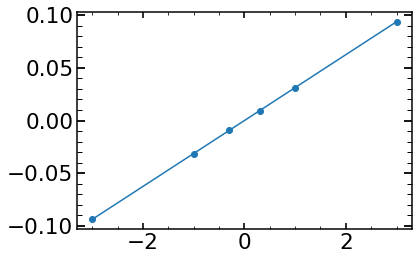

In [77]:
plt.plot([-3,-1,-0.3,+0.3,1,3],[array_of_delta_z_parametrizations_m3[0],array_of_delta_z_parametrizations_m1[0],array_of_delta_z_parametrizations_m03[0],\
                                array_of_delta_z_parametrizations_03[0],array_of_delta_z_parametrizations_1[0],array_of_delta_z_parametrizations_3[0]],marker='o')

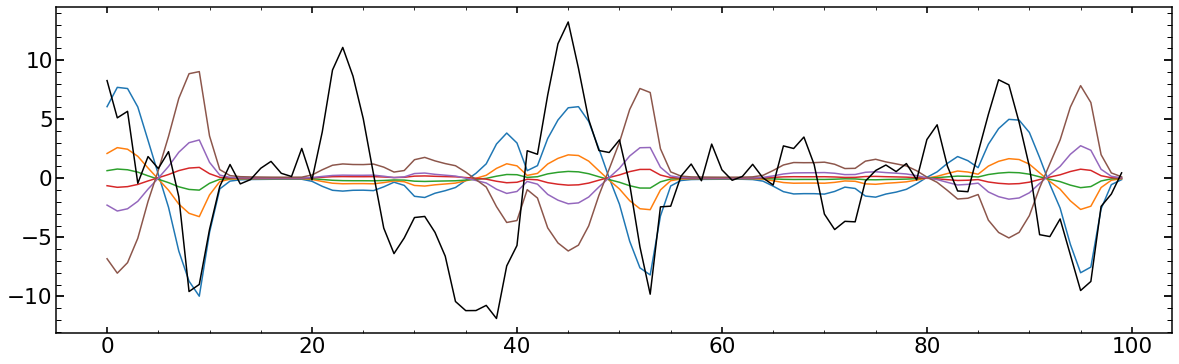

In [160]:
i=0

plt.figure(figsize=(20,6))
plt.plot((uber_M0_1-uber_images_normalized_3[i])[3000:3100]/(uber_std[3000:3100]))
plt.plot((uber_M0_1-uber_images_normalized_1[i])[3000:3100]/(uber_std[3000:3100]))
plt.plot((uber_M0_1-uber_images_normalized_03[i])[3000:3100]/(uber_std[3000:3100]))
plt.plot((uber_M0_1-uber_images_normalized_m03[i])[3000:3100]/(uber_std[3000:3100]))
plt.plot((uber_M0_1-uber_images_normalized_m1[i])[3000:3100]/(uber_std[3000:3100]))
plt.plot((uber_M0_1-uber_images_normalized_m3[i])[3000:3100]/(uber_std[3000:3100]))

plt.plot(needed_subtraction[3000:3100],color='black')

six_differences_some_pixels=np.array([(uber_M0_1-uber_images_normalized_3[i])[3000:3100]/(uber_std[3000:3100]),(uber_M0_1-uber_images_normalized_1[i])[3000:3100]/(uber_std[3000:3100]),\
         (uber_M0_1-uber_images_normalized_03[i])[3000:3100]/(uber_std[3000:3100]),(uber_M0_1-uber_images_normalized_m03[i])[3000:3100]/(uber_std[3000:3100]),
         (uber_M0_1-uber_images_normalized_m1[i])[3000:3100]/(uber_std[3000:3100]),(uber_M0_1-uber_images_normalized_m3[i])[3000:3100]/(uber_std[3000:3100])])

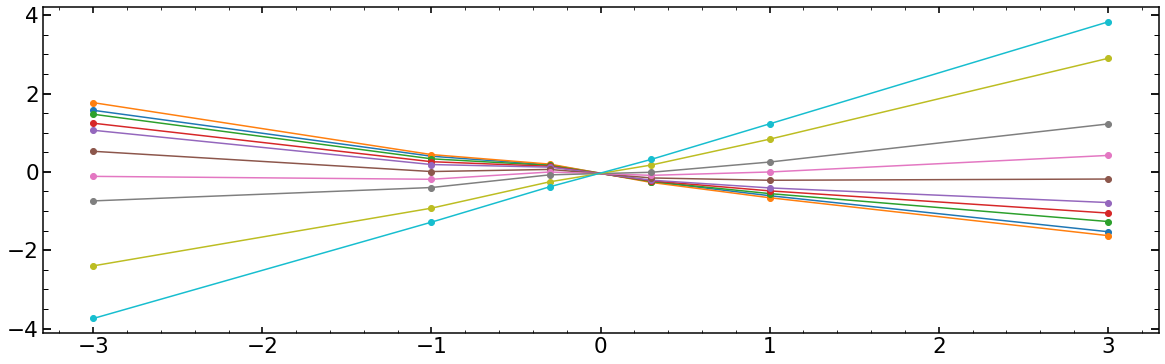

In [161]:
plt.figure(figsize=(20,6))
for i in range(30,40):
    plt.plot([3,1,0.3,-0.3,-1,-3],six_differences_some_pixels[:,i],marker='o')

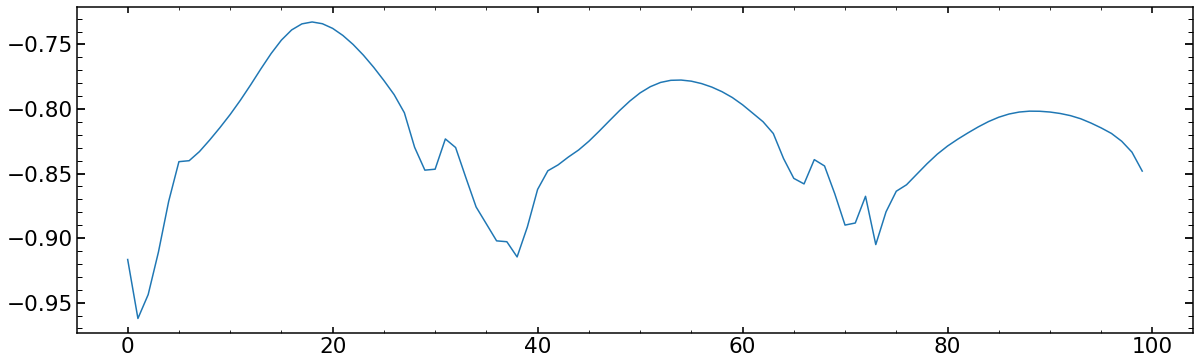

In [131]:
plt.figure(figsize=(20,6))
plt.plot((uber_M0_1-uber_images_normalized_m03[0])[2000:2100]/(uber_M0_1-uber_images_normalized_03[0])[2000:2100])

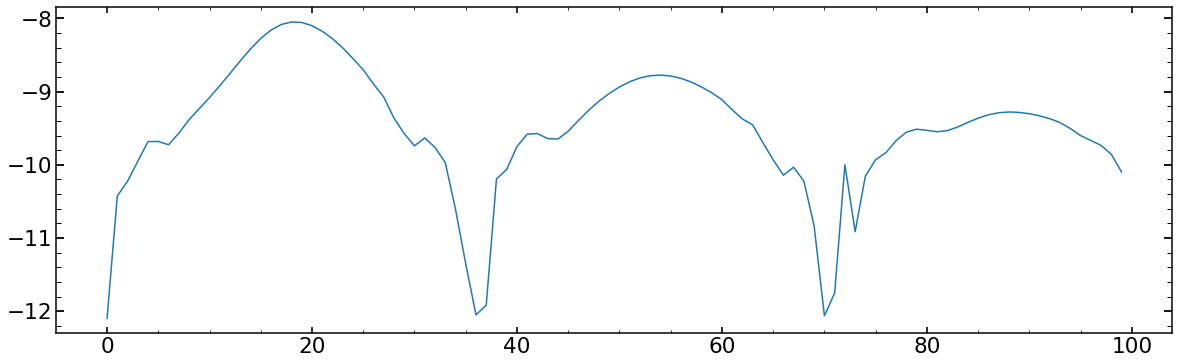

In [132]:
plt.figure(figsize=(20,6))
plt.plot((uber_M0_1-uber_images_normalized_m3[0])[2000:2100]/(uber_M0_1-uber_images_normalized_03[0])[2000:2100])

In [58]:
needed_subtraction=(uber_I-uber_M0_1)/uber_std

array_of_subtraction_3_std=[]
array_of_subtraction_1_std=[]
array_of_subtraction_03_std=[]

array_of_subtraction_m3_std=[]
array_of_subtraction_m1_std=[]
array_of_subtraction_m03_std=[]

for i in range(106):
    ratio_of_difference_m1=(uber_M0_1-uber_images_normalized_m1[i])/(uber_M0_1-uber_images_normalized_1[i])
    ratio_of_difference_9=(uber_M0_1-uber_images_normalized_9[i])/(uber_M0_1-uber_images_normalized_1[i])
    ratio_of_difference_3=(uber_M0_1-uber_images_normalized_3[i])/(uber_M0_1-uber_images_normalized_1[i])
    
    subtraction_03_std=(uber_M0_1-uber_images_normalized_03[i])/uber_std  
    subtraction_1_std=(uber_M0_1-uber_images_normalized_1[i])/uber_std 
    subtraction_3_std=(uber_M0_1-uber_images_normalized_3[i])/uber_std  
    
    subtraction_m03_std=(uber_M0_1-uber_images_normalized_m03[i])/uber_std     
    subtraction_m1_std=(uber_M0_1-uber_images_normalized_m1[i])/uber_std 
    subtraction_m3_std=(uber_M0_1-uber_images_normalized_m3[i])/uber_std     

    subtraction_1=(uber_M0_1-uber_images_normalized_1[i])/uber_M0_1

    subtraction_3=(uber_M0_1-uber_images_normalized_3[i])/uber_M0_1
    
    subtraction_9=(uber_M0_1-uber_images_normalized_9[i])/uber_M0_1
    
    array_of_subtraction_3_std.append(subtraction_3_std)
    array_of_subtraction_1_std.append(subtraction_1_std)
    array_of_subtraction_03_std.append(subtraction_03_std)
    
    array_of_subtraction_m03_std.append(subtraction_m03_std)
    array_of_subtraction_m1_std.append(subtraction_m1_std)
    array_of_subtraction_m3_std.append(subtraction_m3_std)
    
    print([i,np.mean(subtraction_1),np.std(subtraction_1)])

array_of_subtraction_3_std=np.array(array_of_subtraction_3_std)
array_of_subtraction_1_std=np.array(array_of_subtraction_1_std)
array_of_subtraction_03_std=np.array(array_of_subtraction_03_std)

array_of_subtraction_m03_std=np.array(array_of_subtraction_m03_std)
array_of_subtraction_m1_std=np.array(array_of_subtraction_m1_std)
array_of_subtraction_m3_std=np.array(array_of_subtraction_m3_std)

[0, 0.016773865, 0.035913467]
[1, 0.0020273093, 0.04232159]
[2, 0.0005405281, 0.01783517]
[3, -7.7356715e-05, 0.01952945]
[4, -5.4436357e-05, 0.01640967]
[5, 0.00020068933, 0.01818085]
[6, -0.002419273, 0.036726553]
[7, -0.0010697229, 0.03899391]
[8, 0.0017699357, 0.035796415]
[9, -0.0010729554, 0.03921154]
[10, -1.2981585e-05, 0.019637061]
[11, 9.8391814e-05, 0.021748824]
[12, 4.56167e-05, 0.02045176]
[13, -0.00025338694, 0.020197783]
[14, 0.02641988, 0.04296091]
[15, 0.0028264027, 0.057988305]
[16, -0.0018680773, 0.04418956]
[17, 0.00020558739, 0.04909667]
[18, 0.0006198905, 0.041011266]
[19, -0.0007643086, 0.046162408]
[20, -7.2645336e-05, 0.020340333]
[21, -0.00019446654, 0.022740029]
[22, 0.0001326314, 0.020247346]
[23, -0.00019505894, 0.022767166]
[24, -0.0014917614, 0.056412734]
[25, -0.0027579665, 0.06290398]
[26, -0.006774449, 0.054476086]
[27, -0.002146839, 0.057773136]
[28, -0.0013952545, 0.0436027]
[29, -0.00071947154, 0.048172776]
[30, -0.0005994282, 0.04404634]
[31, -0.00

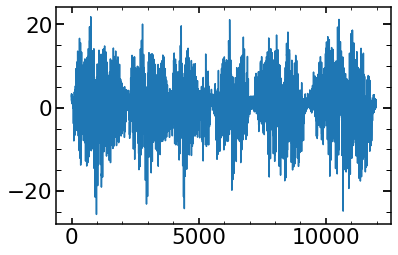

In [59]:
plt.plot(needed_subtraction)

In [60]:
np.sort(np.abs(needed_subtraction))[-106]

15.251995

In [61]:
array_of_subtraction_1_std.shape

(106, 11972)

In [62]:
needed_subtraction.shape

(11972,)

In [63]:
print(array_of_subtraction_1_std.T.shape)
print(needed_subtraction.shape)

(11972, 106)
(11972,)


In [64]:
print(np.array([[1,2,3],[4,5,6],[7,8,9],[10,11,12]]).shape)
print(np.array([6,15,23,33]).shape)

(4, 3)
(4,)


In [65]:
array_of_subtraction_m03_std

array([[-0.0008312 , -0.00069056, -0.00132651, ..., -0.00083105,
        -0.00101845, -0.00103149],
       [ 0.00058495,  0.00045364,  0.00082162, ..., -0.0007387 ,
        -0.00090696, -0.00091686],
       [-0.00043174, -0.00045224,  0.00016526, ..., -0.00050299,
        -0.00047848, -0.00047989],
       ...,
       [-0.00003823,  0.00009322, -0.00107869, ...,  0.00049998,
         0.00017602,  0.00030924],
       [-0.00029182, -0.00013497,  0.00061704, ..., -0.00009457,
        -0.00018943, -0.00009406],
       [ 0.00002046, -0.00012364, -0.00094689, ..., -0.00009191,
        -0.00017998, -0.00008262]], dtype=float32)

In [66]:
res_03=np.linalg.lstsq((array_of_subtraction_03_std.T)**1,(needed_subtraction)**1)
res=np.linalg.lstsq((array_of_subtraction_1_std.T)**1,(needed_subtraction)**1)
res_3=np.linalg.lstsq((array_of_subtraction_3_std.T)**1,(needed_subtraction)**1)

res_m03=np.linalg.lstsq((array_of_subtraction_m03_std.T)**1,(needed_subtraction)**1)
res_m1=np.linalg.lstsq((array_of_subtraction_m1_std.T)**1,(needed_subtraction)**1)
res_m3=np.linalg.lstsq((array_of_subtraction_m3_std.T)**1,(needed_subtraction)**1)

<ipython-input-66-b2ce56dd6970>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res_03=np.linalg.lstsq((array_of_subtraction_03_std.T)**1,(needed_subtraction)**1)
<ipython-input-66-b2ce56dd6970>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res=np.linalg.lstsq((array_of_subtraction_1_std.T)**1,(needed_subtraction)**1)
<ipython-input-66-b2ce56dd6970>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future

In [67]:
res

(array([-0.10718539,  0.01628296,  0.2961342 , -0.05616241, -0.03276834,
         0.1748169 , -0.04712955,  0.08633125, -0.04884684,  0.10850912,
         0.10494641,  0.00471428, -0.6884669 ,  0.3005191 ,  0.21280652,
        -0.04049391,  0.2987747 , -0.07367884,  0.09645432, -0.11492924,
        -0.0249784 ,  0.00173658, -0.25723603,  0.12422043,  0.0986642 ,
        -0.08541844, -0.08051351,  0.05394464, -0.02654414,  0.02856498,
         0.07517356, -0.01164156,  0.21946397,  0.02936227,  0.17560722,
        -0.0155792 , -0.16751508,  0.06962817,  0.01435364,  0.024565  ,
         0.02540811, -0.0323492 ,  0.00499965, -0.01406056,  0.01664033,
        -0.00226648, -0.00021237, -0.00010997,  0.01681247, -0.00791162,
         0.02463744, -0.05142074, -0.03299921,  0.01006008, -0.3547415 ,
         0.09586452,  0.02868444,  0.03283663, -0.0526114 , -0.02509946,
         0.00622315,  0.00501371, -0.02475744, -0.11969206, -0.035399  ,
        -0.0028801 ,  0.01948692,  0.01733879, -0.0

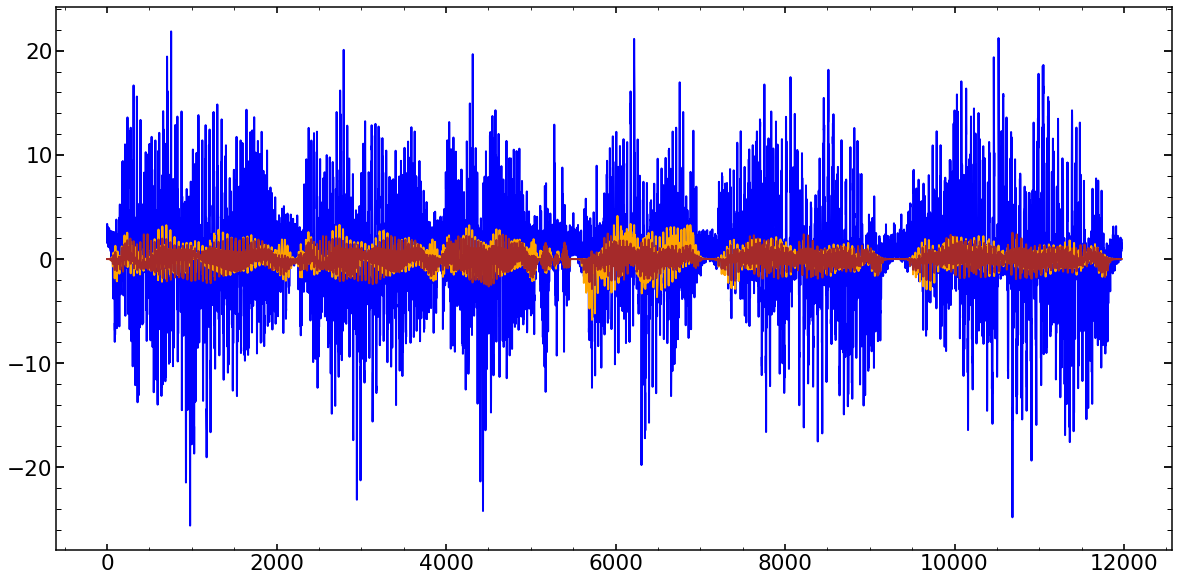

In [68]:
plt.figure(figsize=(20,10))
plt.plot(needed_subtraction,color='blue',lw=2)
plt.plot(res[0]@array_of_subtraction_1_std,color='orange',lw=2)
plt.plot(res_m1[0]@array_of_subtraction_m1_std,color='brown',lw=2)
#plt.plot(array_of_subtraction_1_std[1])
#plt.xlim(4000,4106)

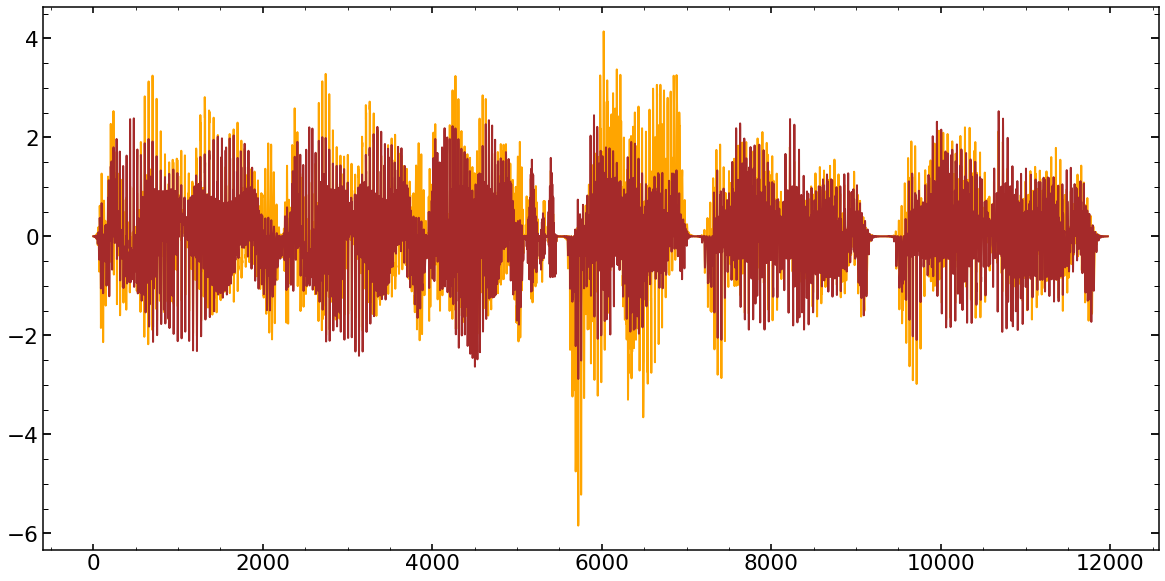

In [69]:
plt.figure(figsize=(20,10))

plt.plot(res[0]@array_of_subtraction_1_std,color='orange',lw=2)
plt.plot(res_m1[0]@array_of_subtraction_m1_std,color='brown',lw=2)
#plt.plot(res_03[0]@array_of_subtraction_03_std,color='blue',lw=2)
#plt.plot(res_3[0]@array_of_subtraction_3_std,color='gray',lw=2,alpha=0.5)

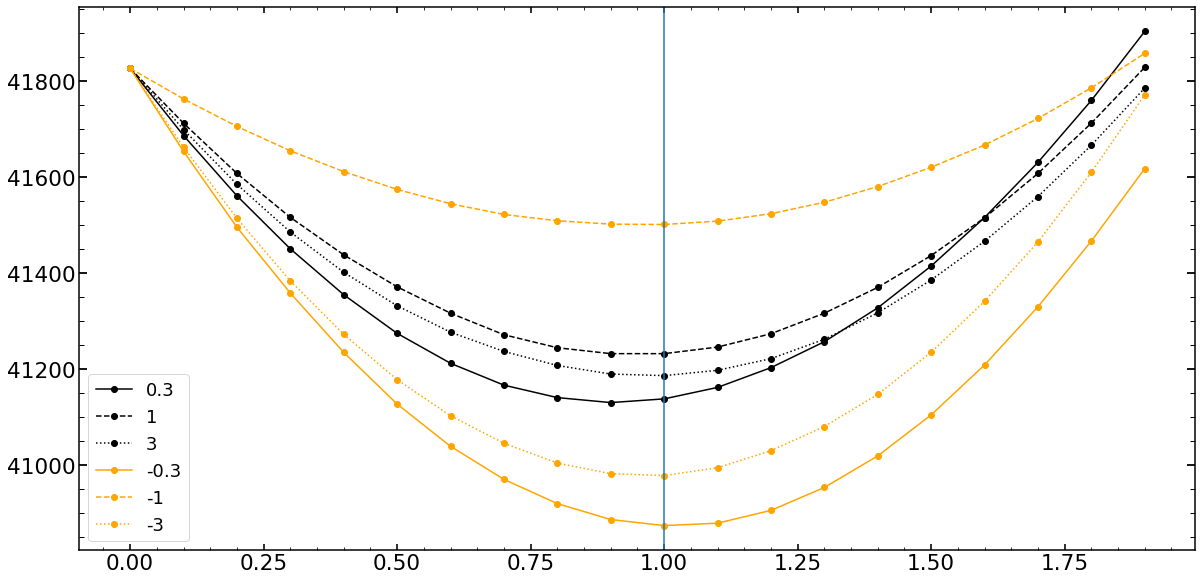

In [213]:
quality_with_amplitude_03=[]
quality_with_amplitude_1=[]
quality_with_amplitude_3=[]

quality_with_amplitude_m03=[]
quality_with_amplitude_m1=[]
quality_with_amplitude_m3=[]

for i in np.arange(0,2,0.1): 
    quality_with_amplitude_03.append([i,np.sum(np.abs(needed_subtraction-i*res_03[0]@array_of_subtraction_03_std))])
for i in np.arange(0,2,0.1): 
    quality_with_amplitude_1.append([i,np.sum(np.abs(needed_subtraction-i*res[0]@array_of_subtraction_1_std))])
for i in np.arange(0,2,0.1): 
    quality_with_amplitude_3.append([i,np.sum(np.abs(needed_subtraction-i*res_3[0]@array_of_subtraction_3_std))])
    
for i in np.arange(0,2,0.1): 
    quality_with_amplitude_m03.append([i,np.sum(np.abs(needed_subtraction-i*res_m03[0]@array_of_subtraction_m03_std))])
for i in np.arange(0,2,0.1): 
    quality_with_amplitude_m1.append([i,np.sum(np.abs(needed_subtraction-i*res_m1[0]@array_of_subtraction_m1_std))])
for i in np.arange(0,2,0.1): 
    quality_with_amplitude_m3.append([i,np.sum(np.abs(needed_subtraction-i*res_m3[0]@array_of_subtraction_m3_std))])
   
quality_with_amplitude_03=np.array(quality_with_amplitude_03)
quality_with_amplitude_1=np.array(quality_with_amplitude_1)
quality_with_amplitude_3=np.array(quality_with_amplitude_3)

quality_with_amplitude_m03=np.array(quality_with_amplitude_m03)
quality_with_amplitude_m1=np.array(quality_with_amplitude_m1)
quality_with_amplitude_m3=np.array(quality_with_amplitude_m3)

plt.figure(figsize=(20,10))

plt.plot(quality_with_amplitude_03[:,0],quality_with_amplitude_03[:,1],color='black',ls='-',label='0.3',marker='o')
plt.plot(quality_with_amplitude_1[:,0],quality_with_amplitude_1[:,1],color='black',ls='--',label='1',marker='o')
plt.plot(quality_with_amplitude_3[:,0],quality_with_amplitude_3[:,1],color='black',ls=':',label='3',marker='o')

plt.plot(quality_with_amplitude_m03[:,0],quality_with_amplitude_m03[:,1],color='orange',ls='-',label='-0.3',marker='o')
plt.plot(quality_with_amplitude_m1[:,0],quality_with_amplitude_m1[:,1],color='orange',ls='--',label='-1',marker='o')
plt.plot(quality_with_amplitude_m3[:,0],quality_with_amplitude_m3[:,1],color='orange',ls=':',label='-3',marker='o')
plt.legend()
plt.axvline(1)

In [82]:
six_res=np.array([res_m3[0],res_m1[0],res_m03[0],res_03[0],res[0],res_3[0]])

z27.0


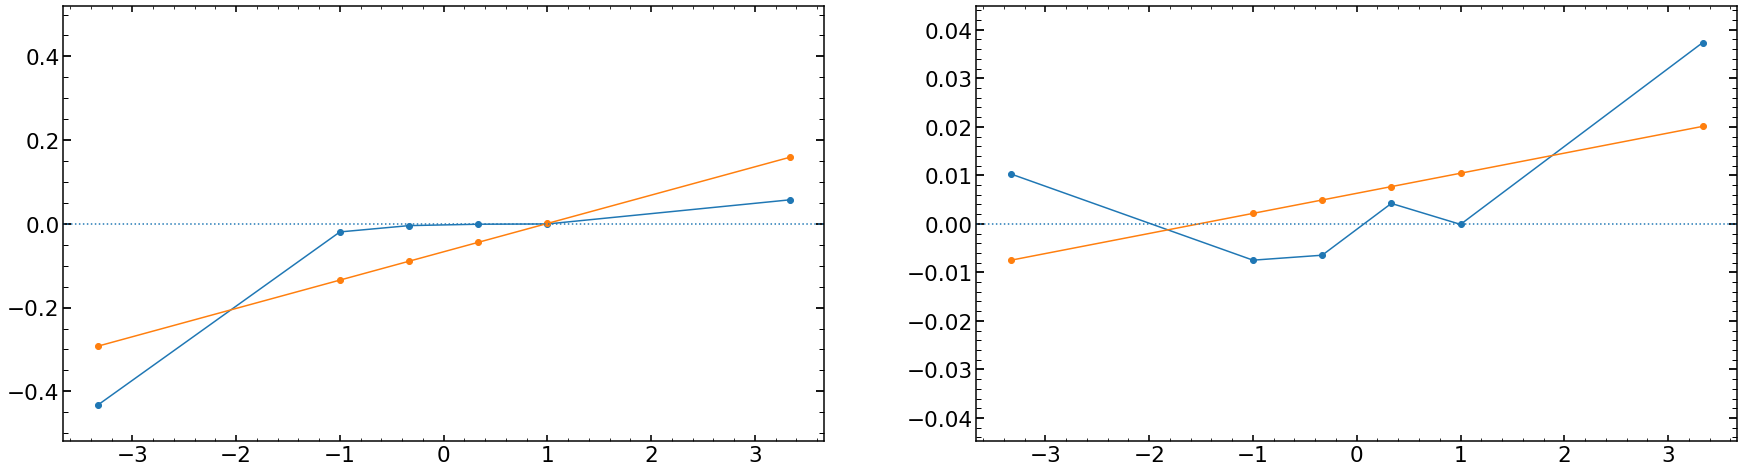

In [123]:
i=46

print('z'+str(4+i/2))

plt.figure(figsize=(30,8))
plt.subplot(121)
plt.plot(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3])),six_res[:,i][np.argsort(1/np.array([-3,-1,-0.3,0.3,1,3]))],marker='o')

z=np.polyfit(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3])),six_res[:,i][np.argsort(1/np.array([-3,-1,-0.3,0.3,1,3]))],deg=1)
p = np.poly1d(z)
plt.plot(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3])),p(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3]))),marker='o')

plt.ylim(-(np.max(np.abs(six_res[:,i]))*1.2),(np.max(np.abs(six_res[:,i]))*1.2))
plt.axhline(0,ls=':')

plt.subplot(122)
plt.plot(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3])),six_res[:,i+1][np.argsort(1/np.array([-3,-1,-0.3,0.3,1,3]))],marker='o')

z=np.polyfit(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3])),six_res[:,i+1][np.argsort(1/np.array([-3,-1,-0.3,0.3,1,3]))],deg=1)
p = np.poly1d(z)
plt.plot(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3])),p(np.sort(1/np.array([-3,-1,-0.3,0.3,1,3]))),marker='o')


plt.ylim(-(np.max(np.abs(six_res[:,i+1]))*1.2),(np.max(np.abs(six_res[:,i+1]))*1.2))
plt.axhline(0,ls=':')

array([-0.00334954,  0.00182049,  0.00755602, -0.00530685, -0.00072408,
        0.01456808, -0.00093148,  0.00650746, -0.0008813 ,  0.00752375,
        0.00175301,  0.00030431, -0.0107573 ,  0.01822165,  0.00313494,
       -0.00232249,  0.0041755 , -0.00401951,  0.00128526, -0.0059911 ,
       -0.00031867,  0.00008683, -0.00315301,  0.00597656,  0.00116536,
       -0.00396545, -0.00091873,  0.00242219, -0.00029327,  0.00124313,
        0.00080576, -0.00049195,  0.00228608,  0.00120678,  0.00178045,
       -0.00062367, -0.0016554 ,  0.00271852,  0.00013843,  0.00093653,
        0.0002394 , -0.00120558,  0.00004607, -0.00051274,  0.00015011,
       -0.00008095, -0.00000188, -0.00000385,  0.00014572, -0.00027169,
        0.00020955, -0.00173339, -0.00027561,  0.00033312, -0.00291124,
        0.00312012,  0.00023145,  0.00105108, -0.0004176 , -0.00079056,
        0.00004862,  0.00015547, -0.00019046, -0.00365568, -0.0002683 ,
       -0.00008668,  0.00014557,  0.00051443, -0.00026336,  0.00

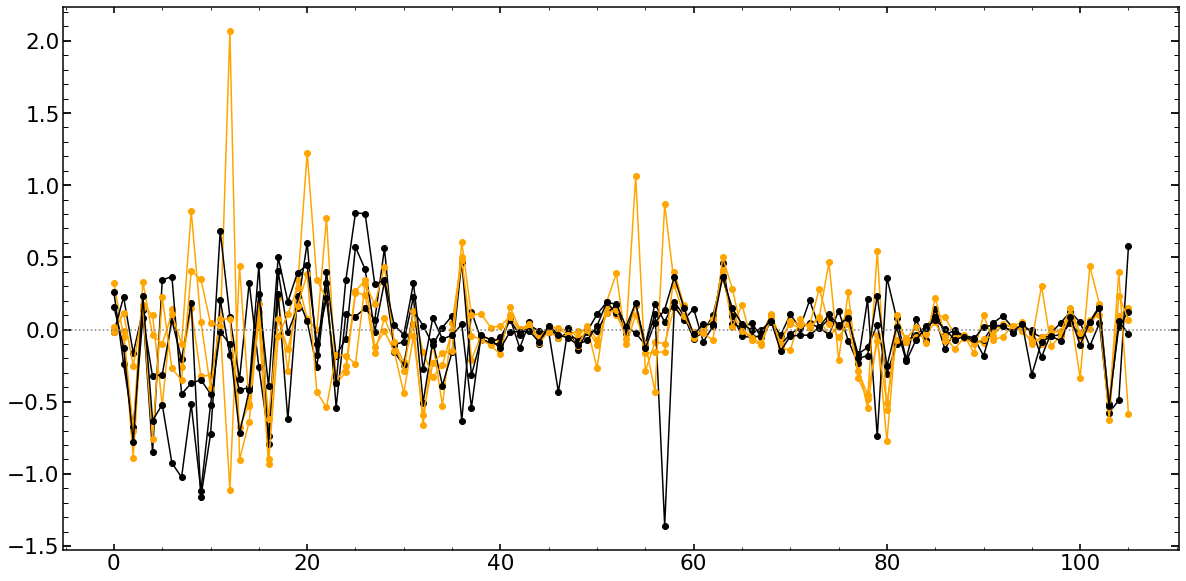

In [176]:
plt.figure(figsize=(20,10))
plt.plot(res[0]*(-3),marker='o',color='orange')
plt.plot(res_m1[0]*3,marker='o',color='black')
plt.plot(res_m03[0],marker='o',color='black')
plt.plot(res_03[0]*-1,marker='o',color='orange')
plt.plot(res_3[0]*(-9),marker='o',color='orange')
plt.plot(res_m3[0]*9,marker='o',color='black')
plt.axhline(0,ls=':',color='gray')

In [180]:
res_6=np.array([res_m3[0]*9,res_m1[0]*3,res_m03[0],res_03[0]*-1,res[0]*(-3),res_3[0]*(-9)])
np.mean(res_6,axis=0)

array([ 0.11905828, -0.01402964, -0.57612115,  0.181391  , -0.41791606,
       -0.14815131, -0.08520202, -0.39824048,  0.11092404, -0.42578545,
       -0.39428425,  0.1595994 ,  0.13887835, -0.43709528, -0.36336794,
        0.13136902, -0.72907215,  0.23300348, -0.12843429,  0.26123008,
        0.4640673 , -0.10596427,  0.23005892, -0.33325186, -0.05706215,
        0.29241225,  0.3776661 ,  0.04348113,  0.29041734, -0.09148679,
       -0.21982546,  0.13233459, -0.3599291 , -0.12659608, -0.22917122,
       -0.03517713,  0.24373811, -0.14741783, -0.02953658, -0.07150234,
       -0.08485683,  0.07809577, -0.0317976 ,  0.02730334, -0.0682049 ,
        0.00761751, -0.09624505, -0.02420609, -0.08265098, -0.01115623,
       -0.05434161,  0.15838182,  0.18037488, -0.03063316,  0.27737793,
       -0.14794259, -0.05738723, -0.09245811,  0.2630671 ,  0.10687677,
       -0.00873348, -0.01922333,  0.0388187 ,  0.41175124,  0.11438441,
        0.0286215 , -0.03369013, -0.05925692,  0.08373085, -0.09

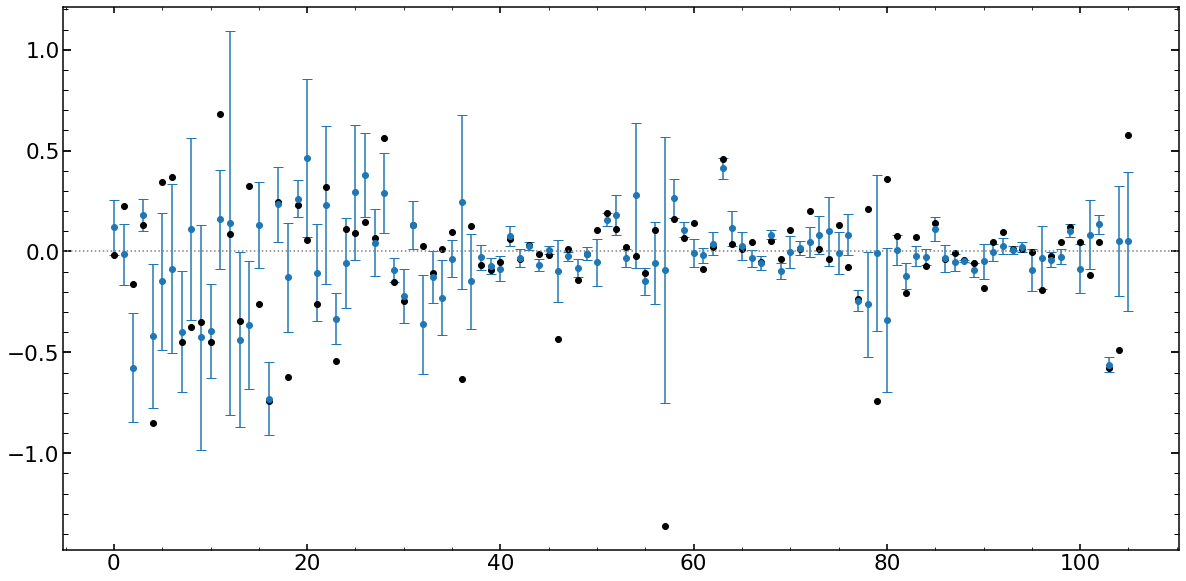

In [188]:
plt.figure(figsize=(20,10))
plt.errorbar(np.arange(len(res_m3[0])),np.mean(res_6,axis=0),yerr=np.std(res_6,axis=0),ls='',marker='o',capsize=5)
plt.plot(res_m03[0],color='black',ls='',marker='o')
plt.axhline(0,ls=':',color='gray')

### the difference between this one and Tokovinin

In [195]:
res_1_this_method=res[0]*array_of_delta_z_parametrizations_1
res_1_this_method

array([-0.00334954,  0.00182049,  0.00755602, -0.00530685, -0.00072408,
        0.01456808, -0.00093148,  0.00650746, -0.0008813 ,  0.00752375,
        0.00175301,  0.00030431, -0.0107573 ,  0.01822165,  0.00313494,
       -0.00232249,  0.0041755 , -0.00401951,  0.00128526, -0.0059911 ,
       -0.00031867,  0.00008683, -0.00315301,  0.00597656,  0.00116536,
       -0.00396545, -0.00091873,  0.00242219, -0.00029327,  0.00124313,
        0.00080576, -0.00049195,  0.00228608,  0.00120678,  0.00178045,
       -0.00062367, -0.0016554 ,  0.00271852,  0.00013843,  0.00093653,
        0.0002394 , -0.00120558,  0.00004607, -0.00051274,  0.00015011,
       -0.00008095, -0.00000188, -0.00000385,  0.00014572, -0.00027169,
        0.00020955, -0.00173339, -0.00027561,  0.00033312, -0.00291124,
        0.00312012,  0.00023145,  0.00105108, -0.0004176 , -0.00079056,
        0.00004862,  0.00015547, -0.00019046, -0.00365568, -0.0002683 ,
       -0.00008668,  0.00014557,  0.00051443, -0.00026336,  0.00

In [202]:
H_std=np.transpose(np.array((uber_images_normalized_1-uber_M0))/array_of_delta_z_parametrizations_1[:,None])/uber_std.ravel()[:,None]    


#singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))<0.01]
non_singlular_parameters=np.arange(H_std.shape[1])[np.abs((np.mean(H_std,axis=0)))>0.01]

print(len(non_singlular_parameters))
H_std=H_std[:,non_singlular_parameters]

HHt_std=np.matmul(np.transpose(H_std),H_std) 

invHHt_std=np.linalg.inv(HHt_std)

invHHtHt_std=np.matmul(invHHt_std,np.transpose(H_std))

first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,(uber_I-uber_M0)/uber_std.ravel())  


106


In [208]:
print(first_proposal_Tokovnin_std[:5])
print(res_1_this_method[:5])

[ 0.00334954 -0.00182049 -0.00755602  0.00530685  0.00072408]
[-0.00334954  0.00182049  0.00755602 -0.00530685 -0.00072408]


In [216]:
print(first_proposal_Tokovnin_std[38:38+5])
print(res_1_this_method[38:38+5])

[-0.00013843 -0.00093653 -0.0002394   0.00120558 -0.00004607]
[ 0.00013843  0.00093653  0.0002394  -0.00120558  0.00004607]


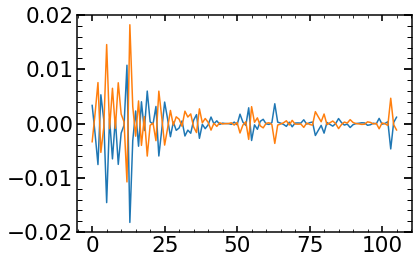

In [206]:
plt.plot(first_proposal_Tokovnin_std)
plt.plot(res_1_this_method)

In [214]:
np.sum(np.abs(needed_subtraction-1*res[0]@array_of_subtraction_1_std))

41232.414

In [215]:
np.sum(np.abs(needed_subtraction+1*res[0]@array_of_subtraction_1_std))

43493.734

In [415]:
needed_subtraction_106_max=needed_subtraction[pos_of_106_max_pixels]

In [413]:
array_of_subtraction_1_std_T_106_max=array_of_subtraction_1_std.T[pos_of_106_max_pixels]

In [ ]:
array_of_subtraction_1_std_T_106_max=array_of_subtraction_1_std.T[pos_of_106_max_pixels]

In [416]:
res=np.linalg.lstsq(array_of_subtraction_1_std_T_106_max,needed_subtraction_106_max)

<ipython-input-416-5161e2220951>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  res=np.linalg.lstsq(array_of_subtraction_1_std_T_106_max,needed_subtraction_106_max)


In [417]:
res

(array([  83.1099   ,  198.75523  , -267.2459   ,   -2.5288582,
         130.29733  , -263.1185   ,    5.51466  , -114.34979  ,
         -27.98563  ,   12.36416  ,  241.05937  ,  -64.36526  ,
        -264.73517  ,  -86.24462  ,    2.2204812,  171.27295  ,
          58.497658 , -181.04779  ,  155.62225  ,  136.41771  ,
        -122.6475   ,  336.46533  ,  490.52518  , -197.74788  ,
         -46.774353 ,    7.4915624,   32.73363  ,   -2.921949 ,
         -10.308176 ,  -68.467995 , -176.56548  ,   35.76153  ,
         287.66586  , -270.4382   , -557.5433   ,   52.40107  ,
         104.21088  ,  -45.949604 , -133.8113   ,   44.641876 ,
         -49.856663 ,   -9.773872 ,   67.57099  ,  -46.511105 ,
          97.57628  ,    4.3819847,  -13.816666 ,   45.569103 ,
         -70.75756  ,   -6.1348453,   69.993225 , -207.73189  ,
        -107.93242  ,   84.59695  ,  183.87628  ,  284.69476  ,
        -185.12126  ,  421.10086  ,  -98.54005  ,   -6.85347  ,
          18.560656 ,   22.465525 ,  143

In [319]:
    i=39
    ratio_of_difference_m1=(uber_M0_1-uber_images_normalized_m1[i])/(uber_M0_1-uber_images_normalized_1[i])
    ratio_of_difference_9=(uber_M0_1-uber_images_normalized_9[i])/(uber_M0_1-uber_images_normalized_1[i])
    ratio_of_difference_3=(uber_M0_1-uber_images_normalized_3[i])/(uber_M0_1-uber_images_normalized_1[i])

    subtraction_1=(uber_M0_1-uber_images_normalized_1[i])/uber_M0_1
    subtraction_3=(uber_M0_1-uber_images_normalized_3[i])/uber_M0_1
    subtraction_9=(uber_M0_1-uber_images_normalized_9[i])/uber_M0_1


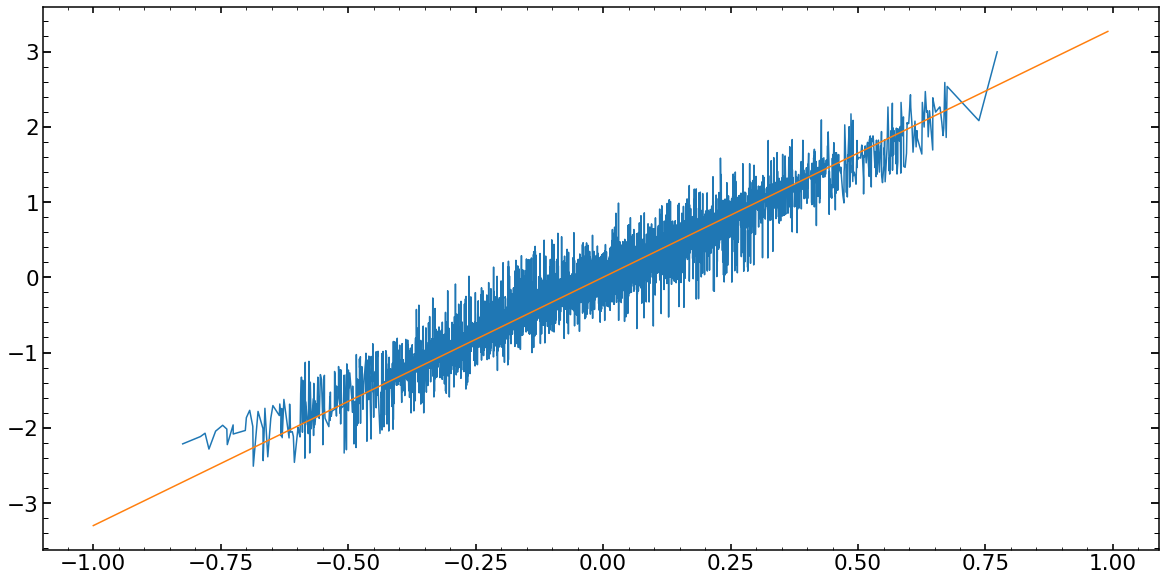

In [328]:
i=13
plt.figure(figsize=(20,10))
plt.plot(np.sort(array_of_subtraction_03_std[i]),array_of_subtraction_1_std[i][np.argsort(array_of_subtraction_03_std[i])])
plt.plot(np.arange(-1,1,0.01),3.3*np.arange(-1,1,0.01))
#plt.plot(np.sort(array_of_subtraction_03_std[20]),array_of_subtraction_3_std[20][np.argsort(array_of_subtraction_03_std[20])])
#plt.plot(np.arange(-1,1,0.01),3*3.3*np.arange(-1,1,0.01))

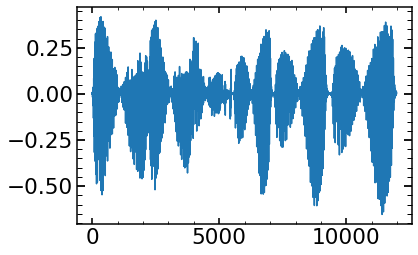

In [290]:
plt.plot(subtraction_1)
#plt.plot(subtraction_3)
#plt.plot(np.arange(-200,200,1),np.arange(-200,200,1))

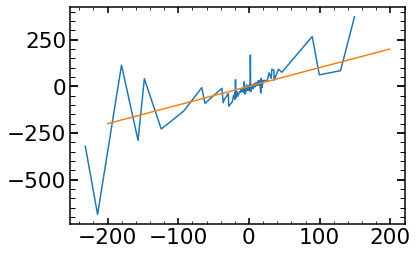

In [260]:
plt.plot(np.sort(ratio_of_difference_3),ratio_of_difference_m1[np.argsort(ratio_of_difference_3)])
plt.plot(np.arange(-200,200,1),np.arange(-200,200,1))

In [347]:
uber_M0_final=uber_M0_1+(res[0]@array_of_subtraction_1_std)*uber_std

In [ ]:
needed_subtraction=(uber_I-uber_M0_1)/uber_std

In [346]:
np.sum(np.abs(needed_subtraction))

41826.594

In [349]:
np.sum(np.abs((uber_I-uber_M0_final)/uber_std))

41232.414

In [220]:
pre_input_parameters[0]

array([   30.67833794,    -0.62593559,    -0.12500342,     0.54122133,
           0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
          -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
          -0.08072721,     0.11364326,     0.02865385,     0.05619694,
          -0.02095564,    -0.00567704,     0.05179967,     0.68904049,
           0.10290975,    -0.20154677,    -0.01441376,     0.05355728,
           0.05813265,     0.0000314 ,     0.0000314 ,     0.9767313 ,
           0.94836248,     0.02461952,    -0.05835101,     0.93393462,
           0.04867201,     0.49904901,     1.01173008,     0.63182418,
       51347.90306188,     2.32213302,     0.00238991,     0.37175131,
           1.79411345,     1.        ,    -0.00169099,     0.00680567,
           0.00063228,    -0.00320022,    -0.0001492 ,    -0.00200392,
          -0.01288429,    -0.00130456,     0.00286158,     0.00367795,
          -0.00718475,     0.00712878,    -0.00633617,    -0.00842575,
      

In [231]:
pre_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Oct0520/pre_input_parameters.npy',allow_pickle=True)
#list_of_image_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Sep2820/list_of_image_0_1_0.npy',allow_pickle=True)


list_of_initial_input_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Oct0520/list_of_initial_input_parameters_1_0.npy',allow_pickle=True)


out_parameters=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Oct0520/out_parameters_1_0.npy',allow_pickle=True)


In [234]:
out_parameters[0]

array([[   30.55333794,    -0.62593559,    -0.12500342,     0.54122133,
            0.4544804 ,     0.0971773 ,    -0.30884251,     0.02078533,
           -0.19395963,    -0.11850474,    -0.12224318,     0.01944684,
           -0.08072721,     0.11364326,     0.02865385,     0.05619694,
           -0.02095564,    -0.00567704,     0.05179967,     0.68904049,
            0.10290975,    -0.20154677,    -0.01441376,     0.05355728,
            0.05813265,     0.0000314 ,     0.0000314 ,     0.9767313 ,
            0.94836248,     0.02461952,    -0.05835101,     0.93393462,
            0.04867201,     0.49904901,     1.01173008,     0.63182418,
        51347.90306188,     2.32213302,     0.00238991,     0.37175131,
            1.79411345,     0.99134125,    -0.00169099,     0.00680567,
            0.00063228,    -0.00320022,    -0.0001492 ,    -0.00200392,
           -0.01288429,    -0.00130456,     0.00286158,     0.00367795,
           -0.00718475,     0.00712878,    -0.00633617,    -0.00

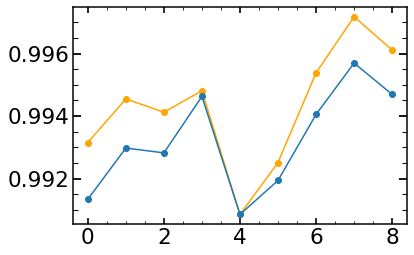

In [246]:
plt.plot(pre_input_parameters[:,41],marker='o',color='orange')
plt.plot(out_parameters[0][:,41],marker='o')
#plt.plot(out_parameters[1][:,41],marker='o')
#plt.plot(out_parameters[29][:,41],marker='o',color='black')
#plt.plot(out_parameters[51][:,41],marker='o',color='black')

In [241]:
out_parameters[0][:,41]

array([0.99134125, 0.99297903, 0.99282488, 0.99462884, 0.9908572 ,
       0.99194277, 0.99405465, 0.99569533, 0.99469556])

In [244]:
pre_input_parameters[:,41]/out_parameters[0][:,41]

array([1.00182872, 1.00158238, 1.00130925, 1.0001812 , 1.        ,
       1.00057675, 1.00134104, 1.00148866, 1.00142567])

In [252]:
out_images[0]

array([array([[5.9243   , 6.3206353, 6.731026 , ..., 6.3467436, 5.991352 ,
        5.6590695],
       [6.339982 , 6.7728586, 7.222768 , ..., 6.8007727, 6.4091086,
        6.0438704],
       [6.7735543, 7.2461443, 7.73924  , ..., 7.2767124, 6.8451357,
        6.4435625],
       ...,
       [8.494213 , 9.156705 , 9.86423  , ..., 8.474954 , 7.920146 ,
        7.4089975],
       [7.946486 , 8.546236 , 9.1831045, ..., 7.9336133, 7.4307265,
        6.9659104],
       [7.4266047, 7.970384 , 8.545283 , ..., 7.4145665, 6.958935 ,
        6.5366626]], dtype=float32),
       array([[ 7.658225 ,  8.306951 ,  9.018767 , ..., 10.510566 ,  9.693412 ,
         8.9732   ],
       [ 8.265098 ,  8.985163 ,  9.777869 , ..., 11.479075 , 10.544964 ,
         9.725861 ],
       [ 8.9043255,  9.704158 , 10.588084 , ..., 12.530115 , 11.459016 ,
        10.52546  ],
       ...,
       [ 8.903966 ,  9.722339 , 10.635674 , ..., 11.413403 , 10.461604 ,
         9.628394 ],
       [ 8.212153 ,  8.937512 ,  9.742893

In [251]:
out_images[0]*(pre_input_parameters[:,41]/out_parameters[0][:,41])

array([array([[5.935134 , 6.332194 , 6.743335 , ..., 6.35835  , 6.0023084,
        5.6694183],
       [6.351576 , 6.785244 , 7.2359757, ..., 6.813209 , 6.420829 ,
        6.0549226],
       [6.785941 , 7.259395 , 7.7533927, ..., 7.290019 , 6.857653 ,
        6.4553456],
       ...,
       [8.509747 , 9.1734495, 9.882269 , ..., 8.490452 , 7.9346294,
        7.4225464],
       [7.9610176, 8.561864 , 9.199898 , ..., 7.948121 , 7.444315 ,
        6.9786487],
       [7.4401855, 7.984959 , 8.56091  , ..., 7.4281254, 6.9716606,
        6.548616 ]], dtype=float32),
       array([[ 7.6703434,  8.320095 ,  9.033038 , ..., 10.527198 ,  9.708751 ,
         8.987399 ],
       [ 8.278176 ,  8.999381 ,  9.793342 , ..., 11.49724  , 10.56165  ,
         9.741251 ],
       [ 8.918416 ,  9.719514 , 10.604838 , ..., 12.549943 , 11.477148 ,
        10.542115 ],
       ...,
       [ 8.918056 ,  9.737723 , 10.652504 , ..., 11.431463 , 10.478158 ,
         9.64363  ],
       [ 8.225148 ,  8.951655 ,  9.75831 

In [254]:
pre_input_parameters[:,41]

array([0.99315413, 0.99455031, 0.99412474, 0.99480907, 0.9908572 ,
       0.99251487, 0.99538772, 0.99717759, 0.99611367])

In [279]:
len(list_of_sci_images)

9

In [282]:
list_of_psf_positions at the input stage: [[ 21.42248034 -21.17291944]
 [  7.65941254  -3.96384647]
 [ 11.2737367    4.27771657]
 [  3.31162774 -16.23341664]
 [  7.66000709  18.95469028]
 [ 11.573826    27.48298416]
 [ -6.22611783  -9.5828442 ]
 [ 16.12699736  32.26282566]
 [ 10.91940228  13.91628257]]

[None, None, None, None, None, None, None, None, None]

In [ ]:
list_of_final_psf_positions : [[ 21.27690936 -21.14039395]
 [  7.52107601  -3.9738926 ]
 [ 11.12203794   4.27458425]
 [  3.21644991 -16.28655005]
 [  7.57097708  18.90385901]
 [ 11.49356537  27.41736286]
 [ -6.25987706  -9.66614497]
 [ 16.09869558  32.20214426]
 [ 10.90656367  13.82727754]]

## comparison of init and output after one

In [292]:
def move_parametrizations_from_2d_shape_to_1d_shape(allparameters_best_parametrization_shape_2d):
    """ 
    change the linear parametrization array in 2d shape to parametrization array in 1d
    
    @param allparameters_best_parametrization_shape_2d        linear parametrization, 2d array
    
    """    
    
    
    if allparameters_best_parametrization_shape_2d.shape[0]>42:
        #  if you are using above Zernike above 22
        print('we are creating new result with Zernike above 22')
        allparameters_best_parametrization_shape_1d=np.concatenate((allparameters_best_parametrization_shape_2d[:19].ravel(),
                                                    allparameters_best_parametrization_shape_2d[19:19+23][:,1],\
                                                        allparameters_best_parametrization_shape_2d[19+23:].ravel()))
        
    else:
        print('we are creating new result with Zernike at 22')
        allparameters_best_parametrization_shape_1d=np.concatenate((allparameters_best_parametrization_shape_2d[:19].ravel(),
                                                    allparameters_best_parametrization_shape_2d[19:-1][:,1]))    
        
    return allparameters_best_parametrization_shape_1d

min_parametrization_1=array_of_polyfit_1_parameterizations_proposal_shape_2d=np.array([[   -7.48584024,     0.73497698],
       [    0.19568978,     0.15682353],
       [    0.03769565,     0.02577918],
       [   -0.03734586,     0.39183789],
       [    0.02550665,     0.556507  ],
       [    0.0072312 ,     0.1261021 ],
       [    0.01097693,    -0.26493479],
       [   -0.01831573,    -0.05247759],
       [    0.01020252,    -0.15314955],
       [    0.00343817,    -0.10475206],
       [    0.02711867,    -0.0137685 ],
       [    0.00445374,     0.0372618 ],
       [    0.01458828,    -0.02237409],
       [   -0.01880653,     0.03841714],
       [   -0.00188257,     0.02112357],
       [   -0.00910924,     0.01975998],
       [   -0.00067647,    -0.02366152],
       [    0.00463751,     0.012873  ],
       [   -0.00621102,     0.02695559],
       [    0.        ,     0.68904049],
       [    0.        ,     0.10290975],
       [    0.        ,    -0.20154677],
       [    0.        ,    -0.01441376],
       [    0.        ,     0.05355728],
       [    0.        ,     0.05813265],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.0000314 ],
       [    0.        ,     0.9767313 ],
       [    0.        ,     0.94836248],
       [    0.        ,     0.02461952],
       [    0.        ,    -0.05835101],
       [    0.        ,     0.93393462],
       [    0.        ,     0.04867201],
       [    0.        ,     0.49904901],
       [    0.        ,     1.01173008],
       [    0.        ,     0.63182418],
       [    0.        , 51347.90306188],
       [    0.        ,     2.32213302],
       [    0.        ,     0.00238991],
       [    0.        ,     0.37175131],
       [    0.        ,     1.79411345],
       [    0.        ,     0.99627532],
       [    0.00003301,    -0.00155895],
       [   -0.0007012 ,     0.00400087],
       [    0.00093449,     0.00437024],
       [    0.00096567,     0.00066246],
       [    0.00095771,     0.00368164],
       [    0.00029302,    -0.00083184],
       [    0.00196281,    -0.00503305],
       [    0.00055673,     0.00092236],
       [   -0.00170941,    -0.00397606],
       [    0.00222377,     0.01257303],
       [    0.00219571,     0.00159809],
       [   -0.00109161,     0.00276234],
       [   -0.00071055,    -0.00917837],
       [    0.00070316,    -0.00561311],
       [   -0.00074906,     0.00218633],
       [    0.00052506,     0.00031175],
       [   -0.00027124,     0.00124874],
       [    0.00056686,    -0.0004586 ],
       [   -0.00085383,     0.00176925],
       [   -0.00200233,    -0.00099071],
       [   -0.00017492,     0.00005366],
       [    0.00075724,    -0.00381397],
       [    0.0016349 ,    -0.00899893],
       [    0.00057199,    -0.01150359],
       [   -0.00085055,     0.00203238],
       [   -0.00052982,     0.0053546 ],
       [    0.00095456,    -0.00181697],
       [   -0.00055045,    -0.00379142],
       [   -0.00048768,     0.00804741],
       [   -0.00145526,     0.00574891],
       [   -0.0001161 ,    -0.00048279],
       [   -0.00099326,     0.00201623],
       [    0.00012449,     0.0103669 ],
       [    0.00272563,    -0.00187062]])



min_parametrization_1=move_parametrizations_from_2d_shape_to_1d_shape(array_of_polyfit_1_parameterizations_proposal_shape_2d)
print(min_parametrization_1)    

we are creating new result with Zernike above 22
[   -7.48584024     0.73497698     0.19568978     0.15682353
     0.03769565     0.02577918    -0.03734586     0.39183789
     0.02550665     0.556507       0.0072312      0.1261021
     0.01097693    -0.26493479    -0.01831573    -0.05247759
     0.01020252    -0.15314955     0.00343817    -0.10475206
     0.02711867    -0.0137685      0.00445374     0.0372618
     0.01458828    -0.02237409    -0.01880653     0.03841714
    -0.00188257     0.02112357    -0.00910924     0.01975998
    -0.00067647    -0.02366152     0.00463751     0.012873
    -0.00621102     0.02695559     0.68904049     0.10290975
    -0.20154677    -0.01441376     0.05355728     0.05813265
     0.0000314      0.0000314      0.9767313      0.94836248
     0.02461952    -0.05835101     0.93393462     0.04867201
     0.49904901     1.01173008     0.63182418 51347.90306188
     2.32213302     0.00238991     0.37175131     1.79411345
     0.99627532     0.00003301    -0.001

In [283]:
min_parametrization_2=np.array([   -7.48070761,     0.72447495,     0.18827899 ,    0.15801109,
     0.03661317,     0.00493662,    -0.03920831,     0.37318306,
     0.02846598,     0.53153751,     0.00536644,     0.13141354,
     0.01115121,    -0.27156456,    -0.02199067,    -0.04352089,
     0.0060499 ,    -0.14645334,     0.00340612,    -0.09897022,
     0.02889543,    -0.01251559,     0.00602319,     0.03375817,
     0.01329471,    -0.01449904,    -0.01692902,     0.04072393,
    -0.00084237,     0.01811742,    -0.01011509,     0.01962615,
    -0.00214655,    -0.0248272,      0.00366185,     0.01214401,
    -0.0042326 ,     0.02152142,     0.68904049,     0.10290975,
    -0.20154677,    -0.01441376,     0.05355728,     0.05813265,
     0.0000314 ,     0.0000314 ,     0.9767313 ,     0.94836248,
     0.02461952,    -0.05835101,     0.93393462,     0.04867201,
     0.49904901,     1.01173008,     0.63182418, 51347.90306188,
     2.32213302,     0.00238991,     0.37175131,     1.79411345,
     0.99627532,    -0.00016401,    -0.00240094,    -0.00115177,
     0.00500444,     0.00087548,     0.00464438,     0.00075945,
     0.00158504,     0.00092488,     0.00391868,     0.00019344,
    -0.00056391,     0.00186575,    -0.00381272,     0.00093133,
     0.00049185,    -0.00129364,    -0.00551463,     0.00183175,
     0.01176212,     0.00261451,     0.00248532,    -0.00109513,
     0.00221782,    -0.00056896,    -0.00560936,     0.00102142,
    -0.00606421,    -0.00087919,     0.00169622,     0.00072082,
    -0.00052738,    -0.00017862,     0.00144881,     0.00070312,
    -0.00019628,    -0.00068216,     0.00159503,    -0.00191613,
    -0.00322363,    -0.00108208,     0.00054395,    -0.00011158,
    -0.00411232,     0.00156128,    -0.00966963,     0.00062297,
    -0.01106867,    -0.0007906 ,     0.00179414,    -0.00053764,
     0.00432792,     0.00088649,    -0.00144276,    -0.00043862,
    -0.00368402,    -0.00046748,     0.00756346,    -0.00160409,
     0.00558993,    -0.00010869,     0.00029597,    -0.00116808,
     0.00278412,     0.00036007,     0.00577463,     0.00291994,
    -0.00180036])

In [290]:
#date='Jul2020'
date='Sep2820'
obs=21448
#obs_multi=[21352, 21358, 21364, 21436, 21442, 21448 ]
obs_int=int(obs)
single_number='3'
image_index=int(single_number)
eps=6
arc='HgAr'
dataset=4

list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

In [297]:
#single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
#                                 list_of_defocuses=['m4','m35','m3','m05','0','p05','p3','p35','p4'])

single_analysis=Zernike_Analysis(date=date,obs='m3',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()

chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

labelInput: m3
self.single_number: 3
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [21352, 21358, 21364, 21394, 21400, 21406, 21436, 21442, 21448]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Aug_14/Dataframes/finalHgAr_Feb2020'>
analyzing label: 21364
double_sources_positions_ratios for this spot is: [0 0]
(7, 120, 129)
(7, 120, 129)
minimal likelihood is: 3382.5717778593516
minimal chi2 reduced is (makes no sense for multi_var): -5.422008666347685


In [298]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=0,zmax=56,verbosity=1,\
                      double_sources=False,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536)   
list_of_minchain_1=model_multi.create_list_of_allparameters(min_parametrization_1,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
#list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=['m4','p4'],zmax=56)

res_multi_1=model_multi(list_of_minchain_1,return_Images=True)


mean_res_of_multi_same_spot_1,list_of_single_res_1,list_of_single_model_image_1,\
                list_of_single_allparameters_1,list_of_single_chi_results,list_of_psf_positions=res_multi

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 3.0530858
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 155.51562
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.34
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   30.67833794    -0.62593559    -0.12500342     0.54122133
     0.4544804      0.0971773     -0.30884251     0.02078533
    -0.19395963    -0.11850474    -0.12224318     0.01944684
    -0.08072721     0.11364326     0.02865385     0.05619694
    -0.02095564    -0.00567704     0.05179967     0.68904049
     0.10290975    -0.20154677    -0.01441376     0.05355728
     0.05813265     0

chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.473896
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.319963
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.247826
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.213047
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.196026
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.196026
chi2 within shgo optimization routine (chi_2_almost_multi_values): 18.196026
We are fitting for only one source
One source fitting result is [ 21.42160471 -21.15064763]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.2651398181915283
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9931489593291372

lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767313, 0.94836248, 3.14e-05, 3.14e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.24674391746520996
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.45499587059020996
Time for pupil and illumination calculation is 0.4646446704864502

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 23.192497699999997, -0.43024581, -0.08730776999999999, 0.50387547, 0.47998704999999997, 0.10440849999999999, -0.29786557999999996, 0.0024695999999999954, -0.18375711, -0.11506656999999999, -0.09512451000000001, 0.023900579999999998, -0.06613893, 0.09483673, 0.02677128, 0.047087699999999996, -0.02163211, -0.0010395299999999986, 0.04558865

Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767313, 0.94836248, 3.14e-05, 3.14e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.17848896980285645
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.40302205085754395
Time for pupil and illumination calculation is 0.41051793098449707

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 4.4778971, 0.058978639999999985, 0.006931355, 0.41051082, 0.5437536749999999, 0.1224865, -0.270423255, -0.043319724999999996, -0.15825081, -0.10647114499999999, -0.027327835, 0.03503493, -0.02966823, 0.047820405, 0.022064855, 0.0243146, -0.023323285, 0.010554245, 0.0300611, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Time to apodize the pupil: 0.18242192268371582
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.3858642578125
Time for pupil and illumination calculation is 0.39251089096069336

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 0.73497698, 0.15682353, 0.02577918, 0.39183789, 0.556507, 0.1261021, -0.26493479, -0.05247759, -0.15314955, -0.10475206, -0.0137685, 0.0372618, -0.02237409, 0.03841714, 0.02112357, 0.01975998, -0.02366152, 0.012873, 0.02695559, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.15682353, 0.02577918, 0.39183789, 0.556507, 0.1261021, -0.26493479, 0, -0.15314955, -0.10475206, -0.0137685, 0.0372618, -0.02237409, 0.03841714, 0.02112357, 0.01975998, -0.02366152, 0.012873, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767313, 0.94836248, 3.14e-05, 3.14e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.1968371868133545
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.4026458263397217
Time for pupil and illumination calculation is 0.4125711917877197

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -3.00794314, 0.25466842, 0.044627005, 0.37316496000000005, 0.569260325, 0.1297177, -0.259446325, -0.061635455, -0.14804829, -0.103032975, -0.000209164999999999, 0.03948867, -0.015079949999999998, 0.029013875, 0.020182285, 0.015205360000000001, -0.023999754999999998, 0.015191755000000001, 0.023850080000000003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Time to apodize the pupil: 0.17088723182678223
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.36411404609680176
Time for pupil and illumination calculation is 0.3710949420928955

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -21.72254374, 0.74389287, 0.13886612999999998, 0.27980031000000005, 0.63302695, 0.1477957, -0.232004, -0.10742478, -0.12254198999999999, -0.09443755, 0.06758751, 0.05062302, 0.02139075, -0.01800244999999999, 0.015475860000000001, -0.00756774, -0.025690929999999997, 0.026785530000000002, 0.008322530000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.74389287, 0.13886612999999998, 0.27980031000000005, 0.63302695, 0.1477957, -0.232004, 0, -0.12254198999999999, -0.09443755, 0.06758751, 0.05062302, 

lower_limit_of_ilum: 768
higher_limit_of_ilum: 2304
Size after padding zeros to 2x size and extra padding to get size suitable for FFT: (3072, 3072)
size_of_ilum_in_units_of_radius: 2.0
radiometric parameters are: 
x_ilum,y_ilum,radiometricEffect,radiometricExponent[0.9767313, 0.94836248, 3.14e-05, 3.14e-05]
skiping ``radiometric effect'' 
Time to apodize the pupil: 0.1720728874206543
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.3927328586578369
Time for pupil and illumination calculation is 0.40242791175842285

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -25.46546386, 0.84173776, 0.15771395500000002, 0.26112738, 0.645780275, 0.1514113, -0.226515535, -0.11658264499999998, -0.11744073, -0.092718465, 0.081146845, 0.05284989, 0.028684890000000005, -0.027405714999999997, 0.014534575000000001, -0.012122359999999995, -0.026029165, 0.029104285, 0.005217019999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.997187865105768
Finished with lnlike_Neven
chi_2_almost/d.o.f is 14.018253; chi_2_almost_max_dof is 2237.2197 log(improvment) is -2.2030146
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4495558080
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4495558080 is: 2.6837852001190186 seconds
 
################################
analyzing image 9 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 14.235072
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 168.06808
Mask image shape is: (60, 60)
Sum of mask image is: 0.0
Dithering value is: 1

sup

NameError: name 'res_multi' is not defined